# Assignment 3C: Denoising Diffusion Probabilistic Models (DDPM)

In this assignment, you will implement a simplified version of the **Denoising Diffusion Probabilistic Model (DDPM)**, one of the foundational generative models behind modern AI image generators like Stable Diffusion and DALL-E.

Diffusion models work by:
1. **Forward Process**: Gradually adding Gaussian noise to data until it becomes pure noise
2. **Reverse Process**: Learning to denoise, step by step, to generate new samples from random noise

By the end of this lab, you will be able to generate handwritten digits from scratch using your own diffusion model!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

## Configuration

Below we define the hyperparameters for our diffusion model. Feel free to experiment with these values, except those marked as `DO NOT MODIFY`.

In [2]:
class Config:
    # Training parameters
    batch_size: int = 128
    learning_rate: float = 2e-4
    num_epochs: int = 10
    
    # Diffusion parameters
    num_timesteps: int = 1000  # Number of diffusion steps (T)
    beta_start: float = 1e-4  # Starting noise level
    beta_end: float = 0.02    # Ending noise level
    
    # Model parameters
    image_size: int = 28      # MNIST image size (DO NOT MODIFY)
    in_channels: int = 1      # MNIST is grayscale (DO NOT MODIFY)
    hidden_dims: int = 64     # Hidden dimension for U-Net
    
    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed: int = 42

config = Config()
torch.manual_seed(config.seed)
print(f"Using device: {config.device}")

Using device: cpu


## Data Loading

We will use the MNIST dataset for this assignment. The images are normalized to the range [-1, 1].

In [3]:
# Data transformation: normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")

Dataset size: 60000
Number of batches: 469


Let's visualize some samples from the dataset:

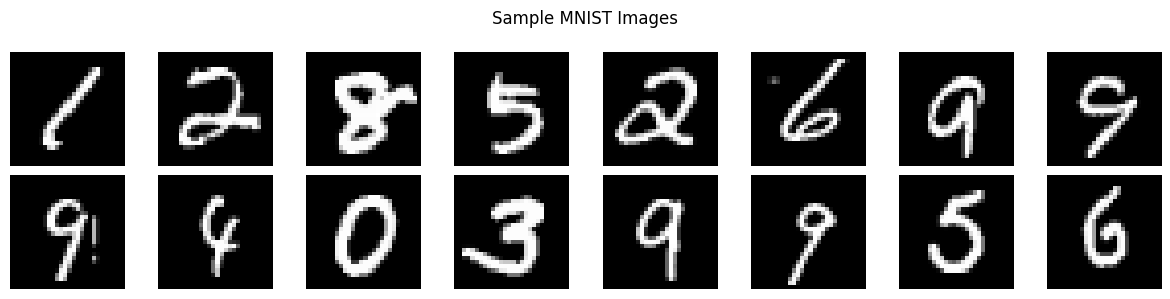

In [4]:
# Visualize some samples
sample_batch, _ = next(iter(train_loader))
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_batch[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Sample MNIST Images')
plt.tight_layout()
plt.show()

## Part 1: Noise Scheduler

The noise scheduler defines how noise is added during the forward process. We use a linear schedule where $\beta_t$ increases linearly from `beta_start` to `beta_end`.

Key quantities:
- $\beta_t$: Noise variance at timestep $t$
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$ (cumulative product)

The forward process is defined as:
$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)$$

This means we can sample $x_t$ directly from $x_0$:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

### IMPLEMENTATION REQUIRED - Implement the `NoiseScheduler` class

Complete the `__init__` method to compute:
1. `betas`: Linear schedule from `beta_start` to `beta_end`
2. `alphas`: $\alpha_t = 1 - \beta_t$
3. `alpha_cumprods`: $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$
4. `sqrt_alpha_cumprods`: $\sqrt{\bar{\alpha}_t}$
5. `sqrt_one_minus_alpha_cumprods`: $\sqrt{1 - \bar{\alpha}_t}$

In [5]:
class NoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end, device):
        self.num_timesteps = num_timesteps
        self.device = device

        # (1) Create linear schedule for betas
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        # (2) Compute alphas
        self.alphas = 1.0 - self.betas
        # (3) Compute cumulative product of alphas
        self.alpha_cumprods = torch.cumprod(self.alphas, dim=0)
        # (4) Compute sqrt of alpha_cumprods
        self.sqrt_alpha_cumprods = torch.sqrt(self.alpha_cumprods)
        # (5) Compute sqrt of (1 - alpha_cumprods)
        self.sqrt_one_minus_alpha_cumprods = torch.sqrt(1.0 - self.alpha_cumprods)

    def add_noise(self, x_0, t, noise=None):
        """
        Add noise to x_0 to get x_t using the reparameterization trick.
        x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprods[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprods[t].view(-1, 1, 1, 1)

        x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
        return x_t, noise


In [6]:
# Initialize the noise scheduler
scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    device=config.device
)

Let's visualize the forward diffusion process to understand how noise is gradually added:

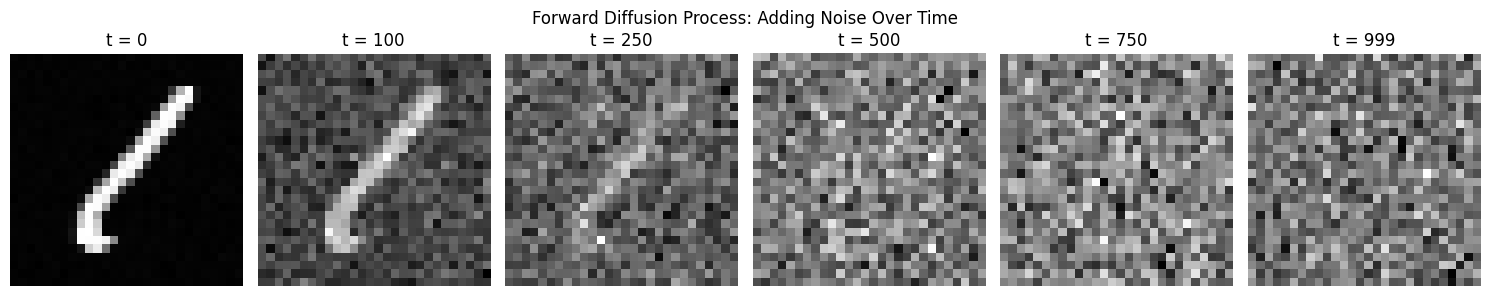

In [7]:
# Visualize the forward diffusion process
sample_image = sample_batch[0:1].to(config.device)
timesteps_to_show = [0, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 3))
for i, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=config.device)
    noisy_image, _ = scheduler.add_noise(sample_image, t_tensor)
    axes[i].imshow(noisy_image[0].squeeze().cpu(), cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].axis('off')
plt.suptitle('Forward Diffusion Process: Adding Noise Over Time')
plt.tight_layout()
plt.show()

## Part 2: Time Embedding

The model needs to know the current timestep to predict the noise. We use sinusoidal positional embeddings (similar to Transformers) to encode the timestep.

$$PE(t, 2i) = \sin(t / 10000^{2i/d})$$
$$PE(t, 2i+1) = \cos(t / 10000^{2i/d})$$

### IMPLEMENTATION REQUIRED - Implement `SinusoidalPositionEmbedding`

Complete the `forward` method to compute sinusoidal embeddings for the timestep.

In [8]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        """
        Create sinusoidal position embeddings for timestep t.
        Args:
            t: Tensor of shape (batch_size,) containing timesteps
        Returns:
            Tensor of shape (batch_size, dim) containing embeddings
        """
        half_dim = self.dim // 2
        device = t.device
        t = t.float()
        freq = torch.exp(-math.log(10000.0) * torch.arange(0, half_dim, device=device) / half_dim)
        args = t[:, None] * freq[None, :]
        emb = torch.zeros((t.size(0), self.dim), device=device)
        emb[:, 0::2] = torch.sin(args)
        emb[:, 1::2] = torch.cos(args)
        return emb


## Part 3: U-Net Architecture

The U-Net is the backbone of our diffusion model. It takes a noisy image and the timestep embedding, and predicts the noise that was added.

The architecture consists of:
1. **Encoder**: Downsamples the image while increasing channels
2. **Middle Block**: Processes the compressed representation
3. **Decoder**: Upsamples back to the original resolution with skip connections

We'll implement a simplified version suitable for MNIST.

In [9]:
class ConvBlock(nn.Module):
    """Convolutional block with GroupNorm and SiLU activation."""
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()
        
        # Time embedding projection
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        # Residual connection if channels don't match
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, t_emb):
        h = self.act(self.norm1(self.conv1(x)))
        
        # Add time embedding
        time_emb = self.act(self.time_mlp(t_emb))
        h = h + time_emb[:, :, None, None]
        
        h = self.act(self.norm2(self.conv2(h)))
        return h + self.residual_conv(x)

### IMPLEMENTATION REQUIRED - Implement the U-Net `forward` method

Complete the forward pass of the U-Net:
1. Get time embeddings
2. Encoder: Apply conv blocks and downsample, saving skip connections
3. Middle: Apply middle block
4. Decoder: Upsample, concatenate skip connections, and apply conv blocks
5. Output: Project to the number of output channels

In [10]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dims=64, time_emb_dim=128):
        super().__init__()

        # Time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, hidden_dims, kernel_size=3, padding=1)

        # Encoder (downsampling path)
        self.down1 = ConvBlock(hidden_dims, hidden_dims, time_emb_dim)
        self.down2 = ConvBlock(hidden_dims, hidden_dims * 2, time_emb_dim)
        self.pool = nn.MaxPool2d(2)

        # Middle
        self.middle = ConvBlock(hidden_dims * 2, hidden_dims * 2, time_emb_dim)

        # Decoder (upsampling path)
        self.up1 = ConvBlock(hidden_dims * 4, hidden_dims, time_emb_dim)  # *4 because of skip connection
        self.up2 = ConvBlock(hidden_dims * 2, hidden_dims, time_emb_dim)  # *2 because of skip connection
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # Output
        self.final_conv = nn.Conv2d(hidden_dims, out_channels, kernel_size=1)

    def forward(self, x, t):
        """
        Forward pass of the U-Net.
        Args:
            x: Noisy image tensor of shape (batch_size, channels, height, width)
            t: Timestep tensor of shape (batch_size,)
        Returns:
            Predicted noise tensor of same shape as x
        """
        time_emb = self.time_embedding(t)
        h0 = self.init_conv(x)
        skip1 = self.down1(h0, time_emb)
        h = self.pool(skip1)
        skip2 = self.down2(h, time_emb)
        h = self.pool(skip2)
        h = self.middle(h, time_emb)
        h = self.upsample(h)
        h = torch.cat([h, skip2], dim=1)
        h = self.up1(h, time_emb)
        h = self.upsample(h)
        h = torch.cat([h, skip1], dim=1)
        h = self.up2(h, time_emb)
        out = self.final_conv(h)
        return out


In [11]:
# Initialize the model
model = SimpleUNet(
    in_channels=config.in_channels,
    out_channels=config.in_channels,
    hidden_dims=config.hidden_dims
).to(config.device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 1,011,969


## Part 4: Training

The training objective is simple: predict the noise that was added to the image.

$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon}\left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2\right]$$

Where:
- $\epsilon$ is the actual noise added
- $\epsilon_\theta(x_t, t)$ is the model's prediction

### IMPLEMENTATION REQUIRED - Implement the training loop

Complete the training loop:
1. Sample random timesteps
2. Add noise to the images using the scheduler
3. Predict the noise using the model
4. Compute MSE loss between predicted and actual noise

In [12]:
def train_one_epoch(model, dataloader, optimizer, scheduler, config):
    model.train()
    total_loss = 0

    for images, _ in tqdm(dataloader, desc="Training"):
        images = images.to(config.device)
        batch_size = images.shape[0]

        # Sample random timesteps
        t = torch.randint(0, config.num_timesteps, (batch_size,), device=config.device)
        # Add noise
        x_t, noise = scheduler.add_noise(images, t)
        # Predict noise
        noise_pred = model(x_t, t)
        # Loss
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

    return total_loss / len(dataloader.dataset)


In [13]:
# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# Training loop
losses = []
for epoch in range(config.num_epochs):
    avg_loss = train_one_epoch(model, train_loader, optimizer, scheduler, config)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{config.num_epochs}, Loss: {avg_loss:.4f}")

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:03<24:44,  3.17s/it]

Training:   0%|          | 2/469 [00:06<25:02,  3.22s/it]

Training:   1%|          | 3/469 [00:08<22:40,  2.92s/it]

Training:   1%|          | 4/469 [00:12<23:06,  2.98s/it]

Training:   1%|          | 5/469 [00:14<22:05,  2.86s/it]

Training:   1%|▏         | 6/469 [00:18<23:20,  3.03s/it]

Training:   1%|▏         | 7/469 [00:20<22:20,  2.90s/it]

Training:   2%|▏         | 8/469 [00:23<22:25,  2.92s/it]

Training:   2%|▏         | 9/469 [00:26<23:17,  3.04s/it]

Training:   2%|▏         | 10/469 [00:29<22:58,  3.00s/it]

Training:   2%|▏         | 11/469 [00:32<22:11,  2.91s/it]

Training:   3%|▎         | 12/469 [00:34<20:54,  2.75s/it]

Training:   3%|▎         | 13/469 [00:37<20:41,  2.72s/it]

Training:   3%|▎         | 14/469 [00:40<20:13,  2.67s/it]

Training:   3%|▎         | 15/469 [00:42<19:43,  2.61s/it]

Training:   3%|▎         | 16/469 [00:45<19:38,  2.60s/it]

Training:   4%|▎         | 17/469 [00:48<20:44,  2.75s/it]

Training:   4%|▍         | 18/469 [00:50<20:26,  2.72s/it]

Training:   4%|▍         | 19/469 [00:53<19:57,  2.66s/it]

Training:   4%|▍         | 20/469 [00:56<20:13,  2.70s/it]

Training:   4%|▍         | 21/469 [00:59<20:58,  2.81s/it]

Training:   5%|▍         | 22/469 [01:02<21:54,  2.94s/it]

Training:   5%|▍         | 23/469 [01:05<21:41,  2.92s/it]

Training:   5%|▌         | 24/469 [01:08<21:56,  2.96s/it]

Training:   5%|▌         | 25/469 [01:11<22:07,  2.99s/it]

Training:   6%|▌         | 26/469 [01:14<20:50,  2.82s/it]

Training:   6%|▌         | 27/469 [01:16<20:03,  2.72s/it]

Training:   6%|▌         | 28/469 [01:19<20:05,  2.73s/it]

Training:   6%|▌         | 29/469 [01:22<20:56,  2.86s/it]

Training:   6%|▋         | 30/469 [01:25<21:33,  2.95s/it]

Training:   7%|▋         | 31/469 [01:28<21:44,  2.98s/it]

Training:   7%|▋         | 32/469 [01:32<23:00,  3.16s/it]

Training:   7%|▋         | 33/469 [01:35<23:36,  3.25s/it]

Training:   7%|▋         | 34/469 [01:38<21:54,  3.02s/it]

Training:   7%|▋         | 35/469 [01:40<21:03,  2.91s/it]

Training:   8%|▊         | 36/469 [01:43<20:05,  2.78s/it]

Training:   8%|▊         | 37/469 [01:45<18:32,  2.57s/it]

Training:   8%|▊         | 38/469 [01:48<20:09,  2.81s/it]

Training:   8%|▊         | 39/469 [01:52<22:01,  3.07s/it]

Training:   9%|▊         | 40/469 [01:56<23:18,  3.26s/it]

Training:   9%|▊         | 41/469 [01:58<22:00,  3.09s/it]

Training:   9%|▉         | 42/469 [02:01<20:54,  2.94s/it]

Training:   9%|▉         | 43/469 [02:03<19:55,  2.81s/it]

Training:   9%|▉         | 44/469 [02:06<20:30,  2.90s/it]

Training:  10%|▉         | 45/469 [02:11<23:32,  3.33s/it]

Training:  10%|▉         | 46/469 [02:14<23:50,  3.38s/it]

Training:  10%|█         | 47/469 [02:17<22:10,  3.15s/it]

Training:  10%|█         | 48/469 [02:19<20:33,  2.93s/it]

Training:  10%|█         | 49/469 [02:22<20:05,  2.87s/it]

Training:  11%|█         | 50/469 [02:25<19:14,  2.76s/it]

Training:  11%|█         | 51/469 [02:27<18:37,  2.67s/it]

Training:  11%|█         | 52/469 [02:31<20:13,  2.91s/it]

Training:  11%|█▏        | 53/469 [02:33<20:05,  2.90s/it]

Training:  12%|█▏        | 54/469 [02:36<19:20,  2.80s/it]

Training:  12%|█▏        | 55/469 [02:39<18:49,  2.73s/it]

Training:  12%|█▏        | 56/469 [02:41<18:22,  2.67s/it]

Training:  12%|█▏        | 57/469 [02:44<18:27,  2.69s/it]

Training:  12%|█▏        | 58/469 [02:46<18:24,  2.69s/it]

Training:  13%|█▎        | 59/469 [02:50<19:29,  2.85s/it]

Training:  13%|█▎        | 60/469 [02:53<19:34,  2.87s/it]

Training:  13%|█▎        | 61/469 [02:55<18:33,  2.73s/it]

Training:  13%|█▎        | 62/469 [02:58<18:52,  2.78s/it]

Training:  13%|█▎        | 63/469 [03:02<20:45,  3.07s/it]

Training:  14%|█▎        | 64/469 [03:05<20:54,  3.10s/it]

Training:  14%|█▍        | 65/469 [03:07<19:24,  2.88s/it]

Training:  14%|█▍        | 66/469 [03:10<18:15,  2.72s/it]

Training:  14%|█▍        | 67/469 [03:12<18:29,  2.76s/it]

Training:  14%|█▍        | 68/469 [03:15<18:48,  2.81s/it]

Training:  15%|█▍        | 69/469 [03:18<19:07,  2.87s/it]

Training:  15%|█▍        | 70/469 [03:21<18:19,  2.75s/it]

Training:  15%|█▌        | 71/469 [03:23<17:29,  2.64s/it]

Training:  15%|█▌        | 72/469 [03:26<17:00,  2.57s/it]

Training:  16%|█▌        | 73/469 [03:28<16:12,  2.45s/it]

Training:  16%|█▌        | 74/469 [03:30<15:59,  2.43s/it]

Training:  16%|█▌        | 75/469 [03:33<16:53,  2.57s/it]

Training:  16%|█▌        | 76/469 [03:36<16:51,  2.57s/it]

Training:  16%|█▋        | 77/469 [03:38<16:25,  2.51s/it]

Training:  17%|█▋        | 78/469 [03:40<16:08,  2.48s/it]

Training:  17%|█▋        | 79/469 [03:43<15:50,  2.44s/it]

Training:  17%|█▋        | 80/469 [03:45<16:16,  2.51s/it]

Training:  17%|█▋        | 81/469 [03:49<17:49,  2.76s/it]

Training:  17%|█▋        | 82/469 [03:51<17:17,  2.68s/it]

Training:  18%|█▊        | 83/469 [03:54<17:55,  2.79s/it]

Training:  18%|█▊        | 84/469 [03:57<18:05,  2.82s/it]

Training:  18%|█▊        | 85/469 [04:00<18:31,  2.89s/it]

Training:  18%|█▊        | 86/469 [04:03<17:53,  2.80s/it]

Training:  19%|█▊        | 87/469 [04:06<18:17,  2.87s/it]

Training:  19%|█▉        | 88/469 [04:08<17:36,  2.77s/it]

Training:  19%|█▉        | 89/469 [04:11<16:38,  2.63s/it]

Training:  19%|█▉        | 90/469 [04:13<15:55,  2.52s/it]

Training:  19%|█▉        | 91/469 [04:15<15:29,  2.46s/it]

Training:  20%|█▉        | 92/469 [04:18<16:23,  2.61s/it]

Training:  20%|█▉        | 93/469 [04:21<16:00,  2.55s/it]

Training:  20%|██        | 94/469 [04:23<15:34,  2.49s/it]

Training:  20%|██        | 95/469 [04:26<16:38,  2.67s/it]

Training:  20%|██        | 96/469 [04:29<17:50,  2.87s/it]

Training:  21%|██        | 97/469 [04:33<18:29,  2.98s/it]

Training:  21%|██        | 98/469 [04:36<18:29,  2.99s/it]

Training:  21%|██        | 99/469 [04:38<17:53,  2.90s/it]

Training:  21%|██▏       | 100/469 [04:41<17:23,  2.83s/it]

Training:  22%|██▏       | 101/469 [04:43<16:30,  2.69s/it]

Training:  22%|██▏       | 102/469 [04:46<15:46,  2.58s/it]

Training:  22%|██▏       | 103/469 [04:48<15:49,  2.59s/it]

Training:  22%|██▏       | 104/469 [04:51<15:58,  2.63s/it]

Training:  22%|██▏       | 105/469 [04:54<15:44,  2.59s/it]

Training:  23%|██▎       | 106/469 [04:56<15:21,  2.54s/it]

Training:  23%|██▎       | 107/469 [04:58<14:58,  2.48s/it]

Training:  23%|██▎       | 108/469 [05:01<14:36,  2.43s/it]

Training:  23%|██▎       | 109/469 [05:03<14:22,  2.40s/it]

Training:  23%|██▎       | 110/469 [05:05<14:25,  2.41s/it]

Training:  24%|██▎       | 111/469 [05:08<14:28,  2.43s/it]

Training:  24%|██▍       | 112/469 [05:11<15:41,  2.64s/it]

Training:  24%|██▍       | 113/469 [05:14<15:36,  2.63s/it]

Training:  24%|██▍       | 114/469 [05:16<14:58,  2.53s/it]

Training:  25%|██▍       | 115/469 [05:19<16:08,  2.74s/it]

Training:  25%|██▍       | 116/469 [05:22<15:44,  2.68s/it]

Training:  25%|██▍       | 117/469 [05:25<17:16,  2.95s/it]

Training:  25%|██▌       | 118/469 [05:28<17:11,  2.94s/it]

Training:  25%|██▌       | 119/469 [05:31<16:26,  2.82s/it]

Training:  26%|██▌       | 120/469 [05:34<16:29,  2.84s/it]

Training:  26%|██▌       | 121/469 [05:36<15:49,  2.73s/it]

Training:  26%|██▌       | 122/469 [05:39<16:00,  2.77s/it]

Training:  26%|██▌       | 123/469 [05:42<15:57,  2.77s/it]

Training:  26%|██▋       | 124/469 [05:44<15:53,  2.76s/it]

Training:  27%|██▋       | 125/469 [05:47<15:47,  2.75s/it]

Training:  27%|██▋       | 126/469 [05:50<15:45,  2.76s/it]

Training:  27%|██▋       | 127/469 [05:53<16:34,  2.91s/it]

Training:  27%|██▋       | 128/469 [05:56<16:38,  2.93s/it]

Training:  28%|██▊       | 129/469 [05:59<16:02,  2.83s/it]

Training:  28%|██▊       | 130/469 [06:02<15:49,  2.80s/it]

Training:  28%|██▊       | 131/469 [06:04<16:02,  2.85s/it]

Training:  28%|██▊       | 132/469 [06:08<16:36,  2.96s/it]

Training:  28%|██▊       | 133/469 [06:10<16:12,  2.90s/it]

Training:  29%|██▊       | 134/469 [06:13<16:20,  2.93s/it]

Training:  29%|██▉       | 135/469 [06:16<15:08,  2.72s/it]

Training:  29%|██▉       | 136/469 [06:18<14:45,  2.66s/it]

Training:  29%|██▉       | 137/469 [06:20<13:54,  2.51s/it]

Training:  29%|██▉       | 138/469 [06:23<13:38,  2.47s/it]

Training:  30%|██▉       | 139/469 [06:25<13:39,  2.48s/it]

Training:  30%|██▉       | 140/469 [06:28<14:32,  2.65s/it]

Training:  30%|███       | 141/469 [06:31<13:52,  2.54s/it]

Training:  30%|███       | 142/469 [06:34<14:43,  2.70s/it]

Training:  30%|███       | 143/469 [06:37<15:54,  2.93s/it]

Training:  31%|███       | 144/469 [06:40<15:14,  2.81s/it]

Training:  31%|███       | 145/469 [06:42<15:03,  2.79s/it]

Training:  31%|███       | 146/469 [06:46<15:37,  2.90s/it]

Training:  31%|███▏      | 147/469 [06:49<15:53,  2.96s/it]

Training:  32%|███▏      | 148/469 [06:52<15:44,  2.94s/it]

Training:  32%|███▏      | 149/469 [06:54<14:47,  2.77s/it]

Training:  32%|███▏      | 150/469 [06:56<13:58,  2.63s/it]

Training:  32%|███▏      | 151/469 [06:58<13:23,  2.53s/it]

Training:  32%|███▏      | 152/469 [07:02<14:52,  2.81s/it]

Training:  33%|███▎      | 153/469 [07:04<13:59,  2.66s/it]

Training:  33%|███▎      | 154/469 [07:07<14:01,  2.67s/it]

Training:  33%|███▎      | 155/469 [07:09<13:39,  2.61s/it]

Training:  33%|███▎      | 156/469 [07:12<13:15,  2.54s/it]

Training:  33%|███▎      | 157/469 [07:14<13:12,  2.54s/it]

Training:  34%|███▎      | 158/469 [07:17<13:40,  2.64s/it]

Training:  34%|███▍      | 159/469 [07:20<13:27,  2.60s/it]

Training:  34%|███▍      | 160/469 [07:23<13:49,  2.69s/it]

Training:  34%|███▍      | 161/469 [07:26<14:34,  2.84s/it]

Training:  35%|███▍      | 162/469 [07:29<14:49,  2.90s/it]

Training:  35%|███▍      | 163/469 [07:31<13:56,  2.73s/it]

Training:  35%|███▍      | 164/469 [07:34<13:55,  2.74s/it]

Training:  35%|███▌      | 165/469 [07:36<13:21,  2.64s/it]

Training:  35%|███▌      | 166/469 [07:39<13:17,  2.63s/it]

Training:  36%|███▌      | 167/469 [07:41<12:28,  2.48s/it]

Training:  36%|███▌      | 168/469 [07:44<12:23,  2.47s/it]

Training:  36%|███▌      | 169/469 [07:46<12:07,  2.42s/it]

Training:  36%|███▌      | 170/469 [07:48<12:18,  2.47s/it]

Training:  36%|███▋      | 171/469 [07:52<13:23,  2.70s/it]

Training:  37%|███▋      | 172/469 [07:54<13:16,  2.68s/it]

Training:  37%|███▋      | 173/469 [07:57<12:41,  2.57s/it]

Training:  37%|███▋      | 174/469 [07:59<12:40,  2.58s/it]

Training:  37%|███▋      | 175/469 [08:02<12:45,  2.60s/it]

Training:  38%|███▊      | 176/469 [08:04<12:17,  2.52s/it]

Training:  38%|███▊      | 177/469 [08:07<12:23,  2.55s/it]

Training:  38%|███▊      | 178/469 [08:09<12:12,  2.52s/it]

Training:  38%|███▊      | 179/469 [08:11<11:36,  2.40s/it]

Training:  38%|███▊      | 180/469 [08:14<11:40,  2.42s/it]

Training:  39%|███▊      | 181/469 [08:16<11:36,  2.42s/it]

Training:  39%|███▉      | 182/469 [08:19<11:32,  2.41s/it]

Training:  39%|███▉      | 183/469 [08:21<11:31,  2.42s/it]

Training:  39%|███▉      | 184/469 [08:24<11:54,  2.51s/it]

Training:  39%|███▉      | 185/469 [08:26<11:34,  2.45s/it]

Training:  40%|███▉      | 186/469 [08:29<12:28,  2.65s/it]

Training:  40%|███▉      | 187/469 [08:32<13:03,  2.78s/it]

Training:  40%|████      | 188/469 [08:35<12:44,  2.72s/it]

Training:  40%|████      | 189/469 [08:37<12:13,  2.62s/it]

Training:  41%|████      | 190/469 [08:40<12:15,  2.64s/it]

Training:  41%|████      | 191/469 [08:42<11:54,  2.57s/it]

Training:  41%|████      | 192/469 [08:45<11:34,  2.51s/it]

Training:  41%|████      | 193/469 [08:47<11:40,  2.54s/it]

Training:  41%|████▏     | 194/469 [08:50<11:27,  2.50s/it]

Training:  42%|████▏     | 195/469 [08:52<11:16,  2.47s/it]

Training:  42%|████▏     | 196/469 [08:55<11:10,  2.46s/it]

Training:  42%|████▏     | 197/469 [08:57<10:48,  2.38s/it]

Training:  42%|████▏     | 198/469 [08:59<10:48,  2.39s/it]

Training:  42%|████▏     | 199/469 [09:02<11:33,  2.57s/it]

Training:  43%|████▎     | 200/469 [09:05<11:25,  2.55s/it]

Training:  43%|████▎     | 201/469 [09:07<11:01,  2.47s/it]

Training:  43%|████▎     | 202/469 [09:09<10:53,  2.45s/it]

Training:  43%|████▎     | 203/469 [09:12<10:46,  2.43s/it]

Training:  43%|████▎     | 204/469 [09:14<10:43,  2.43s/it]

Training:  44%|████▎     | 205/469 [09:17<11:07,  2.53s/it]

Training:  44%|████▍     | 206/469 [09:19<10:58,  2.50s/it]

Training:  44%|████▍     | 207/469 [09:22<10:48,  2.48s/it]

Training:  44%|████▍     | 208/469 [09:24<10:37,  2.44s/it]

Training:  45%|████▍     | 209/469 [09:26<10:13,  2.36s/it]

Training:  45%|████▍     | 210/469 [09:29<10:19,  2.39s/it]

Training:  45%|████▍     | 211/469 [09:32<10:43,  2.49s/it]

Training:  45%|████▌     | 212/469 [09:35<11:20,  2.65s/it]

Training:  45%|████▌     | 213/469 [09:37<11:15,  2.64s/it]

Training:  46%|████▌     | 214/469 [09:40<11:24,  2.69s/it]

Training:  46%|████▌     | 215/469 [09:43<11:12,  2.65s/it]

Training:  46%|████▌     | 216/469 [09:45<11:12,  2.66s/it]

Training:  46%|████▋     | 217/469 [09:48<11:34,  2.76s/it]

Training:  46%|████▋     | 218/469 [09:51<11:15,  2.69s/it]

Training:  47%|████▋     | 219/469 [09:53<10:48,  2.59s/it]

Training:  47%|████▋     | 220/469 [09:55<10:29,  2.53s/it]

Training:  47%|████▋     | 221/469 [09:58<09:59,  2.42s/it]

Training:  47%|████▋     | 222/469 [10:00<10:02,  2.44s/it]

Training:  48%|████▊     | 223/469 [10:03<10:07,  2.47s/it]

Training:  48%|████▊     | 224/469 [10:05<10:18,  2.52s/it]

Training:  48%|████▊     | 225/469 [10:08<10:13,  2.51s/it]

Training:  48%|████▊     | 226/469 [10:10<10:20,  2.55s/it]

Training:  48%|████▊     | 227/469 [10:13<10:32,  2.61s/it]

Training:  49%|████▊     | 228/469 [10:16<10:26,  2.60s/it]

Training:  49%|████▉     | 229/469 [10:19<11:38,  2.91s/it]

Training:  49%|████▉     | 230/469 [10:22<10:56,  2.75s/it]

Training:  49%|████▉     | 231/469 [10:24<10:38,  2.68s/it]

Training:  49%|████▉     | 232/469 [10:27<10:22,  2.63s/it]

Training:  50%|████▉     | 233/469 [10:29<09:44,  2.48s/it]

Training:  50%|████▉     | 234/469 [10:31<09:35,  2.45s/it]

Training:  50%|█████     | 235/469 [10:34<09:28,  2.43s/it]

Training:  50%|█████     | 236/469 [10:36<09:22,  2.41s/it]

Training:  51%|█████     | 237/469 [10:39<09:24,  2.44s/it]

Training:  51%|█████     | 238/469 [10:41<09:20,  2.43s/it]

Training:  51%|█████     | 239/469 [10:43<09:09,  2.39s/it]

Training:  51%|█████     | 240/469 [10:46<08:58,  2.35s/it]

Training:  51%|█████▏    | 241/469 [10:48<09:08,  2.41s/it]

Training:  52%|█████▏    | 242/469 [10:51<09:10,  2.43s/it]

Training:  52%|█████▏    | 243/469 [10:53<09:03,  2.41s/it]

Training:  52%|█████▏    | 244/469 [10:55<08:49,  2.35s/it]

Training:  52%|█████▏    | 245/469 [10:58<08:49,  2.36s/it]

Training:  52%|█████▏    | 246/469 [11:00<08:44,  2.35s/it]

Training:  53%|█████▎    | 247/469 [11:02<08:47,  2.38s/it]

Training:  53%|█████▎    | 248/469 [11:05<08:46,  2.38s/it]

Training:  53%|█████▎    | 249/469 [11:07<08:54,  2.43s/it]

Training:  53%|█████▎    | 250/469 [11:09<08:38,  2.37s/it]

Training:  54%|█████▎    | 251/469 [11:12<08:55,  2.46s/it]

Training:  54%|█████▎    | 252/469 [11:15<09:28,  2.62s/it]

Training:  54%|█████▍    | 253/469 [11:18<09:35,  2.66s/it]

Training:  54%|█████▍    | 254/469 [11:20<09:27,  2.64s/it]

Training:  54%|█████▍    | 255/469 [11:23<09:20,  2.62s/it]

Training:  55%|█████▍    | 256/469 [11:25<08:50,  2.49s/it]

Training:  55%|█████▍    | 257/469 [11:28<08:50,  2.50s/it]

Training:  55%|█████▌    | 258/469 [11:30<08:45,  2.49s/it]

Training:  55%|█████▌    | 259/469 [11:33<08:37,  2.46s/it]

Training:  55%|█████▌    | 260/469 [11:35<08:29,  2.44s/it]

Training:  56%|█████▌    | 261/469 [11:38<08:36,  2.48s/it]

Training:  56%|█████▌    | 262/469 [11:40<08:15,  2.39s/it]

Training:  56%|█████▌    | 263/469 [11:42<08:11,  2.38s/it]

Training:  56%|█████▋    | 264/469 [11:45<08:18,  2.43s/it]

Training:  57%|█████▋    | 265/469 [11:47<08:28,  2.49s/it]

Training:  57%|█████▋    | 266/469 [11:50<08:52,  2.62s/it]

Training:  57%|█████▋    | 267/469 [11:53<09:00,  2.68s/it]

Training:  57%|█████▋    | 268/469 [11:55<08:42,  2.60s/it]

Training:  57%|█████▋    | 269/469 [11:58<08:31,  2.56s/it]

Training:  58%|█████▊    | 270/469 [12:00<08:26,  2.55s/it]

Training:  58%|█████▊    | 271/469 [12:03<08:15,  2.50s/it]

Training:  58%|█████▊    | 272/469 [12:05<08:19,  2.54s/it]

Training:  58%|█████▊    | 273/469 [12:08<08:06,  2.48s/it]

Training:  58%|█████▊    | 274/469 [12:10<08:00,  2.46s/it]

Training:  59%|█████▊    | 275/469 [12:13<07:59,  2.47s/it]

Training:  59%|█████▉    | 276/469 [12:16<08:29,  2.64s/it]

Training:  59%|█████▉    | 277/469 [12:18<08:21,  2.61s/it]

Training:  59%|█████▉    | 278/469 [12:21<08:06,  2.55s/it]

Training:  59%|█████▉    | 279/469 [12:23<08:04,  2.55s/it]

Training:  60%|█████▉    | 280/469 [12:26<07:56,  2.52s/it]

Training:  60%|█████▉    | 281/469 [12:28<07:46,  2.48s/it]

Training:  60%|██████    | 282/469 [12:31<07:55,  2.54s/it]

Training:  60%|██████    | 283/469 [12:33<07:43,  2.49s/it]

Training:  61%|██████    | 284/469 [12:36<07:47,  2.52s/it]

Training:  61%|██████    | 285/469 [12:38<07:25,  2.42s/it]

Training:  61%|██████    | 286/469 [12:40<07:11,  2.36s/it]

Training:  61%|██████    | 287/469 [12:43<07:12,  2.38s/it]

Training:  61%|██████▏   | 288/469 [12:46<07:46,  2.58s/it]

Training:  62%|██████▏   | 289/469 [12:48<07:34,  2.52s/it]

Training:  62%|██████▏   | 290/469 [12:50<07:23,  2.48s/it]

Training:  62%|██████▏   | 291/469 [12:53<07:11,  2.42s/it]

Training:  62%|██████▏   | 292/469 [12:55<07:09,  2.43s/it]

Training:  62%|██████▏   | 293/469 [12:57<07:04,  2.41s/it]

Training:  63%|██████▎   | 294/469 [13:00<07:06,  2.44s/it]

Training:  63%|██████▎   | 295/469 [13:02<07:01,  2.42s/it]

Training:  63%|██████▎   | 296/469 [13:05<07:03,  2.45s/it]

Training:  63%|██████▎   | 297/469 [13:07<06:50,  2.39s/it]

Training:  64%|██████▎   | 298/469 [13:09<06:41,  2.35s/it]

Training:  64%|██████▍   | 299/469 [13:12<06:47,  2.40s/it]

Training:  64%|██████▍   | 300/469 [13:14<06:44,  2.39s/it]

Training:  64%|██████▍   | 301/469 [13:17<06:48,  2.43s/it]

Training:  64%|██████▍   | 302/469 [13:19<06:51,  2.47s/it]

Training:  65%|██████▍   | 303/469 [13:22<06:56,  2.51s/it]

Training:  65%|██████▍   | 304/469 [13:25<07:09,  2.60s/it]

Training:  65%|██████▌   | 305/469 [13:27<06:57,  2.54s/it]

Training:  65%|██████▌   | 306/469 [13:30<07:01,  2.59s/it]

Training:  65%|██████▌   | 307/469 [13:32<06:57,  2.58s/it]

Training:  66%|██████▌   | 308/469 [13:35<06:46,  2.53s/it]

Training:  66%|██████▌   | 309/469 [13:37<06:27,  2.42s/it]

Training:  66%|██████▌   | 310/469 [13:39<06:26,  2.43s/it]

Training:  66%|██████▋   | 311/469 [13:42<06:24,  2.43s/it]

Training:  67%|██████▋   | 312/469 [13:44<06:26,  2.46s/it]

Training:  67%|██████▋   | 313/469 [13:47<06:21,  2.44s/it]

Training:  67%|██████▋   | 314/469 [13:49<06:18,  2.44s/it]

Training:  67%|██████▋   | 315/469 [13:51<06:05,  2.37s/it]

Training:  67%|██████▋   | 316/469 [13:54<06:07,  2.40s/it]

Training:  68%|██████▊   | 317/469 [13:57<06:13,  2.46s/it]

Training:  68%|██████▊   | 318/469 [13:59<06:19,  2.51s/it]

Training:  68%|██████▊   | 319/469 [14:02<06:30,  2.60s/it]

Training:  68%|██████▊   | 320/469 [14:05<06:27,  2.60s/it]

Training:  68%|██████▊   | 321/469 [14:07<06:11,  2.51s/it]

Training:  69%|██████▊   | 322/469 [14:10<06:18,  2.57s/it]

Training:  69%|██████▉   | 323/469 [14:13<06:33,  2.69s/it]

Training:  69%|██████▉   | 324/469 [14:15<06:31,  2.70s/it]

Training:  69%|██████▉   | 325/469 [14:18<06:19,  2.64s/it]

Training:  70%|██████▉   | 326/469 [14:20<06:01,  2.53s/it]

Training:  70%|██████▉   | 327/469 [14:22<05:47,  2.45s/it]

Training:  70%|██████▉   | 328/469 [14:25<05:43,  2.44s/it]

Training:  70%|███████   | 329/469 [14:27<05:52,  2.52s/it]

Training:  70%|███████   | 330/469 [14:30<05:46,  2.49s/it]

Training:  71%|███████   | 331/469 [14:32<05:37,  2.45s/it]

Training:  71%|███████   | 332/469 [14:35<05:38,  2.47s/it]

Training:  71%|███████   | 333/469 [14:37<05:47,  2.55s/it]

Training:  71%|███████   | 334/469 [14:40<05:52,  2.61s/it]

Training:  71%|███████▏  | 335/469 [14:43<05:45,  2.58s/it]

Training:  72%|███████▏  | 336/469 [14:46<05:54,  2.66s/it]

Training:  72%|███████▏  | 337/469 [14:48<05:38,  2.56s/it]

Training:  72%|███████▏  | 338/469 [14:50<05:26,  2.49s/it]

Training:  72%|███████▏  | 339/469 [14:53<05:21,  2.47s/it]

Training:  72%|███████▏  | 340/469 [14:55<05:19,  2.48s/it]

Training:  73%|███████▎  | 341/469 [14:57<05:11,  2.43s/it]

Training:  73%|███████▎  | 342/469 [15:00<05:07,  2.42s/it]

Training:  73%|███████▎  | 343/469 [15:02<05:07,  2.44s/it]

Training:  73%|███████▎  | 344/469 [15:05<05:11,  2.50s/it]

Training:  74%|███████▎  | 345/469 [15:07<05:03,  2.45s/it]

Training:  74%|███████▍  | 346/469 [15:10<05:08,  2.51s/it]

Training:  74%|███████▍  | 347/469 [15:13<05:13,  2.57s/it]

Training:  74%|███████▍  | 348/469 [15:16<05:24,  2.68s/it]

Training:  74%|███████▍  | 349/469 [15:18<05:17,  2.64s/it]

Training:  75%|███████▍  | 350/469 [15:21<05:12,  2.63s/it]

Training:  75%|███████▍  | 351/469 [15:24<05:18,  2.70s/it]

Training:  75%|███████▌  | 352/469 [15:26<05:05,  2.61s/it]

Training:  75%|███████▌  | 353/469 [15:28<04:57,  2.56s/it]

Training:  75%|███████▌  | 354/469 [15:31<04:48,  2.51s/it]

Training:  76%|███████▌  | 355/469 [15:33<04:46,  2.51s/it]

Training:  76%|███████▌  | 356/469 [15:36<04:37,  2.45s/it]

Training:  76%|███████▌  | 357/469 [15:38<04:34,  2.45s/it]

Training:  76%|███████▋  | 358/469 [15:41<04:31,  2.45s/it]

Training:  77%|███████▋  | 359/469 [15:43<04:27,  2.43s/it]

Training:  77%|███████▋  | 360/469 [15:45<04:23,  2.42s/it]

Training:  77%|███████▋  | 361/469 [15:48<04:25,  2.46s/it]

Training:  77%|███████▋  | 362/469 [15:51<04:34,  2.57s/it]

Training:  77%|███████▋  | 363/469 [15:54<04:40,  2.65s/it]

Training:  78%|███████▊  | 364/469 [15:56<04:30,  2.58s/it]

Training:  78%|███████▊  | 365/469 [15:59<04:26,  2.56s/it]

Training:  78%|███████▊  | 366/469 [16:01<04:15,  2.48s/it]

Training:  78%|███████▊  | 367/469 [16:03<04:18,  2.53s/it]

Training:  78%|███████▊  | 368/469 [16:06<04:16,  2.54s/it]

Training:  79%|███████▊  | 369/469 [16:08<04:09,  2.50s/it]

Training:  79%|███████▉  | 370/469 [16:11<04:12,  2.55s/it]

Training:  79%|███████▉  | 371/469 [16:14<04:22,  2.68s/it]

Training:  79%|███████▉  | 372/469 [16:17<04:20,  2.68s/it]

Training:  80%|███████▉  | 373/469 [16:20<04:45,  2.97s/it]

Training:  80%|███████▉  | 374/469 [16:23<04:34,  2.89s/it]

Training:  80%|███████▉  | 375/469 [16:26<04:19,  2.76s/it]

Training:  80%|████████  | 376/469 [16:28<04:08,  2.67s/it]

Training:  80%|████████  | 377/469 [16:30<03:53,  2.54s/it]

Training:  81%|████████  | 378/469 [16:33<03:48,  2.51s/it]

Training:  81%|████████  | 379/469 [16:35<03:45,  2.51s/it]

Training:  81%|████████  | 380/469 [16:38<03:39,  2.47s/it]

Training:  81%|████████  | 381/469 [16:40<03:36,  2.46s/it]

Training:  81%|████████▏ | 382/469 [16:43<03:42,  2.56s/it]

Training:  82%|████████▏ | 383/469 [16:46<03:45,  2.62s/it]

Training:  82%|████████▏ | 384/469 [16:48<03:41,  2.60s/it]

Training:  82%|████████▏ | 385/469 [16:51<03:45,  2.69s/it]

Training:  82%|████████▏ | 386/469 [16:54<03:50,  2.78s/it]

Training:  83%|████████▎ | 387/469 [16:56<03:36,  2.64s/it]

Training:  83%|████████▎ | 388/469 [16:59<03:27,  2.57s/it]

Training:  83%|████████▎ | 389/469 [17:01<03:19,  2.49s/it]

Training:  83%|████████▎ | 390/469 [17:03<03:15,  2.48s/it]

Training:  83%|████████▎ | 391/469 [17:06<03:14,  2.49s/it]

Training:  84%|████████▎ | 392/469 [17:08<03:09,  2.46s/it]

Training:  84%|████████▍ | 393/469 [17:11<03:07,  2.46s/it]

Training:  84%|████████▍ | 394/469 [17:13<03:06,  2.48s/it]

Training:  84%|████████▍ | 395/469 [17:16<03:00,  2.43s/it]

Training:  84%|████████▍ | 396/469 [17:18<03:01,  2.48s/it]

Training:  85%|████████▍ | 397/469 [17:21<03:00,  2.51s/it]

Training:  85%|████████▍ | 398/469 [17:23<02:59,  2.52s/it]

Training:  85%|████████▌ | 399/469 [17:26<02:54,  2.49s/it]

Training:  85%|████████▌ | 400/469 [17:28<02:45,  2.40s/it]

Training:  86%|████████▌ | 401/469 [17:31<02:46,  2.44s/it]

Training:  86%|████████▌ | 402/469 [17:33<02:45,  2.47s/it]

Training:  86%|████████▌ | 403/469 [17:36<02:42,  2.46s/it]

Training:  86%|████████▌ | 404/469 [17:38<02:39,  2.45s/it]

Training:  86%|████████▋ | 405/469 [17:40<02:37,  2.47s/it]

Training:  87%|████████▋ | 406/469 [17:43<02:33,  2.43s/it]

Training:  87%|████████▋ | 407/469 [17:45<02:30,  2.43s/it]

Training:  87%|████████▋ | 408/469 [17:48<02:30,  2.46s/it]

Training:  87%|████████▋ | 409/469 [17:50<02:28,  2.47s/it]

Training:  87%|████████▋ | 410/469 [17:53<02:27,  2.49s/it]

Training:  88%|████████▊ | 411/469 [17:55<02:23,  2.47s/it]

Training:  88%|████████▊ | 412/469 [17:57<02:16,  2.40s/it]

Training:  88%|████████▊ | 413/469 [18:00<02:14,  2.41s/it]

Training:  88%|████████▊ | 414/469 [18:03<02:17,  2.49s/it]

Training:  88%|████████▊ | 415/469 [18:06<02:23,  2.66s/it]

Training:  89%|████████▊ | 416/469 [18:08<02:22,  2.69s/it]

Training:  89%|████████▉ | 417/469 [18:11<02:16,  2.62s/it]

Training:  89%|████████▉ | 418/469 [18:14<02:14,  2.63s/it]

Training:  89%|████████▉ | 419/469 [18:16<02:11,  2.64s/it]

Training:  90%|████████▉ | 420/469 [18:20<02:19,  2.86s/it]

Training:  90%|████████▉ | 421/469 [18:22<02:09,  2.69s/it]

Training:  90%|████████▉ | 422/469 [18:24<02:02,  2.60s/it]

Training:  90%|█████████ | 423/469 [18:27<01:56,  2.53s/it]

Training:  90%|█████████ | 424/469 [18:29<01:47,  2.39s/it]

Training:  91%|█████████ | 425/469 [18:31<01:46,  2.41s/it]

Training:  91%|█████████ | 426/469 [18:34<01:47,  2.50s/it]

Training:  91%|█████████ | 427/469 [18:36<01:43,  2.46s/it]

Training:  91%|█████████▏| 428/469 [18:39<01:39,  2.42s/it]

Training:  91%|█████████▏| 429/469 [18:41<01:37,  2.44s/it]

Training:  92%|█████████▏| 430/469 [18:44<01:38,  2.54s/it]

Training:  92%|█████████▏| 431/469 [18:47<01:39,  2.62s/it]

Training:  92%|█████████▏| 432/469 [18:49<01:35,  2.57s/it]

Training:  92%|█████████▏| 433/469 [18:52<01:34,  2.62s/it]

Training:  93%|█████████▎| 434/469 [18:55<01:35,  2.73s/it]

Training:  93%|█████████▎| 435/469 [18:57<01:28,  2.60s/it]

Training:  93%|█████████▎| 436/469 [19:00<01:25,  2.58s/it]

Training:  93%|█████████▎| 437/469 [19:02<01:21,  2.54s/it]

Training:  93%|█████████▎| 438/469 [19:05<01:20,  2.60s/it]

Training:  94%|█████████▎| 439/469 [19:07<01:16,  2.54s/it]

Training:  94%|█████████▍| 440/469 [19:10<01:12,  2.50s/it]

Training:  94%|█████████▍| 441/469 [19:12<01:09,  2.46s/it]

Training:  94%|█████████▍| 442/469 [19:15<01:08,  2.54s/it]

Training:  94%|█████████▍| 443/469 [19:17<01:05,  2.54s/it]

Training:  95%|█████████▍| 444/469 [19:20<01:02,  2.52s/it]

Training:  95%|█████████▍| 445/469 [19:23<01:02,  2.61s/it]

Training:  95%|█████████▌| 446/469 [19:25<01:01,  2.66s/it]

Training:  95%|█████████▌| 447/469 [19:28<00:56,  2.55s/it]

Training:  96%|█████████▌| 448/469 [19:30<00:53,  2.53s/it]

Training:  96%|█████████▌| 449/469 [19:33<00:51,  2.57s/it]

Training:  96%|█████████▌| 450/469 [19:36<00:50,  2.67s/it]

Training:  96%|█████████▌| 451/469 [19:38<00:47,  2.61s/it]

Training:  96%|█████████▋| 452/469 [19:40<00:42,  2.49s/it]

Training:  97%|█████████▋| 453/469 [19:43<00:38,  2.43s/it]

Training:  97%|█████████▋| 454/469 [19:45<00:36,  2.43s/it]

Training:  97%|█████████▋| 455/469 [19:48<00:35,  2.51s/it]

Training:  97%|█████████▋| 456/469 [19:50<00:32,  2.46s/it]

Training:  97%|█████████▋| 457/469 [19:53<00:29,  2.47s/it]

Training:  98%|█████████▊| 458/469 [19:55<00:26,  2.45s/it]

Training:  98%|█████████▊| 459/469 [19:58<00:25,  2.53s/it]

Training:  98%|█████████▊| 460/469 [20:01<00:23,  2.63s/it]

Training:  98%|█████████▊| 461/469 [20:03<00:21,  2.65s/it]

Training:  99%|█████████▊| 462/469 [20:06<00:18,  2.65s/it]

Training:  99%|█████████▊| 463/469 [20:09<00:15,  2.66s/it]

Training:  99%|█████████▉| 464/469 [20:11<00:12,  2.54s/it]

Training:  99%|█████████▉| 465/469 [20:13<00:10,  2.52s/it]

Training:  99%|█████████▉| 466/469 [20:16<00:07,  2.53s/it]

Training: 100%|█████████▉| 467/469 [20:18<00:05,  2.54s/it]

Training: 100%|█████████▉| 468/469 [20:21<00:02,  2.50s/it]

Training: 100%|██████████| 469/469 [20:23<00:00,  2.31s/it]

Training: 100%|██████████| 469/469 [20:23<00:00,  2.61s/it]

Epoch 1/10, Loss: 0.0766


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<17:17,  2.22s/it]

Training:   0%|          | 2/469 [00:04<19:08,  2.46s/it]

Training:   1%|          | 3/469 [00:07<19:43,  2.54s/it]

Training:   1%|          | 4/469 [00:09<19:23,  2.50s/it]

Training:   1%|          | 5/469 [00:12<19:19,  2.50s/it]

Training:   1%|▏         | 6/469 [00:14<19:21,  2.51s/it]

Training:   1%|▏         | 7/469 [00:17<18:26,  2.39s/it]

Training:   2%|▏         | 8/469 [00:19<18:55,  2.46s/it]

Training:   2%|▏         | 9/469 [00:22<20:19,  2.65s/it]

Training:   2%|▏         | 10/469 [00:25<20:55,  2.74s/it]

Training:   2%|▏         | 11/469 [00:28<20:27,  2.68s/it]

Training:   3%|▎         | 12/469 [00:30<19:58,  2.62s/it]

Training:   3%|▎         | 13/469 [00:33<19:06,  2.51s/it]

Training:   3%|▎         | 14/469 [00:35<18:55,  2.49s/it]

Training:   3%|▎         | 15/469 [00:37<18:45,  2.48s/it]

Training:   3%|▎         | 16/469 [00:40<18:32,  2.46s/it]

Training:   4%|▎         | 17/469 [00:42<18:29,  2.46s/it]

Training:   4%|▍         | 18/469 [00:45<18:14,  2.43s/it]

Training:   4%|▍         | 19/469 [00:47<18:15,  2.44s/it]

Training:   4%|▍         | 20/469 [00:50<18:27,  2.47s/it]

Training:   4%|▍         | 21/469 [00:52<18:57,  2.54s/it]

Training:   5%|▍         | 22/469 [00:55<19:00,  2.55s/it]

Training:   5%|▍         | 23/469 [00:57<18:52,  2.54s/it]

Training:   5%|▌         | 24/469 [01:00<19:18,  2.60s/it]

Training:   5%|▌         | 25/469 [01:03<19:36,  2.65s/it]

Training:   6%|▌         | 26/469 [01:06<19:46,  2.68s/it]

Training:   6%|▌         | 27/469 [01:08<19:39,  2.67s/it]

Training:   6%|▌         | 28/469 [01:11<19:32,  2.66s/it]

Training:   6%|▌         | 29/469 [01:14<19:19,  2.64s/it]

Training:   6%|▋         | 30/469 [01:16<18:14,  2.49s/it]

Training:   7%|▋         | 31/469 [01:18<18:11,  2.49s/it]

Training:   7%|▋         | 32/469 [01:21<18:17,  2.51s/it]

Training:   7%|▋         | 33/469 [01:23<18:25,  2.54s/it]

Training:   7%|▋         | 34/469 [01:26<18:09,  2.50s/it]

Training:   7%|▋         | 35/469 [01:28<18:31,  2.56s/it]

Training:   8%|▊         | 36/469 [01:31<18:03,  2.50s/it]

Training:   8%|▊         | 37/469 [01:33<18:12,  2.53s/it]

Training:   8%|▊         | 38/469 [01:36<18:02,  2.51s/it]

Training:   8%|▊         | 39/469 [01:38<18:05,  2.53s/it]

Training:   9%|▊         | 40/469 [01:41<17:53,  2.50s/it]

Training:   9%|▊         | 41/469 [01:43<17:32,  2.46s/it]

Training:   9%|▉         | 42/469 [01:46<17:24,  2.45s/it]

Training:   9%|▉         | 43/469 [01:48<17:35,  2.48s/it]

Training:   9%|▉         | 44/469 [01:51<17:57,  2.54s/it]

Training:  10%|▉         | 45/469 [01:53<17:45,  2.51s/it]

Training:  10%|▉         | 46/469 [01:56<17:50,  2.53s/it]

Training:  10%|█         | 47/469 [01:58<17:15,  2.45s/it]

Training:  10%|█         | 48/469 [02:01<17:02,  2.43s/it]

Training:  10%|█         | 49/469 [02:03<17:04,  2.44s/it]

Training:  11%|█         | 50/469 [02:06<17:13,  2.47s/it]

Training:  11%|█         | 51/469 [02:08<17:15,  2.48s/it]

Training:  11%|█         | 52/469 [02:10<16:53,  2.43s/it]

Training:  11%|█▏        | 53/469 [02:13<16:33,  2.39s/it]

Training:  12%|█▏        | 54/469 [02:15<16:51,  2.44s/it]

Training:  12%|█▏        | 55/469 [02:18<16:52,  2.44s/it]

Training:  12%|█▏        | 56/469 [02:20<16:44,  2.43s/it]

Training:  12%|█▏        | 57/469 [02:22<16:37,  2.42s/it]

Training:  12%|█▏        | 58/469 [02:25<17:15,  2.52s/it]

Training:  13%|█▎        | 59/469 [02:28<16:41,  2.44s/it]

Training:  13%|█▎        | 60/469 [02:30<16:20,  2.40s/it]

Training:  13%|█▎        | 61/469 [02:32<16:44,  2.46s/it]

Training:  13%|█▎        | 62/469 [02:35<16:57,  2.50s/it]

Training:  13%|█▎        | 63/469 [02:37<16:46,  2.48s/it]

Training:  14%|█▎        | 64/469 [02:40<16:22,  2.43s/it]

Training:  14%|█▍        | 65/469 [02:42<15:57,  2.37s/it]

Training:  14%|█▍        | 66/469 [02:44<16:07,  2.40s/it]

Training:  14%|█▍        | 67/469 [02:47<16:23,  2.45s/it]

Training:  14%|█▍        | 68/469 [02:49<16:22,  2.45s/it]

Training:  15%|█▍        | 69/469 [02:52<16:15,  2.44s/it]

Training:  15%|█▍        | 70/469 [02:54<15:54,  2.39s/it]

Training:  15%|█▌        | 71/469 [02:57<16:18,  2.46s/it]

Training:  15%|█▌        | 72/469 [03:00<17:15,  2.61s/it]

Training:  16%|█▌        | 73/469 [03:03<17:39,  2.68s/it]

Training:  16%|█▌        | 74/469 [03:05<17:28,  2.66s/it]

Training:  16%|█▌        | 75/469 [03:08<17:11,  2.62s/it]

Training:  16%|█▌        | 76/469 [03:10<16:34,  2.53s/it]

Training:  16%|█▋        | 77/469 [03:12<16:22,  2.51s/it]

Training:  17%|█▋        | 78/469 [03:15<16:20,  2.51s/it]

Training:  17%|█▋        | 79/469 [03:17<16:14,  2.50s/it]

Training:  17%|█▋        | 80/469 [03:20<16:01,  2.47s/it]

Training:  17%|█▋        | 81/469 [03:22<16:01,  2.48s/it]

Training:  17%|█▋        | 82/469 [03:25<16:24,  2.54s/it]

Training:  18%|█▊        | 83/469 [03:28<17:11,  2.67s/it]

Training:  18%|█▊        | 84/469 [03:31<17:26,  2.72s/it]

Training:  18%|█▊        | 85/469 [03:34<17:22,  2.71s/it]

Training:  18%|█▊        | 86/469 [03:37<18:05,  2.84s/it]

Training:  19%|█▊        | 87/469 [03:39<17:34,  2.76s/it]

Training:  19%|█▉        | 88/469 [03:41<16:32,  2.60s/it]

Training:  19%|█▉        | 89/469 [03:44<16:35,  2.62s/it]

Training:  19%|█▉        | 90/469 [03:47<16:54,  2.68s/it]

Training:  19%|█▉        | 91/469 [03:49<16:25,  2.61s/it]

Training:  20%|█▉        | 92/469 [03:52<15:53,  2.53s/it]

Training:  20%|█▉        | 93/469 [03:54<15:42,  2.51s/it]

Training:  20%|██        | 94/469 [03:57<15:45,  2.52s/it]

Training:  20%|██        | 95/469 [03:59<15:31,  2.49s/it]

Training:  20%|██        | 96/469 [04:02<15:28,  2.49s/it]

Training:  21%|██        | 97/469 [04:04<15:32,  2.51s/it]

Training:  21%|██        | 98/469 [04:07<15:59,  2.59s/it]

Training:  21%|██        | 99/469 [04:09<15:13,  2.47s/it]

Training:  21%|██▏       | 100/469 [04:12<15:12,  2.47s/it]

Training:  22%|██▏       | 101/469 [04:14<15:04,  2.46s/it]

Training:  22%|██▏       | 102/469 [04:17<15:29,  2.53s/it]

Training:  22%|██▏       | 103/469 [04:19<15:29,  2.54s/it]

Training:  22%|██▏       | 104/469 [04:22<16:25,  2.70s/it]

Training:  22%|██▏       | 105/469 [04:25<15:49,  2.61s/it]

Training:  23%|██▎       | 106/469 [04:27<15:44,  2.60s/it]

Training:  23%|██▎       | 107/469 [04:30<15:57,  2.64s/it]

Training:  23%|██▎       | 108/469 [04:33<15:34,  2.59s/it]

Training:  23%|██▎       | 109/469 [04:35<15:18,  2.55s/it]

Training:  23%|██▎       | 110/469 [04:38<15:14,  2.55s/it]

Training:  24%|██▎       | 111/469 [04:40<14:28,  2.42s/it]

Training:  24%|██▍       | 112/469 [04:42<14:27,  2.43s/it]

Training:  24%|██▍       | 113/469 [04:45<14:43,  2.48s/it]

Training:  24%|██▍       | 114/469 [04:48<15:06,  2.55s/it]

Training:  25%|██▍       | 115/469 [04:50<14:46,  2.50s/it]

Training:  25%|██▍       | 116/469 [04:53<15:08,  2.57s/it]

Training:  25%|██▍       | 117/469 [04:55<14:32,  2.48s/it]

Training:  25%|██▌       | 118/469 [04:57<14:29,  2.48s/it]

Training:  25%|██▌       | 119/469 [05:00<14:36,  2.50s/it]

Training:  26%|██▌       | 120/469 [05:02<14:27,  2.49s/it]

Training:  26%|██▌       | 121/469 [05:05<14:17,  2.46s/it]

Training:  26%|██▌       | 122/469 [05:07<14:16,  2.47s/it]

Training:  26%|██▌       | 123/469 [05:09<13:46,  2.39s/it]

Training:  26%|██▋       | 124/469 [05:12<13:50,  2.41s/it]

Training:  27%|██▋       | 125/469 [05:14<13:52,  2.42s/it]

Training:  27%|██▋       | 126/469 [05:17<14:05,  2.46s/it]

Training:  27%|██▋       | 127/469 [05:20<14:22,  2.52s/it]

Training:  27%|██▋       | 128/469 [05:22<14:50,  2.61s/it]

Training:  28%|██▊       | 129/469 [05:25<14:31,  2.56s/it]

Training:  28%|██▊       | 130/469 [05:27<14:30,  2.57s/it]

Training:  28%|██▊       | 131/469 [05:30<14:51,  2.64s/it]

Training:  28%|██▊       | 132/469 [05:33<14:24,  2.57s/it]

Training:  28%|██▊       | 133/469 [05:35<13:53,  2.48s/it]

Training:  29%|██▊       | 134/469 [05:37<13:43,  2.46s/it]

Training:  29%|██▉       | 135/469 [05:40<13:39,  2.45s/it]

Training:  29%|██▉       | 136/469 [05:42<13:45,  2.48s/it]

Training:  29%|██▉       | 137/469 [05:45<13:32,  2.45s/it]

Training:  29%|██▉       | 138/469 [05:47<13:54,  2.52s/it]

Training:  30%|██▉       | 139/469 [05:50<14:01,  2.55s/it]

Training:  30%|██▉       | 140/469 [05:53<13:55,  2.54s/it]

Training:  30%|███       | 141/469 [05:55<14:07,  2.58s/it]

Training:  30%|███       | 142/469 [05:58<14:40,  2.69s/it]

Training:  30%|███       | 143/469 [06:00<14:04,  2.59s/it]

Training:  31%|███       | 144/469 [06:03<13:37,  2.52s/it]

Training:  31%|███       | 145/469 [06:05<13:22,  2.48s/it]

Training:  31%|███       | 146/469 [06:08<13:22,  2.49s/it]

Training:  31%|███▏      | 147/469 [06:10<12:58,  2.42s/it]

Training:  32%|███▏      | 148/469 [06:13<13:26,  2.51s/it]

Training:  32%|███▏      | 149/469 [06:15<13:20,  2.50s/it]

Training:  32%|███▏      | 150/469 [06:18<13:34,  2.55s/it]

Training:  32%|███▏      | 151/469 [06:20<13:24,  2.53s/it]

Training:  32%|███▏      | 152/469 [06:23<13:19,  2.52s/it]

Training:  33%|███▎      | 153/469 [06:25<13:15,  2.52s/it]

Training:  33%|███▎      | 154/469 [06:29<14:12,  2.71s/it]

Training:  33%|███▎      | 155/469 [06:31<13:49,  2.64s/it]

Training:  33%|███▎      | 156/469 [06:33<13:19,  2.56s/it]

Training:  33%|███▎      | 157/469 [06:36<12:58,  2.49s/it]

Training:  34%|███▎      | 158/469 [06:38<12:51,  2.48s/it]

Training:  34%|███▍      | 159/469 [06:40<12:35,  2.44s/it]

Training:  34%|███▍      | 160/469 [06:43<12:28,  2.42s/it]

Training:  34%|███▍      | 161/469 [06:45<12:26,  2.42s/it]

Training:  35%|███▍      | 162/469 [06:48<12:33,  2.45s/it]

Training:  35%|███▍      | 163/469 [06:50<12:14,  2.40s/it]

Training:  35%|███▍      | 164/469 [06:52<12:09,  2.39s/it]

Training:  35%|███▌      | 165/469 [06:55<12:02,  2.38s/it]

Training:  35%|███▌      | 166/469 [06:57<12:18,  2.44s/it]

Training:  36%|███▌      | 167/469 [07:00<12:04,  2.40s/it]

Training:  36%|███▌      | 168/469 [07:02<11:59,  2.39s/it]

Training:  36%|███▌      | 169/469 [07:04<11:40,  2.34s/it]

Training:  36%|███▌      | 170/469 [07:07<11:49,  2.37s/it]

Training:  36%|███▋      | 171/469 [07:09<11:57,  2.41s/it]

Training:  37%|███▋      | 172/469 [07:12<11:53,  2.40s/it]

Training:  37%|███▋      | 173/469 [07:14<11:55,  2.42s/it]

Training:  37%|███▋      | 174/469 [07:17<12:03,  2.45s/it]

Training:  37%|███▋      | 175/469 [07:19<11:53,  2.43s/it]

Training:  38%|███▊      | 176/469 [07:21<11:49,  2.42s/it]

Training:  38%|███▊      | 177/469 [07:24<12:02,  2.48s/it]

Training:  38%|███▊      | 178/469 [07:27<12:04,  2.49s/it]

Training:  38%|███▊      | 179/469 [07:29<11:53,  2.46s/it]

Training:  38%|███▊      | 180/469 [07:31<11:49,  2.46s/it]

Training:  39%|███▊      | 181/469 [07:34<11:28,  2.39s/it]

Training:  39%|███▉      | 182/469 [07:36<11:43,  2.45s/it]

Training:  39%|███▉      | 183/469 [07:39<11:43,  2.46s/it]

Training:  39%|███▉      | 184/469 [07:41<11:39,  2.46s/it]

Training:  39%|███▉      | 185/469 [07:44<11:40,  2.47s/it]

Training:  40%|███▉      | 186/469 [07:46<11:52,  2.52s/it]

Training:  40%|███▉      | 187/469 [07:49<11:42,  2.49s/it]

Training:  40%|████      | 188/469 [07:51<11:42,  2.50s/it]

Training:  40%|████      | 189/469 [07:54<11:31,  2.47s/it]

Training:  41%|████      | 190/469 [07:56<11:33,  2.49s/it]

Training:  41%|████      | 191/469 [07:59<11:29,  2.48s/it]

Training:  41%|████      | 192/469 [08:01<11:18,  2.45s/it]

Training:  41%|████      | 193/469 [08:03<11:12,  2.44s/it]

Training:  41%|████▏     | 194/469 [08:06<11:25,  2.49s/it]

Training:  42%|████▏     | 195/469 [08:08<11:15,  2.46s/it]

Training:  42%|████▏     | 196/469 [08:11<11:11,  2.46s/it]

Training:  42%|████▏     | 197/469 [08:13<11:06,  2.45s/it]

Training:  42%|████▏     | 198/469 [08:16<11:15,  2.49s/it]

Training:  42%|████▏     | 199/469 [08:18<11:11,  2.49s/it]

Training:  43%|████▎     | 200/469 [08:21<11:06,  2.48s/it]

Training:  43%|████▎     | 201/469 [08:23<11:22,  2.55s/it]

Training:  43%|████▎     | 202/469 [08:27<12:04,  2.71s/it]

Training:  43%|████▎     | 203/469 [08:29<11:50,  2.67s/it]

Training:  43%|████▎     | 204/469 [08:32<11:38,  2.63s/it]

Training:  44%|████▎     | 205/469 [08:34<11:34,  2.63s/it]

Training:  44%|████▍     | 206/469 [08:37<11:26,  2.61s/it]

Training:  44%|████▍     | 207/469 [08:39<11:13,  2.57s/it]

Training:  44%|████▍     | 208/469 [08:42<10:58,  2.52s/it]

Training:  45%|████▍     | 209/469 [08:44<10:48,  2.50s/it]

Training:  45%|████▍     | 210/469 [08:47<10:56,  2.54s/it]

Training:  45%|████▍     | 211/469 [08:49<10:49,  2.52s/it]

Training:  45%|████▌     | 212/469 [08:52<10:37,  2.48s/it]

Training:  45%|████▌     | 213/469 [08:54<10:41,  2.51s/it]

Training:  46%|████▌     | 214/469 [08:57<11:04,  2.60s/it]

Training:  46%|████▌     | 215/469 [09:00<11:10,  2.64s/it]

Training:  46%|████▌     | 216/469 [09:03<11:26,  2.71s/it]

Training:  46%|████▋     | 217/469 [09:05<11:08,  2.65s/it]

Training:  46%|████▋     | 218/469 [09:08<10:54,  2.61s/it]

Training:  47%|████▋     | 219/469 [09:10<10:47,  2.59s/it]

Training:  47%|████▋     | 220/469 [09:13<10:30,  2.53s/it]

Training:  47%|████▋     | 221/469 [09:15<10:20,  2.50s/it]

Training:  47%|████▋     | 222/469 [09:18<10:26,  2.54s/it]

Training:  48%|████▊     | 223/469 [09:20<10:21,  2.53s/it]

Training:  48%|████▊     | 224/469 [09:22<09:53,  2.42s/it]

Training:  48%|████▊     | 225/469 [09:25<09:47,  2.41s/it]

Training:  48%|████▊     | 226/469 [09:27<10:02,  2.48s/it]

Training:  48%|████▊     | 227/469 [09:30<10:14,  2.54s/it]

Training:  49%|████▊     | 228/469 [09:32<10:01,  2.49s/it]

Training:  49%|████▉     | 229/469 [09:35<09:59,  2.50s/it]

Training:  49%|████▉     | 230/469 [09:38<10:14,  2.57s/it]

Training:  49%|████▉     | 231/469 [09:40<10:23,  2.62s/it]

Training:  49%|████▉     | 232/469 [09:43<10:19,  2.62s/it]

Training:  50%|████▉     | 233/469 [09:46<10:14,  2.60s/it]

Training:  50%|████▉     | 234/469 [09:49<10:31,  2.69s/it]

Training:  50%|█████     | 235/469 [09:51<09:57,  2.55s/it]

Training:  50%|█████     | 236/469 [09:53<09:35,  2.47s/it]

Training:  51%|█████     | 237/469 [09:56<09:33,  2.47s/it]

Training:  51%|█████     | 238/469 [09:58<09:30,  2.47s/it]

Training:  51%|█████     | 239/469 [10:01<09:31,  2.49s/it]

Training:  51%|█████     | 240/469 [10:03<09:28,  2.48s/it]

Training:  51%|█████▏    | 241/469 [10:05<09:12,  2.42s/it]

Training:  52%|█████▏    | 242/469 [10:08<09:17,  2.46s/it]

Training:  52%|█████▏    | 243/469 [10:10<09:24,  2.50s/it]

Training:  52%|█████▏    | 244/469 [10:13<09:16,  2.47s/it]

Training:  52%|█████▏    | 245/469 [10:15<09:11,  2.46s/it]

Training:  52%|█████▏    | 246/469 [10:18<09:05,  2.45s/it]

Training:  53%|█████▎    | 247/469 [10:20<09:01,  2.44s/it]

Training:  53%|█████▎    | 248/469 [10:23<09:10,  2.49s/it]

Training:  53%|█████▎    | 249/469 [10:26<09:45,  2.66s/it]

Training:  53%|█████▎    | 250/469 [10:29<09:52,  2.71s/it]

Training:  54%|█████▎    | 251/469 [10:31<09:38,  2.66s/it]

Training:  54%|█████▎    | 252/469 [10:34<09:33,  2.64s/it]

Training:  54%|█████▍    | 253/469 [10:36<09:04,  2.52s/it]

Training:  54%|█████▍    | 254/469 [10:39<09:07,  2.55s/it]

Training:  54%|█████▍    | 255/469 [10:41<08:57,  2.51s/it]

Training:  55%|█████▍    | 256/469 [10:43<08:49,  2.49s/it]

Training:  55%|█████▍    | 257/469 [10:46<08:43,  2.47s/it]

Training:  55%|█████▌    | 258/469 [10:48<08:36,  2.45s/it]

Training:  55%|█████▌    | 259/469 [10:51<08:32,  2.44s/it]

Training:  55%|█████▌    | 260/469 [10:53<08:29,  2.44s/it]

Training:  56%|█████▌    | 261/469 [10:56<08:37,  2.49s/it]

Training:  56%|█████▌    | 262/469 [10:58<08:40,  2.51s/it]

Training:  56%|█████▌    | 263/469 [11:01<08:53,  2.59s/it]

Training:  56%|█████▋    | 264/469 [11:04<08:51,  2.59s/it]

Training:  57%|█████▋    | 265/469 [11:06<08:42,  2.56s/it]

Training:  57%|█████▋    | 266/469 [11:09<09:01,  2.67s/it]

Training:  57%|█████▋    | 267/469 [11:12<08:49,  2.62s/it]

Training:  57%|█████▋    | 268/469 [11:14<08:38,  2.58s/it]

Training:  57%|█████▋    | 269/469 [11:16<08:27,  2.54s/it]

Training:  58%|█████▊    | 270/469 [11:19<08:05,  2.44s/it]

Training:  58%|█████▊    | 271/469 [11:21<08:10,  2.48s/it]

Training:  58%|█████▊    | 272/469 [11:24<08:08,  2.48s/it]

Training:  58%|█████▊    | 273/469 [11:26<08:10,  2.50s/it]

Training:  58%|█████▊    | 274/469 [11:29<08:24,  2.59s/it]

Training:  59%|█████▊    | 275/469 [11:31<08:07,  2.51s/it]

Training:  59%|█████▉    | 276/469 [11:34<07:58,  2.48s/it]

Training:  59%|█████▉    | 277/469 [11:36<07:52,  2.46s/it]

Training:  59%|█████▉    | 278/469 [11:39<07:59,  2.51s/it]

Training:  59%|█████▉    | 279/469 [11:41<07:55,  2.50s/it]

Training:  60%|█████▉    | 280/469 [11:44<07:49,  2.48s/it]

Training:  60%|█████▉    | 281/469 [11:46<07:33,  2.41s/it]

Training:  60%|██████    | 282/469 [11:49<07:36,  2.44s/it]

Training:  60%|██████    | 283/469 [11:51<07:45,  2.50s/it]

Training:  61%|██████    | 284/469 [11:54<07:37,  2.47s/it]

Training:  61%|██████    | 285/469 [11:56<07:32,  2.46s/it]

Training:  61%|██████    | 286/469 [11:59<07:31,  2.47s/it]

Training:  61%|██████    | 287/469 [12:01<07:19,  2.42s/it]

Training:  61%|██████▏   | 288/469 [12:03<07:19,  2.43s/it]

Training:  62%|██████▏   | 289/469 [12:06<07:22,  2.46s/it]

Training:  62%|██████▏   | 290/469 [12:08<07:20,  2.46s/it]

Training:  62%|██████▏   | 291/469 [12:11<07:23,  2.49s/it]

Training:  62%|██████▏   | 292/469 [12:13<07:16,  2.46s/it]

Training:  62%|██████▏   | 293/469 [12:15<07:03,  2.41s/it]

Training:  63%|██████▎   | 294/469 [12:18<07:03,  2.42s/it]

Training:  63%|██████▎   | 295/469 [12:21<07:13,  2.49s/it]

Training:  63%|██████▎   | 296/469 [12:23<07:04,  2.45s/it]

Training:  63%|██████▎   | 297/469 [12:26<07:06,  2.48s/it]

Training:  64%|██████▎   | 298/469 [12:28<06:50,  2.40s/it]

Training:  64%|██████▍   | 299/469 [12:30<07:00,  2.47s/it]

Training:  64%|██████▍   | 300/469 [12:33<06:56,  2.46s/it]

Training:  64%|██████▍   | 301/469 [12:35<06:52,  2.46s/it]

Training:  64%|██████▍   | 302/469 [12:38<06:46,  2.43s/it]

Training:  65%|██████▍   | 303/469 [12:40<06:49,  2.47s/it]

Training:  65%|██████▍   | 304/469 [12:42<06:32,  2.38s/it]

Training:  65%|██████▌   | 305/469 [12:45<06:34,  2.40s/it]

Training:  65%|██████▌   | 306/469 [12:47<06:37,  2.44s/it]

Training:  65%|██████▌   | 307/469 [12:50<06:45,  2.50s/it]

Training:  66%|██████▌   | 308/469 [12:52<06:31,  2.43s/it]

Training:  66%|██████▌   | 309/469 [12:55<06:32,  2.45s/it]

Training:  66%|██████▌   | 310/469 [12:57<06:30,  2.45s/it]

Training:  66%|██████▋   | 311/469 [13:00<06:57,  2.64s/it]

Training:  67%|██████▋   | 312/469 [13:03<06:51,  2.62s/it]

Training:  67%|██████▋   | 313/469 [13:05<06:47,  2.61s/it]

Training:  67%|██████▋   | 314/469 [13:08<06:42,  2.59s/it]

Training:  67%|██████▋   | 315/469 [13:11<06:36,  2.58s/it]

Training:  67%|██████▋   | 316/469 [13:13<06:18,  2.48s/it]

Training:  68%|██████▊   | 317/469 [13:15<06:12,  2.45s/it]

Training:  68%|██████▊   | 318/469 [13:18<06:09,  2.45s/it]

Training:  68%|██████▊   | 319/469 [13:20<06:15,  2.50s/it]

Training:  68%|██████▊   | 320/469 [13:23<06:07,  2.47s/it]

Training:  68%|██████▊   | 321/469 [13:25<05:54,  2.39s/it]

Training:  69%|██████▊   | 322/469 [13:27<05:55,  2.42s/it]

Training:  69%|██████▉   | 323/469 [13:30<06:12,  2.55s/it]

Training:  69%|██████▉   | 324/469 [13:33<06:16,  2.60s/it]

Training:  69%|██████▉   | 325/469 [13:36<06:29,  2.70s/it]

Training:  70%|██████▉   | 326/469 [13:38<06:21,  2.67s/it]

Training:  70%|██████▉   | 327/469 [13:41<06:12,  2.62s/it]

Training:  70%|██████▉   | 328/469 [13:44<06:11,  2.63s/it]

Training:  70%|███████   | 329/469 [13:46<06:05,  2.61s/it]

Training:  70%|███████   | 330/469 [13:49<05:58,  2.58s/it]

Training:  71%|███████   | 331/469 [13:51<05:56,  2.59s/it]

Training:  71%|███████   | 332/469 [13:54<05:47,  2.53s/it]

Training:  71%|███████   | 333/469 [13:56<05:34,  2.46s/it]

Training:  71%|███████   | 334/469 [13:58<05:30,  2.45s/it]

Training:  71%|███████▏  | 335/469 [14:01<05:38,  2.53s/it]

Training:  72%|███████▏  | 336/469 [14:03<05:30,  2.49s/it]

Training:  72%|███████▏  | 337/469 [14:06<05:25,  2.47s/it]

Training:  72%|███████▏  | 338/469 [14:09<05:31,  2.53s/it]

Training:  72%|███████▏  | 339/469 [14:11<05:22,  2.48s/it]

Training:  72%|███████▏  | 340/469 [14:13<05:15,  2.44s/it]

Training:  73%|███████▎  | 341/469 [14:16<05:13,  2.45s/it]

Training:  73%|███████▎  | 342/469 [14:18<05:17,  2.50s/it]

Training:  73%|███████▎  | 343/469 [14:21<05:27,  2.60s/it]

Training:  73%|███████▎  | 344/469 [14:24<05:30,  2.65s/it]

Training:  74%|███████▎  | 345/469 [14:26<05:18,  2.57s/it]

Training:  74%|███████▍  | 346/469 [14:29<05:15,  2.56s/it]

Training:  74%|███████▍  | 347/469 [14:32<05:36,  2.76s/it]

Training:  74%|███████▍  | 348/469 [14:34<05:16,  2.62s/it]

Training:  74%|███████▍  | 349/469 [14:37<05:06,  2.56s/it]

Training:  75%|███████▍  | 350/469 [14:39<04:53,  2.47s/it]

Training:  75%|███████▍  | 351/469 [14:42<04:49,  2.46s/it]

Training:  75%|███████▌  | 352/469 [14:44<04:44,  2.43s/it]

Training:  75%|███████▌  | 353/469 [14:47<04:55,  2.55s/it]

Training:  75%|███████▌  | 354/469 [14:49<04:52,  2.55s/it]

Training:  76%|███████▌  | 355/469 [14:52<04:52,  2.56s/it]

Training:  76%|███████▌  | 356/469 [14:54<04:40,  2.48s/it]

Training:  76%|███████▌  | 357/469 [14:57<04:44,  2.54s/it]

Training:  76%|███████▋  | 358/469 [14:59<04:41,  2.53s/it]

Training:  77%|███████▋  | 359/469 [15:02<04:43,  2.57s/it]

Training:  77%|███████▋  | 360/469 [15:04<04:35,  2.53s/it]

Training:  77%|███████▋  | 361/469 [15:07<04:28,  2.49s/it]

Training:  77%|███████▋  | 362/469 [15:09<04:20,  2.43s/it]

Training:  77%|███████▋  | 363/469 [15:11<04:15,  2.41s/it]

Training:  78%|███████▊  | 364/469 [15:14<04:20,  2.48s/it]

Training:  78%|███████▊  | 365/469 [15:17<04:15,  2.46s/it]

Training:  78%|███████▊  | 366/469 [15:19<04:17,  2.50s/it]

Training:  78%|███████▊  | 367/469 [15:22<04:15,  2.50s/it]

Training:  78%|███████▊  | 368/469 [15:25<04:26,  2.64s/it]

Training:  79%|███████▊  | 369/469 [15:27<04:16,  2.57s/it]

Training:  79%|███████▉  | 370/469 [15:30<04:24,  2.67s/it]

Training:  79%|███████▉  | 371/469 [15:33<04:25,  2.70s/it]

Training:  79%|███████▉  | 372/469 [15:35<04:19,  2.67s/it]

Training:  80%|███████▉  | 373/469 [15:37<04:02,  2.53s/it]

Training:  80%|███████▉  | 374/469 [15:40<03:51,  2.43s/it]

Training:  80%|███████▉  | 375/469 [15:42<03:51,  2.46s/it]

Training:  80%|████████  | 376/469 [15:45<03:48,  2.46s/it]

Training:  80%|████████  | 377/469 [15:47<03:45,  2.45s/it]

Training:  81%|████████  | 378/469 [15:50<03:43,  2.45s/it]

Training:  81%|████████  | 379/469 [15:52<03:46,  2.52s/it]

Training:  81%|████████  | 380/469 [15:54<03:34,  2.41s/it]

Training:  81%|████████  | 381/469 [15:57<03:34,  2.44s/it]

Training:  81%|████████▏ | 382/469 [15:59<03:33,  2.46s/it]

Training:  82%|████████▏ | 383/469 [16:02<03:29,  2.44s/it]

Training:  82%|████████▏ | 384/469 [16:04<03:29,  2.47s/it]

Training:  82%|████████▏ | 385/469 [16:07<03:29,  2.50s/it]

Training:  82%|████████▏ | 386/469 [16:10<03:30,  2.54s/it]

Training:  83%|████████▎ | 387/469 [16:12<03:37,  2.65s/it]

Training:  83%|████████▎ | 388/469 [16:15<03:32,  2.62s/it]

Training:  83%|████████▎ | 389/469 [16:18<03:28,  2.60s/it]

Training:  83%|████████▎ | 390/469 [16:20<03:27,  2.62s/it]

Training:  83%|████████▎ | 391/469 [16:23<03:18,  2.54s/it]

Training:  84%|████████▎ | 392/469 [16:25<03:10,  2.47s/it]

Training:  84%|████████▍ | 393/469 [16:27<03:08,  2.49s/it]

Training:  84%|████████▍ | 394/469 [16:30<03:11,  2.56s/it]

Training:  84%|████████▍ | 395/469 [16:33<03:08,  2.54s/it]

Training:  84%|████████▍ | 396/469 [16:35<03:03,  2.52s/it]

Training:  85%|████████▍ | 397/469 [16:37<02:54,  2.42s/it]

Training:  85%|████████▍ | 398/469 [16:40<02:53,  2.45s/it]

Training:  85%|████████▌ | 399/469 [16:42<02:53,  2.48s/it]

Training:  85%|████████▌ | 400/469 [16:45<02:50,  2.47s/it]

Training:  86%|████████▌ | 401/469 [16:47<02:47,  2.47s/it]

Training:  86%|████████▌ | 402/469 [16:50<02:44,  2.45s/it]

Training:  86%|████████▌ | 403/469 [16:52<02:39,  2.42s/it]

Training:  86%|████████▌ | 404/469 [16:54<02:37,  2.42s/it]

Training:  86%|████████▋ | 405/469 [16:57<02:34,  2.42s/it]

Training:  87%|████████▋ | 406/469 [16:59<02:32,  2.42s/it]

Training:  87%|████████▋ | 407/469 [17:02<02:32,  2.46s/it]

Training:  87%|████████▋ | 408/469 [17:04<02:29,  2.45s/it]

Training:  87%|████████▋ | 409/469 [17:06<02:21,  2.36s/it]

Training:  87%|████████▋ | 410/469 [17:09<02:20,  2.38s/it]

Training:  88%|████████▊ | 411/469 [17:12<02:23,  2.48s/it]

Training:  88%|████████▊ | 412/469 [17:14<02:20,  2.46s/it]

Training:  88%|████████▊ | 413/469 [17:16<02:16,  2.44s/it]

Training:  88%|████████▊ | 414/469 [17:19<02:12,  2.41s/it]

Training:  88%|████████▊ | 415/469 [17:21<02:08,  2.38s/it]

Training:  89%|████████▊ | 416/469 [17:24<02:14,  2.53s/it]

Training:  89%|████████▉ | 417/469 [17:27<02:19,  2.67s/it]

Training:  89%|████████▉ | 418/469 [17:30<02:16,  2.67s/it]

Training:  89%|████████▉ | 419/469 [17:32<02:12,  2.66s/it]

Training:  90%|████████▉ | 420/469 [17:34<02:04,  2.54s/it]

Training:  90%|████████▉ | 421/469 [17:37<02:02,  2.54s/it]

Training:  90%|████████▉ | 422/469 [17:39<01:56,  2.48s/it]

Training:  90%|█████████ | 423/469 [17:42<01:54,  2.50s/it]

Training:  90%|█████████ | 424/469 [17:44<01:50,  2.46s/it]

Training:  91%|█████████ | 425/469 [17:47<01:46,  2.42s/it]

Training:  91%|█████████ | 426/469 [17:49<01:42,  2.37s/it]

Training:  91%|█████████ | 427/469 [17:51<01:41,  2.42s/it]

Training:  91%|█████████▏| 428/469 [17:54<01:38,  2.41s/it]

Training:  91%|█████████▏| 429/469 [17:56<01:36,  2.42s/it]

Training:  92%|█████████▏| 430/469 [17:59<01:34,  2.42s/it]

Training:  92%|█████████▏| 431/469 [18:01<01:34,  2.48s/it]

Training:  92%|█████████▏| 432/469 [18:04<01:31,  2.48s/it]

Training:  92%|█████████▏| 433/469 [18:06<01:31,  2.54s/it]

Training:  93%|█████████▎| 434/469 [18:09<01:28,  2.54s/it]

Training:  93%|█████████▎| 435/469 [18:11<01:26,  2.53s/it]

Training:  93%|█████████▎| 436/469 [18:14<01:23,  2.53s/it]

Training:  93%|█████████▎| 437/469 [18:16<01:19,  2.48s/it]

Training:  93%|█████████▎| 438/469 [18:18<01:13,  2.38s/it]

Training:  94%|█████████▎| 439/469 [18:21<01:12,  2.41s/it]

Training:  94%|█████████▍| 440/469 [18:24<01:11,  2.45s/it]

Training:  94%|█████████▍| 441/469 [18:26<01:09,  2.49s/it]

Training:  94%|█████████▍| 442/469 [18:29<01:09,  2.59s/it]

Training:  94%|█████████▍| 443/469 [18:32<01:08,  2.62s/it]

Training:  95%|█████████▍| 444/469 [18:34<01:03,  2.52s/it]

Training:  95%|█████████▍| 445/469 [18:36<01:00,  2.53s/it]

Training:  95%|█████████▌| 446/469 [18:39<00:59,  2.58s/it]

Training:  95%|█████████▌| 447/469 [18:42<00:59,  2.69s/it]

Training:  96%|█████████▌| 448/469 [18:45<00:55,  2.63s/it]

Training:  96%|█████████▌| 449/469 [18:47<00:51,  2.58s/it]

Training:  96%|█████████▌| 450/469 [18:49<00:47,  2.49s/it]

Training:  96%|█████████▌| 451/469 [18:52<00:45,  2.51s/it]

Training:  96%|█████████▋| 452/469 [18:54<00:42,  2.48s/it]

Training:  97%|█████████▋| 453/469 [18:57<00:39,  2.45s/it]

Training:  97%|█████████▋| 454/469 [18:59<00:36,  2.44s/it]

Training:  97%|█████████▋| 455/469 [19:01<00:33,  2.42s/it]

Training:  97%|█████████▋| 456/469 [19:04<00:31,  2.40s/it]

Training:  97%|█████████▋| 457/469 [19:06<00:28,  2.41s/it]

Training:  98%|█████████▊| 458/469 [19:09<00:26,  2.43s/it]

Training:  98%|█████████▊| 459/469 [19:11<00:24,  2.49s/it]

Training:  98%|█████████▊| 460/469 [19:14<00:22,  2.48s/it]

Training:  98%|█████████▊| 461/469 [19:16<00:18,  2.37s/it]

Training:  99%|█████████▊| 462/469 [19:18<00:16,  2.41s/it]

Training:  99%|█████████▊| 463/469 [19:21<00:15,  2.50s/it]

Training:  99%|█████████▉| 464/469 [19:24<00:13,  2.61s/it]

Training:  99%|█████████▉| 465/469 [19:26<00:10,  2.55s/it]

Training:  99%|█████████▉| 466/469 [19:29<00:07,  2.59s/it]

Training: 100%|█████████▉| 467/469 [19:31<00:05,  2.50s/it]

Training: 100%|█████████▉| 468/469 [19:34<00:02,  2.45s/it]

Training: 100%|██████████| 469/469 [19:36<00:00,  2.30s/it]

Training: 100%|██████████| 469/469 [19:36<00:00,  2.51s/it]

Epoch 2/10, Loss: 0.0373


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<18:56,  2.43s/it]

Training:   0%|          | 2/469 [00:04<19:20,  2.48s/it]

Training:   1%|          | 3/469 [00:07<18:40,  2.40s/it]

Training:   1%|          | 4/469 [00:09<18:03,  2.33s/it]

Training:   1%|          | 5/469 [00:11<18:16,  2.36s/it]

Training:   1%|▏         | 6/469 [00:14<18:45,  2.43s/it]

Training:   1%|▏         | 7/469 [00:16<18:51,  2.45s/it]

Training:   2%|▏         | 8/469 [00:19<18:56,  2.46s/it]

Training:   2%|▏         | 9/469 [00:21<18:36,  2.43s/it]

Training:   2%|▏         | 10/469 [00:24<18:15,  2.39s/it]

Training:   2%|▏         | 11/469 [00:26<18:09,  2.38s/it]

Training:   3%|▎         | 12/469 [00:28<18:11,  2.39s/it]

Training:   3%|▎         | 13/469 [00:31<18:17,  2.41s/it]

Training:   3%|▎         | 14/469 [00:33<18:03,  2.38s/it]

Training:   3%|▎         | 15/469 [00:35<17:36,  2.33s/it]

Training:   3%|▎         | 16/469 [00:38<17:38,  2.34s/it]

Training:   4%|▎         | 17/469 [00:40<18:06,  2.40s/it]

Training:   4%|▍         | 18/469 [00:43<18:03,  2.40s/it]

Training:   4%|▍         | 19/469 [00:45<18:22,  2.45s/it]

Training:   4%|▍         | 20/469 [00:48<18:58,  2.53s/it]

Training:   4%|▍         | 21/469 [00:51<19:07,  2.56s/it]

Training:   5%|▍         | 22/469 [00:53<18:36,  2.50s/it]

Training:   5%|▍         | 23/469 [00:56<19:11,  2.58s/it]

Training:   5%|▌         | 24/469 [00:58<18:40,  2.52s/it]

Training:   5%|▌         | 25/469 [01:01<18:28,  2.50s/it]

Training:   6%|▌         | 26/469 [01:03<18:13,  2.47s/it]

Training:   6%|▌         | 27/469 [01:05<17:29,  2.37s/it]

Training:   6%|▌         | 28/469 [01:07<17:20,  2.36s/it]

Training:   6%|▌         | 29/469 [01:10<17:45,  2.42s/it]

Training:   6%|▋         | 30/469 [01:12<17:51,  2.44s/it]

Training:   7%|▋         | 31/469 [01:15<17:42,  2.43s/it]

Training:   7%|▋         | 32/469 [01:17<17:32,  2.41s/it]

Training:   7%|▋         | 33/469 [01:20<17:32,  2.41s/it]

Training:   7%|▋         | 34/469 [01:22<17:16,  2.38s/it]

Training:   7%|▋         | 35/469 [01:24<17:18,  2.39s/it]

Training:   8%|▊         | 36/469 [01:27<17:11,  2.38s/it]

Training:   8%|▊         | 37/469 [01:29<17:17,  2.40s/it]

Training:   8%|▊         | 38/469 [01:32<17:20,  2.41s/it]

Training:   8%|▊         | 39/469 [01:34<17:06,  2.39s/it]

Training:   9%|▊         | 40/469 [01:36<17:06,  2.39s/it]

Training:   9%|▊         | 41/469 [01:39<17:16,  2.42s/it]

Training:   9%|▉         | 42/469 [01:41<17:03,  2.40s/it]

Training:   9%|▉         | 43/469 [01:44<17:22,  2.45s/it]

Training:   9%|▉         | 44/469 [01:47<18:55,  2.67s/it]

Training:  10%|▉         | 45/469 [01:49<18:31,  2.62s/it]

Training:  10%|▉         | 46/469 [01:52<18:38,  2.64s/it]

Training:  10%|█         | 47/469 [01:55<18:25,  2.62s/it]

Training:  10%|█         | 48/469 [01:57<18:08,  2.59s/it]

Training:  10%|█         | 49/469 [02:00<17:39,  2.52s/it]

Training:  11%|█         | 50/469 [02:02<17:25,  2.49s/it]

Training:  11%|█         | 51/469 [02:04<17:10,  2.46s/it]

Training:  11%|█         | 52/469 [02:07<17:18,  2.49s/it]

Training:  11%|█▏        | 53/469 [02:09<17:02,  2.46s/it]

Training:  12%|█▏        | 54/469 [02:12<16:57,  2.45s/it]

Training:  12%|█▏        | 55/469 [02:14<17:06,  2.48s/it]

Training:  12%|█▏        | 56/469 [02:17<17:16,  2.51s/it]

Training:  12%|█▏        | 57/469 [02:19<16:46,  2.44s/it]

Training:  12%|█▏        | 58/469 [02:22<16:40,  2.44s/it]

Training:  13%|█▎        | 59/469 [02:24<16:37,  2.43s/it]

Training:  13%|█▎        | 60/469 [02:27<16:41,  2.45s/it]

Training:  13%|█▎        | 61/469 [02:29<16:26,  2.42s/it]

Training:  13%|█▎        | 62/469 [02:31<16:21,  2.41s/it]

Training:  13%|█▎        | 63/469 [02:34<16:23,  2.42s/it]

Training:  14%|█▎        | 64/469 [02:36<16:43,  2.48s/it]

Training:  14%|█▍        | 65/469 [02:39<16:16,  2.42s/it]

Training:  14%|█▍        | 66/469 [02:41<16:05,  2.40s/it]

Training:  14%|█▍        | 67/469 [02:43<16:17,  2.43s/it]

Training:  14%|█▍        | 68/469 [02:46<16:15,  2.43s/it]

Training:  15%|█▍        | 69/469 [02:48<16:14,  2.44s/it]

Training:  15%|█▍        | 70/469 [02:51<16:17,  2.45s/it]

Training:  15%|█▌        | 71/469 [02:53<16:14,  2.45s/it]

Training:  15%|█▌        | 72/469 [02:56<16:30,  2.49s/it]

Training:  16%|█▌        | 73/469 [02:59<16:50,  2.55s/it]

Training:  16%|█▌        | 74/469 [03:01<16:56,  2.57s/it]

Training:  16%|█▌        | 75/469 [03:03<16:16,  2.48s/it]

Training:  16%|█▌        | 76/469 [03:06<16:00,  2.44s/it]

Training:  16%|█▋        | 77/469 [03:08<15:42,  2.40s/it]

Training:  17%|█▋        | 78/469 [03:11<16:00,  2.46s/it]

Training:  17%|█▋        | 79/469 [03:13<16:02,  2.47s/it]

Training:  17%|█▋        | 80/469 [03:16<16:09,  2.49s/it]

Training:  17%|█▋        | 81/469 [03:18<15:48,  2.45s/it]

Training:  17%|█▋        | 82/469 [03:20<15:21,  2.38s/it]

Training:  18%|█▊        | 83/469 [03:23<15:16,  2.37s/it]

Training:  18%|█▊        | 84/469 [03:25<15:33,  2.42s/it]

Training:  18%|█▊        | 85/469 [03:28<15:27,  2.42s/it]

Training:  18%|█▊        | 86/469 [03:30<15:30,  2.43s/it]

Training:  19%|█▊        | 87/469 [03:32<15:27,  2.43s/it]

Training:  19%|█▉        | 88/469 [03:35<15:10,  2.39s/it]

Training:  19%|█▉        | 89/469 [03:37<15:04,  2.38s/it]

Training:  19%|█▉        | 90/469 [03:40<15:30,  2.45s/it]

Training:  19%|█▉        | 91/469 [03:42<15:47,  2.51s/it]

Training:  20%|█▉        | 92/469 [03:45<16:35,  2.64s/it]

Training:  20%|█▉        | 93/469 [03:48<16:37,  2.65s/it]

Training:  20%|██        | 94/469 [03:50<15:39,  2.51s/it]

Training:  20%|██        | 95/469 [03:53<16:10,  2.60s/it]

Training:  20%|██        | 96/469 [03:56<16:05,  2.59s/it]

Training:  21%|██        | 97/469 [03:58<15:47,  2.55s/it]

Training:  21%|██        | 98/469 [04:00<15:21,  2.48s/it]

Training:  21%|██        | 99/469 [04:03<15:31,  2.52s/it]

Training:  21%|██▏       | 100/469 [04:05<14:44,  2.40s/it]

Training:  22%|██▏       | 101/469 [04:07<14:34,  2.38s/it]

Training:  22%|██▏       | 102/469 [04:10<15:12,  2.49s/it]

Training:  22%|██▏       | 103/469 [04:13<15:49,  2.59s/it]

Training:  22%|██▏       | 104/469 [04:16<15:53,  2.61s/it]

Training:  22%|██▏       | 105/469 [04:18<16:13,  2.67s/it]

Training:  23%|██▎       | 106/469 [04:21<15:59,  2.64s/it]

Training:  23%|██▎       | 107/469 [04:25<17:44,  2.94s/it]

Training:  23%|██▎       | 108/469 [04:28<17:56,  2.98s/it]

Training:  23%|██▎       | 109/469 [04:30<16:56,  2.82s/it]

Training:  23%|██▎       | 110/469 [04:33<16:29,  2.76s/it]

Training:  24%|██▎       | 111/469 [04:36<16:37,  2.79s/it]

Training:  24%|██▍       | 112/469 [04:38<15:36,  2.62s/it]

Training:  24%|██▍       | 113/469 [04:40<15:14,  2.57s/it]

Training:  24%|██▍       | 114/469 [04:43<15:32,  2.63s/it]

Training:  25%|██▍       | 115/469 [04:46<15:17,  2.59s/it]

Training:  25%|██▍       | 116/469 [04:48<14:50,  2.52s/it]

Training:  25%|██▍       | 117/469 [04:50<14:32,  2.48s/it]

Training:  25%|██▌       | 118/469 [04:53<14:30,  2.48s/it]

Training:  25%|██▌       | 119/469 [04:55<14:11,  2.43s/it]

Training:  26%|██▌       | 120/469 [04:58<14:14,  2.45s/it]

Training:  26%|██▌       | 121/469 [05:00<14:57,  2.58s/it]

Training:  26%|██▌       | 122/469 [05:03<15:16,  2.64s/it]

Training:  26%|██▌       | 123/469 [05:05<14:21,  2.49s/it]

Training:  26%|██▋       | 124/469 [05:08<13:53,  2.42s/it]

Training:  27%|██▋       | 125/469 [05:10<13:35,  2.37s/it]

Training:  27%|██▋       | 126/469 [05:13<13:56,  2.44s/it]

Training:  27%|██▋       | 127/469 [05:15<13:29,  2.37s/it]

Training:  27%|██▋       | 128/469 [05:17<13:03,  2.30s/it]

Training:  28%|██▊       | 129/469 [05:19<12:34,  2.22s/it]

Training:  28%|██▊       | 130/469 [05:21<12:30,  2.21s/it]

Training:  28%|██▊       | 131/469 [05:23<12:41,  2.25s/it]

Training:  28%|██▊       | 132/469 [05:26<12:27,  2.22s/it]

Training:  28%|██▊       | 133/469 [05:28<12:18,  2.20s/it]

Training:  29%|██▊       | 134/469 [05:30<12:36,  2.26s/it]

Training:  29%|██▉       | 135/469 [05:32<12:07,  2.18s/it]

Training:  29%|██▉       | 136/469 [05:34<12:24,  2.24s/it]

Training:  29%|██▉       | 137/469 [05:37<12:15,  2.22s/it]

Training:  29%|██▉       | 138/469 [05:39<12:10,  2.21s/it]

Training:  30%|██▉       | 139/469 [05:41<12:13,  2.22s/it]

Training:  30%|██▉       | 140/469 [05:43<12:22,  2.26s/it]

Training:  30%|███       | 141/469 [05:46<12:41,  2.32s/it]

Training:  30%|███       | 142/469 [05:48<12:48,  2.35s/it]

Training:  30%|███       | 143/469 [05:51<12:58,  2.39s/it]

Training:  31%|███       | 144/469 [05:53<12:55,  2.38s/it]

Training:  31%|███       | 145/469 [05:56<13:08,  2.43s/it]

Training:  31%|███       | 146/469 [05:58<12:31,  2.33s/it]

Training:  31%|███▏      | 147/469 [06:00<12:06,  2.26s/it]

Training:  32%|███▏      | 148/469 [06:02<11:58,  2.24s/it]

Training:  32%|███▏      | 149/469 [06:04<11:55,  2.24s/it]

Training:  32%|███▏      | 150/469 [06:07<11:53,  2.24s/it]

Training:  32%|███▏      | 151/469 [06:09<11:40,  2.20s/it]

Training:  32%|███▏      | 152/469 [06:11<11:23,  2.16s/it]

Training:  33%|███▎      | 153/469 [06:13<11:22,  2.16s/it]

Training:  33%|███▎      | 154/469 [06:15<11:28,  2.19s/it]

Training:  33%|███▎      | 155/469 [06:18<11:49,  2.26s/it]

Training:  33%|███▎      | 156/469 [06:20<11:41,  2.24s/it]

Training:  33%|███▎      | 157/469 [06:22<11:28,  2.21s/it]

Training:  34%|███▎      | 158/469 [06:24<11:09,  2.15s/it]

Training:  34%|███▍      | 159/469 [06:26<11:12,  2.17s/it]

Training:  34%|███▍      | 160/469 [06:28<11:22,  2.21s/it]

Training:  34%|███▍      | 161/469 [06:31<11:24,  2.22s/it]

Training:  35%|███▍      | 162/469 [06:33<11:46,  2.30s/it]

Training:  35%|███▍      | 163/469 [06:36<12:21,  2.42s/it]

Training:  35%|███▍      | 164/469 [06:38<11:56,  2.35s/it]

Training:  35%|███▌      | 165/469 [06:40<11:40,  2.30s/it]

Training:  35%|███▌      | 166/469 [06:43<12:03,  2.39s/it]

Training:  36%|███▌      | 167/469 [06:45<11:46,  2.34s/it]

Training:  36%|███▌      | 168/469 [06:47<11:42,  2.33s/it]

Training:  36%|███▌      | 169/469 [06:49<11:16,  2.25s/it]

Training:  36%|███▌      | 170/469 [06:52<10:56,  2.20s/it]

Training:  36%|███▋      | 171/469 [06:54<11:07,  2.24s/it]

Training:  37%|███▋      | 172/469 [06:56<11:10,  2.26s/it]

Training:  37%|███▋      | 173/469 [06:58<11:13,  2.28s/it]

Training:  37%|███▋      | 174/469 [07:01<10:59,  2.24s/it]

Training:  37%|███▋      | 175/469 [07:03<10:45,  2.19s/it]

Training:  38%|███▊      | 176/469 [07:05<10:41,  2.19s/it]

Training:  38%|███▊      | 177/469 [07:07<10:41,  2.20s/it]

Training:  38%|███▊      | 178/469 [07:09<10:46,  2.22s/it]

Training:  38%|███▊      | 179/469 [07:12<10:44,  2.22s/it]

Training:  38%|███▊      | 180/469 [07:14<10:48,  2.24s/it]

Training:  39%|███▊      | 181/469 [07:16<10:33,  2.20s/it]

Training:  39%|███▉      | 182/469 [07:18<10:34,  2.21s/it]

Training:  39%|███▉      | 183/469 [07:21<10:44,  2.26s/it]

Training:  39%|███▉      | 184/469 [07:23<10:50,  2.28s/it]

Training:  39%|███▉      | 185/469 [07:25<10:52,  2.30s/it]

Training:  40%|███▉      | 186/469 [07:27<10:42,  2.27s/it]

Training:  40%|███▉      | 187/469 [07:30<10:40,  2.27s/it]

Training:  40%|████      | 188/469 [07:32<10:22,  2.22s/it]

Training:  40%|████      | 189/469 [07:34<10:26,  2.24s/it]

Training:  41%|████      | 190/469 [07:36<10:17,  2.21s/it]

Training:  41%|████      | 191/469 [07:38<10:14,  2.21s/it]

Training:  41%|████      | 192/469 [07:41<10:23,  2.25s/it]

Training:  41%|████      | 193/469 [07:43<10:00,  2.18s/it]

Training:  41%|████▏     | 194/469 [07:45<09:58,  2.18s/it]

Training:  42%|████▏     | 195/469 [07:47<10:15,  2.25s/it]

Training:  42%|████▏     | 196/469 [07:50<10:11,  2.24s/it]

Training:  42%|████▏     | 197/469 [07:52<10:06,  2.23s/it]

Training:  42%|████▏     | 198/469 [07:54<09:59,  2.21s/it]

Training:  42%|████▏     | 199/469 [07:56<09:44,  2.16s/it]

Training:  43%|████▎     | 200/469 [07:58<09:39,  2.15s/it]

Training:  43%|████▎     | 201/469 [08:01<09:49,  2.20s/it]

Training:  43%|████▎     | 202/469 [08:03<09:57,  2.24s/it]

Training:  43%|████▎     | 203/469 [08:05<09:52,  2.23s/it]

Training:  43%|████▎     | 204/469 [08:07<09:33,  2.16s/it]

Training:  44%|████▎     | 205/469 [08:09<09:24,  2.14s/it]

Training:  44%|████▍     | 206/469 [08:11<09:31,  2.17s/it]

Training:  44%|████▍     | 207/469 [08:14<09:41,  2.22s/it]

Training:  44%|████▍     | 208/469 [08:16<09:34,  2.20s/it]

Training:  45%|████▍     | 209/469 [08:18<09:30,  2.20s/it]

Training:  45%|████▍     | 210/469 [08:20<09:26,  2.19s/it]

Training:  45%|████▍     | 211/469 [08:23<10:20,  2.40s/it]

Training:  45%|████▌     | 212/469 [08:25<10:03,  2.35s/it]

Training:  45%|████▌     | 213/469 [08:28<10:04,  2.36s/it]

Training:  46%|████▌     | 214/469 [08:30<10:07,  2.38s/it]

Training:  46%|████▌     | 215/469 [08:32<09:41,  2.29s/it]

Training:  46%|████▌     | 216/469 [08:34<09:20,  2.22s/it]

Training:  46%|████▋     | 217/469 [08:36<09:14,  2.20s/it]

Training:  46%|████▋     | 218/469 [08:39<09:14,  2.21s/it]

Training:  47%|████▋     | 219/469 [08:41<09:07,  2.19s/it]

Training:  47%|████▋     | 220/469 [08:43<09:01,  2.17s/it]

Training:  47%|████▋     | 221/469 [08:45<09:06,  2.20s/it]

Training:  47%|████▋     | 222/469 [08:47<08:51,  2.15s/it]

Training:  48%|████▊     | 223/469 [08:49<08:48,  2.15s/it]

Training:  48%|████▊     | 224/469 [08:52<08:58,  2.20s/it]

Training:  48%|████▊     | 225/469 [08:54<08:52,  2.18s/it]

Training:  48%|████▊     | 226/469 [08:56<09:11,  2.27s/it]

Training:  48%|████▊     | 227/469 [08:59<09:39,  2.39s/it]

Training:  49%|████▊     | 228/469 [09:01<09:13,  2.30s/it]

Training:  49%|████▉     | 229/469 [09:03<09:12,  2.30s/it]

Training:  49%|████▉     | 230/469 [09:06<09:23,  2.36s/it]

Training:  49%|████▉     | 231/469 [09:08<09:24,  2.37s/it]

Training:  49%|████▉     | 232/469 [09:11<09:15,  2.35s/it]

Training:  50%|████▉     | 233/469 [09:13<09:06,  2.31s/it]

Training:  50%|████▉     | 234/469 [09:15<08:51,  2.26s/it]

Training:  50%|█████     | 235/469 [09:17<08:58,  2.30s/it]

Training:  50%|█████     | 236/469 [09:20<09:00,  2.32s/it]

Training:  51%|█████     | 237/469 [09:22<08:55,  2.31s/it]

Training:  51%|█████     | 238/469 [09:24<08:46,  2.28s/it]

Training:  51%|█████     | 239/469 [09:26<08:26,  2.20s/it]

Training:  51%|█████     | 240/469 [09:29<08:31,  2.23s/it]

Training:  51%|█████▏    | 241/469 [09:31<08:26,  2.22s/it]

Training:  52%|█████▏    | 242/469 [09:33<08:25,  2.23s/it]

Training:  52%|█████▏    | 243/469 [09:35<08:23,  2.23s/it]

Training:  52%|█████▏    | 244/469 [09:37<08:13,  2.19s/it]

Training:  52%|█████▏    | 245/469 [09:40<08:10,  2.19s/it]

Training:  52%|█████▏    | 246/469 [09:42<08:03,  2.17s/it]

Training:  53%|█████▎    | 247/469 [09:44<08:14,  2.23s/it]

Training:  53%|█████▎    | 248/469 [09:47<08:36,  2.34s/it]

Training:  53%|█████▎    | 249/469 [09:49<08:56,  2.44s/it]

Training:  53%|█████▎    | 250/469 [09:52<08:43,  2.39s/it]

Training:  54%|█████▎    | 251/469 [09:54<08:18,  2.29s/it]

Training:  54%|█████▎    | 252/469 [09:56<08:28,  2.34s/it]

Training:  54%|█████▍    | 253/469 [09:58<08:15,  2.30s/it]

Training:  54%|█████▍    | 254/469 [10:00<08:05,  2.26s/it]

Training:  54%|█████▍    | 255/469 [10:03<07:56,  2.22s/it]

Training:  55%|█████▍    | 256/469 [10:05<07:51,  2.21s/it]

Training:  55%|█████▍    | 257/469 [10:07<07:32,  2.13s/it]

Training:  55%|█████▌    | 258/469 [10:09<07:28,  2.12s/it]

Training:  55%|█████▌    | 259/469 [10:11<07:51,  2.24s/it]

Training:  55%|█████▌    | 260/469 [10:14<07:46,  2.23s/it]

Training:  56%|█████▌    | 261/469 [10:16<07:49,  2.26s/it]

Training:  56%|█████▌    | 262/469 [10:18<07:40,  2.22s/it]

Training:  56%|█████▌    | 263/469 [10:20<07:36,  2.21s/it]

Training:  56%|█████▋    | 264/469 [10:22<07:28,  2.19s/it]

Training:  57%|█████▋    | 265/469 [10:24<07:25,  2.19s/it]

Training:  57%|█████▋    | 266/469 [10:27<07:21,  2.17s/it]

Training:  57%|█████▋    | 267/469 [10:29<07:19,  2.18s/it]

Training:  57%|█████▋    | 268/469 [10:31<07:17,  2.18s/it]

Training:  57%|█████▋    | 269/469 [10:33<07:13,  2.17s/it]

Training:  58%|█████▊    | 270/469 [10:35<07:13,  2.18s/it]

Training:  58%|█████▊    | 271/469 [10:38<07:12,  2.19s/it]

Training:  58%|█████▊    | 272/469 [10:40<07:10,  2.19s/it]

Training:  58%|█████▊    | 273/469 [10:42<07:19,  2.24s/it]

Training:  58%|█████▊    | 274/469 [10:44<07:05,  2.18s/it]

Training:  59%|█████▊    | 275/469 [10:47<07:27,  2.31s/it]

Training:  59%|█████▉    | 276/469 [10:49<07:29,  2.33s/it]

Training:  59%|█████▉    | 277/469 [10:51<07:23,  2.31s/it]

Training:  59%|█████▉    | 278/469 [10:54<07:33,  2.37s/it]

Training:  59%|█████▉    | 279/469 [10:56<07:29,  2.37s/it]

Training:  60%|█████▉    | 280/469 [10:58<07:07,  2.26s/it]

Training:  60%|█████▉    | 281/469 [11:00<06:55,  2.21s/it]

Training:  60%|██████    | 282/469 [11:03<06:54,  2.22s/it]

Training:  60%|██████    | 283/469 [11:05<06:58,  2.25s/it]

Training:  61%|██████    | 284/469 [11:07<06:47,  2.20s/it]

Training:  61%|██████    | 285/469 [11:09<06:35,  2.15s/it]

Training:  61%|██████    | 286/469 [11:11<06:42,  2.20s/it]

Training:  61%|██████    | 287/469 [11:14<06:41,  2.21s/it]

Training:  61%|██████▏   | 288/469 [11:16<06:51,  2.27s/it]

Training:  62%|██████▏   | 289/469 [11:18<06:43,  2.24s/it]

Training:  62%|██████▏   | 290/469 [11:20<06:38,  2.22s/it]

Training:  62%|██████▏   | 291/469 [11:22<06:27,  2.18s/it]

Training:  62%|██████▏   | 292/469 [11:25<06:29,  2.20s/it]

Training:  62%|██████▏   | 293/469 [11:27<06:21,  2.17s/it]

Training:  63%|██████▎   | 294/469 [11:29<06:20,  2.17s/it]

Training:  63%|██████▎   | 295/469 [11:31<06:17,  2.17s/it]

Training:  63%|██████▎   | 296/469 [11:33<06:13,  2.16s/it]

Training:  63%|██████▎   | 297/469 [11:35<06:09,  2.15s/it]

Training:  64%|██████▎   | 298/469 [11:38<06:05,  2.14s/it]

Training:  64%|██████▍   | 299/469 [11:40<06:04,  2.14s/it]

Training:  64%|██████▍   | 300/469 [11:42<06:11,  2.20s/it]

Training:  64%|██████▍   | 301/469 [11:45<06:31,  2.33s/it]

Training:  64%|██████▍   | 302/469 [11:47<06:48,  2.45s/it]

Training:  65%|██████▍   | 303/469 [11:50<06:30,  2.35s/it]

Training:  65%|██████▍   | 304/469 [11:52<06:36,  2.40s/it]

Training:  65%|██████▌   | 305/469 [11:54<06:36,  2.42s/it]

Training:  65%|██████▌   | 306/469 [11:57<06:33,  2.41s/it]

Training:  65%|██████▌   | 307/469 [11:59<06:21,  2.35s/it]

Training:  66%|██████▌   | 308/469 [12:01<06:04,  2.26s/it]

Training:  66%|██████▌   | 309/469 [12:03<05:51,  2.20s/it]

Training:  66%|██████▌   | 310/469 [12:05<05:45,  2.17s/it]

Training:  66%|██████▋   | 311/469 [12:08<05:52,  2.23s/it]

Training:  67%|██████▋   | 312/469 [12:10<05:47,  2.21s/it]

Training:  67%|██████▋   | 313/469 [12:12<05:44,  2.21s/it]

Training:  67%|██████▋   | 314/469 [12:14<05:33,  2.15s/it]

Training:  67%|██████▋   | 315/469 [12:16<05:38,  2.20s/it]

Training:  67%|██████▋   | 316/469 [12:19<05:41,  2.23s/it]

Training:  68%|██████▊   | 317/469 [12:21<05:45,  2.27s/it]

Training:  68%|██████▊   | 318/469 [12:23<05:40,  2.26s/it]

Training:  68%|██████▊   | 319/469 [12:25<05:31,  2.21s/it]

Training:  68%|██████▊   | 320/469 [12:27<05:21,  2.16s/it]

Training:  68%|██████▊   | 321/469 [12:30<05:23,  2.19s/it]

Training:  69%|██████▊   | 322/469 [12:32<05:22,  2.19s/it]

Training:  69%|██████▉   | 323/469 [12:34<05:17,  2.18s/it]

Training:  69%|██████▉   | 324/469 [12:36<05:18,  2.20s/it]

Training:  69%|██████▉   | 325/469 [12:38<05:12,  2.17s/it]

Training:  70%|██████▉   | 326/469 [12:40<05:08,  2.15s/it]

Training:  70%|██████▉   | 327/469 [12:43<05:09,  2.18s/it]

Training:  70%|██████▉   | 328/469 [12:45<05:08,  2.19s/it]

Training:  70%|███████   | 329/469 [12:47<05:09,  2.21s/it]

Training:  70%|███████   | 330/469 [12:49<05:06,  2.20s/it]

Training:  71%|███████   | 331/469 [12:52<05:03,  2.20s/it]

Training:  71%|███████   | 332/469 [12:54<04:54,  2.15s/it]

Training:  71%|███████   | 333/469 [12:56<04:52,  2.15s/it]

Training:  71%|███████   | 334/469 [12:58<04:53,  2.17s/it]

Training:  71%|███████▏  | 335/469 [13:00<04:50,  2.17s/it]

Training:  72%|███████▏  | 336/469 [13:02<04:50,  2.19s/it]

Training:  72%|███████▏  | 337/469 [13:04<04:41,  2.13s/it]

Training:  72%|███████▏  | 338/469 [13:06<04:39,  2.14s/it]

Training:  72%|███████▏  | 339/469 [13:09<04:36,  2.13s/it]

Training:  72%|███████▏  | 340/469 [13:11<04:47,  2.23s/it]

Training:  73%|███████▎  | 341/469 [13:13<04:42,  2.21s/it]

Training:  73%|███████▎  | 342/469 [13:15<04:34,  2.17s/it]

Training:  73%|███████▎  | 343/469 [13:17<04:28,  2.13s/it]

Training:  73%|███████▎  | 344/469 [13:20<04:28,  2.15s/it]

Training:  74%|███████▎  | 345/469 [13:22<04:31,  2.19s/it]

Training:  74%|███████▍  | 346/469 [13:24<04:25,  2.16s/it]

Training:  74%|███████▍  | 347/469 [13:26<04:24,  2.17s/it]

Training:  74%|███████▍  | 348/469 [13:28<04:20,  2.16s/it]

Training:  74%|███████▍  | 349/469 [13:30<04:13,  2.11s/it]

Training:  75%|███████▍  | 350/469 [13:32<04:16,  2.16s/it]

Training:  75%|███████▍  | 351/469 [13:35<04:15,  2.17s/it]

Training:  75%|███████▌  | 352/469 [13:37<04:15,  2.19s/it]

Training:  75%|███████▌  | 353/469 [13:39<04:16,  2.21s/it]

Training:  75%|███████▌  | 354/469 [13:41<04:17,  2.24s/it]

Training:  76%|███████▌  | 355/469 [13:44<04:17,  2.26s/it]

Training:  76%|███████▌  | 356/469 [13:46<04:24,  2.34s/it]

Training:  76%|███████▌  | 357/469 [13:49<04:20,  2.32s/it]

Training:  76%|███████▋  | 358/469 [13:51<04:20,  2.35s/it]

Training:  77%|███████▋  | 359/469 [13:55<05:02,  2.75s/it]

Training:  77%|███████▋  | 360/469 [13:58<05:31,  3.04s/it]

Training:  77%|███████▋  | 361/469 [14:01<05:18,  2.95s/it]

Training:  77%|███████▋  | 362/469 [14:04<05:14,  2.94s/it]

Training:  77%|███████▋  | 363/469 [14:07<05:13,  2.96s/it]

Training:  78%|███████▊  | 364/469 [14:10<05:06,  2.92s/it]

Training:  78%|███████▊  | 365/469 [14:13<05:09,  2.97s/it]

Training:  78%|███████▊  | 366/469 [14:16<05:02,  2.94s/it]

Training:  78%|███████▊  | 367/469 [14:19<04:55,  2.89s/it]

Training:  78%|███████▊  | 368/469 [14:21<04:45,  2.82s/it]

Training:  79%|███████▊  | 369/469 [14:24<04:41,  2.81s/it]

Training:  79%|███████▉  | 370/469 [14:28<04:57,  3.01s/it]

Training:  79%|███████▉  | 371/469 [14:31<04:59,  3.05s/it]

Training:  79%|███████▉  | 372/469 [14:33<04:42,  2.91s/it]

Training:  80%|███████▉  | 373/469 [14:36<04:36,  2.88s/it]

Training:  80%|███████▉  | 374/469 [14:39<04:32,  2.87s/it]

Training:  80%|███████▉  | 375/469 [14:42<04:23,  2.80s/it]

Training:  80%|████████  | 376/469 [14:45<04:24,  2.84s/it]

Training:  80%|████████  | 377/469 [14:47<04:13,  2.76s/it]

Training:  81%|████████  | 378/469 [14:50<04:07,  2.72s/it]

Training:  81%|████████  | 379/469 [14:52<04:04,  2.71s/it]

Training:  81%|████████  | 380/469 [14:55<03:58,  2.68s/it]

Training:  81%|████████  | 381/469 [14:58<03:59,  2.73s/it]

Training:  81%|████████▏ | 382/469 [15:01<03:56,  2.72s/it]

Training:  82%|████████▏ | 383/469 [15:03<03:53,  2.71s/it]

Training:  82%|████████▏ | 384/469 [15:06<03:59,  2.82s/it]

Training:  82%|████████▏ | 385/469 [15:09<03:58,  2.84s/it]

Training:  82%|████████▏ | 386/469 [15:12<04:01,  2.92s/it]

Training:  83%|████████▎ | 387/469 [15:15<03:48,  2.79s/it]

Training:  83%|████████▎ | 388/469 [15:18<03:56,  2.91s/it]

Training:  83%|████████▎ | 389/469 [15:21<03:55,  2.94s/it]

Training:  83%|████████▎ | 390/469 [15:23<03:38,  2.77s/it]

Training:  83%|████████▎ | 391/469 [15:26<03:32,  2.72s/it]

Training:  84%|████████▎ | 392/469 [15:28<03:22,  2.63s/it]

Training:  84%|████████▍ | 393/469 [15:31<03:09,  2.49s/it]

Training:  84%|████████▍ | 394/469 [15:33<03:07,  2.50s/it]

Training:  84%|████████▍ | 395/469 [15:37<03:30,  2.85s/it]

Training:  84%|████████▍ | 396/469 [15:39<03:23,  2.79s/it]

Training:  85%|████████▍ | 397/469 [15:42<03:14,  2.70s/it]

Training:  85%|████████▍ | 398/469 [15:45<03:13,  2.73s/it]

Training:  85%|████████▌ | 399/469 [15:47<03:02,  2.61s/it]

Training:  85%|████████▌ | 400/469 [15:50<03:03,  2.66s/it]

Training:  86%|████████▌ | 401/469 [15:53<03:19,  2.94s/it]

Training:  86%|████████▌ | 402/469 [15:56<03:14,  2.90s/it]

Training:  86%|████████▌ | 403/469 [15:59<03:07,  2.85s/it]

Training:  86%|████████▌ | 404/469 [16:02<03:04,  2.83s/it]

Training:  86%|████████▋ | 405/469 [16:04<02:59,  2.80s/it]

Training:  87%|████████▋ | 406/469 [16:07<02:55,  2.78s/it]

Training:  87%|████████▋ | 407/469 [16:10<02:59,  2.89s/it]

Training:  87%|████████▋ | 408/469 [16:13<03:00,  2.96s/it]

Training:  87%|████████▋ | 409/469 [16:16<02:51,  2.86s/it]

Training:  87%|████████▋ | 410/469 [16:19<02:53,  2.93s/it]

Training:  88%|████████▊ | 411/469 [16:22<02:47,  2.88s/it]

Training:  88%|████████▊ | 412/469 [16:25<02:52,  3.02s/it]

Training:  88%|████████▊ | 413/469 [16:30<03:24,  3.66s/it]

Training:  88%|████████▊ | 414/469 [16:34<03:21,  3.66s/it]

Training:  88%|████████▊ | 415/469 [16:38<03:22,  3.76s/it]

Training:  89%|████████▊ | 416/469 [16:41<03:12,  3.63s/it]

Training:  89%|████████▉ | 417/469 [16:45<03:00,  3.47s/it]

Training:  89%|████████▉ | 418/469 [16:47<02:43,  3.20s/it]

Training:  89%|████████▉ | 419/469 [16:51<02:49,  3.40s/it]

Training:  90%|████████▉ | 420/469 [16:55<02:56,  3.61s/it]

Training:  90%|████████▉ | 421/469 [16:58<02:46,  3.47s/it]

Training:  90%|████████▉ | 422/469 [17:01<02:31,  3.22s/it]

Training:  90%|█████████ | 423/469 [17:03<02:19,  3.03s/it]

Training:  90%|█████████ | 424/469 [17:06<02:11,  2.92s/it]

Training:  91%|█████████ | 425/469 [17:09<02:11,  2.99s/it]

Training:  91%|█████████ | 426/469 [17:12<02:08,  2.99s/it]

Training:  91%|█████████ | 427/469 [17:15<02:03,  2.94s/it]

Training:  91%|█████████▏| 428/469 [17:17<01:53,  2.78s/it]

Training:  91%|█████████▏| 429/469 [17:20<01:46,  2.67s/it]

Training:  92%|█████████▏| 430/469 [17:23<01:44,  2.68s/it]

Training:  92%|█████████▏| 431/469 [17:26<01:45,  2.78s/it]

Training:  92%|█████████▏| 432/469 [17:29<01:47,  2.89s/it]

Training:  92%|█████████▏| 433/469 [17:32<01:47,  2.97s/it]

Training:  93%|█████████▎| 434/469 [17:35<01:41,  2.91s/it]

Training:  93%|█████████▎| 435/469 [17:37<01:36,  2.85s/it]

Training:  93%|█████████▎| 436/469 [17:40<01:32,  2.81s/it]

Training:  93%|█████████▎| 437/469 [17:43<01:29,  2.78s/it]

Training:  93%|█████████▎| 438/469 [17:46<01:27,  2.82s/it]

Training:  94%|█████████▎| 439/469 [17:48<01:22,  2.74s/it]

Training:  94%|█████████▍| 440/469 [17:51<01:16,  2.65s/it]

Training:  94%|█████████▍| 441/469 [17:53<01:13,  2.62s/it]

Training:  94%|█████████▍| 442/469 [17:56<01:09,  2.59s/it]

Training:  94%|█████████▍| 443/469 [17:58<01:06,  2.55s/it]

Training:  95%|█████████▍| 444/469 [18:02<01:10,  2.83s/it]

Training:  95%|█████████▍| 445/469 [18:04<01:05,  2.72s/it]

Training:  95%|█████████▌| 446/469 [18:07<01:01,  2.66s/it]

Training:  95%|█████████▌| 447/469 [18:09<00:57,  2.63s/it]

Training:  96%|█████████▌| 448/469 [18:12<00:54,  2.60s/it]

Training:  96%|█████████▌| 449/469 [18:14<00:52,  2.61s/it]

Training:  96%|█████████▌| 450/469 [18:17<00:50,  2.67s/it]

Training:  96%|█████████▌| 451/469 [18:20<00:47,  2.65s/it]

Training:  96%|█████████▋| 452/469 [18:22<00:44,  2.65s/it]

Training:  97%|█████████▋| 453/469 [18:25<00:41,  2.57s/it]

Training:  97%|█████████▋| 454/469 [18:27<00:38,  2.55s/it]

Training:  97%|█████████▋| 455/469 [18:30<00:36,  2.59s/it]

Training:  97%|█████████▋| 456/469 [18:33<00:33,  2.59s/it]

Training:  97%|█████████▋| 457/469 [18:35<00:30,  2.56s/it]

Training:  98%|█████████▊| 458/469 [18:38<00:28,  2.63s/it]

Training:  98%|█████████▊| 459/469 [18:40<00:25,  2.53s/it]

Training:  98%|█████████▊| 460/469 [18:43<00:23,  2.59s/it]

Training:  98%|█████████▊| 461/469 [18:46<00:20,  2.62s/it]

Training:  99%|█████████▊| 462/469 [18:49<00:19,  2.72s/it]

Training:  99%|█████████▊| 463/469 [18:52<00:17,  2.94s/it]

Training:  99%|█████████▉| 464/469 [18:55<00:14,  2.80s/it]

Training:  99%|█████████▉| 465/469 [18:57<00:10,  2.75s/it]

Training:  99%|█████████▉| 466/469 [19:00<00:08,  2.71s/it]

Training: 100%|█████████▉| 467/469 [19:03<00:05,  2.87s/it]

Training: 100%|█████████▉| 468/469 [19:06<00:02,  2.99s/it]

Training: 100%|██████████| 469/469 [19:08<00:00,  2.68s/it]

Training: 100%|██████████| 469/469 [19:08<00:00,  2.45s/it]

Epoch 3/10, Loss: 0.0332


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<19:12,  2.46s/it]

Training:   0%|          | 2/469 [00:04<18:52,  2.42s/it]

Training:   1%|          | 3/469 [00:07<19:09,  2.47s/it]

Training:   1%|          | 4/469 [00:10<21:38,  2.79s/it]

Training:   1%|          | 5/469 [00:13<21:02,  2.72s/it]

Training:   1%|▏         | 6/469 [00:15<20:56,  2.71s/it]

Training:   1%|▏         | 7/469 [00:18<20:22,  2.65s/it]

Training:   2%|▏         | 8/469 [00:21<20:42,  2.70s/it]

Training:   2%|▏         | 9/469 [00:24<21:40,  2.83s/it]

Training:   2%|▏         | 10/469 [00:27<21:23,  2.80s/it]

Training:   2%|▏         | 11/469 [00:29<21:07,  2.77s/it]

Training:   3%|▎         | 12/469 [00:32<20:53,  2.74s/it]

Training:   3%|▎         | 13/469 [00:35<20:41,  2.72s/it]

Training:   3%|▎         | 14/469 [00:37<20:37,  2.72s/it]

Training:   3%|▎         | 15/469 [00:40<19:52,  2.63s/it]

Training:   3%|▎         | 16/469 [00:43<20:00,  2.65s/it]

Training:   4%|▎         | 17/469 [00:45<19:41,  2.61s/it]

Training:   4%|▍         | 18/469 [00:48<19:18,  2.57s/it]

Training:   4%|▍         | 19/469 [00:50<19:17,  2.57s/it]

Training:   4%|▍         | 20/469 [00:53<19:12,  2.57s/it]

Training:   4%|▍         | 21/469 [00:55<19:07,  2.56s/it]

Training:   5%|▍         | 22/469 [00:58<19:27,  2.61s/it]

Training:   5%|▍         | 23/469 [01:01<19:45,  2.66s/it]

Training:   5%|▌         | 24/469 [01:04<21:02,  2.84s/it]

Training:   5%|▌         | 25/469 [01:07<21:02,  2.84s/it]

Training:   6%|▌         | 26/469 [01:09<20:31,  2.78s/it]

Training:   6%|▌         | 27/469 [01:13<21:26,  2.91s/it]

Training:   6%|▌         | 28/469 [01:15<20:40,  2.81s/it]

Training:   6%|▌         | 29/469 [01:18<20:37,  2.81s/it]

Training:   6%|▋         | 30/469 [01:21<20:44,  2.83s/it]

Training:   7%|▋         | 31/469 [01:23<19:36,  2.69s/it]

Training:   7%|▋         | 32/469 [01:26<19:02,  2.61s/it]

Training:   7%|▋         | 33/469 [01:29<19:26,  2.68s/it]

Training:   7%|▋         | 34/469 [01:31<19:40,  2.71s/it]

Training:   7%|▋         | 35/469 [01:34<19:20,  2.67s/it]

Training:   8%|▊         | 36/469 [01:37<19:11,  2.66s/it]

Training:   8%|▊         | 37/469 [01:39<18:38,  2.59s/it]

Training:   8%|▊         | 38/469 [01:42<18:45,  2.61s/it]

Training:   8%|▊         | 39/469 [01:45<19:57,  2.78s/it]

Training:   9%|▊         | 40/469 [01:48<20:28,  2.86s/it]

Training:   9%|▊         | 41/469 [01:50<19:55,  2.79s/it]

Training:   9%|▉         | 42/469 [01:53<19:42,  2.77s/it]

Training:   9%|▉         | 43/469 [01:56<18:42,  2.64s/it]

Training:   9%|▉         | 44/469 [01:58<19:00,  2.68s/it]

Training:  10%|▉         | 45/469 [02:02<21:49,  3.09s/it]

Training:  10%|▉         | 46/469 [02:05<20:13,  2.87s/it]

Training:  10%|█         | 47/469 [02:07<19:16,  2.74s/it]

Training:  10%|█         | 48/469 [02:10<18:41,  2.66s/it]

Training:  10%|█         | 49/469 [02:12<18:15,  2.61s/it]

Training:  11%|█         | 50/469 [02:15<18:02,  2.58s/it]

Training:  11%|█         | 51/469 [02:17<18:04,  2.59s/it]

Training:  11%|█         | 52/469 [02:20<18:14,  2.63s/it]

Training:  11%|█▏        | 53/469 [02:23<18:21,  2.65s/it]

Training:  12%|█▏        | 54/469 [02:26<19:44,  2.85s/it]

Training:  12%|█▏        | 55/469 [02:28<18:49,  2.73s/it]

Training:  12%|█▏        | 56/469 [02:31<18:47,  2.73s/it]

Training:  12%|█▏        | 57/469 [02:34<18:42,  2.72s/it]

Training:  12%|█▏        | 58/469 [02:37<18:42,  2.73s/it]

Training:  13%|█▎        | 59/469 [02:40<19:24,  2.84s/it]

Training:  13%|█▎        | 60/469 [02:42<18:45,  2.75s/it]

Training:  13%|█▎        | 61/469 [02:45<18:27,  2.71s/it]

Training:  13%|█▎        | 62/469 [02:47<18:01,  2.66s/it]

Training:  13%|█▎        | 63/469 [02:50<18:32,  2.74s/it]

Training:  14%|█▎        | 64/469 [02:53<18:34,  2.75s/it]

Training:  14%|█▍        | 65/469 [02:56<18:10,  2.70s/it]

Training:  14%|█▍        | 66/469 [02:58<17:52,  2.66s/it]

Training:  14%|█▍        | 67/469 [03:01<17:12,  2.57s/it]

Training:  14%|█▍        | 68/469 [03:03<17:10,  2.57s/it]

Training:  15%|█▍        | 69/469 [03:06<18:01,  2.70s/it]

Training:  15%|█▍        | 70/469 [03:09<17:46,  2.67s/it]

Training:  15%|█▌        | 71/469 [03:11<17:13,  2.60s/it]

Training:  15%|█▌        | 72/469 [03:14<17:05,  2.58s/it]

Training:  16%|█▌        | 73/469 [03:16<16:29,  2.50s/it]

Training:  16%|█▌        | 74/469 [03:19<16:42,  2.54s/it]

Training:  16%|█▌        | 75/469 [03:21<16:51,  2.57s/it]

Training:  16%|█▌        | 76/469 [03:24<16:50,  2.57s/it]

Training:  16%|█▋        | 77/469 [03:27<16:49,  2.58s/it]

Training:  17%|█▋        | 78/469 [03:29<16:23,  2.51s/it]

Training:  17%|█▋        | 79/469 [03:31<16:15,  2.50s/it]

Training:  17%|█▋        | 80/469 [03:34<16:41,  2.57s/it]

Training:  17%|█▋        | 81/469 [03:37<16:51,  2.61s/it]

Training:  17%|█▋        | 82/469 [03:39<17:00,  2.64s/it]

Training:  18%|█▊        | 83/469 [03:42<16:45,  2.60s/it]

Training:  18%|█▊        | 84/469 [03:44<16:16,  2.54s/it]

Training:  18%|█▊        | 85/469 [03:47<16:11,  2.53s/it]

Training:  18%|█▊        | 86/469 [03:50<16:39,  2.61s/it]

Training:  19%|█▊        | 87/469 [03:52<16:20,  2.57s/it]

Training:  19%|█▉        | 88/469 [03:55<16:10,  2.55s/it]

Training:  19%|█▉        | 89/469 [03:57<16:12,  2.56s/it]

Training:  19%|█▉        | 90/469 [04:00<15:40,  2.48s/it]

Training:  19%|█▉        | 91/469 [04:02<16:05,  2.56s/it]

Training:  20%|█▉        | 92/469 [04:05<16:15,  2.59s/it]

Training:  20%|█▉        | 93/469 [04:08<16:11,  2.58s/it]

Training:  20%|██        | 94/469 [04:10<16:24,  2.63s/it]

Training:  20%|██        | 95/469 [04:13<16:20,  2.62s/it]

Training:  20%|██        | 96/469 [04:16<17:11,  2.77s/it]

Training:  21%|██        | 97/469 [04:19<17:34,  2.83s/it]

Training:  21%|██        | 98/469 [04:22<17:32,  2.84s/it]

Training:  21%|██        | 99/469 [04:25<17:22,  2.82s/it]

Training:  21%|██▏       | 100/469 [04:27<17:02,  2.77s/it]

Training:  22%|██▏       | 101/469 [04:30<17:15,  2.81s/it]

Training:  22%|██▏       | 102/469 [04:32<16:16,  2.66s/it]

Training:  22%|██▏       | 103/469 [04:35<16:04,  2.64s/it]

Training:  22%|██▏       | 104/469 [04:38<16:04,  2.64s/it]

Training:  22%|██▏       | 105/469 [04:40<15:40,  2.58s/it]

Training:  23%|██▎       | 106/469 [04:43<15:58,  2.64s/it]

Training:  23%|██▎       | 107/469 [04:45<15:33,  2.58s/it]

Training:  23%|██▎       | 108/469 [04:48<15:28,  2.57s/it]

Training:  23%|██▎       | 109/469 [04:50<15:17,  2.55s/it]

Training:  23%|██▎       | 110/469 [04:53<15:54,  2.66s/it]

Training:  24%|██▎       | 111/469 [04:56<16:35,  2.78s/it]

Training:  24%|██▍       | 112/469 [05:00<18:51,  3.17s/it]

Training:  24%|██▍       | 113/469 [05:03<17:06,  2.88s/it]

Training:  24%|██▍       | 114/469 [05:05<15:43,  2.66s/it]

Training:  25%|██▍       | 115/469 [05:08<17:23,  2.95s/it]

Training:  25%|██▍       | 116/469 [05:11<15:50,  2.69s/it]

Training:  25%|██▍       | 117/469 [05:13<14:40,  2.50s/it]

Training:  25%|██▌       | 118/469 [05:15<13:52,  2.37s/it]

Training:  25%|██▌       | 119/469 [05:17<13:19,  2.29s/it]

Training:  26%|██▌       | 120/469 [05:19<12:51,  2.21s/it]

Training:  26%|██▌       | 121/469 [05:21<12:41,  2.19s/it]

Training:  26%|██▌       | 122/469 [05:24<14:30,  2.51s/it]

Training:  26%|██▌       | 123/469 [05:26<13:49,  2.40s/it]

Training:  26%|██▋       | 124/469 [05:28<13:24,  2.33s/it]

Training:  27%|██▋       | 125/469 [05:31<12:50,  2.24s/it]

Training:  27%|██▋       | 126/469 [05:33<12:22,  2.16s/it]

Training:  27%|██▋       | 127/469 [05:35<12:30,  2.20s/it]

Training:  27%|██▋       | 128/469 [05:37<12:56,  2.28s/it]

Training:  28%|██▊       | 129/469 [05:40<14:25,  2.55s/it]

Training:  28%|██▊       | 130/469 [05:43<13:46,  2.44s/it]

Training:  28%|██▊       | 131/469 [05:45<13:22,  2.37s/it]

Training:  28%|██▊       | 132/469 [05:47<12:56,  2.30s/it]

Training:  28%|██▊       | 133/469 [05:49<13:04,  2.34s/it]

Training:  29%|██▊       | 134/469 [05:52<12:44,  2.28s/it]

Training:  29%|██▉       | 135/469 [05:54<13:00,  2.34s/it]

Training:  29%|██▉       | 136/469 [05:56<12:38,  2.28s/it]

Training:  29%|██▉       | 137/469 [05:58<12:21,  2.23s/it]

Training:  29%|██▉       | 138/469 [06:00<12:07,  2.20s/it]

Training:  30%|██▉       | 139/469 [06:03<11:58,  2.18s/it]

Training:  30%|██▉       | 140/469 [06:05<11:50,  2.16s/it]

Training:  30%|███       | 141/469 [06:07<12:56,  2.37s/it]

Training:  30%|███       | 142/469 [06:10<12:31,  2.30s/it]

Training:  30%|███       | 143/469 [06:12<12:25,  2.29s/it]

Training:  31%|███       | 144/469 [06:14<11:57,  2.21s/it]

Training:  31%|███       | 145/469 [06:16<11:39,  2.16s/it]

Training:  31%|███       | 146/469 [06:18<11:39,  2.17s/it]

Training:  31%|███▏      | 147/469 [06:21<13:10,  2.46s/it]

Training:  32%|███▏      | 148/469 [31:53<41:07:28, 461.21s/it]

Training:  32%|███▏      | 149/469 [31:56<28:46:34, 323.73s/it]

Training:  32%|███▏      | 150/469 [31:58<20:07:58, 227.21s/it]

Training:  32%|███▏      | 151/469 [32:00<14:06:40, 159.75s/it]

Training:  32%|███▏      | 152/469 [32:58<11:22:24, 129.16s/it]

Training:  33%|███▎      | 153/469 [39:11<17:45:48, 202.37s/it]

Training:  33%|███▎      | 154/469 [39:15<12:30:05, 142.87s/it]

Training:  33%|███▎      | 155/469 [39:41<9:24:00, 107.77s/it] 

Training:  33%|███▎      | 156/469 [40:17<7:30:12, 86.30s/it] 

Training:  33%|███▎      | 157/469 [41:13<6:40:59, 77.11s/it]

Training:  34%|███▎      | 158/469 [41:17<4:46:14, 55.22s/it]

Training:  34%|███▍      | 159/469 [41:23<3:28:12, 40.30s/it]

Training:  34%|███▍      | 160/469 [42:05<3:30:07, 40.80s/it]

Training:  34%|███▍      | 161/469 [58:20<27:29:30, 321.33s/it]

Training:  35%|███▍      | 162/469 [58:26<19:19:37, 226.64s/it]

Training:  35%|███▍      | 163/469 [58:30<13:34:28, 159.70s/it]

Training:  35%|███▍      | 164/469 [59:11<10:31:43, 124.27s/it]

Training:  35%|███▌      | 165/469 [59:34<7:55:42, 93.89s/it]  

Training:  35%|███▌      | 166/469 [59:43<5:44:34, 68.23s/it]

Training:  36%|███▌      | 167/469 [59:50<4:10:57, 49.86s/it]

Training:  36%|███▌      | 168/469 [59:55<3:02:40, 36.41s/it]

Training:  36%|███▌      | 169/469 [59:59<2:14:27, 26.89s/it]

Training:  36%|███▌      | 170/469 [1:00:04<1:41:31, 20.37s/it]

Training:  36%|███▋      | 171/469 [1:00:13<1:23:06, 16.73s/it]

Training:  37%|███▋      | 172/469 [1:16:13<24:44:43, 299.94s/it]

Training:  37%|███▋      | 173/469 [1:16:19<17:23:48, 211.58s/it]

Training:  37%|███▋      | 174/469 [1:16:23<12:13:50, 149.26s/it]

Training:  37%|███▋      | 175/469 [1:16:44<9:03:13, 110.86s/it] 

Training:  38%|███▊      | 176/469 [1:17:25<7:18:44, 89.85s/it] 

Training:  38%|███▊      | 177/469 [1:17:35<5:20:26, 65.84s/it]

Training:  38%|███▊      | 178/469 [1:17:41<3:53:15, 48.10s/it]

Training:  38%|███▊      | 179/469 [1:17:46<2:49:52, 35.15s/it]

Training:  38%|███▊      | 180/469 [1:17:53<2:07:36, 26.49s/it]

Training:  39%|███▊      | 181/469 [1:18:01<1:40:29, 20.93s/it]

Training:  39%|███▉      | 182/469 [1:18:09<1:22:53, 17.33s/it]

Training:  39%|███▉      | 183/469 [1:18:17<1:08:19, 14.34s/it]

Training:  39%|███▉      | 184/469 [1:18:24<57:45, 12.16s/it]  

Training:  39%|███▉      | 185/469 [1:18:30<48:35, 10.27s/it]

Training:  40%|███▉      | 186/469 [1:18:35<41:42,  8.84s/it]

Training:  40%|███▉      | 187/469 [1:18:40<36:25,  7.75s/it]

Training:  40%|████      | 188/469 [1:18:46<33:28,  7.15s/it]

Training:  40%|████      | 189/469 [1:18:52<31:51,  6.83s/it]

Training:  41%|████      | 190/469 [1:18:58<30:47,  6.62s/it]

Training:  41%|████      | 191/469 [1:19:06<32:08,  6.94s/it]

Training:  41%|████      | 192/469 [1:19:14<33:29,  7.25s/it]

Training:  41%|████      | 193/469 [1:19:22<33:37,  7.31s/it]

Training:  41%|████▏     | 194/469 [1:19:29<33:06,  7.23s/it]

Training:  42%|████▏     | 195/469 [1:19:34<30:27,  6.67s/it]

Training:  42%|████▏     | 196/469 [1:19:39<28:04,  6.17s/it]

Training:  42%|████▏     | 197/469 [1:19:44<26:46,  5.91s/it]

Training:  42%|████▏     | 198/469 [1:19:50<27:02,  5.99s/it]

Training:  42%|████▏     | 199/469 [1:19:58<28:37,  6.36s/it]

Training:  43%|████▎     | 200/469 [1:20:04<28:59,  6.47s/it]

Training:  43%|████▎     | 201/469 [1:20:10<27:46,  6.22s/it]

Training:  43%|████▎     | 202/469 [1:20:15<26:27,  5.95s/it]

Training:  43%|████▎     | 203/469 [1:20:22<26:58,  6.08s/it]

Training:  43%|████▎     | 204/469 [1:20:29<28:02,  6.35s/it]

Training:  44%|████▎     | 205/469 [1:20:35<28:33,  6.49s/it]

Training:  44%|████▍     | 206/469 [1:20:42<28:30,  6.51s/it]

Training:  44%|████▍     | 207/469 [1:20:48<28:08,  6.44s/it]

Training:  44%|████▍     | 208/469 [1:20:53<26:18,  6.05s/it]

Training:  45%|████▍     | 209/469 [1:20:59<25:47,  5.95s/it]

Training:  45%|████▍     | 210/469 [1:21:06<26:19,  6.10s/it]

Training:  45%|████▍     | 211/469 [1:21:12<26:39,  6.20s/it]

Training:  45%|████▌     | 212/469 [1:21:20<28:32,  6.66s/it]

Training:  45%|████▌     | 213/469 [1:21:27<28:30,  6.68s/it]

Training:  46%|████▌     | 214/469 [1:21:33<28:13,  6.64s/it]

Training:  46%|████▌     | 215/469 [1:21:38<26:27,  6.25s/it]

Training:  46%|████▌     | 216/469 [1:21:44<25:07,  5.96s/it]

Training:  46%|████▋     | 217/469 [1:21:50<24:52,  5.92s/it]

Training:  46%|████▋     | 218/469 [1:21:56<25:02,  5.99s/it]

Training:  47%|████▋     | 219/469 [1:22:04<27:20,  6.56s/it]

Training:  47%|████▋     | 220/469 [1:22:12<29:01,  6.99s/it]

Training:  47%|████▋     | 221/469 [1:22:18<28:17,  6.84s/it]

Training:  47%|████▋     | 222/469 [1:22:25<27:41,  6.73s/it]

Training:  48%|████▊     | 223/469 [1:22:31<26:40,  6.51s/it]

Training:  48%|████▊     | 224/469 [1:22:36<25:40,  6.29s/it]

Training:  48%|████▊     | 225/469 [1:22:44<27:40,  6.80s/it]

Training:  48%|████▊     | 226/469 [1:22:53<29:50,  7.37s/it]

Training:  48%|████▊     | 227/469 [1:23:00<28:55,  7.17s/it]

Training:  49%|████▊     | 228/469 [1:23:06<27:23,  6.82s/it]

Training:  49%|████▉     | 229/469 [1:23:12<26:58,  6.74s/it]

Training:  49%|████▉     | 230/469 [1:23:18<26:09,  6.57s/it]

Training:  49%|████▉     | 231/469 [1:23:24<25:14,  6.37s/it]

Training:  49%|████▉     | 232/469 [1:23:30<24:32,  6.21s/it]

Training:  50%|████▉     | 233/469 [1:23:36<24:28,  6.22s/it]

Training:  50%|████▉     | 234/469 [1:23:43<25:05,  6.40s/it]

Training:  50%|█████     | 235/469 [1:23:50<25:24,  6.52s/it]

Training:  50%|█████     | 236/469 [1:23:56<24:54,  6.41s/it]

Training:  51%|█████     | 237/469 [1:24:02<23:57,  6.20s/it]

Training:  51%|█████     | 238/469 [1:24:08<23:40,  6.15s/it]

Training:  51%|█████     | 239/469 [1:24:14<23:30,  6.13s/it]

Training:  51%|█████     | 240/469 [1:24:21<23:49,  6.24s/it]

Training:  51%|█████▏    | 241/469 [1:24:28<25:36,  6.74s/it]

Training:  52%|█████▏    | 242/469 [1:24:36<26:22,  6.97s/it]

Training:  52%|█████▏    | 243/469 [1:24:42<25:27,  6.76s/it]

Training:  52%|█████▏    | 244/469 [1:24:48<24:15,  6.47s/it]

Training:  52%|█████▏    | 245/469 [1:24:54<23:40,  6.34s/it]

Training:  52%|█████▏    | 246/469 [1:25:00<23:13,  6.25s/it]

Training:  53%|█████▎    | 247/469 [1:25:08<24:54,  6.73s/it]

Training:  53%|█████▎    | 248/469 [1:25:16<25:58,  7.05s/it]

Training:  53%|█████▎    | 249/469 [1:25:23<25:44,  7.02s/it]

Training:  53%|█████▎    | 250/469 [1:25:29<25:04,  6.87s/it]

Training:  54%|█████▎    | 251/469 [1:25:35<23:19,  6.42s/it]

Training:  54%|█████▎    | 252/469 [1:25:40<22:22,  6.18s/it]

Training:  54%|█████▍    | 253/469 [1:25:46<22:12,  6.17s/it]

Training:  54%|█████▍    | 254/469 [1:25:53<22:38,  6.32s/it]

Training:  54%|█████▍    | 255/469 [1:26:00<23:21,  6.55s/it]

Training:  55%|█████▍    | 256/469 [1:26:06<22:39,  6.38s/it]

Training:  55%|█████▍    | 257/469 [1:26:12<22:02,  6.24s/it]

Training:  55%|█████▌    | 258/469 [1:26:18<22:03,  6.27s/it]

Training:  55%|█████▌    | 259/469 [1:26:25<22:01,  6.29s/it]

Training:  55%|█████▌    | 260/469 [1:26:33<24:19,  6.98s/it]

Training:  56%|█████▌    | 261/469 [1:26:41<24:50,  7.17s/it]

Training:  56%|█████▌    | 262/469 [1:26:47<23:29,  6.81s/it]

Training:  56%|█████▌    | 263/469 [1:26:52<21:35,  6.29s/it]

Training:  56%|█████▋    | 264/469 [1:26:58<21:15,  6.22s/it]

Training:  57%|█████▋    | 265/469 [1:27:05<21:38,  6.36s/it]

Training:  57%|█████▋    | 266/469 [1:27:13<23:12,  6.86s/it]

Training:  57%|█████▋    | 267/469 [1:27:20<23:37,  7.02s/it]

Training:  57%|█████▋    | 268/469 [1:27:26<22:08,  6.61s/it]

Training:  57%|█████▋    | 269/469 [1:27:31<21:00,  6.30s/it]

Training:  58%|█████▊    | 270/469 [1:27:37<20:02,  6.04s/it]

Training:  58%|█████▊    | 271/469 [1:27:43<20:12,  6.12s/it]

Training:  58%|█████▊    | 272/469 [1:27:49<20:14,  6.16s/it]

Training:  58%|█████▊    | 273/469 [1:27:56<20:25,  6.25s/it]

Training:  58%|█████▊    | 274/469 [1:28:02<20:19,  6.25s/it]

Training:  59%|█████▊    | 275/469 [1:28:08<20:17,  6.28s/it]

Training:  59%|█████▉    | 276/469 [1:28:15<20:28,  6.37s/it]

Training:  59%|█████▉    | 277/469 [1:28:21<20:28,  6.40s/it]

Training:  59%|█████▉    | 278/469 [1:28:27<19:52,  6.24s/it]

Training:  59%|█████▉    | 279/469 [1:28:34<20:27,  6.46s/it]

Training:  60%|█████▉    | 280/469 [1:28:42<21:53,  6.95s/it]

Training:  60%|█████▉    | 281/469 [1:28:50<22:23,  7.15s/it]

Training:  60%|██████    | 282/469 [1:28:57<21:57,  7.05s/it]

Training:  60%|██████    | 283/469 [1:29:02<20:16,  6.54s/it]

Training:  61%|██████    | 284/469 [1:29:08<19:31,  6.33s/it]

Training:  61%|██████    | 285/469 [1:29:15<19:58,  6.51s/it]

Training:  61%|██████    | 286/469 [1:29:23<21:19,  6.99s/it]

Training:  61%|██████    | 287/469 [1:29:30<21:34,  7.11s/it]

Training:  61%|██████▏   | 288/469 [1:29:37<21:17,  7.06s/it]

Training:  62%|██████▏   | 289/469 [1:29:43<19:57,  6.66s/it]

Training:  62%|██████▏   | 290/469 [1:29:50<19:43,  6.61s/it]

Training:  62%|██████▏   | 291/469 [1:29:55<18:29,  6.24s/it]

Training:  62%|██████▏   | 292/469 [1:30:01<18:06,  6.14s/it]

Training:  62%|██████▏   | 293/469 [1:30:08<18:50,  6.42s/it]

Training:  63%|██████▎   | 294/469 [1:30:17<20:44,  7.11s/it]

Training:  63%|██████▎   | 295/469 [1:30:23<20:19,  7.01s/it]

Training:  63%|██████▎   | 296/469 [1:30:29<19:07,  6.64s/it]

Training:  63%|██████▎   | 297/469 [1:30:35<18:00,  6.28s/it]

Training:  64%|██████▎   | 298/469 [1:30:40<17:09,  6.02s/it]

Training:  64%|██████▍   | 299/469 [1:30:47<17:33,  6.20s/it]

Training:  64%|██████▍   | 300/469 [1:30:53<17:58,  6.38s/it]

Training:  64%|██████▍   | 301/469 [1:30:59<17:31,  6.26s/it]

Training:  64%|██████▍   | 302/469 [1:31:05<16:43,  6.01s/it]

Training:  65%|██████▍   | 303/469 [1:31:10<16:07,  5.83s/it]

Training:  65%|██████▍   | 304/469 [1:31:16<16:16,  5.92s/it]

Training:  65%|██████▌   | 305/469 [1:31:23<16:23,  5.99s/it]

Training:  65%|██████▌   | 306/469 [1:31:31<17:56,  6.61s/it]

Training:  65%|██████▌   | 307/469 [1:31:37<18:03,  6.69s/it]

Training:  66%|██████▌   | 308/469 [1:31:43<16:58,  6.33s/it]

Training:  66%|██████▌   | 309/469 [1:31:48<16:03,  6.02s/it]

Training:  66%|██████▌   | 310/469 [1:31:54<15:26,  5.83s/it]

Training:  66%|██████▋   | 311/469 [1:32:00<15:40,  5.95s/it]

Training:  67%|██████▋   | 312/469 [1:32:06<16:04,  6.15s/it]

Training:  67%|██████▋   | 313/469 [1:32:13<16:22,  6.30s/it]

Training:  67%|██████▋   | 314/469 [1:32:19<15:41,  6.08s/it]

Training:  67%|██████▋   | 315/469 [1:32:24<15:06,  5.89s/it]

Training:  67%|██████▋   | 316/469 [1:32:30<14:58,  5.87s/it]

Training:  68%|██████▊   | 317/469 [1:32:36<15:05,  5.96s/it]

Training:  68%|██████▊   | 318/469 [1:32:42<14:57,  5.94s/it]

Training:  68%|██████▊   | 319/469 [1:32:48<14:53,  5.96s/it]

Training:  68%|██████▊   | 320/469 [1:32:53<14:20,  5.78s/it]

Training:  68%|██████▊   | 321/469 [1:32:59<14:18,  5.80s/it]

Training:  69%|██████▊   | 322/469 [1:33:05<14:26,  5.89s/it]

Training:  69%|██████▉   | 323/469 [1:33:11<14:00,  5.76s/it]

Training:  69%|██████▉   | 324/469 [1:33:16<13:45,  5.70s/it]

Training:  69%|██████▉   | 325/469 [1:33:22<13:17,  5.54s/it]

Training:  70%|██████▉   | 326/469 [1:33:27<13:26,  5.64s/it]

Training:  70%|██████▉   | 327/469 [1:33:33<13:36,  5.75s/it]

Training:  70%|██████▉   | 328/469 [1:33:40<14:24,  6.13s/it]

Training:  70%|███████   | 329/469 [1:33:46<13:46,  5.90s/it]

Training:  70%|███████   | 330/469 [1:33:51<13:24,  5.79s/it]

Training:  71%|███████   | 331/469 [1:33:57<13:09,  5.72s/it]

Training:  71%|███████   | 332/469 [1:34:02<12:32,  5.49s/it]

Training:  71%|███████   | 333/469 [1:34:07<12:27,  5.50s/it]

Training:  71%|███████   | 334/469 [1:34:15<13:45,  6.11s/it]

Training:  71%|███████▏  | 335/469 [1:34:21<13:33,  6.07s/it]

Training:  72%|███████▏  | 336/469 [1:34:26<13:08,  5.93s/it]

Training:  72%|███████▏  | 337/469 [1:34:33<13:17,  6.04s/it]

Training:  72%|███████▏  | 338/469 [1:34:39<13:30,  6.19s/it]

Training:  72%|███████▏  | 339/469 [1:34:46<13:50,  6.39s/it]

Training:  72%|███████▏  | 340/469 [1:34:52<13:14,  6.16s/it]

Training:  73%|███████▎  | 341/469 [1:34:58<13:14,  6.21s/it]

Training:  73%|███████▎  | 342/469 [1:35:04<12:55,  6.10s/it]

Training:  73%|███████▎  | 343/469 [1:35:10<12:42,  6.05s/it]

Training:  73%|███████▎  | 344/469 [1:35:16<12:24,  5.95s/it]

Training:  74%|███████▎  | 345/469 [1:35:22<12:28,  6.04s/it]

Training:  74%|███████▍  | 346/469 [1:35:28<12:08,  5.92s/it]

Training:  74%|███████▍  | 347/469 [1:35:34<12:05,  5.94s/it]

Training:  74%|███████▍  | 348/469 [1:35:40<12:21,  6.13s/it]

Training:  74%|███████▍  | 349/469 [1:35:47<12:50,  6.42s/it]

Training:  75%|███████▍  | 350/469 [1:35:53<12:21,  6.23s/it]

Training:  75%|███████▍  | 351/469 [1:35:58<11:38,  5.92s/it]

Training:  75%|███████▌  | 352/469 [1:36:04<11:21,  5.83s/it]

Training:  75%|███████▌  | 353/469 [1:36:10<11:22,  5.88s/it]

Training:  75%|███████▌  | 354/469 [1:36:17<12:03,  6.29s/it]

Training:  76%|███████▌  | 355/469 [1:36:24<12:33,  6.61s/it]

Training:  76%|███████▌  | 356/469 [1:36:32<13:12,  7.02s/it]

Training:  76%|███████▌  | 357/469 [1:36:38<12:07,  6.49s/it]

Training:  76%|███████▋  | 358/469 [1:36:43<11:18,  6.11s/it]

Training:  77%|███████▋  | 359/469 [1:36:48<10:40,  5.82s/it]

Training:  77%|███████▋  | 360/469 [1:36:54<10:35,  5.83s/it]

Training:  77%|███████▋  | 361/469 [1:37:00<10:56,  6.08s/it]

Training:  77%|███████▋  | 362/469 [1:37:07<11:20,  6.36s/it]

Training:  77%|███████▋  | 363/469 [1:37:14<11:06,  6.29s/it]

Training:  78%|███████▊  | 364/469 [1:37:20<11:05,  6.34s/it]

Training:  78%|███████▊  | 365/469 [1:37:26<10:31,  6.07s/it]

Training:  78%|███████▊  | 366/469 [1:37:31<10:22,  6.04s/it]

Training:  78%|███████▊  | 367/469 [1:37:37<09:51,  5.80s/it]

Training:  78%|███████▊  | 368/469 [1:37:44<10:36,  6.30s/it]

Training:  79%|███████▊  | 369/469 [1:37:50<10:28,  6.29s/it]

Training:  79%|███████▉  | 370/469 [1:37:57<10:18,  6.25s/it]

Training:  79%|███████▉  | 371/469 [1:38:03<10:14,  6.27s/it]

Training:  79%|███████▉  | 372/469 [1:38:09<09:52,  6.11s/it]

Training:  80%|███████▉  | 373/469 [1:38:15<09:43,  6.08s/it]

Training:  80%|███████▉  | 374/469 [1:38:21<09:37,  6.07s/it]

Training:  80%|███████▉  | 375/469 [1:38:26<09:20,  5.97s/it]

Training:  80%|████████  | 376/469 [1:38:33<09:19,  6.01s/it]

Training:  80%|████████  | 377/469 [1:38:38<09:02,  5.89s/it]

Training:  81%|████████  | 378/469 [1:38:44<08:45,  5.78s/it]

Training:  81%|████████  | 379/469 [1:38:49<08:36,  5.74s/it]

Training:  81%|████████  | 380/469 [1:38:55<08:23,  5.66s/it]

Training:  81%|████████  | 381/469 [1:39:01<08:21,  5.70s/it]

Training:  81%|████████▏ | 382/469 [1:39:07<08:38,  5.96s/it]

Training:  82%|████████▏ | 383/469 [1:39:14<08:46,  6.12s/it]

Training:  82%|████████▏ | 384/469 [1:39:22<09:41,  6.84s/it]

Training:  82%|████████▏ | 385/469 [1:39:31<10:13,  7.30s/it]

Training:  82%|████████▏ | 386/469 [1:39:36<09:24,  6.80s/it]

Training:  83%|████████▎ | 387/469 [1:39:39<07:35,  5.56s/it]

Training:  83%|████████▎ | 388/469 [1:39:41<06:02,  4.48s/it]

Training:  83%|████████▎ | 389/469 [1:39:43<05:08,  3.85s/it]

Training:  83%|████████▎ | 390/469 [1:39:46<04:27,  3.39s/it]

Training:  83%|████████▎ | 391/469 [1:39:48<04:07,  3.17s/it]

Training:  84%|████████▎ | 392/469 [1:39:51<03:49,  2.98s/it]

Training:  84%|████████▍ | 393/469 [1:39:53<03:33,  2.81s/it]

Training:  84%|████████▍ | 394/469 [1:39:55<03:15,  2.60s/it]

Training:  84%|████████▍ | 395/469 [1:39:58<03:10,  2.58s/it]

Training:  84%|████████▍ | 396/469 [1:40:01<03:19,  2.74s/it]

Training:  85%|████████▍ | 397/469 [1:40:04<03:26,  2.87s/it]

Training:  85%|████████▍ | 398/469 [1:40:07<03:16,  2.76s/it]

Training:  85%|████████▌ | 399/469 [1:40:09<03:09,  2.70s/it]

Training:  85%|████████▌ | 400/469 [1:40:11<02:59,  2.60s/it]

Training:  86%|████████▌ | 401/469 [1:40:14<03:00,  2.66s/it]

Training:  86%|████████▌ | 402/469 [1:40:17<03:02,  2.73s/it]

Training:  86%|████████▌ | 403/469 [1:40:20<03:02,  2.77s/it]

Training:  86%|████████▌ | 404/469 [1:40:23<02:54,  2.69s/it]

Training:  86%|████████▋ | 405/469 [1:40:25<02:50,  2.66s/it]

Training:  87%|████████▋ | 406/469 [1:40:28<02:44,  2.61s/it]

Training:  87%|████████▋ | 407/469 [1:40:30<02:41,  2.61s/it]

Training:  87%|████████▋ | 408/469 [1:40:33<02:42,  2.66s/it]

Training:  87%|████████▋ | 409/469 [1:40:37<02:55,  2.92s/it]

Training:  87%|████████▋ | 410/469 [1:40:40<03:10,  3.23s/it]

Training:  88%|████████▊ | 411/469 [1:40:44<03:10,  3.28s/it]

Training:  88%|████████▊ | 412/469 [1:40:47<03:11,  3.36s/it]

Training:  88%|████████▊ | 413/469 [1:40:51<03:20,  3.57s/it]

Training:  88%|████████▊ | 414/469 [1:40:57<03:41,  4.03s/it]

Training:  88%|████████▊ | 415/469 [1:41:00<03:25,  3.81s/it]

Training:  89%|████████▊ | 416/469 [1:41:04<03:19,  3.76s/it]

Training:  89%|████████▉ | 417/469 [1:41:07<03:03,  3.53s/it]

Training:  89%|████████▉ | 418/469 [1:41:10<02:58,  3.50s/it]

Training:  89%|████████▉ | 419/469 [1:41:14<03:03,  3.68s/it]

Training:  90%|████████▉ | 420/469 [1:41:19<03:12,  3.92s/it]

Training:  90%|████████▉ | 421/469 [1:41:22<03:05,  3.86s/it]

Training:  90%|████████▉ | 422/469 [1:41:26<03:00,  3.84s/it]

Training:  90%|█████████ | 423/469 [1:41:29<02:47,  3.64s/it]

Training:  90%|█████████ | 424/469 [1:41:33<02:48,  3.75s/it]

Training:  91%|█████████ | 425/469 [1:41:40<03:22,  4.61s/it]

Training:  91%|█████████ | 426/469 [1:41:44<03:18,  4.62s/it]

Training:  91%|█████████ | 427/469 [1:41:48<02:57,  4.22s/it]

Training:  91%|█████████▏| 428/469 [1:41:51<02:43,  3.98s/it]

Training:  91%|█████████▏| 429/469 [1:41:54<02:29,  3.75s/it]

Training:  92%|█████████▏| 430/469 [1:41:58<02:22,  3.66s/it]

Training:  92%|█████████▏| 431/469 [1:42:01<02:16,  3.59s/it]

Training:  92%|█████████▏| 432/469 [1:42:05<02:14,  3.63s/it]

Training:  92%|█████████▏| 433/469 [1:42:08<02:05,  3.49s/it]

Training:  93%|█████████▎| 434/469 [1:42:11<01:57,  3.37s/it]

Training:  93%|█████████▎| 435/469 [1:42:14<01:47,  3.16s/it]

Training:  93%|█████████▎| 436/469 [1:42:17<01:42,  3.11s/it]

Training:  93%|█████████▎| 437/469 [1:42:20<01:39,  3.11s/it]

Training:  93%|█████████▎| 438/469 [1:42:23<01:39,  3.21s/it]

Training:  94%|█████████▎| 439/469 [1:42:27<01:39,  3.31s/it]

Training:  94%|█████████▍| 440/469 [1:42:31<01:40,  3.45s/it]

Training:  94%|█████████▍| 441/469 [1:42:34<01:31,  3.28s/it]

Training:  94%|█████████▍| 442/469 [1:42:37<01:29,  3.33s/it]

Training:  94%|█████████▍| 443/469 [1:42:40<01:26,  3.32s/it]

Training:  95%|█████████▍| 444/469 [1:42:43<01:20,  3.22s/it]

Training:  95%|█████████▍| 445/469 [1:42:47<01:19,  3.30s/it]

Training:  95%|█████████▌| 446/469 [1:42:51<01:24,  3.68s/it]

Training:  95%|█████████▌| 447/469 [1:42:55<01:22,  3.76s/it]

Training:  96%|█████████▌| 448/469 [1:42:58<01:12,  3.47s/it]

Training:  96%|█████████▌| 449/469 [1:43:01<01:03,  3.16s/it]

Training:  96%|█████████▌| 450/469 [1:43:03<00:55,  2.92s/it]

Training:  96%|█████████▌| 451/469 [1:43:05<00:50,  2.78s/it]

Training:  96%|█████████▋| 452/469 [1:43:08<00:46,  2.73s/it]

Training:  97%|█████████▋| 453/469 [1:43:10<00:41,  2.58s/it]

Training:  97%|█████████▋| 454/469 [1:43:13<00:37,  2.53s/it]

Training:  97%|█████████▋| 455/469 [1:43:15<00:35,  2.54s/it]

Training:  97%|█████████▋| 456/469 [1:43:18<00:33,  2.55s/it]

Training:  97%|█████████▋| 457/469 [1:43:20<00:30,  2.53s/it]

Training:  98%|█████████▊| 458/469 [1:43:23<00:27,  2.50s/it]

Training:  98%|█████████▊| 459/469 [1:43:25<00:24,  2.41s/it]

Training:  98%|█████████▊| 460/469 [1:43:27<00:21,  2.40s/it]

Training:  98%|█████████▊| 461/469 [1:43:30<00:19,  2.43s/it]

Training:  99%|█████████▊| 462/469 [1:43:32<00:16,  2.42s/it]

Training:  99%|█████████▊| 463/469 [1:43:35<00:14,  2.40s/it]

Training:  99%|█████████▉| 464/469 [1:43:37<00:11,  2.34s/it]

Training:  99%|█████████▉| 465/469 [1:43:39<00:09,  2.34s/it]

Training:  99%|█████████▉| 466/469 [1:43:42<00:07,  2.40s/it]

Training: 100%|█████████▉| 467/469 [1:43:44<00:04,  2.39s/it]

Training: 100%|█████████▉| 468/469 [1:43:46<00:02,  2.39s/it]

Training: 100%|██████████| 469/469 [1:43:48<00:00,  2.21s/it]

Training: 100%|██████████| 469/469 [1:43:48<00:00, 13.28s/it]

Epoch 4/10, Loss: 0.0308


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<17:14,  2.21s/it]

Training:   0%|          | 2/469 [00:04<18:45,  2.41s/it]

Training:   1%|          | 3/469 [00:07<18:28,  2.38s/it]

Training:   1%|          | 4/469 [00:09<18:22,  2.37s/it]

Training:   1%|          | 5/469 [00:11<18:21,  2.37s/it]

Training:   1%|▏         | 6/469 [00:14<19:09,  2.48s/it]

Training:   1%|▏         | 7/469 [00:16<18:08,  2.36s/it]

Training:   2%|▏         | 8/469 [00:18<18:01,  2.35s/it]

Training:   2%|▏         | 9/469 [00:21<18:30,  2.41s/it]

Training:   2%|▏         | 10/469 [00:24<19:04,  2.49s/it]

Training:   2%|▏         | 11/469 [00:26<19:38,  2.57s/it]

Training:   3%|▎         | 12/469 [00:29<20:10,  2.65s/it]

Training:   3%|▎         | 13/469 [00:32<19:25,  2.56s/it]

Training:   3%|▎         | 14/469 [00:34<19:25,  2.56s/it]

Training:   3%|▎         | 15/469 [00:37<19:29,  2.58s/it]

Training:   3%|▎         | 16/469 [00:39<19:41,  2.61s/it]

Training:   4%|▎         | 17/469 [00:42<19:08,  2.54s/it]

Training:   4%|▍         | 18/469 [00:44<18:26,  2.45s/it]

Training:   4%|▍         | 19/469 [00:46<18:11,  2.43s/it]

Training:   4%|▍         | 20/469 [00:49<18:31,  2.48s/it]

Training:   4%|▍         | 21/469 [00:51<18:14,  2.44s/it]

Training:   5%|▍         | 22/469 [00:54<18:06,  2.43s/it]

Training:   5%|▍         | 23/469 [00:56<18:20,  2.47s/it]

Training:   5%|▌         | 24/469 [00:58<17:13,  2.32s/it]

Training:   5%|▌         | 25/469 [01:01<17:29,  2.36s/it]

Training:   6%|▌         | 26/469 [01:03<17:39,  2.39s/it]

Training:   6%|▌         | 27/469 [01:06<17:57,  2.44s/it]

Training:   6%|▌         | 28/469 [01:08<18:08,  2.47s/it]

Training:   6%|▌         | 29/469 [01:11<18:16,  2.49s/it]

Training:   6%|▋         | 30/469 [01:14<18:47,  2.57s/it]

Training:   7%|▋         | 31/469 [01:16<19:15,  2.64s/it]

Training:   7%|▋         | 32/469 [01:19<19:04,  2.62s/it]

Training:   7%|▋         | 33/469 [01:22<18:58,  2.61s/it]

Training:   7%|▋         | 34/469 [01:24<19:18,  2.66s/it]

Training:   7%|▋         | 35/469 [01:27<18:43,  2.59s/it]

Training:   8%|▊         | 36/469 [01:29<18:14,  2.53s/it]

Training:   8%|▊         | 37/469 [01:32<17:53,  2.48s/it]

Training:   8%|▊         | 38/469 [01:34<17:43,  2.47s/it]

Training:   8%|▊         | 39/469 [01:36<17:23,  2.43s/it]

Training:   9%|▊         | 40/469 [01:39<17:26,  2.44s/it]

Training:   9%|▊         | 41/469 [01:41<17:00,  2.39s/it]

Training:   9%|▉         | 42/469 [01:44<17:04,  2.40s/it]

Training:   9%|▉         | 43/469 [01:46<17:30,  2.47s/it]

Training:   9%|▉         | 44/469 [01:49<17:42,  2.50s/it]

Training:  10%|▉         | 45/469 [01:52<18:23,  2.60s/it]

Training:  10%|▉         | 46/469 [01:54<18:56,  2.69s/it]

Training:  10%|█         | 47/469 [01:57<18:01,  2.56s/it]

Training:  10%|█         | 48/469 [01:59<17:57,  2.56s/it]

Training:  10%|█         | 49/469 [02:02<17:54,  2.56s/it]

Training:  11%|█         | 50/469 [02:04<17:43,  2.54s/it]

Training:  11%|█         | 51/469 [02:07<17:16,  2.48s/it]

Training:  11%|█         | 52/469 [02:09<17:14,  2.48s/it]

Training:  11%|█▏        | 53/469 [02:11<16:38,  2.40s/it]

Training:  12%|█▏        | 54/469 [02:14<16:33,  2.39s/it]

Training:  12%|█▏        | 55/469 [02:16<16:37,  2.41s/it]

Training:  12%|█▏        | 56/469 [02:19<16:52,  2.45s/it]

Training:  12%|█▏        | 57/469 [02:21<17:03,  2.48s/it]

Training:  12%|█▏        | 58/469 [02:23<16:25,  2.40s/it]

Training:  13%|█▎        | 59/469 [02:26<16:48,  2.46s/it]

Training:  13%|█▎        | 60/469 [02:29<17:25,  2.56s/it]

Training:  13%|█▎        | 61/469 [02:32<17:39,  2.60s/it]

Training:  13%|█▎        | 62/469 [02:35<18:29,  2.73s/it]

Training:  13%|█▎        | 63/469 [02:37<18:03,  2.67s/it]

Training:  14%|█▎        | 64/469 [02:40<17:41,  2.62s/it]

Training:  14%|█▍        | 65/469 [02:42<17:30,  2.60s/it]

Training:  14%|█▍        | 66/469 [02:45<17:14,  2.57s/it]

Training:  14%|█▍        | 67/469 [02:47<17:22,  2.59s/it]

Training:  14%|█▍        | 68/469 [02:50<17:30,  2.62s/it]

Training:  15%|█▍        | 69/469 [02:52<17:02,  2.56s/it]

Training:  15%|█▍        | 70/469 [02:55<16:53,  2.54s/it]

Training:  15%|█▌        | 71/469 [02:57<16:35,  2.50s/it]

Training:  15%|█▌        | 72/469 [03:00<16:50,  2.54s/it]

Training:  16%|█▌        | 73/469 [03:03<17:00,  2.58s/it]

Training:  16%|█▌        | 74/469 [03:05<16:45,  2.55s/it]

Training:  16%|█▌        | 75/469 [03:08<16:56,  2.58s/it]

Training:  16%|█▌        | 76/469 [03:11<17:16,  2.64s/it]

Training:  16%|█▋        | 77/469 [03:15<20:07,  3.08s/it]

Training:  17%|█▋        | 78/469 [03:20<25:19,  3.88s/it]

Training:  17%|█▋        | 79/469 [03:25<26:11,  4.03s/it]

Training:  17%|█▋        | 80/469 [03:28<23:38,  3.65s/it]

Training:  17%|█▋        | 81/469 [03:30<21:13,  3.28s/it]

Training:  17%|█▋        | 82/469 [03:32<19:16,  2.99s/it]

Training:  18%|█▊        | 83/469 [03:35<18:02,  2.81s/it]

Training:  18%|█▊        | 84/469 [03:38<19:06,  2.98s/it]

Training:  18%|█▊        | 85/469 [03:41<18:38,  2.91s/it]

Training:  18%|█▊        | 86/469 [03:44<18:28,  2.89s/it]

Training:  19%|█▊        | 87/469 [03:47<18:36,  2.92s/it]

Training:  19%|█▉        | 88/469 [03:49<17:53,  2.82s/it]

Training:  19%|█▉        | 89/469 [03:52<17:01,  2.69s/it]

Training:  19%|█▉        | 90/469 [03:54<16:46,  2.65s/it]

Training:  19%|█▉        | 91/469 [03:57<16:49,  2.67s/it]

Training:  20%|█▉        | 92/469 [04:00<17:41,  2.82s/it]

Training:  20%|█▉        | 93/469 [04:03<17:01,  2.72s/it]

Training:  20%|██        | 94/469 [04:05<16:29,  2.64s/it]

Training:  20%|██        | 95/469 [04:08<16:17,  2.61s/it]

Training:  20%|██        | 96/469 [04:10<16:28,  2.65s/it]

Training:  21%|██        | 97/469 [04:12<15:38,  2.52s/it]

Training:  21%|██        | 98/469 [04:15<15:42,  2.54s/it]

Training:  21%|██        | 99/469 [04:17<15:19,  2.49s/it]

Training:  21%|██▏       | 100/469 [04:20<15:10,  2.47s/it]

Training:  22%|██▏       | 101/469 [04:22<14:52,  2.42s/it]

Training:  22%|██▏       | 102/469 [04:24<14:13,  2.32s/it]

Training:  22%|██▏       | 103/469 [04:27<14:42,  2.41s/it]

Training:  22%|██▏       | 104/469 [04:29<14:58,  2.46s/it]

Training:  22%|██▏       | 105/469 [04:32<15:00,  2.47s/it]

Training:  23%|██▎       | 106/469 [04:34<14:41,  2.43s/it]

Training:  23%|██▎       | 107/469 [04:37<14:33,  2.41s/it]

Training:  23%|██▎       | 108/469 [04:39<14:08,  2.35s/it]

Training:  23%|██▎       | 109/469 [04:41<14:14,  2.37s/it]

Training:  23%|██▎       | 110/469 [04:44<14:17,  2.39s/it]

Training:  24%|██▎       | 111/469 [04:46<14:22,  2.41s/it]

Training:  24%|██▍       | 112/469 [04:49<14:21,  2.41s/it]

Training:  24%|██▍       | 113/469 [04:51<14:28,  2.44s/it]

Training:  24%|██▍       | 114/469 [04:54<14:47,  2.50s/it]

Training:  25%|██▍       | 115/469 [04:57<15:16,  2.59s/it]

Training:  25%|██▍       | 116/469 [04:59<15:09,  2.58s/it]

Training:  25%|██▍       | 117/469 [05:02<15:13,  2.59s/it]

Training:  25%|██▌       | 118/469 [05:04<15:13,  2.60s/it]

Training:  25%|██▌       | 119/469 [05:06<14:22,  2.46s/it]

Training:  26%|██▌       | 120/469 [05:09<14:11,  2.44s/it]

Training:  26%|██▌       | 121/469 [05:11<14:17,  2.46s/it]

Training:  26%|██▌       | 122/469 [05:14<14:07,  2.44s/it]

Training:  26%|██▌       | 123/469 [05:16<14:10,  2.46s/it]

Training:  26%|██▋       | 124/469 [05:19<14:10,  2.47s/it]

Training:  27%|██▋       | 125/469 [05:21<13:32,  2.36s/it]

Training:  27%|██▋       | 126/469 [05:23<13:39,  2.39s/it]

Training:  27%|██▋       | 127/469 [05:26<13:48,  2.42s/it]

Training:  27%|██▋       | 128/469 [05:28<13:45,  2.42s/it]

Training:  28%|██▊       | 129/469 [05:31<13:47,  2.43s/it]

Training:  28%|██▊       | 130/469 [05:33<13:43,  2.43s/it]

Training:  28%|██▊       | 131/469 [05:35<13:17,  2.36s/it]

Training:  28%|██▊       | 132/469 [05:38<13:21,  2.38s/it]

Training:  28%|██▊       | 133/469 [05:41<14:11,  2.53s/it]

Training:  29%|██▊       | 134/469 [05:43<14:11,  2.54s/it]

Training:  29%|██▉       | 135/469 [05:46<15:08,  2.72s/it]

Training:  29%|██▉       | 136/469 [05:49<14:52,  2.68s/it]

Training:  29%|██▉       | 137/469 [05:51<14:23,  2.60s/it]

Training:  29%|██▉       | 138/469 [05:54<14:25,  2.61s/it]

Training:  30%|██▉       | 139/469 [05:57<14:46,  2.69s/it]

Training:  30%|██▉       | 140/469 [05:59<14:33,  2.66s/it]

Training:  30%|███       | 141/469 [06:02<14:16,  2.61s/it]

Training:  30%|███       | 142/469 [06:04<13:42,  2.51s/it]

Training:  30%|███       | 143/469 [06:07<13:29,  2.48s/it]

Training:  31%|███       | 144/469 [06:09<13:42,  2.53s/it]

Training:  31%|███       | 145/469 [06:12<13:42,  2.54s/it]

Training:  31%|███       | 146/469 [06:14<13:38,  2.53s/it]

Training:  31%|███▏      | 147/469 [06:17<13:36,  2.54s/it]

Training:  32%|███▏      | 148/469 [06:19<13:18,  2.49s/it]

Training:  32%|███▏      | 149/469 [06:22<13:04,  2.45s/it]

Training:  32%|███▏      | 150/469 [06:24<13:20,  2.51s/it]

Training:  32%|███▏      | 151/469 [06:27<13:46,  2.60s/it]

Training:  32%|███▏      | 152/469 [06:30<13:43,  2.60s/it]

Training:  33%|███▎      | 153/469 [06:32<13:26,  2.55s/it]

Training:  33%|███▎      | 154/469 [06:34<12:55,  2.46s/it]

Training:  33%|███▎      | 155/469 [06:37<13:19,  2.55s/it]

Training:  33%|███▎      | 156/469 [06:40<13:04,  2.51s/it]

Training:  33%|███▎      | 157/469 [06:42<13:01,  2.50s/it]

Training:  34%|███▎      | 158/469 [06:45<13:36,  2.63s/it]

Training:  34%|███▍      | 159/469 [06:48<13:52,  2.69s/it]

Training:  34%|███▍      | 160/469 [06:50<13:12,  2.57s/it]

Training:  34%|███▍      | 161/469 [06:52<12:57,  2.53s/it]

Training:  35%|███▍      | 162/469 [06:55<13:18,  2.60s/it]

Training:  35%|███▍      | 163/469 [06:58<13:09,  2.58s/it]

Training:  35%|███▍      | 164/469 [07:00<12:45,  2.51s/it]

Training:  35%|███▌      | 165/469 [07:02<12:25,  2.45s/it]

Training:  35%|███▌      | 166/469 [07:05<12:06,  2.40s/it]

Training:  36%|███▌      | 167/469 [07:07<12:12,  2.43s/it]

Training:  36%|███▌      | 168/469 [07:10<12:21,  2.46s/it]

Training:  36%|███▌      | 169/469 [07:12<12:08,  2.43s/it]

Training:  36%|███▌      | 170/469 [07:15<12:09,  2.44s/it]

Training:  36%|███▋      | 171/469 [07:17<11:39,  2.35s/it]

Training:  37%|███▋      | 172/469 [07:19<11:53,  2.40s/it]

Training:  37%|███▋      | 173/469 [07:22<11:50,  2.40s/it]

Training:  37%|███▋      | 174/469 [07:24<11:47,  2.40s/it]

Training:  37%|███▋      | 175/469 [07:27<11:52,  2.42s/it]

Training:  38%|███▊      | 176/469 [07:29<11:46,  2.41s/it]

Training:  38%|███▊      | 177/469 [07:31<11:24,  2.34s/it]

Training:  38%|███▊      | 178/469 [07:33<11:21,  2.34s/it]

Training:  38%|███▊      | 179/469 [07:36<11:23,  2.36s/it]

Training:  38%|███▊      | 180/469 [07:38<11:30,  2.39s/it]

Training:  39%|███▊      | 181/469 [07:41<11:32,  2.40s/it]

Training:  39%|███▉      | 182/469 [07:43<11:48,  2.47s/it]

Training:  39%|███▉      | 183/469 [07:46<11:57,  2.51s/it]

Training:  39%|███▉      | 184/469 [07:49<12:22,  2.61s/it]

Training:  39%|███▉      | 185/469 [07:51<12:15,  2.59s/it]

Training:  40%|███▉      | 186/469 [07:54<12:05,  2.56s/it]

Training:  40%|███▉      | 187/469 [07:56<12:01,  2.56s/it]

Training:  40%|████      | 188/469 [07:59<12:02,  2.57s/it]

Training:  40%|████      | 189/469 [08:01<11:29,  2.46s/it]

Training:  41%|████      | 190/469 [08:04<11:16,  2.42s/it]

Training:  41%|████      | 191/469 [08:06<11:29,  2.48s/it]

Training:  41%|████      | 192/469 [08:09<11:36,  2.52s/it]

Training:  41%|████      | 193/469 [08:11<11:23,  2.48s/it]

Training:  41%|████▏     | 194/469 [08:13<11:10,  2.44s/it]

Training:  42%|████▏     | 195/469 [08:16<11:06,  2.43s/it]

Training:  42%|████▏     | 196/469 [08:18<10:57,  2.41s/it]

Training:  42%|████▏     | 197/469 [08:21<10:52,  2.40s/it]

Training:  42%|████▏     | 198/469 [08:23<10:59,  2.43s/it]

Training:  42%|████▏     | 199/469 [08:26<11:35,  2.58s/it]

Training:  43%|████▎     | 200/469 [08:29<11:45,  2.62s/it]

Training:  43%|████▎     | 201/469 [08:31<11:37,  2.60s/it]

Training:  43%|████▎     | 202/469 [08:34<11:27,  2.58s/it]

Training:  43%|████▎     | 203/469 [08:37<11:40,  2.63s/it]

Training:  43%|████▎     | 204/469 [08:39<11:25,  2.59s/it]

Training:  44%|████▎     | 205/469 [08:42<11:15,  2.56s/it]

Training:  44%|████▍     | 206/469 [08:44<10:57,  2.50s/it]

Training:  44%|████▍     | 207/469 [08:47<11:09,  2.56s/it]

Training:  44%|████▍     | 208/469 [08:49<11:26,  2.63s/it]

Training:  45%|████▍     | 209/469 [08:52<11:42,  2.70s/it]

Training:  45%|████▍     | 210/469 [08:56<12:21,  2.86s/it]

Training:  45%|████▍     | 211/469 [08:58<11:47,  2.74s/it]

Training:  45%|████▌     | 212/469 [09:00<10:56,  2.56s/it]

Training:  45%|████▌     | 213/469 [09:03<10:59,  2.57s/it]

Training:  46%|████▌     | 214/469 [09:05<10:57,  2.58s/it]

Training:  46%|████▌     | 215/469 [09:08<10:49,  2.56s/it]

Training:  46%|████▌     | 216/469 [09:10<10:34,  2.51s/it]

Training:  46%|████▋     | 217/469 [09:13<10:38,  2.53s/it]

Training:  46%|████▋     | 218/469 [09:15<10:29,  2.51s/it]

Training:  47%|████▋     | 219/469 [09:18<10:19,  2.48s/it]

Training:  47%|████▋     | 220/469 [09:21<10:56,  2.64s/it]

Training:  47%|████▋     | 221/469 [09:23<10:43,  2.59s/it]

Training:  47%|████▋     | 222/469 [09:26<10:48,  2.63s/it]

Training:  48%|████▊     | 223/469 [09:28<10:36,  2.59s/it]

Training:  48%|████▊     | 224/469 [09:31<10:05,  2.47s/it]

Training:  48%|████▊     | 225/469 [09:33<09:56,  2.44s/it]

Training:  48%|████▊     | 226/469 [09:36<10:13,  2.52s/it]

Training:  48%|████▊     | 227/469 [09:38<10:04,  2.50s/it]

Training:  49%|████▊     | 228/469 [09:40<09:47,  2.44s/it]

Training:  49%|████▉     | 229/469 [09:43<09:46,  2.44s/it]

Training:  49%|████▉     | 230/469 [09:45<09:34,  2.40s/it]

Training:  49%|████▉     | 231/469 [09:47<09:25,  2.38s/it]

Training:  49%|████▉     | 232/469 [09:50<09:44,  2.47s/it]

Training:  50%|████▉     | 233/469 [09:53<09:46,  2.49s/it]

Training:  50%|████▉     | 234/469 [09:56<10:33,  2.70s/it]

Training:  50%|█████     | 235/469 [09:58<10:21,  2.66s/it]

Training:  50%|█████     | 236/469 [10:01<09:56,  2.56s/it]

Training:  51%|█████     | 237/469 [10:03<09:46,  2.53s/it]

Training:  51%|█████     | 238/469 [10:06<10:02,  2.61s/it]

Training:  51%|█████     | 239/469 [10:09<09:53,  2.58s/it]

Training:  51%|█████     | 240/469 [10:11<09:33,  2.51s/it]

Training:  51%|█████▏    | 241/469 [10:13<09:06,  2.40s/it]

Training:  52%|█████▏    | 242/469 [10:15<08:59,  2.37s/it]

Training:  52%|█████▏    | 243/469 [10:18<09:04,  2.41s/it]

Training:  52%|█████▏    | 244/469 [10:20<09:04,  2.42s/it]

Training:  52%|█████▏    | 245/469 [10:23<08:57,  2.40s/it]

Training:  52%|█████▏    | 246/469 [10:25<09:01,  2.43s/it]

Training:  53%|█████▎    | 247/469 [10:28<08:57,  2.42s/it]

Training:  53%|█████▎    | 248/469 [10:30<08:47,  2.39s/it]

Training:  53%|█████▎    | 249/469 [10:32<08:46,  2.39s/it]

Training:  53%|█████▎    | 250/469 [10:35<08:44,  2.40s/it]

Training:  54%|█████▎    | 251/469 [10:37<09:01,  2.48s/it]

Training:  54%|█████▎    | 252/469 [10:40<09:09,  2.53s/it]

Training:  54%|█████▍    | 253/469 [10:42<09:05,  2.52s/it]

Training:  54%|█████▍    | 254/469 [10:45<08:54,  2.49s/it]

Training:  54%|█████▍    | 255/469 [10:48<09:03,  2.54s/it]

Training:  55%|█████▍    | 256/469 [10:50<08:48,  2.48s/it]

Training:  55%|█████▍    | 257/469 [10:52<08:54,  2.52s/it]

Training:  55%|█████▌    | 258/469 [10:55<08:45,  2.49s/it]

Training:  55%|█████▌    | 259/469 [10:57<08:26,  2.41s/it]

Training:  55%|█████▌    | 260/469 [11:00<08:22,  2.41s/it]

Training:  56%|█████▌    | 261/469 [11:02<08:20,  2.41s/it]

Training:  56%|█████▌    | 262/469 [11:04<08:21,  2.42s/it]

Training:  56%|█████▌    | 263/469 [11:07<08:12,  2.39s/it]

Training:  56%|█████▋    | 264/469 [11:09<08:25,  2.47s/it]

Training:  57%|█████▋    | 265/469 [11:12<08:07,  2.39s/it]

Training:  57%|█████▋    | 266/469 [11:14<08:01,  2.37s/it]

Training:  57%|█████▋    | 267/469 [11:16<08:01,  2.38s/it]

Training:  57%|█████▋    | 268/469 [11:19<08:06,  2.42s/it]

Training:  57%|█████▋    | 269/469 [11:21<08:08,  2.44s/it]

Training:  58%|█████▊    | 270/469 [11:24<08:09,  2.46s/it]

Training:  58%|█████▊    | 271/469 [11:26<08:08,  2.47s/it]

Training:  58%|█████▊    | 272/469 [11:29<08:42,  2.65s/it]

Training:  58%|█████▊    | 273/469 [11:32<09:05,  2.78s/it]

Training:  58%|█████▊    | 274/469 [11:35<08:54,  2.74s/it]

Training:  59%|█████▊    | 275/469 [11:38<08:38,  2.67s/it]

Training:  59%|█████▉    | 276/469 [11:40<08:42,  2.71s/it]

Training:  59%|█████▉    | 277/469 [11:43<08:28,  2.65s/it]

Training:  59%|█████▉    | 278/469 [11:46<08:48,  2.77s/it]

Training:  59%|█████▉    | 279/469 [11:51<10:36,  3.35s/it]

Training:  60%|█████▉    | 280/469 [11:53<09:55,  3.15s/it]

Training:  60%|█████▉    | 281/469 [11:56<09:38,  3.08s/it]

Training:  60%|██████    | 282/469 [11:59<09:15,  2.97s/it]

Training:  60%|██████    | 283/469 [12:02<09:40,  3.12s/it]

Training:  61%|██████    | 284/469 [12:06<10:01,  3.25s/it]

Training:  61%|██████    | 285/469 [12:10<10:25,  3.40s/it]

Training:  61%|██████    | 286/469 [12:13<10:04,  3.30s/it]

Training:  61%|██████    | 287/469 [12:16<09:30,  3.14s/it]

Training:  61%|██████▏   | 288/469 [12:18<09:09,  3.03s/it]

Training:  62%|██████▏   | 289/469 [12:21<08:55,  2.98s/it]

Training:  62%|██████▏   | 290/469 [12:24<08:31,  2.86s/it]

Training:  62%|██████▏   | 291/469 [12:27<08:21,  2.81s/it]

Training:  62%|██████▏   | 292/469 [12:29<08:20,  2.83s/it]

Training:  62%|██████▏   | 293/469 [12:32<08:23,  2.86s/it]

Training:  63%|██████▎   | 294/469 [12:35<07:56,  2.72s/it]

Training:  63%|██████▎   | 295/469 [12:38<08:03,  2.78s/it]

Training:  63%|██████▎   | 296/469 [12:41<08:34,  2.98s/it]

Training:  63%|██████▎   | 297/469 [12:45<09:09,  3.20s/it]

Training:  64%|██████▎   | 298/469 [12:48<08:46,  3.08s/it]

Training:  64%|██████▍   | 299/469 [12:51<08:46,  3.10s/it]

Training:  64%|██████▍   | 300/469 [12:53<08:18,  2.95s/it]

Training:  64%|██████▍   | 301/469 [12:57<08:33,  3.05s/it]

Training:  64%|██████▍   | 302/469 [13:00<08:36,  3.10s/it]

Training:  65%|██████▍   | 303/469 [13:03<08:21,  3.02s/it]

Training:  65%|██████▍   | 304/469 [13:05<07:55,  2.88s/it]

Training:  65%|██████▌   | 305/469 [13:09<08:21,  3.06s/it]

Training:  65%|██████▌   | 306/469 [13:12<08:27,  3.11s/it]

Training:  65%|██████▌   | 307/469 [13:15<08:35,  3.18s/it]

Training:  66%|██████▌   | 308/469 [13:19<09:07,  3.40s/it]

Training:  66%|██████▌   | 309/469 [13:23<09:19,  3.50s/it]

Training:  66%|██████▌   | 310/469 [13:27<09:29,  3.58s/it]

Training:  66%|██████▋   | 311/469 [13:31<09:38,  3.66s/it]

Training:  67%|██████▋   | 312/469 [13:34<09:12,  3.52s/it]

Training:  67%|██████▋   | 313/469 [13:38<09:22,  3.60s/it]

Training:  67%|██████▋   | 314/469 [13:41<08:58,  3.47s/it]

Training:  67%|██████▋   | 315/469 [13:43<08:22,  3.26s/it]

Training:  67%|██████▋   | 316/469 [13:47<08:29,  3.33s/it]

Training:  68%|██████▊   | 317/469 [13:50<08:30,  3.36s/it]

Training:  68%|██████▊   | 318/469 [13:53<07:56,  3.16s/it]

Training:  68%|██████▊   | 319/469 [13:56<08:02,  3.22s/it]

Training:  68%|██████▊   | 320/469 [13:59<07:36,  3.06s/it]

Training:  68%|██████▊   | 321/469 [14:02<07:10,  2.91s/it]

Training:  69%|██████▊   | 322/469 [14:04<06:51,  2.80s/it]

Training:  69%|██████▉   | 323/469 [14:07<06:53,  2.83s/it]

Training:  69%|██████▉   | 324/469 [14:11<07:17,  3.02s/it]

Training:  69%|██████▉   | 325/469 [14:14<07:35,  3.16s/it]

Training:  70%|██████▉   | 326/469 [14:17<07:37,  3.20s/it]

Training:  70%|██████▉   | 327/469 [14:21<07:39,  3.23s/it]

Training:  70%|██████▉   | 328/469 [14:24<07:26,  3.17s/it]

Training:  70%|███████   | 329/469 [14:27<07:17,  3.13s/it]

Training:  70%|███████   | 330/469 [14:30<07:16,  3.14s/it]

Training:  71%|███████   | 331/469 [14:33<07:22,  3.21s/it]

Training:  71%|███████   | 332/469 [14:36<07:15,  3.18s/it]

Training:  71%|███████   | 333/469 [14:39<06:54,  3.05s/it]

Training:  71%|███████   | 334/469 [14:42<06:38,  2.95s/it]

Training:  71%|███████▏  | 335/469 [14:44<06:10,  2.76s/it]

Training:  72%|███████▏  | 336/469 [14:47<06:01,  2.72s/it]

Training:  72%|███████▏  | 337/469 [14:49<05:55,  2.69s/it]

Training:  72%|███████▏  | 338/469 [14:52<05:48,  2.66s/it]

Training:  72%|███████▏  | 339/469 [14:55<05:44,  2.65s/it]

Training:  72%|███████▏  | 340/469 [14:58<05:57,  2.77s/it]

Training:  73%|███████▎  | 341/469 [15:01<06:14,  2.93s/it]

Training:  73%|███████▎  | 342/469 [15:05<06:39,  3.15s/it]

Training:  73%|███████▎  | 343/469 [15:08<06:57,  3.31s/it]

Training:  73%|███████▎  | 344/469 [15:12<06:51,  3.29s/it]

Training:  74%|███████▎  | 345/469 [15:16<07:23,  3.57s/it]

Training:  74%|███████▍  | 346/469 [15:19<07:06,  3.47s/it]

Training:  74%|███████▍  | 347/469 [15:23<07:04,  3.48s/it]

Training:  74%|███████▍  | 348/469 [15:27<07:27,  3.70s/it]

Training:  74%|███████▍  | 349/469 [15:31<07:27,  3.73s/it]

Training:  75%|███████▍  | 350/469 [15:34<07:16,  3.67s/it]

Training:  75%|███████▍  | 351/469 [15:37<06:56,  3.53s/it]

Training:  75%|███████▌  | 352/469 [15:42<07:40,  3.94s/it]

Training:  75%|███████▌  | 353/469 [15:46<07:31,  3.90s/it]

Training:  75%|███████▌  | 354/469 [15:50<07:29,  3.90s/it]

Training:  76%|███████▌  | 355/469 [15:53<07:13,  3.80s/it]

Training:  76%|███████▌  | 356/469 [15:57<07:08,  3.79s/it]

Training:  76%|███████▌  | 357/469 [16:00<06:46,  3.63s/it]

Training:  76%|███████▋  | 358/469 [16:04<06:23,  3.46s/it]

Training:  77%|███████▋  | 359/469 [16:07<06:17,  3.43s/it]

Training:  77%|███████▋  | 360/469 [16:11<06:22,  3.50s/it]

Training:  77%|███████▋  | 361/469 [16:14<06:18,  3.50s/it]

Training:  77%|███████▋  | 362/469 [16:18<06:13,  3.49s/it]

Training:  77%|███████▋  | 363/469 [16:21<05:57,  3.37s/it]

Training:  78%|███████▊  | 364/469 [16:24<05:59,  3.43s/it]

Training:  78%|███████▊  | 365/469 [16:28<05:58,  3.45s/it]

Training:  78%|███████▊  | 366/469 [16:30<05:24,  3.15s/it]

Training:  78%|███████▊  | 367/469 [16:32<04:55,  2.89s/it]

Training:  78%|███████▊  | 368/469 [16:35<04:42,  2.80s/it]

Training:  79%|███████▊  | 369/469 [16:37<04:22,  2.63s/it]

Training:  79%|███████▉  | 370/469 [16:40<04:22,  2.65s/it]

Training:  79%|███████▉  | 371/469 [16:43<04:21,  2.67s/it]

Training:  79%|███████▉  | 372/469 [16:45<04:21,  2.69s/it]

Training:  80%|███████▉  | 373/469 [16:48<04:22,  2.74s/it]

Training:  80%|███████▉  | 374/469 [16:52<04:40,  2.95s/it]

Training:  80%|███████▉  | 375/469 [16:54<04:19,  2.76s/it]

Training:  80%|████████  | 376/469 [16:56<04:05,  2.64s/it]

Training:  80%|████████  | 377/469 [17:00<04:26,  2.90s/it]

Training:  81%|████████  | 378/469 [17:02<04:15,  2.81s/it]

Training:  81%|████████  | 379/469 [17:05<04:02,  2.69s/it]

Training:  81%|████████  | 380/469 [17:07<03:54,  2.63s/it]

Training:  81%|████████  | 381/469 [17:10<03:49,  2.61s/it]

Training:  81%|████████▏ | 382/469 [17:13<03:52,  2.67s/it]

Training:  82%|████████▏ | 383/469 [17:16<03:55,  2.73s/it]

Training:  82%|████████▏ | 384/469 [17:18<03:41,  2.61s/it]

Training:  82%|████████▏ | 385/469 [17:21<03:55,  2.81s/it]

Training:  82%|████████▏ | 386/469 [17:24<03:45,  2.72s/it]

Training:  83%|████████▎ | 387/469 [17:26<03:41,  2.70s/it]

Training:  83%|████████▎ | 388/469 [17:29<03:39,  2.72s/it]

Training:  83%|████████▎ | 389/469 [17:32<03:39,  2.75s/it]

Training:  83%|████████▎ | 390/469 [19:38<52:17, 39.72s/it]

Training:  83%|████████▎ | 391/469 [19:43<38:02, 29.26s/it]

Training:  84%|████████▎ | 392/469 [20:05<34:42, 27.05s/it]

Training:  84%|████████▍ | 393/469 [20:57<44:03, 34.78s/it]

Training:  84%|████████▍ | 394/469 [21:08<34:23, 27.51s/it]

Training:  84%|████████▍ | 395/469 [21:14<26:05, 21.16s/it]

Training:  84%|████████▍ | 396/469 [21:19<19:49, 16.30s/it]

Training:  85%|████████▍ | 397/469 [22:21<35:58, 29.98s/it]

Training:  85%|████████▍ | 398/469 [22:25<26:17, 22.22s/it]

Training:  85%|████████▌ | 399/469 [22:29<19:15, 16.51s/it]

Training:  85%|████████▌ | 400/469 [22:31<14:17, 12.43s/it]

Training:  86%|████████▌ | 401/469 [23:08<22:19, 19.70s/it]

Training:  86%|████████▌ | 402/469 [23:35<24:18, 21.77s/it]

Training:  86%|████████▌ | 403/469 [27:42<1:38:22, 89.43s/it]

Training:  86%|████████▌ | 404/469 [27:44<1:08:35, 63.32s/it]

Training:  86%|████████▋ | 405/469 [27:47<48:04, 45.07s/it]  

Training:  87%|████████▋ | 406/469 [27:49<33:46, 32.17s/it]

Training:  87%|████████▋ | 407/469 [28:12<30:24, 29.42s/it]

Training:  87%|████████▋ | 408/469 [28:26<25:05, 24.67s/it]

Training:  87%|████████▋ | 409/469 [28:33<19:36, 19.61s/it]

Training:  87%|████████▋ | 410/469 [28:39<15:18, 15.57s/it]

Training:  88%|████████▊ | 411/469 [28:46<12:33, 12.99s/it]

Training:  88%|████████▊ | 412/469 [28:52<10:16, 10.82s/it]

Training:  88%|████████▊ | 413/469 [28:56<08:01,  8.59s/it]

Training:  88%|████████▊ | 414/469 [28:59<06:32,  7.14s/it]

Training:  88%|████████▊ | 415/469 [29:04<05:37,  6.26s/it]

Training:  89%|████████▊ | 416/469 [29:08<05:04,  5.75s/it]

Training:  89%|████████▉ | 417/469 [29:11<04:19,  4.99s/it]

Training:  89%|████████▉ | 418/469 [29:16<04:04,  4.80s/it]

Training:  89%|████████▉ | 419/469 [29:19<03:41,  4.43s/it]

Training:  90%|████████▉ | 420/469 [29:22<03:18,  4.05s/it]

Training:  90%|████████▉ | 421/469 [29:26<03:01,  3.78s/it]

Training:  90%|████████▉ | 422/469 [29:30<03:12,  4.09s/it]

Training:  90%|█████████ | 423/469 [29:34<03:03,  4.00s/it]

Training:  90%|█████████ | 424/469 [29:41<03:43,  4.97s/it]

Training:  91%|█████████ | 425/469 [29:46<03:29,  4.77s/it]

Training:  91%|█████████ | 426/469 [29:49<03:11,  4.44s/it]

Training:  91%|█████████ | 427/469 [29:53<02:59,  4.28s/it]

Training:  91%|█████████▏| 428/469 [29:56<02:40,  3.92s/it]

Training:  91%|█████████▏| 429/469 [29:59<02:20,  3.51s/it]

Training:  92%|█████████▏| 430/469 [30:02<02:06,  3.26s/it]

Training:  92%|█████████▏| 431/469 [30:04<01:58,  3.11s/it]

Training:  92%|█████████▏| 432/469 [30:07<01:50,  2.97s/it]

Training:  92%|█████████▏| 433/469 [30:10<01:46,  2.97s/it]

Training:  93%|█████████▎| 434/469 [30:13<01:43,  2.95s/it]

Training:  93%|█████████▎| 435/469 [30:16<01:44,  3.09s/it]

Training:  93%|█████████▎| 436/469 [30:19<01:40,  3.04s/it]

Training:  93%|█████████▎| 437/469 [30:22<01:38,  3.07s/it]

Training:  93%|█████████▎| 438/469 [30:26<01:37,  3.13s/it]

Training:  94%|█████████▎| 439/469 [30:29<01:32,  3.07s/it]

Training:  94%|█████████▍| 440/469 [30:31<01:27,  3.02s/it]

Training:  94%|█████████▍| 441/469 [30:34<01:21,  2.92s/it]

Training:  94%|█████████▍| 442/469 [30:37<01:18,  2.92s/it]

Training:  94%|█████████▍| 443/469 [30:40<01:18,  3.01s/it]

Training:  95%|█████████▍| 444/469 [30:43<01:14,  2.97s/it]

Training:  95%|█████████▍| 445/469 [30:46<01:11,  2.99s/it]

Training:  95%|█████████▌| 446/469 [30:49<01:04,  2.82s/it]

Training:  95%|█████████▌| 447/469 [30:51<00:59,  2.68s/it]

Training:  96%|█████████▌| 448/469 [30:55<01:05,  3.13s/it]

Training:  96%|█████████▌| 449/469 [30:58<01:01,  3.08s/it]

Training:  96%|█████████▌| 450/469 [31:01<00:57,  3.04s/it]

Training:  96%|█████████▌| 451/469 [31:04<00:52,  2.91s/it]

Training:  96%|█████████▋| 452/469 [31:06<00:47,  2.79s/it]

Training:  97%|█████████▋| 453/469 [31:09<00:45,  2.83s/it]

Training:  97%|█████████▋| 454/469 [31:12<00:44,  2.98s/it]

Training:  97%|█████████▋| 455/469 [31:15<00:41,  2.97s/it]

Training:  97%|█████████▋| 456/469 [31:18<00:36,  2.83s/it]

Training:  97%|█████████▋| 457/469 [31:20<00:32,  2.75s/it]

Training:  98%|█████████▊| 458/469 [31:22<00:27,  2.54s/it]

Training:  98%|█████████▊| 459/469 [31:25<00:25,  2.54s/it]

Training:  98%|█████████▊| 460/469 [31:27<00:22,  2.49s/it]

Training:  98%|█████████▊| 461/469 [31:30<00:19,  2.42s/it]

Training:  99%|█████████▊| 462/469 [31:32<00:16,  2.32s/it]

Training:  99%|█████████▊| 463/469 [31:34<00:13,  2.29s/it]

Training:  99%|█████████▉| 464/469 [31:36<00:10,  2.20s/it]

Training:  99%|█████████▉| 465/469 [31:38<00:08,  2.16s/it]

Training:  99%|█████████▉| 466/469 [31:40<00:06,  2.18s/it]

Training: 100%|█████████▉| 467/469 [31:43<00:04,  2.25s/it]

Training: 100%|█████████▉| 468/469 [31:46<00:02,  2.46s/it]

Training: 100%|██████████| 469/469 [31:48<00:00,  2.35s/it]

Training: 100%|██████████| 469/469 [31:48<00:00,  4.07s/it]

Epoch 5/10, Loss: 0.0291


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<20:51,  2.67s/it]

Training:   0%|          | 2/469 [00:05<19:27,  2.50s/it]

Training:   1%|          | 3/469 [00:07<20:57,  2.70s/it]

Training:   1%|          | 4/469 [00:11<23:03,  2.97s/it]

Training:   1%|          | 5/469 [00:14<22:14,  2.88s/it]

Training:   1%|▏         | 6/469 [00:19<28:43,  3.72s/it]

Training:   1%|▏         | 7/469 [00:23<28:14,  3.67s/it]

Training:   2%|▏         | 8/469 [00:27<29:53,  3.89s/it]

Training:   2%|▏         | 9/469 [00:30<28:55,  3.77s/it]

Training:   2%|▏         | 10/469 [00:33<25:32,  3.34s/it]

Training:   2%|▏         | 11/469 [00:35<23:45,  3.11s/it]

Training:   3%|▎         | 12/469 [00:40<27:24,  3.60s/it]

Training:   3%|▎         | 13/469 [00:43<24:46,  3.26s/it]

Training:   3%|▎         | 14/469 [00:45<22:33,  2.97s/it]

Training:   3%|▎         | 15/469 [00:47<21:35,  2.85s/it]

Training:   3%|▎         | 16/469 [00:50<20:48,  2.76s/it]

Training:   4%|▎         | 17/469 [00:52<19:55,  2.64s/it]

Training:   4%|▍         | 18/469 [00:55<19:06,  2.54s/it]

Training:   4%|▍         | 19/469 [00:57<18:54,  2.52s/it]

Training:   4%|▍         | 20/469 [00:59<18:16,  2.44s/it]

Training:   4%|▍         | 21/469 [01:02<18:02,  2.42s/it]

Training:   5%|▍         | 22/469 [01:04<17:44,  2.38s/it]

Training:   5%|▍         | 23/469 [01:07<18:50,  2.54s/it]

Training:   5%|▌         | 24/469 [01:09<18:24,  2.48s/it]

Training:   5%|▌         | 25/469 [01:12<17:59,  2.43s/it]

Training:   6%|▌         | 26/469 [01:14<18:14,  2.47s/it]

Training:   6%|▌         | 27/469 [01:17<19:14,  2.61s/it]

Training:   6%|▌         | 28/469 [01:20<18:55,  2.57s/it]

Training:   6%|▌         | 29/469 [01:22<18:48,  2.56s/it]

Training:   6%|▋         | 30/469 [01:24<17:41,  2.42s/it]

Training:   7%|▋         | 31/469 [01:27<17:55,  2.46s/it]

Training:   7%|▋         | 32/469 [01:29<17:21,  2.38s/it]

Training:   7%|▋         | 33/469 [01:31<17:03,  2.35s/it]

Training:   7%|▋         | 34/469 [01:34<17:55,  2.47s/it]

Training:   7%|▋         | 35/469 [01:36<17:48,  2.46s/it]

Training:   8%|▊         | 36/469 [01:39<17:31,  2.43s/it]

Training:   8%|▊         | 37/469 [01:41<17:15,  2.40s/it]

Training:   8%|▊         | 38/469 [01:44<17:24,  2.42s/it]

Training:   8%|▊         | 39/469 [01:46<17:27,  2.44s/it]

Training:   9%|▊         | 40/469 [01:48<17:24,  2.43s/it]

Training:   9%|▊         | 41/469 [01:51<16:48,  2.36s/it]

Training:   9%|▉         | 42/469 [01:53<16:25,  2.31s/it]

Training:   9%|▉         | 43/469 [01:56<17:06,  2.41s/it]

Training:   9%|▉         | 44/469 [01:58<17:04,  2.41s/it]

Training:  10%|▉         | 45/469 [02:01<18:51,  2.67s/it]

Training:  10%|▉         | 46/469 [02:03<18:01,  2.56s/it]

Training:  10%|█         | 47/469 [02:06<17:09,  2.44s/it]

Training:  10%|█         | 48/469 [02:08<17:06,  2.44s/it]

Training:  10%|█         | 49/469 [02:11<17:31,  2.50s/it]

Training:  11%|█         | 50/469 [02:13<17:04,  2.45s/it]

Training:  11%|█         | 51/469 [02:15<16:40,  2.39s/it]

Training:  11%|█         | 52/469 [02:18<16:20,  2.35s/it]

Training:  11%|█▏        | 53/469 [02:20<15:44,  2.27s/it]

Training:  12%|█▏        | 54/469 [02:22<15:33,  2.25s/it]

Training:  12%|█▏        | 55/469 [02:24<16:00,  2.32s/it]

Training:  12%|█▏        | 56/469 [02:27<15:38,  2.27s/it]

Training:  12%|█▏        | 57/469 [02:29<15:50,  2.31s/it]

Training:  12%|█▏        | 58/469 [02:32<16:37,  2.43s/it]

Training:  13%|█▎        | 59/469 [02:34<16:02,  2.35s/it]

Training:  13%|█▎        | 60/469 [02:36<15:30,  2.27s/it]

Training:  13%|█▎        | 61/469 [02:38<15:28,  2.28s/it]

Training:  13%|█▎        | 62/469 [02:41<16:24,  2.42s/it]

Training:  13%|█▎        | 63/469 [02:44<17:20,  2.56s/it]

Training:  14%|█▎        | 64/469 [02:46<17:00,  2.52s/it]

Training:  14%|█▍        | 65/469 [02:48<16:21,  2.43s/it]

Training:  14%|█▍        | 66/469 [02:51<15:59,  2.38s/it]

Training:  14%|█▍        | 67/469 [02:53<16:11,  2.42s/it]

Training:  14%|█▍        | 68/469 [02:56<16:23,  2.45s/it]

Training:  15%|█▍        | 69/469 [02:58<16:16,  2.44s/it]

Training:  15%|█▍        | 70/469 [03:00<16:00,  2.41s/it]

Training:  15%|█▌        | 71/469 [03:04<17:49,  2.69s/it]

Training:  15%|█▌        | 72/469 [03:07<19:26,  2.94s/it]

Training:  16%|█▌        | 73/469 [03:11<21:00,  3.18s/it]

Training:  16%|█▌        | 74/469 [03:14<21:22,  3.25s/it]

Training:  16%|█▌        | 75/469 [03:17<20:05,  3.06s/it]

Training:  16%|█▌        | 76/469 [03:19<18:19,  2.80s/it]

Training:  16%|█▋        | 77/469 [03:22<17:22,  2.66s/it]

Training:  17%|█▋        | 78/469 [03:26<20:08,  3.09s/it]

Training:  17%|█▋        | 79/469 [03:29<19:55,  3.07s/it]

Training:  17%|█▋        | 80/469 [03:31<18:23,  2.84s/it]

Training:  17%|█▋        | 81/469 [03:33<17:34,  2.72s/it]

Training:  17%|█▋        | 82/469 [03:36<16:21,  2.54s/it]

Training:  18%|█▊        | 83/469 [03:38<15:40,  2.44s/it]

Training:  18%|█▊        | 84/469 [03:41<17:04,  2.66s/it]

Training:  18%|█▊        | 85/469 [03:44<17:06,  2.67s/it]

Training:  18%|█▊        | 86/469 [03:47<17:49,  2.79s/it]

Training:  19%|█▊        | 87/469 [03:49<17:13,  2.70s/it]

Training:  19%|█▉        | 88/469 [03:52<16:52,  2.66s/it]

Training:  19%|█▉        | 89/469 [03:54<16:41,  2.63s/it]

Training:  19%|█▉        | 90/469 [03:57<16:43,  2.65s/it]

Training:  19%|█▉        | 91/469 [03:59<16:02,  2.55s/it]

Training:  20%|█▉        | 92/469 [04:01<15:12,  2.42s/it]

Training:  20%|█▉        | 93/469 [04:04<14:33,  2.32s/it]

Training:  20%|██        | 94/469 [04:06<14:04,  2.25s/it]

Training:  20%|██        | 95/469 [04:08<13:51,  2.22s/it]

Training:  20%|██        | 96/469 [04:10<13:51,  2.23s/it]

Training:  21%|██        | 97/469 [04:12<13:41,  2.21s/it]

Training:  21%|██        | 98/469 [04:15<13:50,  2.24s/it]

Training:  21%|██        | 99/469 [04:17<13:21,  2.17s/it]

Training:  21%|██▏       | 100/469 [04:19<13:12,  2.15s/it]

Training:  22%|██▏       | 101/469 [04:21<13:06,  2.14s/it]

Training:  22%|██▏       | 102/469 [04:23<13:03,  2.13s/it]

Training:  22%|██▏       | 103/469 [04:25<13:13,  2.17s/it]

Training:  22%|██▏       | 104/469 [04:27<13:20,  2.19s/it]

Training:  22%|██▏       | 105/469 [04:30<13:32,  2.23s/it]

Training:  23%|██▎       | 106/469 [04:32<13:40,  2.26s/it]

Training:  23%|██▎       | 107/469 [04:34<13:49,  2.29s/it]

Training:  23%|██▎       | 108/469 [04:37<13:40,  2.27s/it]

Training:  23%|██▎       | 109/469 [04:39<13:38,  2.27s/it]

Training:  23%|██▎       | 110/469 [04:41<13:16,  2.22s/it]

Training:  24%|██▎       | 111/469 [04:43<13:21,  2.24s/it]

Training:  24%|██▍       | 112/469 [04:46<13:45,  2.31s/it]

Training:  24%|██▍       | 113/469 [04:48<13:32,  2.28s/it]

Training:  24%|██▍       | 114/469 [04:50<13:24,  2.27s/it]

Training:  25%|██▍       | 115/469 [04:53<13:39,  2.32s/it]

Training:  25%|██▍       | 116/469 [04:55<13:10,  2.24s/it]

Training:  25%|██▍       | 117/469 [04:57<12:40,  2.16s/it]

Training:  25%|██▌       | 118/469 [04:59<12:37,  2.16s/it]

Training:  25%|██▌       | 119/469 [05:01<12:44,  2.18s/it]

Training:  26%|██▌       | 120/469 [05:03<12:30,  2.15s/it]

Training:  26%|██▌       | 121/469 [05:05<12:22,  2.13s/it]

Training:  26%|██▌       | 122/469 [05:07<12:17,  2.12s/it]

Training:  26%|██▌       | 123/469 [05:10<12:19,  2.14s/it]

Training:  26%|██▋       | 124/469 [05:12<12:32,  2.18s/it]

Training:  27%|██▋       | 125/469 [05:14<13:16,  2.32s/it]

Training:  27%|██▋       | 126/469 [05:17<13:47,  2.41s/it]

Training:  27%|██▋       | 127/469 [05:19<13:21,  2.34s/it]

Training:  27%|██▋       | 128/469 [05:21<12:43,  2.24s/it]

Training:  28%|██▊       | 129/469 [05:24<12:47,  2.26s/it]

Training:  28%|██▊       | 130/469 [05:26<12:50,  2.27s/it]

Training:  28%|██▊       | 131/469 [05:28<12:30,  2.22s/it]

Training:  28%|██▊       | 132/469 [05:30<12:05,  2.15s/it]

Training:  28%|██▊       | 133/469 [05:32<11:59,  2.14s/it]

Training:  29%|██▊       | 134/469 [05:34<11:37,  2.08s/it]

Training:  29%|██▉       | 135/469 [05:36<11:38,  2.09s/it]

Training:  29%|██▉       | 136/469 [05:38<11:53,  2.14s/it]

Training:  29%|██▉       | 137/469 [05:40<11:46,  2.13s/it]

Training:  29%|██▉       | 138/469 [05:43<11:55,  2.16s/it]

Training:  30%|██▉       | 139/469 [05:45<11:29,  2.09s/it]

Training:  30%|██▉       | 140/469 [05:47<11:36,  2.12s/it]

Training:  30%|███       | 141/469 [05:49<11:57,  2.19s/it]

Training:  30%|███       | 142/469 [05:52<12:50,  2.36s/it]

Training:  30%|███       | 143/469 [05:54<12:49,  2.36s/it]

Training:  31%|███       | 144/469 [05:57<12:51,  2.37s/it]

Training:  31%|███       | 145/469 [05:59<12:38,  2.34s/it]

Training:  31%|███       | 146/469 [06:01<12:27,  2.31s/it]

Training:  31%|███▏      | 147/469 [06:03<12:00,  2.24s/it]

Training:  32%|███▏      | 148/469 [06:05<11:50,  2.21s/it]

Training:  32%|███▏      | 149/469 [06:08<11:41,  2.19s/it]

Training:  32%|███▏      | 150/469 [06:10<11:37,  2.19s/it]

Training:  32%|███▏      | 151/469 [06:12<11:14,  2.12s/it]

Training:  32%|███▏      | 152/469 [06:14<11:10,  2.12s/it]

Training:  33%|███▎      | 153/469 [06:16<11:20,  2.15s/it]

Training:  33%|███▎      | 154/469 [06:18<11:17,  2.15s/it]

Training:  33%|███▎      | 155/469 [06:21<11:48,  2.26s/it]

Training:  33%|███▎      | 156/469 [06:23<11:39,  2.23s/it]

Training:  33%|███▎      | 157/469 [06:25<11:12,  2.15s/it]

Training:  34%|███▎      | 158/469 [06:27<11:04,  2.14s/it]

Training:  34%|███▍      | 159/469 [06:29<11:03,  2.14s/it]

Training:  34%|███▍      | 160/469 [06:31<11:15,  2.19s/it]

Training:  34%|███▍      | 161/469 [06:34<11:07,  2.17s/it]

Training:  35%|███▍      | 162/469 [06:36<11:02,  2.16s/it]

Training:  35%|███▍      | 163/469 [06:38<11:06,  2.18s/it]

Training:  35%|███▍      | 164/469 [06:40<10:58,  2.16s/it]

Training:  35%|███▌      | 165/469 [06:42<11:15,  2.22s/it]

Training:  35%|███▌      | 166/469 [06:44<10:56,  2.17s/it]

Training:  36%|███▌      | 167/469 [06:46<10:42,  2.13s/it]

Training:  36%|███▌      | 168/469 [06:48<10:28,  2.09s/it]

Training:  36%|███▌      | 169/469 [06:51<10:29,  2.10s/it]

Training:  36%|███▌      | 170/469 [06:53<10:40,  2.14s/it]

Training:  36%|███▋      | 171/469 [06:55<10:53,  2.19s/it]

Training:  37%|███▋      | 172/469 [06:58<11:13,  2.27s/it]

Training:  37%|███▋      | 173/469 [07:00<11:03,  2.24s/it]

Training:  37%|███▋      | 174/469 [07:02<11:13,  2.28s/it]

Training:  37%|███▋      | 175/469 [07:04<11:11,  2.28s/it]

Training:  38%|███▊      | 176/469 [07:07<11:43,  2.40s/it]

Training:  38%|███▊      | 177/469 [07:09<11:40,  2.40s/it]

Training:  38%|███▊      | 178/469 [07:12<11:22,  2.34s/it]

Training:  38%|███▊      | 179/469 [07:14<11:14,  2.33s/it]

Training:  38%|███▊      | 180/469 [07:16<10:54,  2.27s/it]

Training:  39%|███▊      | 181/469 [07:18<11:01,  2.30s/it]

Training:  39%|███▉      | 182/469 [07:21<11:14,  2.35s/it]

Training:  39%|███▉      | 183/469 [07:23<10:56,  2.29s/it]

Training:  39%|███▉      | 184/469 [07:25<10:47,  2.27s/it]

Training:  39%|███▉      | 185/469 [07:28<10:54,  2.31s/it]

Training:  40%|███▉      | 186/469 [07:30<10:30,  2.23s/it]

Training:  40%|███▉      | 187/469 [07:32<10:17,  2.19s/it]

Training:  40%|████      | 188/469 [07:34<10:20,  2.21s/it]

Training:  40%|████      | 189/469 [07:36<10:15,  2.20s/it]

Training:  41%|████      | 190/469 [07:39<10:24,  2.24s/it]

Training:  41%|████      | 191/469 [07:41<09:56,  2.15s/it]

Training:  41%|████      | 192/469 [07:43<09:47,  2.12s/it]

Training:  41%|████      | 193/469 [07:45<09:49,  2.14s/it]

Training:  41%|████▏     | 194/469 [07:47<09:56,  2.17s/it]

Training:  42%|████▏     | 195/469 [07:49<09:55,  2.17s/it]

Training:  42%|████▏     | 196/469 [07:51<09:57,  2.19s/it]

Training:  42%|████▏     | 197/469 [07:54<09:46,  2.15s/it]

Training:  42%|████▏     | 198/469 [07:56<09:44,  2.16s/it]

Training:  42%|████▏     | 199/469 [07:58<09:56,  2.21s/it]

Training:  43%|████▎     | 200/469 [08:00<09:56,  2.22s/it]

Training:  43%|████▎     | 201/469 [08:03<10:08,  2.27s/it]

Training:  43%|████▎     | 202/469 [08:05<10:05,  2.27s/it]

Training:  43%|████▎     | 203/469 [08:07<10:05,  2.27s/it]

Training:  43%|████▎     | 204/469 [08:10<10:18,  2.33s/it]

Training:  44%|████▎     | 205/469 [08:12<10:26,  2.37s/it]

Training:  44%|████▍     | 206/469 [08:15<10:41,  2.44s/it]

Training:  44%|████▍     | 207/469 [08:18<11:08,  2.55s/it]

Training:  44%|████▍     | 208/469 [08:22<13:07,  3.02s/it]

Training:  45%|████▍     | 209/469 [08:26<15:24,  3.55s/it]

Training:  45%|████▍     | 210/469 [08:31<16:58,  3.93s/it]

Training:  45%|████▍     | 211/469 [08:36<17:22,  4.04s/it]

Training:  45%|████▌     | 212/469 [08:39<16:00,  3.74s/it]

Training:  45%|████▌     | 213/469 [08:42<15:02,  3.52s/it]

Training:  46%|████▌     | 214/469 [08:44<13:13,  3.11s/it]

Training:  46%|████▌     | 215/469 [08:46<11:53,  2.81s/it]

Training:  46%|████▌     | 216/469 [08:48<11:06,  2.64s/it]

Training:  46%|████▋     | 217/469 [08:51<11:03,  2.63s/it]

Training:  46%|████▋     | 218/469 [08:53<10:44,  2.57s/it]

Training:  47%|████▋     | 219/469 [08:56<11:03,  2.65s/it]

Training:  47%|████▋     | 220/469 [08:58<10:47,  2.60s/it]

Training:  47%|████▋     | 221/469 [09:01<10:26,  2.53s/it]

Training:  47%|████▋     | 222/469 [09:03<10:31,  2.56s/it]

Training:  48%|████▊     | 223/469 [09:06<10:44,  2.62s/it]

Training:  48%|████▊     | 224/469 [09:09<10:27,  2.56s/it]

Training:  48%|████▊     | 225/469 [09:11<10:16,  2.53s/it]

Training:  48%|████▊     | 226/469 [09:14<10:34,  2.61s/it]

Training:  48%|████▊     | 227/469 [09:18<12:35,  3.12s/it]

Training:  49%|████▊     | 228/469 [09:25<16:24,  4.08s/it]

Training:  49%|████▉     | 229/469 [09:30<17:25,  4.36s/it]

Training:  49%|████▉     | 230/469 [09:35<18:28,  4.64s/it]

Training:  49%|████▉     | 231/469 [09:39<17:50,  4.50s/it]

Training:  49%|████▉     | 232/469 [09:41<15:23,  3.90s/it]

Training:  50%|████▉     | 233/469 [09:44<13:14,  3.37s/it]

Training:  50%|████▉     | 234/469 [09:46<11:59,  3.06s/it]

Training:  50%|█████     | 235/469 [09:48<11:11,  2.87s/it]

Training:  50%|█████     | 236/469 [09:51<10:42,  2.76s/it]

Training:  51%|█████     | 237/469 [09:53<09:53,  2.56s/it]

Training:  51%|█████     | 238/469 [09:55<09:18,  2.42s/it]

Training:  51%|█████     | 239/469 [09:57<09:12,  2.40s/it]

Training:  51%|█████     | 240/469 [10:00<08:51,  2.32s/it]

Training:  51%|█████▏    | 241/469 [10:02<08:29,  2.24s/it]

Training:  52%|█████▏    | 242/469 [10:04<08:17,  2.19s/it]

Training:  52%|█████▏    | 243/469 [10:06<08:12,  2.18s/it]

Training:  52%|█████▏    | 244/469 [10:08<08:01,  2.14s/it]

Training:  52%|█████▏    | 245/469 [10:10<08:05,  2.17s/it]

Training:  52%|█████▏    | 246/469 [10:12<07:56,  2.14s/it]

Training:  53%|█████▎    | 247/469 [10:14<07:55,  2.14s/it]

Training:  53%|█████▎    | 248/469 [10:17<08:14,  2.24s/it]

Training:  53%|█████▎    | 249/469 [10:19<08:17,  2.26s/it]

Training:  53%|█████▎    | 250/469 [10:22<08:28,  2.32s/it]

Training:  54%|█████▎    | 251/469 [10:24<08:22,  2.31s/it]

Training:  54%|█████▎    | 252/469 [10:26<08:19,  2.30s/it]

Training:  54%|█████▍    | 253/469 [10:28<08:22,  2.33s/it]

Training:  54%|█████▍    | 254/469 [10:31<08:13,  2.30s/it]

Training:  54%|█████▍    | 255/469 [10:33<08:04,  2.26s/it]

Training:  55%|█████▍    | 256/469 [10:36<08:39,  2.44s/it]

Training:  55%|█████▍    | 257/469 [10:38<08:40,  2.45s/it]

Training:  55%|█████▌    | 258/469 [10:40<08:22,  2.38s/it]

Training:  55%|█████▌    | 259/469 [10:43<08:20,  2.38s/it]

Training:  55%|█████▌    | 260/469 [10:45<08:19,  2.39s/it]

Training:  56%|█████▌    | 261/469 [10:48<08:29,  2.45s/it]

Training:  56%|█████▌    | 262/469 [10:50<08:28,  2.46s/it]

Training:  56%|█████▌    | 263/469 [10:53<08:38,  2.52s/it]

Training:  56%|█████▋    | 264/469 [10:56<08:40,  2.54s/it]

Training:  57%|█████▋    | 265/469 [10:58<08:52,  2.61s/it]

Training:  57%|█████▋    | 266/469 [11:01<08:45,  2.59s/it]

Training:  57%|█████▋    | 267/469 [11:03<08:31,  2.53s/it]

Training:  57%|█████▋    | 268/469 [11:06<08:12,  2.45s/it]

Training:  57%|█████▋    | 269/469 [11:08<07:52,  2.36s/it]

Training:  58%|█████▊    | 270/469 [11:10<07:37,  2.30s/it]

Training:  58%|█████▊    | 271/469 [11:12<07:17,  2.21s/it]

Training:  58%|█████▊    | 272/469 [11:14<07:17,  2.22s/it]

Training:  58%|█████▊    | 273/469 [11:17<07:29,  2.29s/it]

Training:  58%|█████▊    | 274/469 [11:19<07:27,  2.29s/it]

Training:  59%|█████▊    | 275/469 [11:22<08:32,  2.64s/it]

Training:  59%|█████▉    | 276/469 [11:26<09:15,  2.88s/it]

Training:  59%|█████▉    | 277/469 [11:29<09:14,  2.89s/it]

Training:  59%|█████▉    | 278/469 [11:32<09:12,  2.89s/it]

Training:  59%|█████▉    | 279/469 [11:35<09:24,  2.97s/it]

Training:  60%|█████▉    | 280/469 [11:38<09:52,  3.13s/it]

Training:  60%|█████▉    | 281/469 [11:41<09:08,  2.92s/it]

Training:  60%|██████    | 282/469 [11:43<08:39,  2.78s/it]

Training:  60%|██████    | 283/469 [11:46<08:21,  2.70s/it]

Training:  61%|██████    | 284/469 [11:49<08:50,  2.87s/it]

Training:  61%|██████    | 285/469 [11:53<09:44,  3.18s/it]

Training:  61%|██████    | 286/469 [11:56<09:41,  3.18s/it]

Training:  61%|██████    | 287/469 [11:58<09:03,  2.99s/it]

Training:  61%|██████▏   | 288/469 [12:01<08:21,  2.77s/it]

Training:  62%|██████▏   | 289/469 [12:03<08:14,  2.75s/it]

Training:  62%|██████▏   | 290/469 [12:06<07:54,  2.65s/it]

Training:  62%|██████▏   | 291/469 [12:09<08:06,  2.73s/it]

Training:  62%|██████▏   | 292/469 [12:12<08:11,  2.78s/it]

Training:  62%|██████▏   | 293/469 [12:14<07:46,  2.65s/it]

Training:  63%|██████▎   | 294/469 [12:17<08:00,  2.75s/it]

Training:  63%|██████▎   | 295/469 [12:19<07:45,  2.67s/it]

Training:  63%|██████▎   | 296/469 [12:22<07:48,  2.71s/it]

Training:  63%|██████▎   | 297/469 [12:25<07:25,  2.59s/it]

Training:  64%|██████▎   | 298/469 [12:27<06:57,  2.44s/it]

Training:  64%|██████▍   | 299/469 [12:29<06:41,  2.36s/it]

Training:  64%|██████▍   | 300/469 [12:31<06:28,  2.30s/it]

Training:  64%|██████▍   | 301/469 [12:33<06:31,  2.33s/it]

Training:  64%|██████▍   | 302/469 [12:36<06:39,  2.39s/it]

Training:  65%|██████▍   | 303/469 [12:38<06:38,  2.40s/it]

Training:  65%|██████▍   | 304/469 [12:41<06:42,  2.44s/it]

Training:  65%|██████▌   | 305/469 [12:43<06:37,  2.42s/it]

Training:  65%|██████▌   | 306/469 [12:46<06:44,  2.48s/it]

Training:  65%|██████▌   | 307/469 [12:48<06:38,  2.46s/it]

Training:  66%|██████▌   | 308/469 [12:51<06:36,  2.46s/it]

Training:  66%|██████▌   | 309/469 [12:53<06:31,  2.45s/it]

Training:  66%|██████▌   | 310/469 [12:55<06:20,  2.39s/it]

Training:  66%|██████▋   | 311/469 [12:58<06:17,  2.39s/it]

Training:  67%|██████▋   | 312/469 [13:00<06:16,  2.40s/it]

Training:  67%|██████▋   | 313/469 [13:03<06:27,  2.48s/it]

Training:  67%|██████▋   | 314/469 [13:07<07:20,  2.84s/it]

Training:  67%|██████▋   | 315/469 [13:10<07:22,  2.87s/it]

Training:  67%|██████▋   | 316/469 [13:14<08:08,  3.19s/it]

Training:  68%|██████▊   | 317/469 [13:16<07:37,  3.01s/it]

Training:  68%|██████▊   | 318/469 [13:18<07:00,  2.79s/it]

Training:  68%|██████▊   | 319/469 [13:21<06:46,  2.71s/it]

Training:  68%|██████▊   | 320/469 [13:23<06:27,  2.60s/it]

Training:  68%|██████▊   | 321/469 [13:25<06:07,  2.48s/it]

Training:  69%|██████▊   | 322/469 [13:28<06:09,  2.51s/it]

Training:  69%|██████▉   | 323/469 [13:30<05:52,  2.41s/it]

Training:  69%|██████▉   | 324/469 [13:33<05:57,  2.46s/it]

Training:  69%|██████▉   | 325/469 [13:36<06:44,  2.81s/it]

Training:  70%|██████▉   | 326/469 [13:39<06:20,  2.66s/it]

Training:  70%|██████▉   | 327/469 [13:41<06:03,  2.56s/it]

Training:  70%|██████▉   | 328/469 [13:44<05:59,  2.55s/it]

Training:  70%|███████   | 329/469 [13:46<05:59,  2.57s/it]

Training:  70%|███████   | 330/469 [13:49<05:50,  2.52s/it]

Training:  71%|███████   | 331/469 [13:51<05:41,  2.47s/it]

Training:  71%|███████   | 332/469 [13:54<05:45,  2.52s/it]

Training:  71%|███████   | 333/469 [13:56<05:38,  2.49s/it]

Training:  71%|███████   | 334/469 [13:58<05:32,  2.46s/it]

Training:  71%|███████▏  | 335/469 [14:01<05:17,  2.37s/it]

Training:  72%|███████▏  | 336/469 [14:03<05:09,  2.32s/it]

Training:  72%|███████▏  | 337/469 [14:05<05:01,  2.28s/it]

Training:  72%|███████▏  | 338/469 [14:07<05:00,  2.29s/it]

Training:  72%|███████▏  | 339/469 [14:09<04:51,  2.24s/it]

Training:  72%|███████▏  | 340/469 [14:12<05:06,  2.37s/it]

Training:  73%|███████▎  | 341/469 [14:15<05:08,  2.41s/it]

Training:  73%|███████▎  | 342/469 [14:17<04:54,  2.32s/it]

Training:  73%|███████▎  | 343/469 [14:19<04:52,  2.32s/it]

Training:  73%|███████▎  | 344/469 [14:21<04:40,  2.24s/it]

Training:  74%|███████▎  | 345/469 [14:23<04:28,  2.16s/it]

Training:  74%|███████▍  | 346/469 [14:25<04:27,  2.17s/it]

Training:  74%|███████▍  | 347/469 [14:28<04:28,  2.20s/it]

Training:  74%|███████▍  | 348/469 [14:30<04:34,  2.27s/it]

Training:  74%|███████▍  | 349/469 [14:32<04:32,  2.27s/it]

Training:  75%|███████▍  | 350/469 [14:35<04:38,  2.34s/it]

Training:  75%|███████▍  | 351/469 [14:37<04:27,  2.27s/it]

Training:  75%|███████▌  | 352/469 [14:39<04:21,  2.23s/it]

Training:  75%|███████▌  | 353/469 [14:41<04:18,  2.23s/it]

Training:  75%|███████▌  | 354/469 [14:44<04:24,  2.30s/it]

Training:  76%|███████▌  | 355/469 [14:46<04:27,  2.35s/it]

Training:  76%|███████▌  | 356/469 [14:48<04:20,  2.30s/it]

Training:  76%|███████▌  | 357/469 [14:51<04:27,  2.39s/it]

Training:  76%|███████▋  | 358/469 [14:53<04:26,  2.40s/it]

Training:  77%|███████▋  | 359/469 [14:56<04:37,  2.52s/it]

Training:  77%|███████▋  | 360/469 [14:58<04:27,  2.45s/it]

Training:  77%|███████▋  | 361/469 [15:01<04:31,  2.51s/it]

Training:  77%|███████▋  | 362/469 [15:03<04:14,  2.38s/it]

Training:  77%|███████▋  | 363/469 [15:06<04:37,  2.62s/it]

Training:  78%|███████▊  | 364/469 [15:10<05:04,  2.90s/it]

Training:  78%|███████▊  | 365/469 [15:12<04:51,  2.81s/it]

Training:  78%|███████▊  | 366/469 [15:15<04:42,  2.75s/it]

Training:  78%|███████▊  | 367/469 [15:18<04:56,  2.90s/it]

Training:  78%|███████▊  | 368/469 [15:21<04:41,  2.78s/it]

Training:  79%|███████▊  | 369/469 [15:23<04:29,  2.69s/it]

Training:  79%|███████▉  | 370/469 [15:26<04:18,  2.61s/it]

Training:  79%|███████▉  | 371/469 [15:28<04:07,  2.52s/it]

Training:  79%|███████▉  | 372/469 [15:30<03:56,  2.44s/it]

Training:  80%|███████▉  | 373/469 [15:32<03:45,  2.35s/it]

Training:  80%|███████▉  | 374/469 [15:35<03:35,  2.27s/it]

Training:  80%|███████▉  | 375/469 [15:37<03:30,  2.24s/it]

Training:  80%|████████  | 376/469 [15:39<03:29,  2.26s/it]

Training:  80%|████████  | 377/469 [15:41<03:30,  2.29s/it]

Training:  81%|████████  | 378/469 [15:44<03:51,  2.54s/it]

Training:  81%|████████  | 379/469 [15:47<03:40,  2.45s/it]

Training:  81%|████████  | 380/469 [15:49<03:29,  2.35s/it]

Training:  81%|████████  | 381/469 [15:51<03:26,  2.34s/it]

Training:  81%|████████▏ | 382/469 [15:54<03:34,  2.47s/it]

Training:  82%|████████▏ | 383/469 [15:56<03:27,  2.41s/it]

Training:  82%|████████▏ | 384/469 [15:59<03:23,  2.39s/it]

Training:  82%|████████▏ | 385/469 [16:01<03:11,  2.28s/it]

Training:  82%|████████▏ | 386/469 [16:03<03:08,  2.27s/it]

Training:  83%|████████▎ | 387/469 [16:05<03:02,  2.23s/it]

Training:  83%|████████▎ | 388/469 [16:07<03:04,  2.27s/it]

Training:  83%|████████▎ | 389/469 [16:10<03:00,  2.26s/it]

Training:  83%|████████▎ | 390/469 [16:12<02:58,  2.26s/it]

Training:  83%|████████▎ | 391/469 [16:14<02:51,  2.19s/it]

Training:  84%|████████▎ | 392/469 [16:16<02:46,  2.16s/it]

Training:  84%|████████▍ | 393/469 [16:18<02:47,  2.21s/it]

Training:  84%|████████▍ | 394/469 [16:21<02:48,  2.25s/it]

Training:  84%|████████▍ | 395/469 [16:23<02:43,  2.21s/it]

Training:  84%|████████▍ | 396/469 [16:25<02:38,  2.17s/it]

Training:  85%|████████▍ | 397/469 [16:27<02:31,  2.10s/it]

Training:  85%|████████▍ | 398/469 [16:29<02:35,  2.18s/it]

Training:  85%|████████▌ | 399/469 [16:31<02:32,  2.18s/it]

Training:  85%|████████▌ | 400/469 [16:33<02:28,  2.15s/it]

Training:  86%|████████▌ | 401/469 [16:36<02:30,  2.21s/it]

Training:  86%|████████▌ | 402/469 [16:38<02:39,  2.37s/it]

Training:  86%|████████▌ | 403/469 [16:41<02:33,  2.33s/it]

Training:  86%|████████▌ | 404/469 [16:43<02:29,  2.29s/it]

Training:  86%|████████▋ | 405/469 [16:45<02:27,  2.31s/it]

Training:  87%|████████▋ | 406/469 [16:48<02:26,  2.32s/it]

Training:  87%|████████▋ | 407/469 [16:50<02:19,  2.25s/it]

Training:  87%|████████▋ | 408/469 [16:52<02:19,  2.29s/it]

Training:  87%|████████▋ | 409/469 [16:54<02:11,  2.19s/it]

Training:  87%|████████▋ | 410/469 [16:56<02:10,  2.21s/it]

Training:  88%|████████▊ | 411/469 [16:58<02:07,  2.20s/it]

Training:  88%|████████▊ | 412/469 [17:01<02:05,  2.20s/it]

Training:  88%|████████▊ | 413/469 [17:03<02:05,  2.25s/it]

Training:  88%|████████▊ | 414/469 [17:05<01:59,  2.17s/it]

Training:  88%|████████▊ | 415/469 [17:07<01:57,  2.17s/it]

Training:  89%|████████▊ | 416/469 [17:09<01:54,  2.16s/it]

Training:  89%|████████▉ | 417/469 [17:12<01:54,  2.20s/it]

Training:  89%|████████▉ | 418/469 [17:14<01:52,  2.21s/it]

Training:  89%|████████▉ | 419/469 [17:16<01:48,  2.17s/it]

Training:  90%|████████▉ | 420/469 [17:18<01:44,  2.13s/it]

Training:  90%|████████▉ | 421/469 [17:20<01:42,  2.13s/it]

Training:  90%|████████▉ | 422/469 [17:22<01:40,  2.14s/it]

Training:  90%|█████████ | 423/469 [17:25<01:40,  2.18s/it]

Training:  90%|█████████ | 424/469 [17:27<01:37,  2.17s/it]

Training:  91%|█████████ | 425/469 [17:29<01:36,  2.19s/it]

Training:  91%|█████████ | 426/469 [17:31<01:31,  2.14s/it]

Training:  91%|█████████ | 427/469 [17:33<01:30,  2.14s/it]

Training:  91%|█████████▏| 428/469 [17:35<01:30,  2.21s/it]

Training:  91%|█████████▏| 429/469 [17:38<01:27,  2.20s/it]

Training:  92%|█████████▏| 430/469 [17:40<01:24,  2.17s/it]

Training:  92%|█████████▏| 431/469 [17:42<01:22,  2.17s/it]

Training:  92%|█████████▏| 432/469 [17:44<01:18,  2.12s/it]

Training:  92%|█████████▏| 433/469 [17:46<01:17,  2.15s/it]

Training:  93%|█████████▎| 434/469 [17:48<01:15,  2.17s/it]

Training:  93%|█████████▎| 435/469 [17:51<01:14,  2.18s/it]

Training:  93%|█████████▎| 436/469 [17:53<01:11,  2.17s/it]

Training:  93%|█████████▎| 437/469 [17:55<01:07,  2.11s/it]

Training:  93%|█████████▎| 438/469 [17:57<01:06,  2.13s/it]

Training:  94%|█████████▎| 439/469 [17:59<01:05,  2.18s/it]

Training:  94%|█████████▍| 440/469 [18:01<01:03,  2.18s/it]

Training:  94%|█████████▍| 441/469 [18:03<01:00,  2.15s/it]

Training:  94%|█████████▍| 442/469 [18:06<00:58,  2.16s/it]

Training:  94%|█████████▍| 443/469 [18:08<00:57,  2.22s/it]

Training:  95%|█████████▍| 444/469 [18:10<00:58,  2.33s/it]

Training:  95%|█████████▍| 445/469 [18:13<00:55,  2.31s/it]

Training:  95%|█████████▌| 446/469 [18:15<00:53,  2.32s/it]

Training:  95%|█████████▌| 447/469 [18:18<00:52,  2.38s/it]

Training:  96%|█████████▌| 448/469 [18:20<00:51,  2.46s/it]

Training:  96%|█████████▌| 449/469 [18:22<00:47,  2.36s/it]

Training:  96%|█████████▌| 450/469 [18:25<00:44,  2.33s/it]

Training:  96%|█████████▌| 451/469 [18:27<00:41,  2.33s/it]

Training:  96%|█████████▋| 452/469 [18:29<00:38,  2.27s/it]

Training:  97%|█████████▋| 453/469 [18:31<00:35,  2.25s/it]

Training:  97%|█████████▋| 454/469 [18:33<00:33,  2.22s/it]

Training:  97%|█████████▋| 455/469 [18:35<00:29,  2.14s/it]

Training:  97%|█████████▋| 456/469 [18:38<00:28,  2.18s/it]

Training:  97%|█████████▋| 457/469 [18:40<00:27,  2.25s/it]

Training:  98%|█████████▊| 458/469 [18:42<00:24,  2.27s/it]

Training:  98%|█████████▊| 459/469 [18:45<00:22,  2.25s/it]

Training:  98%|█████████▊| 460/469 [18:47<00:20,  2.26s/it]

Training:  98%|█████████▊| 461/469 [18:49<00:17,  2.21s/it]

Training:  99%|█████████▊| 462/469 [18:51<00:15,  2.19s/it]

Training:  99%|█████████▊| 463/469 [18:53<00:13,  2.19s/it]

Training:  99%|█████████▉| 464/469 [18:55<00:10,  2.18s/it]

Training:  99%|█████████▉| 465/469 [18:58<00:08,  2.22s/it]

Training:  99%|█████████▉| 466/469 [19:00<00:06,  2.18s/it]

Training: 100%|█████████▉| 467/469 [19:02<00:04,  2.15s/it]

Training: 100%|█████████▉| 468/469 [19:04<00:02,  2.14s/it]

Training: 100%|██████████| 469/469 [19:06<00:00,  1.97s/it]

Training: 100%|██████████| 469/469 [19:06<00:00,  2.44s/it]

Epoch 6/10, Loss: 0.0280


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<17:12,  2.21s/it]

Training:   0%|          | 2/469 [00:04<18:19,  2.35s/it]

Training:   1%|          | 3/469 [00:06<17:15,  2.22s/it]

Training:   1%|          | 4/469 [00:09<17:53,  2.31s/it]

Training:   1%|          | 5/469 [00:11<17:41,  2.29s/it]

Training:   1%|▏         | 6/469 [00:13<17:42,  2.30s/it]

Training:   1%|▏         | 7/469 [00:16<17:55,  2.33s/it]

Training:   2%|▏         | 8/469 [00:18<17:46,  2.31s/it]

Training:   2%|▏         | 9/469 [00:20<16:58,  2.21s/it]

Training:   2%|▏         | 10/469 [00:22<16:55,  2.21s/it]

Training:   2%|▏         | 11/469 [00:24<16:48,  2.20s/it]

Training:   3%|▎         | 12/469 [00:27<16:56,  2.23s/it]

Training:   3%|▎         | 13/469 [00:29<16:41,  2.20s/it]

Training:   3%|▎         | 14/469 [00:31<16:23,  2.16s/it]

Training:   3%|▎         | 15/469 [00:33<15:59,  2.11s/it]

Training:   3%|▎         | 16/469 [00:35<16:00,  2.12s/it]

Training:   4%|▎         | 17/469 [00:37<16:30,  2.19s/it]

Training:   4%|▍         | 18/469 [00:39<16:11,  2.15s/it]

Training:   4%|▍         | 19/469 [00:41<16:04,  2.14s/it]

Training:   4%|▍         | 20/469 [00:44<16:06,  2.15s/it]

Training:   4%|▍         | 21/469 [00:46<15:54,  2.13s/it]

Training:   5%|▍         | 22/469 [00:48<16:24,  2.20s/it]

Training:   5%|▍         | 23/469 [00:50<16:19,  2.20s/it]

Training:   5%|▌         | 24/469 [00:53<16:25,  2.21s/it]

Training:   5%|▌         | 25/469 [00:55<16:59,  2.30s/it]

Training:   6%|▌         | 26/469 [00:58<17:26,  2.36s/it]

Training:   6%|▌         | 27/469 [01:00<16:50,  2.29s/it]

Training:   6%|▌         | 28/469 [01:02<16:44,  2.28s/it]

Training:   6%|▌         | 29/469 [01:04<16:44,  2.28s/it]

Training:   6%|▋         | 30/469 [01:07<17:00,  2.33s/it]

Training:   7%|▋         | 31/469 [01:09<16:37,  2.28s/it]

Training:   7%|▋         | 32/469 [01:11<16:03,  2.21s/it]

Training:   7%|▋         | 33/469 [01:13<15:58,  2.20s/it]

Training:   7%|▋         | 34/469 [01:15<16:01,  2.21s/it]

Training:   7%|▋         | 35/469 [01:17<15:46,  2.18s/it]

Training:   8%|▊         | 36/469 [01:20<16:05,  2.23s/it]

Training:   8%|▊         | 37/469 [01:22<15:52,  2.20s/it]

Training:   8%|▊         | 38/469 [01:24<15:22,  2.14s/it]

Training:   8%|▊         | 39/469 [01:26<15:34,  2.17s/it]

Training:   9%|▊         | 40/469 [01:28<15:37,  2.19s/it]

Training:   9%|▊         | 41/469 [01:31<16:06,  2.26s/it]

Training:   9%|▉         | 42/469 [01:33<16:26,  2.31s/it]

Training:   9%|▉         | 43/469 [01:36<16:40,  2.35s/it]

Training:   9%|▉         | 44/469 [01:38<15:52,  2.24s/it]

Training:  10%|▉         | 45/469 [01:40<15:40,  2.22s/it]

Training:  10%|▉         | 46/469 [01:42<15:59,  2.27s/it]

Training:  10%|█         | 47/469 [01:44<15:56,  2.27s/it]

Training:  10%|█         | 48/469 [01:47<16:04,  2.29s/it]

Training:  10%|█         | 49/469 [01:49<15:24,  2.20s/it]

Training:  11%|█         | 50/469 [01:51<15:46,  2.26s/it]

Training:  11%|█         | 51/469 [01:53<15:25,  2.21s/it]

Training:  11%|█         | 52/469 [01:55<15:18,  2.20s/it]

Training:  11%|█▏        | 53/469 [01:58<15:04,  2.17s/it]

Training:  12%|█▏        | 54/469 [02:00<14:51,  2.15s/it]

Training:  12%|█▏        | 55/469 [02:02<14:48,  2.15s/it]

Training:  12%|█▏        | 56/469 [02:04<14:47,  2.15s/it]

Training:  12%|█▏        | 57/469 [02:06<15:07,  2.20s/it]

Training:  12%|█▏        | 58/469 [02:08<15:05,  2.20s/it]

Training:  13%|█▎        | 59/469 [02:11<16:13,  2.37s/it]

Training:  13%|█▎        | 60/469 [02:14<16:31,  2.42s/it]

Training:  13%|█▎        | 61/469 [02:16<15:48,  2.32s/it]

Training:  13%|█▎        | 62/469 [02:18<15:30,  2.29s/it]

Training:  13%|█▎        | 63/469 [02:20<15:23,  2.28s/it]

Training:  14%|█▎        | 64/469 [02:22<15:12,  2.25s/it]

Training:  14%|█▍        | 65/469 [02:25<15:08,  2.25s/it]

Training:  14%|█▍        | 66/469 [02:27<14:44,  2.20s/it]

Training:  14%|█▍        | 67/469 [02:29<14:32,  2.17s/it]

Training:  14%|█▍        | 68/469 [02:31<14:33,  2.18s/it]

Training:  15%|█▍        | 69/469 [02:33<14:30,  2.18s/it]

Training:  15%|█▍        | 70/469 [02:36<14:46,  2.22s/it]

Training:  15%|█▌        | 71/469 [02:38<14:33,  2.19s/it]

Training:  15%|█▌        | 72/469 [02:40<14:15,  2.16s/it]

Training:  16%|█▌        | 73/469 [02:42<13:48,  2.09s/it]

Training:  16%|█▌        | 74/469 [02:44<13:59,  2.13s/it]

Training:  16%|█▌        | 75/469 [02:46<14:22,  2.19s/it]

Training:  16%|█▌        | 76/469 [02:48<14:14,  2.18s/it]

Training:  16%|█▋        | 77/469 [02:51<14:19,  2.19s/it]

Training:  17%|█▋        | 78/469 [02:53<13:53,  2.13s/it]

Training:  17%|█▋        | 79/469 [02:55<13:52,  2.13s/it]

Training:  17%|█▋        | 80/469 [02:57<14:04,  2.17s/it]

Training:  17%|█▋        | 81/469 [02:59<14:03,  2.17s/it]

Training:  17%|█▋        | 82/469 [03:01<13:54,  2.16s/it]

Training:  18%|█▊        | 83/469 [03:03<13:36,  2.11s/it]

Training:  18%|█▊        | 84/469 [03:05<13:20,  2.08s/it]

Training:  18%|█▊        | 85/469 [03:08<13:36,  2.13s/it]

Training:  18%|█▊        | 86/469 [03:10<13:42,  2.15s/it]

Training:  19%|█▊        | 87/469 [03:12<13:43,  2.16s/it]

Training:  19%|█▉        | 88/469 [03:14<13:42,  2.16s/it]

Training:  19%|█▉        | 89/469 [03:16<13:40,  2.16s/it]

Training:  19%|█▉        | 90/469 [03:18<13:32,  2.14s/it]

Training:  19%|█▉        | 91/469 [03:21<13:36,  2.16s/it]

Training:  20%|█▉        | 92/469 [03:23<13:36,  2.16s/it]

Training:  20%|█▉        | 93/469 [03:25<13:23,  2.14s/it]

Training:  20%|██        | 94/469 [03:27<13:19,  2.13s/it]

Training:  20%|██        | 95/469 [03:29<13:34,  2.18s/it]

Training:  20%|██        | 96/469 [03:31<13:25,  2.16s/it]

Training:  21%|██        | 97/469 [03:33<13:06,  2.12s/it]

Training:  21%|██        | 98/469 [03:35<12:51,  2.08s/it]

Training:  21%|██        | 99/469 [03:38<12:54,  2.09s/it]

Training:  21%|██▏       | 100/469 [03:40<12:59,  2.11s/it]

Training:  22%|██▏       | 101/469 [03:42<13:08,  2.14s/it]

Training:  22%|██▏       | 102/469 [03:44<12:53,  2.11s/it]

Training:  22%|██▏       | 103/469 [03:46<12:45,  2.09s/it]

Training:  22%|██▏       | 104/469 [03:48<12:48,  2.11s/it]

Training:  22%|██▏       | 105/469 [03:50<12:47,  2.11s/it]

Training:  23%|██▎       | 106/469 [03:52<13:01,  2.15s/it]

Training:  23%|██▎       | 107/469 [03:55<12:51,  2.13s/it]

Training:  23%|██▎       | 108/469 [03:57<12:52,  2.14s/it]

Training:  23%|██▎       | 109/469 [03:59<13:06,  2.18s/it]

Training:  23%|██▎       | 110/469 [04:02<14:09,  2.37s/it]

Training:  24%|██▎       | 111/469 [04:04<14:00,  2.35s/it]

Training:  24%|██▍       | 112/469 [04:06<13:37,  2.29s/it]

Training:  24%|██▍       | 113/469 [04:08<13:31,  2.28s/it]

Training:  24%|██▍       | 114/469 [04:11<13:37,  2.30s/it]

Training:  25%|██▍       | 115/469 [04:13<13:23,  2.27s/it]

Training:  25%|██▍       | 116/469 [04:15<13:02,  2.22s/it]

Training:  25%|██▍       | 117/469 [04:17<12:51,  2.19s/it]

Training:  25%|██▌       | 118/469 [04:19<12:46,  2.18s/it]

Training:  25%|██▌       | 119/469 [04:22<12:44,  2.19s/it]

Training:  26%|██▌       | 120/469 [04:24<12:46,  2.20s/it]

Training:  26%|██▌       | 121/469 [04:26<12:29,  2.15s/it]

Training:  26%|██▌       | 122/469 [04:28<12:27,  2.15s/it]

Training:  26%|██▌       | 123/469 [04:30<12:13,  2.12s/it]

Training:  26%|██▋       | 124/469 [04:33<12:42,  2.21s/it]

Training:  27%|██▋       | 125/469 [04:35<13:26,  2.35s/it]

Training:  27%|██▋       | 126/469 [04:38<13:35,  2.38s/it]

Training:  27%|██▋       | 127/469 [04:40<13:16,  2.33s/it]

Training:  27%|██▋       | 128/469 [04:42<13:01,  2.29s/it]

Training:  28%|██▊       | 129/469 [04:44<12:37,  2.23s/it]

Training:  28%|██▊       | 130/469 [04:46<12:23,  2.19s/it]

Training:  28%|██▊       | 131/469 [04:48<12:22,  2.20s/it]

Training:  28%|██▊       | 132/469 [04:51<12:30,  2.23s/it]

Training:  28%|██▊       | 133/469 [04:53<12:17,  2.20s/it]

Training:  29%|██▊       | 134/469 [04:55<12:14,  2.19s/it]

Training:  29%|██▉       | 135/469 [04:57<11:52,  2.13s/it]

Training:  29%|██▉       | 136/469 [04:59<11:51,  2.14s/it]

Training:  29%|██▉       | 137/469 [05:01<11:51,  2.14s/it]

Training:  29%|██▉       | 138/469 [05:03<11:50,  2.15s/it]

Training:  30%|██▉       | 139/469 [05:06<12:17,  2.24s/it]

Training:  30%|██▉       | 140/469 [05:08<11:53,  2.17s/it]

Training:  30%|███       | 141/469 [05:10<11:48,  2.16s/it]

Training:  30%|███       | 142/469 [05:12<12:02,  2.21s/it]

Training:  30%|███       | 143/469 [05:15<12:32,  2.31s/it]

Training:  31%|███       | 144/469 [05:18<13:05,  2.42s/it]

Training:  31%|███       | 145/469 [05:20<12:39,  2.34s/it]

Training:  31%|███       | 146/469 [05:22<12:13,  2.27s/it]

Training:  31%|███▏      | 147/469 [05:24<12:42,  2.37s/it]

Training:  32%|███▏      | 148/469 [05:27<12:21,  2.31s/it]

Training:  32%|███▏      | 149/469 [05:29<12:06,  2.27s/it]

Training:  32%|███▏      | 150/469 [05:31<11:50,  2.23s/it]

Training:  32%|███▏      | 151/469 [05:33<11:37,  2.19s/it]

Training:  32%|███▏      | 152/469 [05:35<11:29,  2.18s/it]

Training:  33%|███▎      | 153/469 [05:37<11:21,  2.16s/it]

Training:  33%|███▎      | 154/469 [05:39<11:16,  2.15s/it]

Training:  33%|███▎      | 155/469 [05:42<11:12,  2.14s/it]

Training:  33%|███▎      | 156/469 [05:44<11:17,  2.16s/it]

Training:  33%|███▎      | 157/469 [05:46<11:07,  2.14s/it]

Training:  34%|███▎      | 158/469 [05:48<10:54,  2.10s/it]

Training:  34%|███▍      | 159/469 [05:50<11:04,  2.14s/it]

Training:  34%|███▍      | 160/469 [05:53<11:22,  2.21s/it]

Training:  34%|███▍      | 161/469 [05:55<11:56,  2.33s/it]

Training:  35%|███▍      | 162/469 [05:58<12:19,  2.41s/it]

Training:  35%|███▍      | 163/469 [06:00<11:44,  2.30s/it]

Training:  35%|███▍      | 164/469 [06:02<11:37,  2.29s/it]

Training:  35%|███▌      | 165/469 [06:04<11:45,  2.32s/it]

Training:  35%|███▌      | 166/469 [06:07<11:29,  2.28s/it]

Training:  36%|███▌      | 167/469 [06:09<11:13,  2.23s/it]

Training:  36%|███▌      | 168/469 [06:11<10:57,  2.19s/it]

Training:  36%|███▌      | 169/469 [06:13<10:41,  2.14s/it]

Training:  36%|███▌      | 170/469 [06:15<10:41,  2.14s/it]

Training:  36%|███▋      | 171/469 [06:17<10:43,  2.16s/it]

Training:  37%|███▋      | 172/469 [06:19<10:48,  2.18s/it]

Training:  37%|███▋      | 173/469 [06:22<10:40,  2.16s/it]

Training:  37%|███▋      | 174/469 [06:24<10:41,  2.17s/it]

Training:  37%|███▋      | 175/469 [06:26<10:35,  2.16s/it]

Training:  38%|███▊      | 176/469 [06:28<10:25,  2.13s/it]

Training:  38%|███▊      | 177/469 [06:30<10:36,  2.18s/it]

Training:  38%|███▊      | 178/469 [06:32<10:37,  2.19s/it]

Training:  38%|███▊      | 179/469 [06:35<10:42,  2.22s/it]

Training:  38%|███▊      | 180/469 [06:37<11:02,  2.29s/it]

Training:  39%|███▊      | 181/469 [06:39<10:59,  2.29s/it]

Training:  39%|███▉      | 182/469 [06:42<10:57,  2.29s/it]

Training:  39%|███▉      | 183/469 [06:44<10:46,  2.26s/it]

Training:  39%|███▉      | 184/469 [06:46<10:53,  2.29s/it]

Training:  39%|███▉      | 185/469 [06:48<10:40,  2.26s/it]

Training:  40%|███▉      | 186/469 [06:51<10:30,  2.23s/it]

Training:  40%|███▉      | 187/469 [06:53<10:08,  2.16s/it]

Training:  40%|████      | 188/469 [06:55<10:05,  2.16s/it]

Training:  40%|████      | 189/469 [06:57<10:05,  2.16s/it]

Training:  41%|████      | 190/469 [06:59<09:59,  2.15s/it]

Training:  41%|████      | 191/469 [07:01<10:12,  2.20s/it]

Training:  41%|████      | 192/469 [07:03<09:51,  2.14s/it]

Training:  41%|████      | 193/469 [07:06<09:56,  2.16s/it]

Training:  41%|████▏     | 194/469 [07:08<09:59,  2.18s/it]

Training:  42%|████▏     | 195/469 [07:10<10:06,  2.21s/it]

Training:  42%|████▏     | 196/469 [07:13<10:52,  2.39s/it]

Training:  42%|████▏     | 197/469 [07:15<10:54,  2.41s/it]

Training:  42%|████▏     | 198/469 [07:17<10:25,  2.31s/it]

Training:  42%|████▏     | 199/469 [07:20<10:18,  2.29s/it]

Training:  43%|████▎     | 200/469 [07:22<10:46,  2.40s/it]

Training:  43%|████▎     | 201/469 [07:24<10:22,  2.32s/it]

Training:  43%|████▎     | 202/469 [07:27<10:03,  2.26s/it]

Training:  43%|████▎     | 203/469 [07:29<09:59,  2.25s/it]

Training:  43%|████▎     | 204/469 [07:31<09:41,  2.20s/it]

Training:  44%|████▎     | 205/469 [07:33<09:45,  2.22s/it]

Training:  44%|████▍     | 206/469 [07:35<09:43,  2.22s/it]

Training:  44%|████▍     | 207/469 [07:38<09:36,  2.20s/it]

Training:  44%|████▍     | 208/469 [07:40<09:36,  2.21s/it]

Training:  45%|████▍     | 209/469 [07:42<09:32,  2.20s/it]

Training:  45%|████▍     | 210/469 [07:44<09:27,  2.19s/it]

Training:  45%|████▍     | 211/469 [07:46<09:20,  2.17s/it]

Training:  45%|████▌     | 212/469 [07:49<09:23,  2.19s/it]

Training:  45%|████▌     | 213/469 [07:51<09:27,  2.22s/it]

Training:  46%|████▌     | 214/469 [07:53<09:24,  2.21s/it]

Training:  46%|████▌     | 215/469 [07:55<09:15,  2.19s/it]

Training:  46%|████▌     | 216/469 [07:57<09:03,  2.15s/it]

Training:  46%|████▋     | 217/469 [07:59<09:00,  2.14s/it]

Training:  46%|████▋     | 218/469 [08:02<09:05,  2.17s/it]

Training:  47%|████▋     | 219/469 [08:04<08:58,  2.15s/it]

Training:  47%|████▋     | 220/469 [08:06<09:10,  2.21s/it]

Training:  47%|████▋     | 221/469 [08:08<08:52,  2.15s/it]

Training:  47%|████▋     | 222/469 [08:10<08:48,  2.14s/it]

Training:  48%|████▊     | 223/469 [08:12<08:54,  2.17s/it]

Training:  48%|████▊     | 224/469 [08:15<08:52,  2.18s/it]

Training:  48%|████▊     | 225/469 [08:17<08:55,  2.20s/it]

Training:  48%|████▊     | 226/469 [08:19<08:50,  2.19s/it]

Training:  48%|████▊     | 227/469 [08:21<08:32,  2.12s/it]

Training:  49%|████▊     | 228/469 [08:23<08:34,  2.14s/it]

Training:  49%|████▉     | 229/469 [08:25<08:40,  2.17s/it]

Training:  49%|████▉     | 230/469 [08:28<08:48,  2.21s/it]

Training:  49%|████▉     | 231/469 [08:30<08:37,  2.18s/it]

Training:  49%|████▉     | 232/469 [08:32<08:28,  2.14s/it]

Training:  50%|████▉     | 233/469 [08:34<08:15,  2.10s/it]

Training:  50%|████▉     | 234/469 [08:36<08:20,  2.13s/it]

Training:  50%|█████     | 235/469 [08:38<08:24,  2.15s/it]

Training:  50%|█████     | 236/469 [08:40<08:23,  2.16s/it]

Training:  51%|█████     | 237/469 [08:43<08:20,  2.16s/it]

Training:  51%|█████     | 238/469 [08:45<08:06,  2.10s/it]

Training:  51%|█████     | 239/469 [08:47<08:09,  2.13s/it]

Training:  51%|█████     | 240/469 [08:49<08:04,  2.11s/it]

Training:  51%|█████▏    | 241/469 [08:51<08:21,  2.20s/it]

Training:  52%|█████▏    | 242/469 [08:53<08:19,  2.20s/it]

Training:  52%|█████▏    | 243/469 [08:55<08:10,  2.17s/it]

Training:  52%|█████▏    | 244/469 [08:57<07:53,  2.10s/it]

Training:  52%|█████▏    | 245/469 [09:00<08:08,  2.18s/it]

Training:  52%|█████▏    | 246/469 [09:03<08:52,  2.39s/it]

Training:  53%|█████▎    | 247/469 [09:05<08:32,  2.31s/it]

Training:  53%|█████▎    | 248/469 [09:07<08:24,  2.28s/it]

Training:  53%|█████▎    | 249/469 [09:09<08:23,  2.29s/it]

Training:  53%|█████▎    | 250/469 [09:12<08:20,  2.28s/it]

Training:  54%|█████▎    | 251/469 [09:14<08:17,  2.28s/it]

Training:  54%|█████▎    | 252/469 [09:16<08:09,  2.26s/it]

Training:  54%|█████▍    | 253/469 [09:18<08:02,  2.23s/it]

Training:  54%|█████▍    | 254/469 [09:20<07:56,  2.22s/it]

Training:  54%|█████▍    | 255/469 [09:22<07:38,  2.14s/it]

Training:  55%|█████▍    | 256/469 [09:25<07:37,  2.15s/it]

Training:  55%|█████▍    | 257/469 [09:27<07:33,  2.14s/it]

Training:  55%|█████▌    | 258/469 [09:29<07:44,  2.20s/it]

Training:  55%|█████▌    | 259/469 [09:32<08:32,  2.44s/it]

Training:  55%|█████▌    | 260/469 [09:34<08:21,  2.40s/it]

Training:  56%|█████▌    | 261/469 [09:37<08:11,  2.36s/it]

Training:  56%|█████▌    | 262/469 [09:39<07:55,  2.29s/it]

Training:  56%|█████▌    | 263/469 [09:41<07:50,  2.28s/it]

Training:  56%|█████▋    | 264/469 [09:43<07:37,  2.23s/it]

Training:  57%|█████▋    | 265/469 [09:46<07:54,  2.32s/it]

Training:  57%|█████▋    | 266/469 [09:48<08:19,  2.46s/it]

Training:  57%|█████▋    | 267/469 [09:51<08:04,  2.40s/it]

Training:  57%|█████▋    | 268/469 [09:53<07:59,  2.39s/it]

Training:  57%|█████▋    | 269/469 [10:00<13:00,  3.90s/it]

Training:  58%|█████▊    | 270/469 [10:04<12:24,  3.74s/it]

Training:  58%|█████▊    | 271/469 [10:07<11:48,  3.58s/it]

Training:  58%|█████▊    | 272/469 [10:09<10:32,  3.21s/it]

Training:  58%|█████▊    | 273/469 [10:12<09:35,  2.94s/it]

Training:  58%|█████▊    | 274/469 [10:14<09:11,  2.83s/it]

Training:  59%|█████▊    | 275/469 [10:18<09:46,  3.02s/it]

Training:  59%|█████▉    | 276/469 [10:21<10:08,  3.15s/it]

Training:  59%|█████▉    | 277/469 [10:24<09:59,  3.12s/it]

Training:  59%|█████▉    | 278/469 [10:28<10:25,  3.27s/it]

Training:  59%|█████▉    | 279/469 [10:31<10:06,  3.19s/it]

Training:  60%|█████▉    | 280/469 [10:34<09:41,  3.08s/it]

Training:  60%|█████▉    | 281/469 [10:37<09:28,  3.02s/it]

Training:  60%|██████    | 282/469 [10:40<09:26,  3.03s/it]

Training:  60%|██████    | 283/469 [10:42<09:09,  2.96s/it]

Training:  61%|██████    | 284/469 [10:45<08:59,  2.92s/it]

Training:  61%|██████    | 285/469 [10:48<08:46,  2.86s/it]

Training:  61%|██████    | 286/469 [10:51<09:09,  3.00s/it]

Training:  61%|██████    | 287/469 [10:56<11:00,  3.63s/it]

Training:  61%|██████▏   | 288/469 [11:00<11:17,  3.74s/it]

Training:  62%|██████▏   | 289/469 [11:04<11:32,  3.85s/it]

Training:  62%|██████▏   | 290/469 [11:08<11:12,  3.76s/it]

Training:  62%|██████▏   | 291/469 [11:12<10:55,  3.68s/it]

Training:  62%|██████▏   | 292/469 [11:18<13:21,  4.53s/it]

Training:  62%|██████▏   | 293/469 [11:22<12:43,  4.34s/it]

Training:  63%|██████▎   | 294/469 [11:26<12:16,  4.21s/it]

Training:  63%|██████▎   | 295/469 [11:29<11:37,  4.01s/it]

Training:  63%|██████▎   | 296/469 [11:33<11:23,  3.95s/it]

Training:  63%|██████▎   | 297/469 [11:36<10:37,  3.71s/it]

Training:  64%|██████▎   | 298/469 [11:40<10:38,  3.74s/it]

Training:  64%|██████▍   | 299/469 [11:43<10:02,  3.54s/it]

Training:  64%|██████▍   | 300/469 [11:46<09:43,  3.45s/it]

Training:  64%|██████▍   | 301/469 [11:50<09:20,  3.33s/it]

Training:  64%|██████▍   | 302/469 [11:53<09:08,  3.28s/it]

Training:  65%|██████▍   | 303/469 [11:56<08:57,  3.24s/it]

Training:  65%|██████▍   | 304/469 [11:59<08:36,  3.13s/it]

Training:  65%|██████▌   | 305/469 [12:01<08:13,  3.01s/it]

Training:  65%|██████▌   | 306/469 [12:04<08:02,  2.96s/it]

Training:  65%|██████▌   | 307/469 [12:07<07:57,  2.95s/it]

Training:  66%|██████▌   | 308/469 [12:11<08:22,  3.12s/it]

Training:  66%|██████▌   | 309/469 [12:14<08:30,  3.19s/it]

Training:  66%|██████▌   | 310/469 [12:17<08:17,  3.13s/it]

Training:  66%|██████▋   | 311/469 [12:20<08:02,  3.06s/it]

Training:  67%|██████▋   | 312/469 [12:23<07:56,  3.03s/it]

Training:  67%|██████▋   | 313/469 [12:26<07:40,  2.95s/it]

Training:  67%|██████▋   | 314/469 [12:28<07:28,  2.89s/it]

Training:  67%|██████▋   | 315/469 [12:31<07:21,  2.86s/it]

Training:  67%|██████▋   | 316/469 [12:34<07:17,  2.86s/it]

Training:  68%|██████▊   | 317/469 [12:37<07:11,  2.84s/it]

Training:  68%|██████▊   | 318/469 [12:40<07:08,  2.84s/it]

Training:  68%|██████▊   | 319/469 [12:43<07:09,  2.86s/it]

Training:  68%|██████▊   | 320/469 [12:45<06:57,  2.80s/it]

Training:  68%|██████▊   | 321/469 [12:48<06:50,  2.78s/it]

Training:  69%|██████▊   | 322/469 [12:51<06:42,  2.74s/it]

Training:  69%|██████▉   | 323/469 [12:54<06:47,  2.79s/it]

Training:  69%|██████▉   | 324/469 [12:57<07:09,  2.96s/it]

Training:  69%|██████▉   | 325/469 [13:00<06:58,  2.91s/it]

Training:  70%|██████▉   | 326/469 [13:03<06:55,  2.91s/it]

Training:  70%|██████▉   | 327/469 [13:05<06:49,  2.89s/it]

Training:  70%|██████▉   | 328/469 [13:08<06:39,  2.84s/it]

Training:  70%|███████   | 329/469 [13:11<06:31,  2.80s/it]

Training:  70%|███████   | 330/469 [13:14<06:30,  2.81s/it]

Training:  71%|███████   | 331/469 [13:16<06:21,  2.76s/it]

Training:  71%|███████   | 332/469 [13:19<06:24,  2.81s/it]

Training:  71%|███████   | 333/469 [13:22<06:28,  2.86s/it]

Training:  71%|███████   | 334/469 [13:25<06:26,  2.86s/it]

Training:  71%|███████▏  | 335/469 [13:28<06:25,  2.88s/it]

Training:  72%|███████▏  | 336/469 [13:31<06:06,  2.76s/it]

Training:  72%|███████▏  | 337/469 [13:33<06:00,  2.73s/it]

Training:  72%|███████▏  | 338/469 [13:37<06:26,  2.95s/it]

Training:  72%|███████▏  | 339/469 [13:42<08:05,  3.74s/it]

Training:  72%|███████▏  | 340/469 [13:46<07:50,  3.65s/it]

Training:  73%|███████▎  | 341/469 [13:49<07:34,  3.55s/it]

Training:  73%|███████▎  | 342/469 [13:51<06:49,  3.23s/it]

Training:  73%|███████▎  | 343/469 [13:54<06:26,  3.07s/it]

Training:  73%|███████▎  | 344/469 [13:57<06:18,  3.03s/it]

Training:  74%|███████▎  | 345/469 [14:00<06:02,  2.92s/it]

Training:  74%|███████▍  | 346/469 [14:02<05:50,  2.85s/it]

Training:  74%|███████▍  | 347/469 [14:05<05:51,  2.88s/it]

Training:  74%|███████▍  | 348/469 [14:08<05:38,  2.79s/it]

Training:  74%|███████▍  | 349/469 [14:11<05:40,  2.84s/it]

Training:  75%|███████▍  | 350/469 [14:14<05:46,  2.91s/it]

Training:  75%|███████▍  | 351/469 [14:17<05:43,  2.91s/it]

Training:  75%|███████▌  | 352/469 [14:20<05:50,  3.00s/it]

Training:  75%|███████▌  | 353/469 [14:23<05:41,  2.94s/it]

Training:  75%|███████▌  | 354/469 [14:26<05:33,  2.90s/it]

Training:  76%|███████▌  | 355/469 [14:28<05:21,  2.82s/it]

Training:  76%|███████▌  | 356/469 [14:31<05:15,  2.79s/it]

Training:  76%|███████▌  | 357/469 [14:34<05:10,  2.77s/it]

Training:  76%|███████▋  | 358/469 [14:37<05:05,  2.76s/it]

Training:  77%|███████▋  | 359/469 [14:39<04:57,  2.70s/it]

Training:  77%|███████▋  | 360/469 [14:42<04:50,  2.67s/it]

Training:  77%|███████▋  | 361/469 [14:45<04:59,  2.77s/it]

Training:  77%|███████▋  | 362/469 [14:48<04:59,  2.80s/it]

Training:  77%|███████▋  | 363/469 [14:51<05:21,  3.04s/it]

Training:  78%|███████▊  | 364/469 [14:54<05:26,  3.11s/it]

Training:  78%|███████▊  | 365/469 [14:57<05:03,  2.92s/it]

Training:  78%|███████▊  | 366/469 [15:00<04:59,  2.90s/it]

Training:  78%|███████▊  | 367/469 [15:03<05:13,  3.08s/it]

Training:  78%|███████▊  | 368/469 [15:06<05:01,  2.99s/it]

Training:  79%|███████▊  | 369/469 [15:09<05:08,  3.09s/it]

Training:  79%|███████▉  | 370/469 [15:13<05:16,  3.20s/it]

Training:  79%|███████▉  | 371/469 [15:16<05:24,  3.31s/it]

Training:  79%|███████▉  | 372/469 [15:20<05:29,  3.40s/it]

Training:  80%|███████▉  | 373/469 [15:24<05:29,  3.44s/it]

Training:  80%|███████▉  | 374/469 [15:27<05:17,  3.34s/it]

Training:  80%|███████▉  | 375/469 [15:30<05:08,  3.28s/it]

Training:  80%|████████  | 376/469 [15:32<04:46,  3.08s/it]

Training:  80%|████████  | 377/469 [15:35<04:30,  2.94s/it]

Training:  81%|████████  | 378/469 [15:38<04:18,  2.84s/it]

Training:  81%|████████  | 379/469 [15:40<04:13,  2.82s/it]

Training:  81%|████████  | 380/469 [15:43<04:04,  2.74s/it]

Training:  81%|████████  | 381/469 [15:46<04:01,  2.74s/it]

Training:  81%|████████▏ | 382/469 [15:48<03:51,  2.67s/it]

Training:  82%|████████▏ | 383/469 [15:51<03:47,  2.65s/it]

Training:  82%|████████▏ | 384/469 [15:54<03:50,  2.71s/it]

Training:  82%|████████▏ | 385/469 [15:56<03:49,  2.73s/it]

Training:  82%|████████▏ | 386/469 [16:00<04:04,  2.95s/it]

Training:  83%|████████▎ | 387/469 [16:03<04:01,  2.94s/it]

Training:  83%|████████▎ | 388/469 [16:05<03:48,  2.82s/it]

Training:  83%|████████▎ | 389/469 [16:08<03:49,  2.87s/it]

Training:  83%|████████▎ | 390/469 [16:11<03:42,  2.82s/it]

Training:  83%|████████▎ | 391/469 [16:14<03:38,  2.80s/it]

Training:  84%|████████▎ | 392/469 [16:16<03:29,  2.72s/it]

Training:  84%|████████▍ | 393/469 [16:19<03:23,  2.67s/it]

Training:  84%|████████▍ | 394/469 [16:21<03:15,  2.61s/it]

Training:  84%|████████▍ | 395/469 [16:24<03:16,  2.66s/it]

Training:  84%|████████▍ | 396/469 [16:27<03:18,  2.72s/it]

Training:  85%|████████▍ | 397/469 [16:30<03:15,  2.71s/it]

Training:  85%|████████▍ | 398/469 [16:32<03:11,  2.69s/it]

Training:  85%|████████▌ | 399/469 [16:35<03:09,  2.71s/it]

Training:  85%|████████▌ | 400/469 [16:38<03:13,  2.80s/it]

Training:  86%|████████▌ | 401/469 [16:42<03:30,  3.09s/it]

Training:  86%|████████▌ | 402/469 [16:45<03:33,  3.19s/it]

Training:  86%|████████▌ | 403/469 [16:48<03:26,  3.13s/it]

Training:  86%|████████▌ | 404/469 [16:51<03:22,  3.12s/it]

Training:  86%|████████▋ | 405/469 [16:55<03:24,  3.19s/it]

Training:  87%|████████▋ | 406/469 [16:59<03:34,  3.41s/it]

Training:  87%|████████▋ | 407/469 [17:02<03:28,  3.36s/it]

Training:  87%|████████▋ | 408/469 [17:05<03:24,  3.35s/it]

Training:  87%|████████▋ | 409/469 [17:08<03:12,  3.20s/it]

Training:  87%|████████▋ | 410/469 [17:11<02:58,  3.03s/it]

Training:  88%|████████▊ | 411/469 [17:13<02:48,  2.90s/it]

Training:  88%|████████▊ | 412/469 [17:16<02:45,  2.90s/it]

Training:  88%|████████▊ | 413/469 [17:19<02:38,  2.84s/it]

Training:  88%|████████▊ | 414/469 [17:21<02:30,  2.74s/it]

Training:  88%|████████▊ | 415/469 [17:24<02:30,  2.78s/it]

Training:  89%|████████▊ | 416/469 [17:27<02:24,  2.72s/it]

Training:  89%|████████▉ | 417/469 [17:30<02:23,  2.75s/it]

Training:  89%|████████▉ | 418/469 [17:33<02:22,  2.79s/it]

Training:  89%|████████▉ | 419/469 [17:35<02:20,  2.82s/it]

Training:  90%|████████▉ | 420/469 [17:38<02:14,  2.75s/it]

Training:  90%|████████▉ | 421/469 [17:41<02:09,  2.69s/it]

Training:  90%|████████▉ | 422/469 [17:44<02:10,  2.77s/it]

Training:  90%|█████████ | 423/469 [17:46<02:09,  2.82s/it]

Training:  90%|█████████ | 424/469 [17:50<02:13,  2.97s/it]

Training:  91%|█████████ | 425/469 [17:53<02:16,  3.11s/it]

Training:  91%|█████████ | 426/469 [17:56<02:08,  2.98s/it]

Training:  91%|█████████ | 427/469 [17:59<02:03,  2.93s/it]

Training:  91%|█████████▏| 428/469 [18:01<01:56,  2.84s/it]

Training:  91%|█████████▏| 429/469 [18:04<01:51,  2.79s/it]

Training:  92%|█████████▏| 430/469 [18:07<01:47,  2.75s/it]

Training:  92%|█████████▏| 431/469 [18:10<01:49,  2.88s/it]

Training:  92%|█████████▏| 432/469 [18:13<01:47,  2.91s/it]

Training:  92%|█████████▏| 433/469 [18:16<01:43,  2.88s/it]

Training:  93%|█████████▎| 434/469 [18:19<01:41,  2.89s/it]

Training:  93%|█████████▎| 435/469 [18:22<01:38,  2.91s/it]

Training:  93%|█████████▎| 436/469 [18:25<01:42,  3.10s/it]

Training:  93%|█████████▎| 437/469 [18:28<01:36,  3.00s/it]

Training:  93%|█████████▎| 438/469 [18:31<01:30,  2.93s/it]

Training:  94%|█████████▎| 439/469 [18:33<01:26,  2.89s/it]

Training:  94%|█████████▍| 440/469 [18:36<01:25,  2.95s/it]

Training:  94%|█████████▍| 441/469 [18:40<01:24,  3.03s/it]

Training:  94%|█████████▍| 442/469 [18:43<01:22,  3.06s/it]

Training:  94%|█████████▍| 443/469 [18:46<01:19,  3.05s/it]

Training:  95%|█████████▍| 444/469 [18:49<01:16,  3.04s/it]

Training:  95%|█████████▍| 445/469 [18:52<01:13,  3.05s/it]

Training:  95%|█████████▌| 446/469 [18:55<01:08,  2.99s/it]

Training:  95%|█████████▌| 447/469 [18:57<01:03,  2.91s/it]

Training:  96%|█████████▌| 448/469 [19:01<01:03,  3.01s/it]

Training:  96%|█████████▌| 449/469 [19:04<01:00,  3.02s/it]

Training:  96%|█████████▌| 450/469 [19:07<01:01,  3.23s/it]

Training:  96%|█████████▌| 451/469 [19:11<01:00,  3.38s/it]

Training:  96%|█████████▋| 452/469 [19:14<00:55,  3.27s/it]

Training:  97%|█████████▋| 453/469 [19:17<00:50,  3.15s/it]

Training:  97%|█████████▋| 454/469 [19:20<00:46,  3.10s/it]

Training:  97%|█████████▋| 455/469 [19:23<00:41,  2.94s/it]

Training:  97%|█████████▋| 456/469 [19:25<00:37,  2.90s/it]

Training:  97%|█████████▋| 457/469 [19:28<00:34,  2.85s/it]

Training:  98%|█████████▊| 458/469 [19:31<00:32,  2.93s/it]

Training:  98%|█████████▊| 459/469 [19:34<00:28,  2.87s/it]

Training:  98%|█████████▊| 460/469 [19:37<00:25,  2.86s/it]

Training:  98%|█████████▊| 461/469 [19:39<00:22,  2.78s/it]

Training:  99%|█████████▊| 462/469 [19:42<00:19,  2.78s/it]

Training:  99%|█████████▊| 463/469 [19:46<00:17,  2.94s/it]

Training:  99%|█████████▉| 464/469 [19:49<00:15,  3.08s/it]

Training:  99%|█████████▉| 465/469 [19:52<00:12,  3.04s/it]

Training:  99%|█████████▉| 466/469 [19:55<00:08,  2.92s/it]

Training: 100%|█████████▉| 467/469 [19:58<00:05,  2.94s/it]

Training: 100%|█████████▉| 468/469 [20:00<00:02,  2.87s/it]

Training: 100%|██████████| 469/469 [20:02<00:00,  2.64s/it]

Training: 100%|██████████| 469/469 [20:02<00:00,  2.56s/it]

Epoch 7/10, Loss: 0.0272


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<22:24,  2.87s/it]

Training:   0%|          | 2/469 [00:05<21:45,  2.80s/it]

Training:   1%|          | 3/469 [00:08<21:01,  2.71s/it]

Training:   1%|          | 4/469 [00:11<21:50,  2.82s/it]

Training:   1%|          | 5/469 [00:14<22:17,  2.88s/it]

Training:   1%|▏         | 6/469 [00:17<22:20,  2.90s/it]

Training:   1%|▏         | 7/469 [00:20<22:15,  2.89s/it]

Training:   2%|▏         | 8/469 [00:22<21:49,  2.84s/it]

Training:   2%|▏         | 9/469 [00:25<21:31,  2.81s/it]

Training:   2%|▏         | 10/469 [00:28<21:18,  2.79s/it]

Training:   2%|▏         | 11/469 [00:31<21:23,  2.80s/it]

Training:   3%|▎         | 12/469 [00:33<21:00,  2.76s/it]

Training:   3%|▎         | 13/469 [00:36<20:52,  2.75s/it]

Training:   3%|▎         | 14/469 [00:39<21:06,  2.78s/it]

Training:   3%|▎         | 15/469 [00:41<20:43,  2.74s/it]

Training:   3%|▎         | 16/469 [00:44<20:33,  2.72s/it]

Training:   4%|▎         | 17/469 [00:47<20:37,  2.74s/it]

Training:   4%|▍         | 18/469 [00:50<20:19,  2.70s/it]

Training:   4%|▍         | 19/469 [00:52<20:00,  2.67s/it]

Training:   4%|▍         | 20/469 [00:55<20:25,  2.73s/it]

Training:   4%|▍         | 21/469 [00:58<20:53,  2.80s/it]

Training:   5%|▍         | 22/469 [01:01<21:48,  2.93s/it]

Training:   5%|▍         | 23/469 [01:04<21:49,  2.94s/it]

Training:   5%|▌         | 24/469 [01:07<21:33,  2.91s/it]

Training:   5%|▌         | 25/469 [01:10<21:56,  2.97s/it]

Training:   6%|▌         | 26/469 [01:13<21:24,  2.90s/it]

Training:   6%|▌         | 27/469 [01:16<20:57,  2.85s/it]

Training:   6%|▌         | 28/469 [01:19<21:22,  2.91s/it]

Training:   6%|▌         | 29/469 [01:22<22:29,  3.07s/it]

Training:   6%|▋         | 30/469 [01:25<22:57,  3.14s/it]

Training:   7%|▋         | 31/469 [01:29<24:09,  3.31s/it]

Training:   7%|▋         | 32/469 [01:33<25:05,  3.45s/it]

Training:   7%|▋         | 33/469 [01:36<24:55,  3.43s/it]

Training:   7%|▋         | 34/469 [01:39<24:12,  3.34s/it]

Training:   7%|▋         | 35/469 [01:42<23:15,  3.22s/it]

Training:   8%|▊         | 36/469 [01:45<22:27,  3.11s/it]

Training:   8%|▊         | 37/469 [01:48<22:14,  3.09s/it]

Training:   8%|▊         | 38/469 [01:51<21:56,  3.06s/it]

Training:   8%|▊         | 39/469 [01:54<22:11,  3.10s/it]

Training:   9%|▊         | 40/469 [01:58<23:11,  3.24s/it]

Training:   9%|▊         | 41/469 [02:01<23:54,  3.35s/it]

Training:   9%|▉         | 42/469 [02:06<27:02,  3.80s/it]

Training:   9%|▉         | 43/469 [02:09<25:24,  3.58s/it]

Training:   9%|▉         | 44/469 [02:13<25:46,  3.64s/it]

Training:  10%|▉         | 45/469 [02:17<25:37,  3.63s/it]

Training:  10%|▉         | 46/469 [02:19<23:37,  3.35s/it]

Training:  10%|█         | 47/469 [02:22<20:58,  2.98s/it]

Training:  10%|█         | 48/469 [02:24<19:09,  2.73s/it]

Training:  10%|█         | 49/469 [02:26<17:44,  2.53s/it]

Training:  11%|█         | 50/469 [02:28<16:58,  2.43s/it]

Training:  11%|█         | 51/469 [02:30<16:32,  2.37s/it]

Training:  11%|█         | 52/469 [02:33<16:18,  2.35s/it]

Training:  11%|█▏        | 53/469 [02:35<15:58,  2.31s/it]

Training:  12%|█▏        | 54/469 [02:37<15:54,  2.30s/it]

Training:  12%|█▏        | 55/469 [02:39<15:15,  2.21s/it]

Training:  12%|█▏        | 56/469 [02:41<15:17,  2.22s/it]

Training:  12%|█▏        | 57/469 [02:44<15:31,  2.26s/it]

Training:  12%|█▏        | 58/469 [02:46<16:00,  2.34s/it]

Training:  13%|█▎        | 59/469 [02:49<16:21,  2.39s/it]

Training:  13%|█▎        | 60/469 [02:52<17:10,  2.52s/it]

Training:  13%|█▎        | 61/469 [02:54<16:28,  2.42s/it]

Training:  13%|█▎        | 62/469 [02:56<17:04,  2.52s/it]

Training:  13%|█▎        | 63/469 [02:59<17:52,  2.64s/it]

Training:  14%|█▎        | 64/469 [03:02<17:13,  2.55s/it]

Training:  14%|█▍        | 65/469 [03:04<16:26,  2.44s/it]

Training:  14%|█▍        | 66/469 [03:06<15:55,  2.37s/it]

Training:  14%|█▍        | 67/469 [03:08<15:42,  2.34s/it]

Training:  14%|█▍        | 68/469 [03:11<16:15,  2.43s/it]

Training:  15%|█▍        | 69/469 [03:13<15:55,  2.39s/it]

Training:  15%|█▍        | 70/469 [03:15<15:23,  2.31s/it]

Training:  15%|█▌        | 71/469 [03:18<15:18,  2.31s/it]

Training:  15%|█▌        | 72/469 [03:20<15:46,  2.39s/it]

Training:  16%|█▌        | 73/469 [03:23<16:07,  2.44s/it]

Training:  16%|█▌        | 74/469 [03:26<16:49,  2.55s/it]

Training:  16%|█▌        | 75/469 [03:29<17:58,  2.74s/it]

Training:  16%|█▌        | 76/469 [03:32<18:17,  2.79s/it]

Training:  16%|█▋        | 77/469 [03:34<17:47,  2.72s/it]

Training:  17%|█▋        | 78/469 [03:37<17:29,  2.68s/it]

Training:  17%|█▋        | 79/469 [03:40<17:44,  2.73s/it]

Training:  17%|█▋        | 80/469 [03:42<17:36,  2.72s/it]

Training:  17%|█▋        | 81/469 [03:45<16:54,  2.61s/it]

Training:  17%|█▋        | 82/469 [03:48<18:26,  2.86s/it]

Training:  18%|█▊        | 83/469 [03:52<20:24,  3.17s/it]

Training:  18%|█▊        | 84/469 [03:55<20:10,  3.14s/it]

Training:  18%|█▊        | 85/469 [03:58<19:34,  3.06s/it]

Training:  18%|█▊        | 86/469 [04:01<19:18,  3.03s/it]

Training:  19%|█▊        | 87/469 [04:04<18:42,  2.94s/it]

Training:  19%|█▉        | 88/469 [04:07<18:36,  2.93s/it]

Training:  19%|█▉        | 89/469 [04:09<17:22,  2.74s/it]

Training:  19%|█▉        | 90/469 [04:12<17:07,  2.71s/it]

Training:  19%|█▉        | 91/469 [04:14<16:32,  2.62s/it]

Training:  20%|█▉        | 92/469 [04:16<16:06,  2.56s/it]

Training:  20%|█▉        | 93/469 [04:19<15:38,  2.50s/it]

Training:  20%|██        | 94/469 [04:22<16:08,  2.58s/it]

Training:  20%|██        | 95/469 [04:25<17:03,  2.74s/it]

Training:  20%|██        | 96/469 [04:27<16:55,  2.72s/it]

Training:  21%|██        | 97/469 [04:30<17:29,  2.82s/it]

Training:  21%|██        | 98/469 [04:33<17:12,  2.78s/it]

Training:  21%|██        | 99/469 [04:36<17:02,  2.76s/it]

Training:  21%|██▏       | 100/469 [04:39<17:18,  2.81s/it]

Training:  22%|██▏       | 101/469 [04:41<16:30,  2.69s/it]

Training:  22%|██▏       | 102/469 [04:44<16:00,  2.62s/it]

Training:  22%|██▏       | 103/469 [04:46<15:35,  2.56s/it]

Training:  22%|██▏       | 104/469 [04:49<15:42,  2.58s/it]

Training:  22%|██▏       | 105/469 [04:51<15:13,  2.51s/it]

Training:  23%|██▎       | 106/469 [04:53<14:37,  2.42s/it]

Training:  23%|██▎       | 107/469 [04:57<16:22,  2.71s/it]

Training:  23%|██▎       | 108/469 [04:59<16:20,  2.72s/it]

Training:  23%|██▎       | 109/469 [05:03<17:08,  2.86s/it]

Training:  23%|██▎       | 110/469 [05:05<16:44,  2.80s/it]

Training:  24%|██▎       | 111/469 [05:08<16:23,  2.75s/it]

Training:  24%|██▍       | 112/469 [05:10<16:04,  2.70s/it]

Training:  24%|██▍       | 113/469 [05:13<16:03,  2.71s/it]

Training:  24%|██▍       | 114/469 [05:16<16:06,  2.72s/it]

Training:  25%|██▍       | 115/469 [05:19<16:11,  2.74s/it]

Training:  25%|██▍       | 116/469 [05:21<15:48,  2.69s/it]

Training:  25%|██▍       | 117/469 [05:24<15:59,  2.73s/it]

Training:  25%|██▌       | 118/469 [05:27<16:27,  2.81s/it]

Training:  25%|██▌       | 119/469 [05:30<16:32,  2.84s/it]

Training:  26%|██▌       | 120/469 [05:33<17:14,  2.96s/it]

Training:  26%|██▌       | 121/469 [05:36<17:04,  2.95s/it]

Training:  26%|██▌       | 122/469 [05:38<15:57,  2.76s/it]

Training:  26%|██▌       | 123/469 [05:41<14:56,  2.59s/it]

Training:  26%|██▋       | 124/469 [05:43<14:09,  2.46s/it]

Training:  27%|██▋       | 125/469 [05:45<13:27,  2.35s/it]

Training:  27%|██▋       | 126/469 [05:47<13:27,  2.35s/it]

Training:  27%|██▋       | 127/469 [05:49<13:06,  2.30s/it]

Training:  27%|██▋       | 128/469 [05:52<12:56,  2.28s/it]

Training:  28%|██▊       | 129/469 [05:54<12:46,  2.25s/it]

Training:  28%|██▊       | 130/469 [05:56<12:30,  2.21s/it]

Training:  28%|██▊       | 131/469 [05:58<12:15,  2.18s/it]

Training:  28%|██▊       | 132/469 [06:00<12:25,  2.21s/it]

Training:  28%|██▊       | 133/469 [06:03<12:26,  2.22s/it]

Training:  29%|██▊       | 134/469 [06:05<12:23,  2.22s/it]

Training:  29%|██▉       | 135/469 [06:07<12:46,  2.30s/it]

Training:  29%|██▉       | 136/469 [06:09<12:29,  2.25s/it]

Training:  29%|██▉       | 137/469 [06:12<13:10,  2.38s/it]

Training:  29%|██▉       | 138/469 [06:15<13:34,  2.46s/it]

Training:  30%|██▉       | 139/469 [06:17<13:17,  2.42s/it]

Training:  30%|██▉       | 140/469 [06:19<13:11,  2.40s/it]

Training:  30%|███       | 141/469 [06:22<12:57,  2.37s/it]

Training:  30%|███       | 142/469 [06:24<13:23,  2.46s/it]

Training:  30%|███       | 143/469 [06:27<13:46,  2.53s/it]

Training:  31%|███       | 144/469 [06:30<13:59,  2.58s/it]

Training:  31%|███       | 145/469 [06:32<13:43,  2.54s/it]

Training:  31%|███       | 146/469 [06:35<13:19,  2.47s/it]

Training:  31%|███▏      | 147/469 [06:37<12:53,  2.40s/it]

Training:  32%|███▏      | 148/469 [06:39<12:18,  2.30s/it]

Training:  32%|███▏      | 149/469 [06:41<12:10,  2.28s/it]

Training:  32%|███▏      | 150/469 [06:43<11:49,  2.22s/it]

Training:  32%|███▏      | 151/469 [06:45<11:42,  2.21s/it]

Training:  32%|███▏      | 152/469 [06:48<11:46,  2.23s/it]

Training:  33%|███▎      | 153/469 [06:50<11:49,  2.24s/it]

Training:  33%|███▎      | 154/469 [06:52<11:51,  2.26s/it]

Training:  33%|███▎      | 155/469 [06:55<11:48,  2.26s/it]

Training:  33%|███▎      | 156/469 [06:57<11:45,  2.25s/it]

Training:  33%|███▎      | 157/469 [06:59<11:35,  2.23s/it]

Training:  34%|███▎      | 158/469 [07:01<11:17,  2.18s/it]

Training:  34%|███▍      | 159/469 [07:03<10:48,  2.09s/it]

Training:  34%|███▍      | 160/469 [07:05<10:48,  2.10s/it]

Training:  34%|███▍      | 161/469 [07:07<11:02,  2.15s/it]

Training:  35%|███▍      | 162/469 [07:09<10:51,  2.12s/it]

Training:  35%|███▍      | 163/469 [07:11<10:51,  2.13s/it]

Training:  35%|███▍      | 164/469 [07:13<10:34,  2.08s/it]

Training:  35%|███▌      | 165/469 [07:15<10:22,  2.05s/it]

Training:  35%|███▌      | 166/469 [07:18<10:35,  2.10s/it]

Training:  36%|███▌      | 167/469 [07:20<10:37,  2.11s/it]

Training:  36%|███▌      | 168/469 [07:22<10:37,  2.12s/it]

Training:  36%|███▌      | 169/469 [07:24<10:32,  2.11s/it]

Training:  36%|███▌      | 170/469 [07:26<10:44,  2.15s/it]

Training:  36%|███▋      | 171/469 [07:28<10:47,  2.17s/it]

Training:  37%|███▋      | 172/469 [07:31<10:37,  2.15s/it]

Training:  37%|███▋      | 173/469 [07:33<10:28,  2.12s/it]

Training:  37%|███▋      | 174/469 [07:35<10:21,  2.11s/it]

Training:  37%|███▋      | 175/469 [07:37<10:14,  2.09s/it]

Training:  38%|███▊      | 176/469 [07:39<10:03,  2.06s/it]

Training:  38%|███▊      | 177/469 [07:41<10:02,  2.06s/it]

Training:  38%|███▊      | 178/469 [07:43<10:18,  2.12s/it]

Training:  38%|███▊      | 179/469 [07:45<10:27,  2.16s/it]

Training:  38%|███▊      | 180/469 [07:48<10:30,  2.18s/it]

Training:  39%|███▊      | 181/469 [07:50<10:31,  2.19s/it]

Training:  39%|███▉      | 182/469 [07:52<10:02,  2.10s/it]

Training:  39%|███▉      | 183/469 [07:54<09:54,  2.08s/it]

Training:  39%|███▉      | 184/469 [07:56<09:58,  2.10s/it]

Training:  39%|███▉      | 185/469 [07:58<09:53,  2.09s/it]

Training:  40%|███▉      | 186/469 [08:00<09:54,  2.10s/it]

Training:  40%|███▉      | 187/469 [08:02<09:56,  2.11s/it]

Training:  40%|████      | 188/469 [08:04<09:59,  2.13s/it]

Training:  40%|████      | 189/469 [08:07<10:04,  2.16s/it]

Training:  41%|████      | 190/469 [08:09<10:25,  2.24s/it]

Training:  41%|████      | 191/469 [08:11<10:28,  2.26s/it]

Training:  41%|████      | 192/469 [08:13<10:15,  2.22s/it]

Training:  41%|████      | 193/469 [08:15<09:49,  2.13s/it]

Training:  41%|████▏     | 194/469 [08:17<09:34,  2.09s/it]

Training:  42%|████▏     | 195/469 [08:20<09:54,  2.17s/it]

Training:  42%|████▏     | 196/469 [08:22<09:52,  2.17s/it]

Training:  42%|████▏     | 197/469 [08:24<09:42,  2.14s/it]

Training:  42%|████▏     | 198/469 [08:26<09:29,  2.10s/it]

Training:  42%|████▏     | 199/469 [08:28<09:15,  2.06s/it]

Training:  43%|████▎     | 200/469 [08:30<09:22,  2.09s/it]

Training:  43%|████▎     | 201/469 [08:32<09:19,  2.09s/it]

Training:  43%|████▎     | 202/469 [08:34<09:13,  2.07s/it]

Training:  43%|████▎     | 203/469 [08:36<09:11,  2.07s/it]

Training:  43%|████▎     | 204/469 [08:38<09:06,  2.06s/it]

Training:  44%|████▎     | 205/469 [08:40<09:04,  2.06s/it]

Training:  44%|████▍     | 206/469 [08:42<09:00,  2.05s/it]

Training:  44%|████▍     | 207/469 [08:45<09:02,  2.07s/it]

Training:  44%|████▍     | 208/469 [08:47<08:58,  2.06s/it]

Training:  45%|████▍     | 209/469 [08:49<08:51,  2.04s/it]

Training:  45%|████▍     | 210/469 [08:51<09:09,  2.12s/it]

Training:  45%|████▍     | 211/469 [08:53<08:50,  2.06s/it]

Training:  45%|████▌     | 212/469 [08:55<08:48,  2.06s/it]

Training:  45%|████▌     | 213/469 [08:57<09:00,  2.11s/it]

Training:  46%|████▌     | 214/469 [08:59<09:23,  2.21s/it]

Training:  46%|████▌     | 215/469 [09:02<09:52,  2.33s/it]

Training:  46%|████▌     | 216/469 [09:04<09:24,  2.23s/it]

Training:  46%|████▋     | 217/469 [09:06<09:16,  2.21s/it]

Training:  46%|████▋     | 218/469 [09:09<09:23,  2.25s/it]

Training:  47%|████▋     | 219/469 [09:11<09:36,  2.30s/it]

Training:  47%|████▋     | 220/469 [09:13<09:17,  2.24s/it]

Training:  47%|████▋     | 221/469 [09:15<08:55,  2.16s/it]

Training:  47%|████▋     | 222/469 [09:17<08:37,  2.10s/it]

Training:  48%|████▊     | 223/469 [09:19<08:39,  2.11s/it]

Training:  48%|████▊     | 224/469 [09:22<09:03,  2.22s/it]

Training:  48%|████▊     | 225/469 [09:24<08:49,  2.17s/it]

Training:  48%|████▊     | 226/469 [09:26<08:37,  2.13s/it]

Training:  48%|████▊     | 227/469 [09:28<08:31,  2.11s/it]

Training:  49%|████▊     | 228/469 [09:30<08:17,  2.06s/it]

Training:  49%|████▉     | 229/469 [09:32<08:38,  2.16s/it]

Training:  49%|████▉     | 230/469 [09:34<08:45,  2.20s/it]

Training:  49%|████▉     | 231/469 [09:37<09:12,  2.32s/it]

Training:  49%|████▉     | 232/469 [09:40<09:20,  2.37s/it]

Training:  50%|████▉     | 233/469 [09:42<09:00,  2.29s/it]

Training:  50%|████▉     | 234/469 [09:44<08:51,  2.26s/it]

Training:  50%|█████     | 235/469 [09:46<08:52,  2.28s/it]

Training:  50%|█████     | 236/469 [09:48<08:41,  2.24s/it]

Training:  51%|█████     | 237/469 [09:50<08:24,  2.17s/it]

Training:  51%|█████     | 238/469 [09:52<08:19,  2.16s/it]

Training:  51%|█████     | 239/469 [09:55<08:14,  2.15s/it]

Training:  51%|█████     | 240/469 [09:57<08:05,  2.12s/it]

Training:  51%|█████▏    | 241/469 [09:59<07:59,  2.10s/it]

Training:  52%|█████▏    | 242/469 [10:01<07:56,  2.10s/it]

Training:  52%|█████▏    | 243/469 [10:03<07:52,  2.09s/it]

Training:  52%|█████▏    | 244/469 [10:05<07:58,  2.13s/it]

Training:  52%|█████▏    | 245/469 [10:07<07:45,  2.08s/it]

Training:  52%|█████▏    | 246/469 [10:09<07:37,  2.05s/it]

Training:  53%|█████▎    | 247/469 [10:11<07:52,  2.13s/it]

Training:  53%|█████▎    | 248/469 [10:14<08:06,  2.20s/it]

Training:  53%|█████▎    | 249/469 [10:16<08:32,  2.33s/it]

Training:  53%|█████▎    | 250/469 [10:19<08:21,  2.29s/it]

Training:  54%|█████▎    | 251/469 [10:21<08:00,  2.20s/it]

Training:  54%|█████▎    | 252/469 [10:23<08:01,  2.22s/it]

Training:  54%|█████▍    | 253/469 [10:25<08:25,  2.34s/it]

Training:  54%|█████▍    | 254/469 [10:28<08:32,  2.38s/it]

Training:  54%|█████▍    | 255/469 [10:30<08:15,  2.31s/it]

Training:  55%|█████▍    | 256/469 [10:32<07:56,  2.24s/it]

Training:  55%|█████▍    | 257/469 [10:34<07:40,  2.17s/it]

Training:  55%|█████▌    | 258/469 [10:36<07:41,  2.19s/it]

Training:  55%|█████▌    | 259/469 [10:39<07:40,  2.19s/it]

Training:  55%|█████▌    | 260/469 [10:41<07:57,  2.28s/it]

Training:  56%|█████▌    | 261/469 [10:43<07:54,  2.28s/it]

Training:  56%|█████▌    | 262/469 [10:46<07:49,  2.27s/it]

Training:  56%|█████▌    | 263/469 [10:48<07:50,  2.29s/it]

Training:  56%|█████▋    | 264/469 [10:50<07:52,  2.31s/it]

Training:  57%|█████▋    | 265/469 [10:53<07:55,  2.33s/it]

Training:  57%|█████▋    | 266/469 [10:55<07:39,  2.26s/it]

Training:  57%|█████▋    | 267/469 [10:57<08:02,  2.39s/it]

Training:  57%|█████▋    | 268/469 [11:00<07:51,  2.35s/it]

Training:  57%|█████▋    | 269/469 [11:02<07:46,  2.33s/it]

Training:  58%|█████▊    | 270/469 [11:04<07:51,  2.37s/it]

Training:  58%|█████▊    | 271/469 [11:07<07:39,  2.32s/it]

Training:  58%|█████▊    | 272/469 [11:09<07:19,  2.23s/it]

Training:  58%|█████▊    | 273/469 [11:11<07:12,  2.21s/it]

Training:  58%|█████▊    | 274/469 [11:13<07:06,  2.19s/it]

Training:  59%|█████▊    | 275/469 [11:15<06:53,  2.13s/it]

Training:  59%|█████▉    | 276/469 [11:17<06:47,  2.11s/it]

Training:  59%|█████▉    | 277/469 [11:19<06:41,  2.09s/it]

Training:  59%|█████▉    | 278/469 [11:21<06:46,  2.13s/it]

Training:  59%|█████▉    | 279/469 [11:23<06:45,  2.13s/it]

Training:  60%|█████▉    | 280/469 [11:25<06:36,  2.10s/it]

Training:  60%|█████▉    | 281/469 [11:28<06:39,  2.12s/it]

Training:  60%|██████    | 282/469 [11:30<06:33,  2.11s/it]

Training:  60%|██████    | 283/469 [11:32<06:40,  2.15s/it]

Training:  61%|██████    | 284/469 [11:35<07:05,  2.30s/it]

Training:  61%|██████    | 285/469 [11:37<07:05,  2.31s/it]

Training:  61%|██████    | 286/469 [11:39<06:54,  2.26s/it]

Training:  61%|██████    | 287/469 [11:42<07:21,  2.43s/it]

Training:  61%|██████▏   | 288/469 [11:44<07:25,  2.46s/it]

Training:  62%|██████▏   | 289/469 [11:47<07:08,  2.38s/it]

Training:  62%|██████▏   | 290/469 [11:49<06:48,  2.28s/it]

Training:  62%|██████▏   | 291/469 [11:51<06:36,  2.23s/it]

Training:  62%|██████▏   | 292/469 [11:53<06:29,  2.20s/it]

Training:  62%|██████▏   | 293/469 [11:55<06:31,  2.23s/it]

Training:  63%|██████▎   | 294/469 [11:57<06:22,  2.18s/it]

Training:  63%|██████▎   | 295/469 [11:59<06:15,  2.16s/it]

Training:  63%|██████▎   | 296/469 [12:01<06:08,  2.13s/it]

Training:  63%|██████▎   | 297/469 [12:04<06:13,  2.17s/it]

Training:  64%|██████▎   | 298/469 [12:06<06:21,  2.23s/it]

Training:  64%|██████▍   | 299/469 [12:08<06:10,  2.18s/it]

Training:  64%|██████▍   | 300/469 [12:10<05:59,  2.13s/it]

Training:  64%|██████▍   | 301/469 [12:12<05:59,  2.14s/it]

Training:  64%|██████▍   | 302/469 [12:14<05:51,  2.10s/it]

Training:  65%|██████▍   | 303/469 [12:17<06:29,  2.35s/it]

Training:  65%|██████▍   | 304/469 [12:20<06:45,  2.45s/it]

Training:  65%|██████▌   | 305/469 [12:22<06:46,  2.48s/it]

Training:  65%|██████▌   | 306/469 [12:25<06:48,  2.51s/it]

Training:  65%|██████▌   | 307/469 [12:28<07:07,  2.64s/it]

Training:  66%|██████▌   | 308/469 [12:31<07:15,  2.70s/it]

Training:  66%|██████▌   | 309/469 [12:34<07:10,  2.69s/it]

Training:  66%|██████▌   | 310/469 [12:36<07:04,  2.67s/it]

Training:  66%|██████▋   | 311/469 [12:39<06:56,  2.64s/it]

Training:  67%|██████▋   | 312/469 [12:40<06:15,  2.39s/it]

Training:  67%|██████▋   | 313/469 [12:42<05:53,  2.27s/it]

Training:  67%|██████▋   | 314/469 [12:45<05:47,  2.24s/it]

Training:  67%|██████▋   | 315/469 [12:47<05:41,  2.22s/it]

Training:  67%|██████▋   | 316/469 [12:49<05:30,  2.16s/it]

Training:  68%|██████▊   | 317/469 [12:51<05:25,  2.14s/it]

Training:  68%|██████▊   | 318/469 [12:53<05:24,  2.15s/it]

Training:  68%|██████▊   | 319/469 [12:56<05:36,  2.25s/it]

Training:  68%|██████▊   | 320/469 [12:58<05:47,  2.33s/it]

Training:  68%|██████▊   | 321/469 [13:00<05:46,  2.34s/it]

Training:  69%|██████▊   | 322/469 [13:03<05:31,  2.26s/it]

Training:  69%|██████▉   | 323/469 [13:04<05:14,  2.15s/it]

Training:  69%|██████▉   | 324/469 [13:07<05:09,  2.13s/it]

Training:  69%|██████▉   | 325/469 [13:09<05:02,  2.10s/it]

Training:  70%|██████▉   | 326/469 [13:11<05:02,  2.11s/it]

Training:  70%|██████▉   | 327/469 [13:14<05:36,  2.37s/it]

Training:  70%|██████▉   | 328/469 [13:16<05:44,  2.44s/it]

Training:  70%|███████   | 329/469 [13:18<05:30,  2.36s/it]

Training:  70%|███████   | 330/469 [13:21<05:20,  2.31s/it]

Training:  71%|███████   | 331/469 [13:23<05:11,  2.26s/it]

Training:  71%|███████   | 332/469 [13:25<05:02,  2.21s/it]

Training:  71%|███████   | 333/469 [13:27<04:56,  2.18s/it]

Training:  71%|███████   | 334/469 [13:29<04:54,  2.18s/it]

Training:  71%|███████▏  | 335/469 [13:31<04:40,  2.09s/it]

Training:  72%|███████▏  | 336/469 [13:33<04:37,  2.09s/it]

Training:  72%|███████▏  | 337/469 [13:35<04:40,  2.13s/it]

Training:  72%|███████▏  | 338/469 [13:37<04:36,  2.11s/it]

Training:  72%|███████▏  | 339/469 [13:40<04:34,  2.11s/it]

Training:  72%|███████▏  | 340/469 [13:42<04:29,  2.09s/it]

Training:  73%|███████▎  | 341/469 [13:43<04:21,  2.04s/it]

Training:  73%|███████▎  | 342/469 [13:46<04:23,  2.07s/it]

Training:  73%|███████▎  | 343/469 [13:48<04:26,  2.12s/it]

Training:  73%|███████▎  | 344/469 [13:50<04:33,  2.19s/it]

Training:  74%|███████▎  | 345/469 [13:53<04:36,  2.23s/it]

Training:  74%|███████▍  | 346/469 [13:55<04:30,  2.20s/it]

Training:  74%|███████▍  | 347/469 [13:57<04:31,  2.22s/it]

Training:  74%|███████▍  | 348/469 [14:00<04:47,  2.38s/it]

Training:  74%|███████▍  | 349/469 [14:02<04:40,  2.34s/it]

Training:  75%|███████▍  | 350/469 [14:04<04:36,  2.32s/it]

Training:  75%|███████▍  | 351/469 [14:06<04:32,  2.31s/it]

Training:  75%|███████▌  | 352/469 [14:09<04:24,  2.26s/it]

Training:  75%|███████▌  | 353/469 [14:11<04:36,  2.38s/it]

Training:  75%|███████▌  | 354/469 [14:14<04:28,  2.33s/it]

Training:  76%|███████▌  | 355/469 [14:16<04:20,  2.29s/it]

Training:  76%|███████▌  | 356/469 [14:18<04:13,  2.24s/it]

Training:  76%|███████▌  | 357/469 [14:20<04:09,  2.23s/it]

Training:  76%|███████▋  | 358/469 [14:22<04:00,  2.16s/it]

Training:  77%|███████▋  | 359/469 [14:24<04:01,  2.19s/it]

Training:  77%|███████▋  | 360/469 [14:27<03:59,  2.20s/it]

Training:  77%|███████▋  | 361/469 [14:29<03:56,  2.19s/it]

Training:  77%|███████▋  | 362/469 [14:31<03:53,  2.18s/it]

Training:  77%|███████▋  | 363/469 [14:33<03:49,  2.16s/it]

Training:  78%|███████▊  | 364/469 [14:35<03:45,  2.14s/it]

Training:  78%|███████▊  | 365/469 [14:37<03:41,  2.13s/it]

Training:  78%|███████▊  | 366/469 [14:39<03:44,  2.18s/it]

Training:  78%|███████▊  | 367/469 [14:42<03:42,  2.18s/it]

Training:  78%|███████▊  | 368/469 [14:44<03:41,  2.20s/it]

Training:  79%|███████▊  | 369/469 [14:46<03:46,  2.26s/it]

Training:  79%|███████▉  | 370/469 [14:49<03:42,  2.25s/it]

Training:  79%|███████▉  | 371/469 [14:51<03:40,  2.25s/it]

Training:  79%|███████▉  | 372/469 [14:53<03:41,  2.28s/it]

Training:  80%|███████▉  | 373/469 [14:56<03:45,  2.35s/it]

Training:  80%|███████▉  | 374/469 [14:58<03:44,  2.36s/it]

Training:  80%|███████▉  | 375/469 [15:00<03:30,  2.23s/it]

Training:  80%|████████  | 376/469 [15:02<03:23,  2.19s/it]

Training:  80%|████████  | 377/469 [15:05<03:36,  2.36s/it]

Training:  81%|████████  | 378/469 [15:08<03:56,  2.59s/it]

Training:  81%|████████  | 379/469 [15:11<04:11,  2.79s/it]

Training:  81%|████████  | 380/469 [15:14<04:12,  2.84s/it]

Training:  81%|████████  | 381/469 [15:16<03:55,  2.68s/it]

Training:  81%|████████▏ | 382/469 [15:19<03:46,  2.60s/it]

Training:  82%|████████▏ | 383/469 [15:21<03:41,  2.58s/it]

Training:  82%|████████▏ | 384/469 [15:23<03:26,  2.43s/it]

Training:  82%|████████▏ | 385/469 [15:26<03:15,  2.33s/it]

Training:  82%|████████▏ | 386/469 [15:28<03:07,  2.25s/it]

Training:  83%|████████▎ | 387/469 [15:30<02:57,  2.16s/it]

Training:  83%|████████▎ | 388/469 [15:32<02:56,  2.18s/it]

Training:  83%|████████▎ | 389/469 [15:34<02:53,  2.17s/it]

Training:  83%|████████▎ | 390/469 [15:36<02:49,  2.15s/it]

Training:  83%|████████▎ | 391/469 [15:38<02:43,  2.10s/it]

Training:  84%|████████▎ | 392/469 [15:40<02:41,  2.09s/it]

Training:  84%|████████▍ | 393/469 [15:42<02:39,  2.10s/it]

Training:  84%|████████▍ | 394/469 [15:45<02:42,  2.17s/it]

Training:  84%|████████▍ | 395/469 [15:47<02:49,  2.29s/it]

Training:  84%|████████▍ | 396/469 [15:50<03:08,  2.58s/it]

Training:  85%|████████▍ | 397/469 [15:53<03:01,  2.52s/it]

Training:  85%|████████▍ | 398/469 [15:55<02:49,  2.38s/it]

Training:  85%|████████▌ | 399/469 [15:57<02:41,  2.31s/it]

Training:  85%|████████▌ | 400/469 [16:00<02:48,  2.44s/it]

Training:  86%|████████▌ | 401/469 [16:02<02:50,  2.50s/it]

Training:  86%|████████▌ | 402/469 [16:05<02:47,  2.51s/it]

Training:  86%|████████▌ | 403/469 [16:07<02:40,  2.43s/it]

Training:  86%|████████▌ | 404/469 [16:09<02:31,  2.33s/it]

Training:  86%|████████▋ | 405/469 [16:12<02:29,  2.34s/it]

Training:  87%|████████▋ | 406/469 [16:14<02:26,  2.32s/it]

Training:  87%|████████▋ | 407/469 [16:16<02:27,  2.38s/it]

Training:  87%|████████▋ | 408/469 [16:19<02:25,  2.38s/it]

Training:  87%|████████▋ | 409/469 [16:21<02:19,  2.33s/it]

Training:  87%|████████▋ | 410/469 [16:23<02:17,  2.34s/it]

Training:  88%|████████▊ | 411/469 [16:26<02:14,  2.31s/it]

Training:  88%|████████▊ | 412/469 [16:28<02:16,  2.39s/it]

Training:  88%|████████▊ | 413/469 [16:30<02:11,  2.34s/it]

Training:  88%|████████▊ | 414/469 [16:33<02:06,  2.30s/it]

Training:  88%|████████▊ | 415/469 [16:35<02:04,  2.31s/it]

Training:  89%|████████▊ | 416/469 [16:37<01:58,  2.24s/it]

Training:  89%|████████▉ | 417/469 [16:39<01:57,  2.26s/it]

Training:  89%|████████▉ | 418/469 [16:42<02:01,  2.38s/it]

Training:  89%|████████▉ | 419/469 [16:44<01:59,  2.39s/it]

Training:  90%|████████▉ | 420/469 [16:47<02:06,  2.58s/it]

Training:  90%|████████▉ | 421/469 [16:50<02:03,  2.58s/it]

Training:  90%|████████▉ | 422/469 [16:52<01:55,  2.46s/it]

Training:  90%|█████████ | 423/469 [16:55<01:51,  2.43s/it]

Training:  90%|█████████ | 424/469 [16:57<01:54,  2.55s/it]

Training:  91%|█████████ | 425/469 [17:00<01:48,  2.47s/it]

Training:  91%|█████████ | 426/469 [17:02<01:43,  2.41s/it]

Training:  91%|█████████ | 427/469 [17:04<01:38,  2.34s/it]

Training:  91%|█████████▏| 428/469 [17:06<01:34,  2.31s/it]

Training:  91%|█████████▏| 429/469 [17:09<01:31,  2.29s/it]

Training:  92%|█████████▏| 430/469 [17:11<01:29,  2.30s/it]

Training:  92%|█████████▏| 431/469 [17:13<01:26,  2.29s/it]

Training:  92%|█████████▏| 432/469 [17:16<01:30,  2.44s/it]

Training:  92%|█████████▏| 433/469 [17:18<01:27,  2.42s/it]

Training:  93%|█████████▎| 434/469 [17:21<01:27,  2.51s/it]

Training:  93%|█████████▎| 435/469 [17:24<01:25,  2.51s/it]

Training:  93%|█████████▎| 436/469 [17:26<01:26,  2.62s/it]

Training:  93%|█████████▎| 437/469 [17:29<01:23,  2.61s/it]

Training:  93%|█████████▎| 438/469 [17:31<01:18,  2.53s/it]

Training:  94%|█████████▎| 439/469 [17:34<01:15,  2.53s/it]

Training:  94%|█████████▍| 440/469 [17:36<01:10,  2.44s/it]

Training:  94%|█████████▍| 441/469 [17:38<01:06,  2.38s/it]

Training:  94%|█████████▍| 442/469 [17:40<01:01,  2.29s/it]

Training:  94%|█████████▍| 443/469 [17:43<00:59,  2.27s/it]

Training:  95%|█████████▍| 444/469 [17:45<00:59,  2.39s/it]

Training:  95%|█████████▍| 445/469 [17:47<00:53,  2.25s/it]

Training:  95%|█████████▌| 446/469 [17:49<00:50,  2.21s/it]

Training:  95%|█████████▌| 447/469 [17:52<00:50,  2.28s/it]

Training:  96%|█████████▌| 448/469 [17:54<00:47,  2.27s/it]

Training:  96%|█████████▌| 449/469 [17:56<00:45,  2.28s/it]

Training:  96%|█████████▌| 450/469 [17:59<00:42,  2.25s/it]

Training:  96%|█████████▌| 451/469 [18:01<00:39,  2.18s/it]

Training:  96%|█████████▋| 452/469 [18:03<00:37,  2.20s/it]

Training:  97%|█████████▋| 453/469 [18:05<00:36,  2.26s/it]

Training:  97%|█████████▋| 454/469 [18:08<00:34,  2.32s/it]

Training:  97%|█████████▋| 455/469 [18:10<00:32,  2.30s/it]

Training:  97%|█████████▋| 456/469 [18:12<00:29,  2.25s/it]

Training:  97%|█████████▋| 457/469 [18:14<00:26,  2.22s/it]

Training:  98%|█████████▊| 458/469 [18:16<00:24,  2.24s/it]

Training:  98%|█████████▊| 459/469 [18:19<00:22,  2.29s/it]

Training:  98%|█████████▊| 460/469 [18:21<00:21,  2.34s/it]

Training:  98%|█████████▊| 461/469 [18:24<00:18,  2.31s/it]

Training:  99%|█████████▊| 462/469 [18:26<00:15,  2.26s/it]

Training:  99%|█████████▊| 463/469 [18:28<00:13,  2.26s/it]

Training:  99%|█████████▉| 464/469 [18:30<00:11,  2.26s/it]

Training:  99%|█████████▉| 465/469 [18:33<00:09,  2.26s/it]

Training:  99%|█████████▉| 466/469 [18:35<00:06,  2.29s/it]

Training: 100%|█████████▉| 467/469 [18:37<00:04,  2.28s/it]

Training: 100%|█████████▉| 468/469 [18:39<00:02,  2.20s/it]

Training: 100%|██████████| 469/469 [18:41<00:00,  2.06s/it]

Training: 100%|██████████| 469/469 [18:41<00:00,  2.39s/it]

Epoch 8/10, Loss: 0.0268


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<18:30,  2.37s/it]

Training:   0%|          | 2/469 [00:05<19:45,  2.54s/it]

Training:   1%|          | 3/469 [00:07<18:42,  2.41s/it]

Training:   1%|          | 4/469 [00:09<19:12,  2.48s/it]

Training:   1%|          | 5/469 [00:12<19:53,  2.57s/it]

Training:   1%|▏         | 6/469 [00:15<20:46,  2.69s/it]

Training:   1%|▏         | 7/469 [00:18<20:21,  2.64s/it]

Training:   2%|▏         | 8/469 [00:20<19:20,  2.52s/it]

Training:   2%|▏         | 9/469 [00:22<18:30,  2.41s/it]

Training:   2%|▏         | 10/469 [00:24<18:17,  2.39s/it]

Training:   2%|▏         | 11/469 [00:27<17:42,  2.32s/it]

Training:   3%|▎         | 12/469 [00:29<17:13,  2.26s/it]

Training:   3%|▎         | 13/469 [00:31<17:08,  2.26s/it]

Training:   3%|▎         | 14/469 [00:33<16:37,  2.19s/it]

Training:   3%|▎         | 15/469 [00:35<16:31,  2.18s/it]

Training:   3%|▎         | 16/469 [00:37<16:18,  2.16s/it]

Training:   4%|▎         | 17/469 [00:39<16:20,  2.17s/it]

Training:   4%|▍         | 18/469 [00:41<16:06,  2.14s/it]

Training:   4%|▍         | 19/469 [00:44<16:22,  2.18s/it]

Training:   4%|▍         | 20/469 [00:46<16:30,  2.21s/it]

Training:   4%|▍         | 21/469 [00:48<16:24,  2.20s/it]

Training:   5%|▍         | 22/469 [00:50<15:40,  2.10s/it]

Training:   5%|▍         | 23/469 [00:52<15:34,  2.10s/it]

Training:   5%|▌         | 24/469 [00:54<15:42,  2.12s/it]

Training:   5%|▌         | 25/469 [00:56<15:44,  2.13s/it]

Training:   6%|▌         | 26/469 [00:59<15:53,  2.15s/it]

Training:   6%|▌         | 27/469 [01:01<16:02,  2.18s/it]

Training:   6%|▌         | 28/469 [01:03<15:59,  2.18s/it]

Training:   6%|▌         | 29/469 [01:06<17:00,  2.32s/it]

Training:   6%|▋         | 30/469 [01:08<17:02,  2.33s/it]

Training:   7%|▋         | 31/469 [01:10<17:01,  2.33s/it]

Training:   7%|▋         | 32/469 [01:13<17:00,  2.33s/it]

Training:   7%|▋         | 33/469 [01:15<16:27,  2.27s/it]

Training:   7%|▋         | 34/469 [01:17<15:47,  2.18s/it]

Training:   7%|▋         | 35/469 [01:19<15:41,  2.17s/it]

Training:   8%|▊         | 36/469 [01:21<15:57,  2.21s/it]

Training:   8%|▊         | 37/469 [01:23<15:44,  2.19s/it]

Training:   8%|▊         | 38/469 [01:26<15:34,  2.17s/it]

Training:   8%|▊         | 39/469 [01:28<15:08,  2.11s/it]

Training:   9%|▊         | 40/469 [01:30<15:24,  2.15s/it]

Training:   9%|▊         | 41/469 [01:32<15:36,  2.19s/it]

Training:   9%|▉         | 42/469 [01:34<15:40,  2.20s/it]

Training:   9%|▉         | 43/469 [01:37<15:41,  2.21s/it]

Training:   9%|▉         | 44/469 [01:39<15:24,  2.17s/it]

Training:  10%|▉         | 45/469 [01:41<14:52,  2.10s/it]

Training:  10%|▉         | 46/469 [01:43<15:12,  2.16s/it]

Training:  10%|█         | 47/469 [01:45<15:16,  2.17s/it]

Training:  10%|█         | 48/469 [01:47<15:22,  2.19s/it]

Training:  10%|█         | 49/469 [01:50<16:10,  2.31s/it]

Training:  11%|█         | 50/469 [01:52<16:34,  2.37s/it]

Training:  11%|█         | 51/469 [01:54<15:53,  2.28s/it]

Training:  11%|█         | 52/469 [01:57<15:35,  2.24s/it]

Training:  11%|█▏        | 53/469 [01:59<15:45,  2.27s/it]

Training:  12%|█▏        | 54/469 [02:01<15:25,  2.23s/it]

Training:  12%|█▏        | 55/469 [02:03<15:38,  2.27s/it]

Training:  12%|█▏        | 56/469 [02:05<14:57,  2.17s/it]

Training:  12%|█▏        | 57/469 [02:07<14:38,  2.13s/it]

Training:  12%|█▏        | 58/469 [02:09<14:28,  2.11s/it]

Training:  13%|█▎        | 59/469 [02:12<14:34,  2.13s/it]

Training:  13%|█▎        | 60/469 [02:14<14:28,  2.12s/it]

Training:  13%|█▎        | 61/469 [02:16<14:36,  2.15s/it]

Training:  13%|█▎        | 62/469 [02:18<14:25,  2.13s/it]

Training:  13%|█▎        | 63/469 [02:20<14:20,  2.12s/it]

Training:  14%|█▎        | 64/469 [02:23<14:49,  2.20s/it]

Training:  14%|█▍        | 65/469 [02:25<15:28,  2.30s/it]

Training:  14%|█▍        | 66/469 [02:28<16:20,  2.43s/it]

Training:  14%|█▍        | 67/469 [02:30<16:36,  2.48s/it]

Training:  14%|█▍        | 68/469 [02:32<15:42,  2.35s/it]

Training:  15%|█▍        | 69/469 [02:35<15:37,  2.34s/it]

Training:  15%|█▍        | 70/469 [02:37<15:29,  2.33s/it]

Training:  15%|█▌        | 71/469 [02:39<15:18,  2.31s/it]

Training:  15%|█▌        | 72/469 [02:42<15:03,  2.28s/it]

Training:  16%|█▌        | 73/469 [02:44<14:49,  2.25s/it]

Training:  16%|█▌        | 74/469 [02:46<14:32,  2.21s/it]

Training:  16%|█▌        | 75/469 [02:48<14:10,  2.16s/it]

Training:  16%|█▌        | 76/469 [02:50<14:18,  2.18s/it]

Training:  16%|█▋        | 77/469 [02:52<14:15,  2.18s/it]

Training:  17%|█▋        | 78/469 [02:54<14:12,  2.18s/it]

Training:  17%|█▋        | 79/469 [02:57<14:04,  2.17s/it]

Training:  17%|█▋        | 80/469 [02:59<13:37,  2.10s/it]

Training:  17%|█▋        | 81/469 [03:01<13:54,  2.15s/it]

Training:  17%|█▋        | 82/469 [03:03<14:09,  2.19s/it]

Training:  18%|█▊        | 83/469 [03:06<14:38,  2.28s/it]

Training:  18%|█▊        | 84/469 [03:08<15:16,  2.38s/it]

Training:  18%|█▊        | 85/469 [03:10<14:30,  2.27s/it]

Training:  18%|█▊        | 86/469 [03:12<14:23,  2.25s/it]

Training:  19%|█▊        | 87/469 [03:15<14:35,  2.29s/it]

Training:  19%|█▉        | 88/469 [03:17<14:17,  2.25s/it]

Training:  19%|█▉        | 89/469 [03:19<14:14,  2.25s/it]

Training:  19%|█▉        | 90/469 [03:21<13:44,  2.17s/it]

Training:  19%|█▉        | 91/469 [03:23<13:26,  2.13s/it]

Training:  20%|█▉        | 92/469 [03:25<13:18,  2.12s/it]

Training:  20%|█▉        | 93/469 [03:27<13:21,  2.13s/it]

Training:  20%|██        | 94/469 [03:30<13:21,  2.14s/it]

Training:  20%|██        | 95/469 [03:32<13:36,  2.18s/it]

Training:  20%|██        | 96/469 [03:34<13:36,  2.19s/it]

Training:  21%|██        | 97/469 [03:36<13:12,  2.13s/it]

Training:  21%|██        | 98/469 [03:38<13:21,  2.16s/it]

Training:  21%|██        | 99/469 [03:41<13:24,  2.17s/it]

Training:  21%|██▏       | 100/469 [03:43<13:47,  2.24s/it]

Training:  22%|██▏       | 101/469 [03:46<15:14,  2.49s/it]

Training:  22%|██▏       | 102/469 [03:48<14:55,  2.44s/it]

Training:  22%|██▏       | 103/469 [03:50<14:14,  2.34s/it]

Training:  22%|██▏       | 104/469 [03:53<14:13,  2.34s/it]

Training:  22%|██▏       | 105/469 [03:55<14:15,  2.35s/it]

Training:  23%|██▎       | 106/469 [03:57<13:48,  2.28s/it]

Training:  23%|██▎       | 107/469 [03:59<13:29,  2.24s/it]

Training:  23%|██▎       | 108/469 [04:01<13:01,  2.16s/it]

Training:  23%|██▎       | 109/469 [04:04<13:20,  2.22s/it]

Training:  23%|██▎       | 110/469 [04:06<13:13,  2.21s/it]

Training:  24%|██▎       | 111/469 [04:08<13:36,  2.28s/it]

Training:  24%|██▍       | 112/469 [04:11<14:31,  2.44s/it]

Training:  24%|██▍       | 113/469 [04:14<15:13,  2.57s/it]

Training:  24%|██▍       | 114/469 [04:17<15:38,  2.64s/it]

Training:  25%|██▍       | 115/469 [04:19<14:45,  2.50s/it]

Training:  25%|██▍       | 116/469 [04:21<13:50,  2.35s/it]

Training:  25%|██▍       | 117/469 [04:23<13:33,  2.31s/it]

Training:  25%|██▌       | 118/469 [04:25<13:06,  2.24s/it]

Training:  25%|██▌       | 119/469 [04:28<13:07,  2.25s/it]

Training:  26%|██▌       | 120/469 [04:30<13:06,  2.25s/it]

Training:  26%|██▌       | 121/469 [04:32<13:00,  2.24s/it]

Training:  26%|██▌       | 122/469 [04:34<12:55,  2.24s/it]

Training:  26%|██▌       | 123/469 [04:37<13:35,  2.36s/it]

Training:  26%|██▋       | 124/469 [04:39<13:43,  2.39s/it]

Training:  27%|██▋       | 125/469 [04:42<13:49,  2.41s/it]

Training:  27%|██▋       | 126/469 [04:44<13:28,  2.36s/it]

Training:  27%|██▋       | 127/469 [04:46<13:02,  2.29s/it]

Training:  27%|██▋       | 128/469 [04:48<12:53,  2.27s/it]

Training:  28%|██▊       | 129/469 [04:51<12:26,  2.20s/it]

Training:  28%|██▊       | 130/469 [04:53<12:32,  2.22s/it]

Training:  28%|██▊       | 131/469 [04:55<12:14,  2.17s/it]

Training:  28%|██▊       | 132/469 [04:57<12:09,  2.16s/it]

Training:  28%|██▊       | 133/469 [04:59<12:02,  2.15s/it]

Training:  29%|██▊       | 134/469 [05:01<11:50,  2.12s/it]

Training:  29%|██▉       | 135/469 [05:03<11:55,  2.14s/it]

Training:  29%|██▉       | 136/469 [05:05<11:43,  2.11s/it]

Training:  29%|██▉       | 137/469 [05:07<11:32,  2.09s/it]

Training:  29%|██▉       | 138/469 [05:10<11:31,  2.09s/it]

Training:  30%|██▉       | 139/469 [05:12<11:34,  2.10s/it]

Training:  30%|██▉       | 140/469 [05:14<11:32,  2.10s/it]

Training:  30%|███       | 141/469 [05:16<11:47,  2.16s/it]

Training:  30%|███       | 142/469 [05:18<12:10,  2.23s/it]

Training:  30%|███       | 143/469 [05:21<13:06,  2.41s/it]

Training:  31%|███       | 144/469 [05:24<12:55,  2.39s/it]

Training:  31%|███       | 145/469 [05:26<13:23,  2.48s/it]

Training:  31%|███       | 146/469 [05:29<13:23,  2.49s/it]

Training:  31%|███▏      | 147/469 [05:31<13:01,  2.43s/it]

Training:  32%|███▏      | 148/469 [05:34<13:10,  2.46s/it]

Training:  32%|███▏      | 149/469 [05:36<12:52,  2.41s/it]

Training:  32%|███▏      | 150/469 [05:38<13:02,  2.45s/it]

Training:  32%|███▏      | 151/469 [05:41<12:26,  2.35s/it]

Training:  32%|███▏      | 152/469 [05:43<11:50,  2.24s/it]

Training:  33%|███▎      | 153/469 [05:45<11:27,  2.18s/it]

Training:  33%|███▎      | 154/469 [05:47<12:02,  2.29s/it]

Training:  33%|███▎      | 155/469 [05:50<12:53,  2.46s/it]

Training:  33%|███▎      | 156/469 [05:52<12:37,  2.42s/it]

Training:  33%|███▎      | 157/469 [05:55<12:16,  2.36s/it]

Training:  34%|███▎      | 158/469 [05:57<12:02,  2.32s/it]

Training:  34%|███▍      | 159/469 [05:59<12:13,  2.37s/it]

Training:  34%|███▍      | 160/469 [06:02<12:22,  2.40s/it]

Training:  34%|███▍      | 161/469 [06:04<12:32,  2.44s/it]

Training:  35%|███▍      | 162/469 [06:07<12:08,  2.37s/it]

Training:  35%|███▍      | 163/469 [06:09<11:58,  2.35s/it]

Training:  35%|███▍      | 164/469 [06:11<11:34,  2.28s/it]

Training:  35%|███▌      | 165/469 [06:13<11:09,  2.20s/it]

Training:  35%|███▌      | 166/469 [06:15<11:07,  2.20s/it]

Training:  36%|███▌      | 167/469 [06:17<10:55,  2.17s/it]

Training:  36%|███▌      | 168/469 [06:19<10:41,  2.13s/it]

Training:  36%|███▌      | 169/469 [06:22<10:48,  2.16s/it]

Training:  36%|███▌      | 170/469 [06:23<10:22,  2.08s/it]

Training:  36%|███▋      | 171/469 [06:26<10:20,  2.08s/it]

Training:  37%|███▋      | 172/469 [06:28<10:25,  2.10s/it]

Training:  37%|███▋      | 173/469 [06:30<10:32,  2.14s/it]

Training:  37%|███▋      | 174/469 [06:32<10:41,  2.17s/it]

Training:  37%|███▋      | 175/469 [06:34<10:33,  2.15s/it]

Training:  38%|███▊      | 176/469 [06:36<10:13,  2.09s/it]

Training:  38%|███▊      | 177/469 [06:38<10:19,  2.12s/it]

Training:  38%|███▊      | 178/469 [06:41<10:19,  2.13s/it]

Training:  38%|███▊      | 179/469 [06:43<10:27,  2.17s/it]

Training:  38%|███▊      | 180/469 [06:45<10:20,  2.15s/it]

Training:  39%|███▊      | 181/469 [06:47<09:59,  2.08s/it]

Training:  39%|███▉      | 182/469 [06:49<09:57,  2.08s/it]

Training:  39%|███▉      | 183/469 [06:51<09:57,  2.09s/it]

Training:  39%|███▉      | 184/469 [06:53<10:12,  2.15s/it]

Training:  39%|███▉      | 185/469 [06:55<10:07,  2.14s/it]

Training:  40%|███▉      | 186/469 [06:57<09:51,  2.09s/it]

Training:  40%|███▉      | 187/469 [06:59<09:35,  2.04s/it]

Training:  40%|████      | 188/469 [07:02<10:05,  2.16s/it]

Training:  40%|████      | 189/469 [07:05<10:58,  2.35s/it]

Training:  41%|████      | 190/469 [07:07<10:25,  2.24s/it]

Training:  41%|████      | 191/469 [07:09<10:09,  2.19s/it]

Training:  41%|████      | 192/469 [07:11<10:10,  2.20s/it]

Training:  41%|████      | 193/469 [07:13<09:47,  2.13s/it]

Training:  41%|████▏     | 194/469 [07:15<10:03,  2.20s/it]

Training:  42%|████▏     | 195/469 [07:17<10:09,  2.23s/it]

Training:  42%|████▏     | 196/469 [07:20<09:56,  2.19s/it]

Training:  42%|████▏     | 197/469 [07:22<09:46,  2.16s/it]

Training:  42%|████▏     | 198/469 [07:24<09:39,  2.14s/it]

Training:  42%|████▏     | 199/469 [07:26<09:31,  2.12s/it]

Training:  43%|████▎     | 200/469 [07:28<09:25,  2.10s/it]

Training:  43%|████▎     | 201/469 [07:30<09:26,  2.11s/it]

Training:  43%|████▎     | 202/469 [07:32<09:30,  2.14s/it]

Training:  43%|████▎     | 203/469 [07:34<09:29,  2.14s/it]

Training:  43%|████▎     | 204/469 [07:37<09:31,  2.16s/it]

Training:  44%|████▎     | 205/469 [07:39<09:41,  2.20s/it]

Training:  44%|████▍     | 206/469 [07:41<10:07,  2.31s/it]

Training:  44%|████▍     | 207/469 [07:44<09:59,  2.29s/it]

Training:  44%|████▍     | 208/469 [07:46<09:59,  2.30s/it]

Training:  45%|████▍     | 209/469 [07:48<09:55,  2.29s/it]

Training:  45%|████▍     | 210/469 [07:50<09:30,  2.20s/it]

Training:  45%|████▍     | 211/469 [07:52<09:17,  2.16s/it]

Training:  45%|████▌     | 212/469 [07:54<09:12,  2.15s/it]

Training:  45%|████▌     | 213/469 [07:57<09:19,  2.19s/it]

Training:  46%|████▌     | 214/469 [07:59<09:07,  2.15s/it]

Training:  46%|████▌     | 215/469 [08:01<08:57,  2.12s/it]

Training:  46%|████▌     | 216/469 [08:03<08:48,  2.09s/it]

Training:  46%|████▋     | 217/469 [08:05<08:44,  2.08s/it]

Training:  46%|████▋     | 218/469 [08:07<08:51,  2.12s/it]

Training:  47%|████▋     | 219/469 [08:09<08:59,  2.16s/it]

Training:  47%|████▋     | 220/469 [08:11<08:48,  2.12s/it]

Training:  47%|████▋     | 221/469 [08:13<08:44,  2.11s/it]

Training:  47%|████▋     | 222/469 [08:15<08:32,  2.08s/it]

Training:  48%|████▊     | 223/469 [08:18<08:52,  2.17s/it]

Training:  48%|████▊     | 224/469 [08:20<09:05,  2.23s/it]

Training:  48%|████▊     | 225/469 [08:23<09:33,  2.35s/it]

Training:  48%|████▊     | 226/469 [08:25<09:27,  2.34s/it]

Training:  48%|████▊     | 227/469 [08:27<09:14,  2.29s/it]

Training:  49%|████▊     | 228/469 [08:30<09:10,  2.28s/it]

Training:  49%|████▉     | 229/469 [08:32<08:54,  2.23s/it]

Training:  49%|████▉     | 230/469 [08:34<08:46,  2.20s/it]

Training:  49%|████▉     | 231/469 [08:36<08:35,  2.17s/it]

Training:  49%|████▉     | 232/469 [08:38<08:40,  2.20s/it]

Training:  50%|████▉     | 233/469 [08:40<08:19,  2.12s/it]

Training:  50%|████▉     | 234/469 [08:42<08:15,  2.11s/it]

Training:  50%|█████     | 235/469 [08:44<08:14,  2.12s/it]

Training:  50%|█████     | 236/469 [08:47<08:21,  2.15s/it]

Training:  51%|█████     | 237/469 [08:49<08:26,  2.18s/it]

Training:  51%|█████     | 238/469 [08:51<08:16,  2.15s/it]

Training:  51%|█████     | 239/469 [08:53<08:03,  2.10s/it]

Training:  51%|█████     | 240/469 [08:55<07:57,  2.08s/it]

Training:  51%|█████▏    | 241/469 [08:57<07:59,  2.10s/it]

Training:  52%|█████▏    | 242/469 [08:59<08:08,  2.15s/it]

Training:  52%|█████▏    | 243/469 [09:01<08:02,  2.13s/it]

Training:  52%|█████▏    | 244/469 [09:04<07:56,  2.12s/it]

Training:  52%|█████▏    | 245/469 [09:05<07:40,  2.05s/it]

Training:  52%|█████▏    | 246/469 [09:08<07:43,  2.08s/it]

Training:  53%|█████▎    | 247/469 [09:10<07:47,  2.11s/it]

Training:  53%|█████▎    | 248/469 [09:12<07:49,  2.12s/it]

Training:  53%|█████▎    | 249/469 [09:14<07:39,  2.09s/it]

Training:  53%|█████▎    | 250/469 [09:16<07:42,  2.11s/it]

Training:  54%|█████▎    | 251/469 [09:18<07:28,  2.06s/it]

Training:  54%|█████▎    | 252/469 [09:20<07:27,  2.06s/it]

Training:  54%|█████▍    | 253/469 [09:22<07:44,  2.15s/it]

Training:  54%|█████▍    | 254/469 [09:25<07:39,  2.14s/it]

Training:  54%|█████▍    | 255/469 [09:27<07:36,  2.13s/it]

Training:  55%|█████▍    | 256/469 [09:29<07:24,  2.09s/it]

Training:  55%|█████▍    | 257/469 [09:31<07:17,  2.06s/it]

Training:  55%|█████▌    | 258/469 [09:33<07:25,  2.11s/it]

Training:  55%|█████▌    | 259/469 [09:35<07:24,  2.12s/it]

Training:  55%|█████▌    | 260/469 [09:37<07:23,  2.12s/it]

Training:  56%|█████▌    | 261/469 [09:39<07:18,  2.11s/it]

Training:  56%|█████▌    | 262/469 [09:41<07:07,  2.07s/it]

Training:  56%|█████▌    | 263/469 [09:43<07:19,  2.13s/it]

Training:  56%|█████▋    | 264/469 [09:46<07:17,  2.13s/it]

Training:  57%|█████▋    | 265/469 [09:48<07:11,  2.11s/it]

Training:  57%|█████▋    | 266/469 [09:50<07:07,  2.11s/it]

Training:  57%|█████▋    | 267/469 [09:52<07:04,  2.10s/it]

Training:  57%|█████▋    | 268/469 [09:54<07:00,  2.09s/it]

Training:  57%|█████▋    | 269/469 [09:56<06:57,  2.09s/it]

Training:  58%|█████▊    | 270/469 [09:58<06:58,  2.10s/it]

Training:  58%|█████▊    | 271/469 [10:00<06:56,  2.11s/it]

Training:  58%|█████▊    | 272/469 [10:02<06:51,  2.09s/it]

Training:  58%|█████▊    | 273/469 [10:05<06:59,  2.14s/it]

Training:  58%|█████▊    | 274/469 [10:06<06:42,  2.06s/it]

Training:  59%|█████▊    | 275/469 [10:08<06:39,  2.06s/it]

Training:  59%|█████▉    | 276/469 [10:11<06:41,  2.08s/it]

Training:  59%|█████▉    | 277/469 [10:13<06:58,  2.18s/it]

Training:  59%|█████▉    | 278/469 [10:16<07:15,  2.28s/it]

Training:  59%|█████▉    | 279/469 [10:18<07:17,  2.30s/it]

Training:  60%|█████▉    | 280/469 [10:20<07:02,  2.24s/it]

Training:  60%|█████▉    | 281/469 [10:22<06:57,  2.22s/it]

Training:  60%|██████    | 282/469 [10:25<07:09,  2.30s/it]

Training:  60%|██████    | 283/469 [10:27<07:07,  2.30s/it]

Training:  61%|██████    | 284/469 [10:29<06:55,  2.25s/it]

Training:  61%|██████    | 285/469 [10:31<06:38,  2.17s/it]

Training:  61%|██████    | 286/469 [10:33<06:32,  2.14s/it]

Training:  61%|██████    | 287/469 [10:35<06:35,  2.18s/it]

Training:  61%|██████▏   | 288/469 [10:37<06:27,  2.14s/it]

Training:  62%|██████▏   | 289/469 [10:40<06:29,  2.16s/it]

Training:  62%|██████▏   | 290/469 [10:42<06:24,  2.15s/it]

Training:  62%|██████▏   | 291/469 [10:44<06:09,  2.08s/it]

Training:  62%|██████▏   | 292/469 [10:46<06:15,  2.12s/it]

Training:  62%|██████▏   | 293/469 [10:48<06:19,  2.16s/it]

Training:  63%|██████▎   | 294/469 [10:50<06:13,  2.14s/it]

Training:  63%|██████▎   | 295/469 [10:52<06:07,  2.11s/it]

Training:  63%|██████▎   | 296/469 [10:54<06:08,  2.13s/it]

Training:  63%|██████▎   | 297/469 [10:56<05:56,  2.07s/it]

Training:  64%|██████▎   | 298/469 [10:59<05:58,  2.10s/it]

Training:  64%|██████▍   | 299/469 [11:01<05:59,  2.11s/it]

Training:  64%|██████▍   | 300/469 [11:03<06:09,  2.19s/it]

Training:  64%|██████▍   | 301/469 [11:06<06:31,  2.33s/it]

Training:  64%|██████▍   | 302/469 [11:08<06:23,  2.30s/it]

Training:  65%|██████▍   | 303/469 [11:10<06:10,  2.23s/it]

Training:  65%|██████▍   | 304/469 [11:12<06:07,  2.23s/it]

Training:  65%|██████▌   | 305/469 [11:15<06:12,  2.27s/it]

Training:  65%|██████▌   | 306/469 [11:17<05:59,  2.21s/it]

Training:  65%|██████▌   | 307/469 [11:19<05:57,  2.21s/it]

Training:  66%|██████▌   | 308/469 [11:21<05:44,  2.14s/it]

Training:  66%|██████▌   | 309/469 [11:23<05:39,  2.12s/it]

Training:  66%|██████▌   | 310/469 [11:25<05:36,  2.11s/it]

Training:  66%|██████▋   | 311/469 [11:27<05:32,  2.11s/it]

Training:  67%|██████▋   | 312/469 [11:29<05:36,  2.14s/it]

Training:  67%|██████▋   | 313/469 [11:31<05:30,  2.12s/it]

Training:  67%|██████▋   | 314/469 [11:33<05:25,  2.10s/it]

Training:  67%|██████▋   | 315/469 [11:36<05:26,  2.12s/it]

Training:  67%|██████▋   | 316/469 [11:38<05:22,  2.11s/it]

Training:  68%|██████▊   | 317/469 [11:40<05:33,  2.20s/it]

Training:  68%|██████▊   | 318/469 [11:42<05:38,  2.24s/it]

Training:  68%|██████▊   | 319/469 [11:45<05:49,  2.33s/it]

Training:  68%|██████▊   | 320/469 [11:47<05:33,  2.24s/it]

Training:  68%|██████▊   | 321/469 [11:49<05:34,  2.26s/it]

Training:  69%|██████▊   | 322/469 [11:52<05:36,  2.29s/it]

Training:  69%|██████▉   | 323/469 [11:54<05:32,  2.28s/it]

Training:  69%|██████▉   | 324/469 [11:56<05:20,  2.21s/it]

Training:  69%|██████▉   | 325/469 [11:58<05:17,  2.20s/it]

Training:  70%|██████▉   | 326/469 [12:00<05:04,  2.13s/it]

Training:  70%|██████▉   | 327/469 [12:02<04:59,  2.11s/it]

Training:  70%|██████▉   | 328/469 [12:04<04:57,  2.11s/it]

Training:  70%|███████   | 329/469 [12:06<04:56,  2.12s/it]

Training:  70%|███████   | 330/469 [12:09<04:59,  2.15s/it]

Training:  71%|███████   | 331/469 [12:11<04:49,  2.09s/it]

Training:  71%|███████   | 332/469 [12:13<04:45,  2.08s/it]

Training:  71%|███████   | 333/469 [12:15<04:42,  2.08s/it]

Training:  71%|███████   | 334/469 [12:17<04:47,  2.13s/it]

Training:  71%|███████▏  | 335/469 [12:19<04:48,  2.15s/it]

Training:  72%|███████▏  | 336/469 [12:21<04:42,  2.12s/it]

Training:  72%|███████▏  | 337/469 [12:23<04:38,  2.11s/it]

Training:  72%|███████▏  | 338/469 [12:26<04:39,  2.14s/it]

Training:  72%|███████▏  | 339/469 [12:28<04:58,  2.30s/it]

Training:  72%|███████▏  | 340/469 [12:31<05:04,  2.36s/it]

Training:  73%|███████▎  | 341/469 [12:33<04:55,  2.31s/it]

Training:  73%|███████▎  | 342/469 [12:35<04:48,  2.27s/it]

Training:  73%|███████▎  | 343/469 [12:37<04:37,  2.21s/it]

Training:  73%|███████▎  | 344/469 [12:39<04:28,  2.15s/it]

Training:  74%|███████▎  | 345/469 [12:41<04:30,  2.19s/it]

Training:  74%|███████▍  | 346/469 [12:44<04:26,  2.16s/it]

Training:  74%|███████▍  | 347/469 [12:46<04:22,  2.15s/it]

Training:  74%|███████▍  | 348/469 [12:48<04:18,  2.14s/it]

Training:  74%|███████▍  | 349/469 [12:50<04:08,  2.07s/it]

Training:  75%|███████▍  | 350/469 [12:52<04:09,  2.10s/it]

Training:  75%|███████▍  | 351/469 [12:54<04:07,  2.10s/it]

Training:  75%|███████▌  | 352/469 [12:56<04:05,  2.10s/it]

Training:  75%|███████▌  | 353/469 [12:58<04:00,  2.08s/it]

Training:  75%|███████▌  | 354/469 [13:00<04:00,  2.09s/it]

Training:  76%|███████▌  | 355/469 [13:02<04:02,  2.13s/it]

Training:  76%|███████▌  | 356/469 [13:05<04:09,  2.20s/it]

Training:  76%|███████▌  | 357/469 [13:08<04:23,  2.35s/it]

Training:  76%|███████▋  | 358/469 [13:10<04:16,  2.31s/it]

Training:  77%|███████▋  | 359/469 [13:12<04:16,  2.33s/it]

Training:  77%|███████▋  | 360/469 [13:14<04:08,  2.28s/it]

Training:  77%|███████▋  | 361/469 [13:16<03:58,  2.21s/it]

Training:  77%|███████▋  | 362/469 [13:18<03:51,  2.16s/it]

Training:  77%|███████▋  | 363/469 [13:20<03:48,  2.16s/it]

Training:  78%|███████▊  | 364/469 [13:23<03:50,  2.20s/it]

Training:  78%|███████▊  | 365/469 [13:25<03:42,  2.14s/it]

Training:  78%|███████▊  | 366/469 [13:27<03:34,  2.08s/it]

Training:  78%|███████▊  | 367/469 [13:29<03:32,  2.08s/it]

Training:  78%|███████▊  | 368/469 [13:31<03:31,  2.10s/it]

Training:  79%|███████▊  | 369/469 [13:33<03:34,  2.15s/it]

Training:  79%|███████▉  | 370/469 [13:35<03:30,  2.13s/it]

Training:  79%|███████▉  | 371/469 [13:37<03:28,  2.13s/it]

Training:  79%|███████▉  | 372/469 [13:39<03:21,  2.08s/it]

Training:  80%|███████▉  | 373/469 [13:42<03:25,  2.15s/it]

Training:  80%|███████▉  | 374/469 [13:45<03:44,  2.36s/it]

Training:  80%|███████▉  | 375/469 [13:47<03:52,  2.48s/it]

Training:  80%|████████  | 376/469 [13:50<03:47,  2.45s/it]

Training:  80%|████████  | 377/469 [13:52<03:32,  2.31s/it]

Training:  81%|████████  | 378/469 [13:54<03:24,  2.25s/it]

Training:  81%|████████  | 379/469 [13:56<03:20,  2.23s/it]

Training:  81%|████████  | 380/469 [13:58<03:16,  2.21s/it]

Training:  81%|████████  | 381/469 [14:00<03:09,  2.15s/it]

Training:  81%|████████▏ | 382/469 [14:02<03:05,  2.13s/it]

Training:  82%|████████▏ | 383/469 [14:04<02:59,  2.08s/it]

Training:  82%|████████▏ | 384/469 [14:06<02:59,  2.12s/it]

Training:  82%|████████▏ | 385/469 [14:08<02:57,  2.11s/it]

Training:  82%|████████▏ | 386/469 [14:11<02:54,  2.10s/it]

Training:  83%|████████▎ | 387/469 [14:13<02:52,  2.10s/it]

Training:  83%|████████▎ | 388/469 [14:15<02:49,  2.10s/it]

Training:  83%|████████▎ | 389/469 [14:17<02:47,  2.10s/it]

Training:  83%|████████▎ | 390/469 [14:19<02:45,  2.09s/it]

Training:  83%|████████▎ | 391/469 [14:21<02:44,  2.11s/it]

Training:  84%|████████▎ | 392/469 [14:23<02:43,  2.12s/it]

Training:  84%|████████▍ | 393/469 [14:25<02:40,  2.12s/it]

Training:  84%|████████▍ | 394/469 [14:28<02:41,  2.15s/it]

Training:  84%|████████▍ | 395/469 [14:30<02:35,  2.10s/it]

Training:  84%|████████▍ | 396/469 [14:32<02:32,  2.09s/it]

Training:  85%|████████▍ | 397/469 [14:34<02:31,  2.11s/it]

Training:  85%|████████▍ | 398/469 [14:36<02:30,  2.12s/it]

Training:  85%|████████▌ | 399/469 [14:38<02:31,  2.16s/it]

Training:  85%|████████▌ | 400/469 [14:40<02:24,  2.09s/it]

Training:  86%|████████▌ | 401/469 [14:42<02:20,  2.06s/it]

Training:  86%|████████▌ | 402/469 [14:44<02:18,  2.07s/it]

Training:  86%|████████▌ | 403/469 [14:46<02:18,  2.10s/it]

Training:  86%|████████▌ | 404/469 [14:49<02:18,  2.13s/it]

Training:  86%|████████▋ | 405/469 [14:51<02:15,  2.11s/it]

Training:  87%|████████▋ | 406/469 [14:53<02:11,  2.09s/it]

Training:  87%|████████▋ | 407/469 [14:55<02:08,  2.08s/it]

Training:  87%|████████▋ | 408/469 [14:57<02:07,  2.09s/it]

Training:  87%|████████▋ | 409/469 [14:59<02:07,  2.13s/it]

Training:  87%|████████▋ | 410/469 [15:01<02:05,  2.13s/it]

Training:  88%|████████▊ | 411/469 [15:03<02:03,  2.14s/it]

Training:  88%|████████▊ | 412/469 [15:05<01:57,  2.07s/it]

Training:  88%|████████▊ | 413/469 [15:07<01:56,  2.07s/it]

Training:  88%|████████▊ | 414/469 [15:09<01:55,  2.10s/it]

Training:  88%|████████▊ | 415/469 [15:12<01:56,  2.16s/it]

Training:  89%|████████▊ | 416/469 [15:14<01:55,  2.18s/it]

Training:  89%|████████▉ | 417/469 [15:16<01:58,  2.28s/it]

Training:  89%|████████▉ | 418/469 [15:19<01:53,  2.23s/it]

Training:  89%|████████▉ | 419/469 [15:21<01:53,  2.27s/it]

Training:  90%|████████▉ | 420/469 [15:23<01:51,  2.27s/it]

Training:  90%|████████▉ | 421/469 [15:26<01:50,  2.30s/it]

Training:  90%|████████▉ | 422/469 [15:28<01:45,  2.24s/it]

Training:  90%|█████████ | 423/469 [15:30<01:40,  2.19s/it]

Training:  90%|█████████ | 424/469 [15:32<01:37,  2.17s/it]

Training:  91%|█████████ | 425/469 [15:34<01:33,  2.13s/it]

Training:  91%|█████████ | 426/469 [15:36<01:32,  2.14s/it]

Training:  91%|█████████ | 427/469 [15:38<01:30,  2.15s/it]

Training:  91%|█████████▏| 428/469 [15:40<01:27,  2.14s/it]

Training:  91%|█████████▏| 429/469 [15:43<01:25,  2.13s/it]

Training:  92%|█████████▏| 430/469 [15:45<01:23,  2.13s/it]

Training:  92%|█████████▏| 431/469 [15:47<01:22,  2.16s/it]

Training:  92%|█████████▏| 432/469 [15:49<01:20,  2.18s/it]

Training:  92%|█████████▏| 433/469 [15:52<01:21,  2.26s/it]

Training:  93%|█████████▎| 434/469 [15:54<01:21,  2.32s/it]

Training:  93%|█████████▎| 435/469 [15:56<01:15,  2.22s/it]

Training:  93%|█████████▎| 436/469 [15:58<01:12,  2.21s/it]

Training:  93%|█████████▎| 437/469 [16:01<01:12,  2.27s/it]

Training:  93%|█████████▎| 438/469 [16:03<01:11,  2.32s/it]

Training:  94%|█████████▎| 439/469 [16:05<01:07,  2.26s/it]

Training:  94%|█████████▍| 440/469 [16:07<01:05,  2.25s/it]

Training:  94%|█████████▍| 441/469 [16:10<01:04,  2.31s/it]

Training:  94%|█████████▍| 442/469 [16:12<01:02,  2.31s/it]

Training:  94%|█████████▍| 443/469 [16:14<01:00,  2.32s/it]

Training:  95%|█████████▍| 444/469 [16:17<00:58,  2.32s/it]

Training:  95%|█████████▍| 445/469 [16:19<00:54,  2.27s/it]

Training:  95%|█████████▌| 446/469 [16:21<00:51,  2.24s/it]

Training:  95%|█████████▌| 447/469 [16:23<00:49,  2.23s/it]

Training:  96%|█████████▌| 448/469 [16:25<00:46,  2.20s/it]

Training:  96%|█████████▌| 449/469 [16:28<00:43,  2.16s/it]

Training:  96%|█████████▌| 450/469 [16:30<00:40,  2.12s/it]

Training:  96%|█████████▌| 451/469 [16:32<00:39,  2.20s/it]

Training:  96%|█████████▋| 452/469 [16:35<00:40,  2.37s/it]

Training:  97%|█████████▋| 453/469 [16:37<00:37,  2.36s/it]

Training:  97%|█████████▋| 454/469 [16:39<00:35,  2.33s/it]

Training:  97%|█████████▋| 455/469 [16:42<00:32,  2.32s/it]

Training:  97%|█████████▋| 456/469 [16:44<00:30,  2.33s/it]

Training:  97%|█████████▋| 457/469 [16:46<00:27,  2.27s/it]

Training:  98%|█████████▊| 458/469 [16:48<00:24,  2.21s/it]

Training:  98%|█████████▊| 459/469 [16:50<00:21,  2.18s/it]

Training:  98%|█████████▊| 460/469 [16:52<00:19,  2.17s/it]

Training:  98%|█████████▊| 461/469 [16:55<00:17,  2.19s/it]

Training:  99%|█████████▊| 462/469 [16:57<00:15,  2.18s/it]

Training:  99%|█████████▊| 463/469 [16:59<00:12,  2.16s/it]

Training:  99%|█████████▉| 464/469 [17:01<00:10,  2.15s/it]

Training:  99%|█████████▉| 465/469 [17:03<00:08,  2.18s/it]

Training:  99%|█████████▉| 466/469 [17:06<00:06,  2.23s/it]

Training: 100%|█████████▉| 467/469 [17:08<00:04,  2.15s/it]

Training: 100%|█████████▉| 468/469 [17:10<00:02,  2.16s/it]

Training: 100%|██████████| 469/469 [17:11<00:00,  2.01s/it]

Training: 100%|██████████| 469/469 [17:11<00:00,  2.20s/it]

Epoch 9/10, Loss: 0.0259


Training:   0%|          | 0/469 [00:00<?, ?it/s]

Training:   0%|          | 1/469 [00:02<19:46,  2.53s/it]

Training:   0%|          | 2/469 [00:05<19:49,  2.55s/it]

Training:   1%|          | 3/469 [00:07<18:35,  2.39s/it]

Training:   1%|          | 4/469 [00:09<17:13,  2.22s/it]

Training:   1%|          | 5/469 [00:11<17:22,  2.25s/it]

Training:   1%|▏         | 6/469 [00:13<17:05,  2.21s/it]

Training:   1%|▏         | 7/469 [00:15<17:08,  2.23s/it]

Training:   2%|▏         | 8/469 [00:17<16:36,  2.16s/it]

Training:   2%|▏         | 9/469 [00:20<16:26,  2.14s/it]

Training:   2%|▏         | 10/469 [00:21<15:51,  2.07s/it]

Training:   2%|▏         | 11/469 [00:24<15:50,  2.08s/it]

Training:   3%|▎         | 12/469 [00:26<16:12,  2.13s/it]

Training:   3%|▎         | 13/469 [00:28<16:06,  2.12s/it]

Training:   3%|▎         | 14/469 [00:30<16:09,  2.13s/it]

Training:   3%|▎         | 15/469 [00:32<15:57,  2.11s/it]

Training:   3%|▎         | 16/469 [00:34<15:37,  2.07s/it]

Training:   4%|▎         | 17/469 [00:36<15:58,  2.12s/it]

Training:   4%|▍         | 18/469 [00:38<15:47,  2.10s/it]

Training:   4%|▍         | 19/469 [00:41<16:04,  2.14s/it]

Training:   4%|▍         | 20/469 [00:43<16:20,  2.18s/it]

Training:   4%|▍         | 21/469 [00:45<17:00,  2.28s/it]

Training:   5%|▍         | 22/469 [00:47<16:28,  2.21s/it]

Training:   5%|▍         | 23/469 [00:50<16:21,  2.20s/it]

Training:   5%|▌         | 24/469 [00:52<16:26,  2.22s/it]

Training:   5%|▌         | 25/469 [00:54<16:30,  2.23s/it]

Training:   6%|▌         | 26/469 [00:56<16:20,  2.21s/it]

Training:   6%|▌         | 27/469 [00:58<15:44,  2.14s/it]

Training:   6%|▌         | 28/469 [01:00<15:45,  2.14s/it]

Training:   6%|▌         | 29/469 [01:03<15:30,  2.12s/it]

Training:   6%|▋         | 30/469 [01:05<15:32,  2.12s/it]

Training:   7%|▋         | 31/469 [01:07<15:42,  2.15s/it]

Training:   7%|▋         | 32/469 [01:09<15:21,  2.11s/it]

Training:   7%|▋         | 33/469 [01:11<14:59,  2.06s/it]

Training:   7%|▋         | 34/469 [01:13<15:11,  2.10s/it]

Training:   7%|▋         | 35/469 [01:15<15:10,  2.10s/it]

Training:   8%|▊         | 36/469 [01:17<15:42,  2.18s/it]

Training:   8%|▊         | 37/469 [01:20<15:50,  2.20s/it]

Training:   8%|▊         | 38/469 [01:22<16:54,  2.35s/it]

Training:   8%|▊         | 39/469 [01:25<16:14,  2.27s/it]

Training:   9%|▊         | 40/469 [01:27<16:09,  2.26s/it]

Training:   9%|▊         | 41/469 [01:29<16:22,  2.30s/it]

Training:   9%|▉         | 42/469 [01:31<16:19,  2.29s/it]

Training:   9%|▉         | 43/469 [01:34<15:57,  2.25s/it]

Training:   9%|▉         | 44/469 [01:36<15:42,  2.22s/it]

Training:  10%|▉         | 45/469 [01:38<15:17,  2.16s/it]

Training:  10%|▉         | 46/469 [01:40<15:00,  2.13s/it]

Training:  10%|█         | 47/469 [01:42<15:01,  2.14s/it]

Training:  10%|█         | 48/469 [01:44<14:59,  2.14s/it]

Training:  10%|█         | 49/469 [01:46<14:53,  2.13s/it]

Training:  11%|█         | 50/469 [01:48<14:27,  2.07s/it]

Training:  11%|█         | 51/469 [01:50<14:34,  2.09s/it]

Training:  11%|█         | 52/469 [01:52<14:42,  2.12s/it]

Training:  11%|█▏        | 53/469 [01:55<14:53,  2.15s/it]

Training:  12%|█▏        | 54/469 [01:57<14:49,  2.14s/it]

Training:  12%|█▏        | 55/469 [01:59<15:00,  2.18s/it]

Training:  12%|█▏        | 56/469 [02:01<14:47,  2.15s/it]

Training:  12%|█▏        | 57/469 [02:03<14:42,  2.14s/it]

Training:  12%|█▏        | 58/469 [02:05<14:33,  2.13s/it]

Training:  13%|█▎        | 59/469 [02:07<14:29,  2.12s/it]

Training:  13%|█▎        | 60/469 [02:10<14:31,  2.13s/it]

Training:  13%|█▎        | 61/469 [02:12<14:38,  2.15s/it]

Training:  13%|█▎        | 62/469 [02:14<14:07,  2.08s/it]

Training:  13%|█▎        | 63/469 [02:16<14:07,  2.09s/it]

Training:  14%|█▎        | 64/469 [02:18<14:17,  2.12s/it]

Training:  14%|█▍        | 65/469 [02:20<14:13,  2.11s/it]

Training:  14%|█▍        | 66/469 [02:22<14:26,  2.15s/it]

Training:  14%|█▍        | 67/469 [02:24<14:19,  2.14s/it]

Training:  14%|█▍        | 68/469 [02:26<13:54,  2.08s/it]

Training:  15%|█▍        | 69/469 [02:29<13:53,  2.08s/it]

Training:  15%|█▍        | 70/469 [02:31<14:06,  2.12s/it]

Training:  15%|█▌        | 71/469 [02:33<14:19,  2.16s/it]

Training:  15%|█▌        | 72/469 [02:35<14:14,  2.15s/it]

Training:  16%|█▌        | 73/469 [02:37<13:47,  2.09s/it]

Training:  16%|█▌        | 74/469 [02:39<13:34,  2.06s/it]

Training:  16%|█▌        | 75/469 [02:41<13:43,  2.09s/it]

Training:  16%|█▌        | 76/469 [02:43<13:54,  2.12s/it]

Training:  16%|█▋        | 77/469 [02:46<13:50,  2.12s/it]

Training:  17%|█▋        | 78/469 [02:48<13:41,  2.10s/it]

Training:  17%|█▋        | 79/469 [02:50<13:23,  2.06s/it]

Training:  17%|█▋        | 80/469 [02:52<13:24,  2.07s/it]

Training:  17%|█▋        | 81/469 [02:54<13:25,  2.07s/it]

Training:  17%|█▋        | 82/469 [02:56<13:38,  2.11s/it]

Training:  18%|█▊        | 83/469 [02:58<13:32,  2.11s/it]

Training:  18%|█▊        | 84/469 [03:00<13:42,  2.14s/it]

Training:  18%|█▊        | 85/469 [03:02<13:53,  2.17s/it]

Training:  18%|█▊        | 86/469 [03:05<14:42,  2.30s/it]

Training:  19%|█▊        | 87/469 [03:07<14:33,  2.29s/it]

Training:  19%|█▉        | 88/469 [03:10<14:20,  2.26s/it]

Training:  19%|█▉        | 89/469 [03:12<14:09,  2.23s/it]

Training:  19%|█▉        | 90/469 [03:14<14:16,  2.26s/it]

Training:  19%|█▉        | 91/469 [03:16<13:47,  2.19s/it]

Training:  20%|█▉        | 92/469 [03:18<13:36,  2.17s/it]

Training:  20%|█▉        | 93/469 [03:20<13:33,  2.16s/it]

Training:  20%|██        | 94/469 [03:22<13:22,  2.14s/it]

Training:  20%|██        | 95/469 [03:24<13:12,  2.12s/it]

Training:  20%|██        | 96/469 [03:27<13:26,  2.16s/it]

Training:  21%|██        | 97/469 [03:29<12:54,  2.08s/it]

Training:  21%|██        | 98/469 [03:31<12:51,  2.08s/it]

Training:  21%|██        | 99/469 [03:33<13:12,  2.14s/it]

Training:  21%|██▏       | 100/469 [03:35<13:05,  2.13s/it]

Training:  22%|██▏       | 101/469 [03:37<13:06,  2.14s/it]

Training:  22%|██▏       | 102/469 [03:39<13:16,  2.17s/it]

Training:  22%|██▏       | 103/469 [03:42<13:52,  2.27s/it]

Training:  22%|██▏       | 104/469 [03:44<13:50,  2.28s/it]

Training:  22%|██▏       | 105/469 [03:47<13:51,  2.29s/it]

Training:  23%|██▎       | 106/469 [03:49<14:00,  2.32s/it]

Training:  23%|██▎       | 107/469 [03:51<13:42,  2.27s/it]

Training:  23%|██▎       | 108/469 [03:53<13:17,  2.21s/it]

Training:  23%|██▎       | 109/469 [03:55<13:00,  2.17s/it]

Training:  23%|██▎       | 110/469 [03:57<12:55,  2.16s/it]

Training:  24%|██▎       | 111/469 [04:00<12:57,  2.17s/it]

Training:  24%|██▍       | 112/469 [04:02<12:51,  2.16s/it]

Training:  24%|██▍       | 113/469 [04:04<12:49,  2.16s/it]

Training:  24%|██▍       | 114/469 [04:06<12:19,  2.08s/it]

Training:  25%|██▍       | 115/469 [04:08<12:31,  2.12s/it]

Training:  25%|██▍       | 116/469 [04:10<12:57,  2.20s/it]

Training:  25%|██▍       | 117/469 [04:13<12:53,  2.20s/it]

Training:  25%|██▌       | 118/469 [04:15<12:44,  2.18s/it]

Training:  25%|██▌       | 119/469 [04:17<12:33,  2.15s/it]

Training:  26%|██▌       | 120/469 [04:19<12:14,  2.11s/it]

Training:  26%|██▌       | 121/469 [04:21<12:42,  2.19s/it]

Training:  26%|██▌       | 122/469 [04:24<13:08,  2.27s/it]

Training:  26%|██▌       | 123/469 [04:26<13:32,  2.35s/it]

Training:  26%|██▋       | 124/469 [04:29<13:25,  2.34s/it]

Training:  27%|██▋       | 125/469 [04:31<13:09,  2.30s/it]

Training:  27%|██▋       | 126/469 [04:33<13:08,  2.30s/it]

Training:  27%|██▋       | 127/469 [04:35<12:47,  2.24s/it]

Training:  27%|██▋       | 128/469 [04:37<12:42,  2.24s/it]

Training:  28%|██▊       | 129/469 [04:39<12:26,  2.20s/it]

Training:  28%|██▊       | 130/469 [04:42<12:25,  2.20s/it]

Training:  28%|██▊       | 131/469 [04:44<12:01,  2.14s/it]

Training:  28%|██▊       | 132/469 [04:46<11:51,  2.11s/it]

Training:  28%|██▊       | 133/469 [04:48<11:59,  2.14s/it]

Training:  29%|██▊       | 134/469 [04:50<11:55,  2.14s/it]

Training:  29%|██▉       | 135/469 [04:52<12:22,  2.22s/it]

Training:  29%|██▉       | 136/469 [04:55<12:19,  2.22s/it]

Training:  29%|██▉       | 137/469 [04:57<11:47,  2.13s/it]

Training:  29%|██▉       | 138/469 [04:59<11:41,  2.12s/it]

Training:  30%|██▉       | 139/469 [05:01<11:50,  2.15s/it]

Training:  30%|██▉       | 140/469 [05:03<11:57,  2.18s/it]

Training:  30%|███       | 141/469 [05:05<11:45,  2.15s/it]

Training:  30%|███       | 142/469 [05:07<11:27,  2.10s/it]

Training:  30%|███       | 143/469 [05:09<11:14,  2.07s/it]

Training:  31%|███       | 144/469 [05:11<11:15,  2.08s/it]

Training:  31%|███       | 145/469 [05:14<11:31,  2.13s/it]

Training:  31%|███       | 146/469 [05:16<11:24,  2.12s/it]

Training:  31%|███▏      | 147/469 [05:18<11:24,  2.12s/it]

Training:  32%|███▏      | 148/469 [05:20<11:16,  2.11s/it]

Training:  32%|███▏      | 149/469 [05:22<11:49,  2.22s/it]

Training:  32%|███▏      | 150/469 [05:25<12:11,  2.29s/it]

Training:  32%|███▏      | 151/469 [05:27<12:15,  2.31s/it]

Training:  32%|███▏      | 152/469 [05:29<12:06,  2.29s/it]

Training:  33%|███▎      | 153/469 [05:32<11:53,  2.26s/it]

Training:  33%|███▎      | 154/469 [05:34<11:55,  2.27s/it]

Training:  33%|███▎      | 155/469 [05:36<11:35,  2.21s/it]

Training:  33%|███▎      | 156/469 [05:38<11:30,  2.21s/it]

Training:  33%|███▎      | 157/469 [05:40<11:14,  2.16s/it]

Training:  34%|███▎      | 158/469 [05:42<11:09,  2.15s/it]

Training:  34%|███▍      | 159/469 [05:45<11:16,  2.18s/it]

Training:  34%|███▍      | 160/469 [05:47<10:49,  2.10s/it]

Training:  34%|███▍      | 161/469 [05:49<10:48,  2.11s/it]

Training:  35%|███▍      | 162/469 [05:51<10:55,  2.14s/it]

Training:  35%|███▍      | 163/469 [05:53<11:00,  2.16s/it]

Training:  35%|███▍      | 164/469 [05:55<11:11,  2.20s/it]

Training:  35%|███▌      | 165/469 [05:57<10:53,  2.15s/it]

Training:  35%|███▌      | 166/469 [05:59<10:34,  2.09s/it]

Training:  36%|███▌      | 167/469 [06:01<10:28,  2.08s/it]

Training:  36%|███▌      | 168/469 [06:04<10:33,  2.11s/it]

Training:  36%|███▌      | 169/469 [06:06<10:42,  2.14s/it]

Training:  36%|███▌      | 170/469 [06:08<10:32,  2.11s/it]

Training:  36%|███▋      | 171/469 [06:10<10:30,  2.12s/it]

Training:  37%|███▋      | 172/469 [06:12<10:51,  2.19s/it]

Training:  37%|███▋      | 173/469 [06:15<11:26,  2.32s/it]

Training:  37%|███▋      | 174/469 [06:17<11:41,  2.38s/it]

Training:  37%|███▋      | 175/469 [06:20<11:17,  2.30s/it]

Training:  38%|███▊      | 176/469 [06:22<11:05,  2.27s/it]

Training:  38%|███▊      | 177/469 [06:24<10:49,  2.22s/it]

Training:  38%|███▊      | 178/469 [06:26<10:53,  2.25s/it]

Training:  38%|███▊      | 179/469 [06:29<11:13,  2.32s/it]

Training:  38%|███▊      | 180/469 [06:31<11:01,  2.29s/it]

Training:  39%|███▊      | 181/469 [06:33<11:01,  2.30s/it]

Training:  39%|███▉      | 182/469 [06:36<11:06,  2.32s/it]

Training:  39%|███▉      | 183/469 [06:38<10:29,  2.20s/it]

Training:  39%|███▉      | 184/469 [06:40<10:33,  2.22s/it]

Training:  39%|███▉      | 185/469 [06:42<10:38,  2.25s/it]

Training:  40%|███▉      | 186/469 [06:44<10:31,  2.23s/it]

Training:  40%|███▉      | 187/469 [06:46<10:19,  2.20s/it]

Training:  40%|████      | 188/469 [06:49<10:07,  2.16s/it]

Training:  40%|████      | 189/469 [06:51<10:03,  2.16s/it]

Training:  41%|████      | 190/469 [06:53<09:51,  2.12s/it]

Training:  41%|████      | 191/469 [06:55<09:55,  2.14s/it]

Training:  41%|████      | 192/469 [06:57<09:51,  2.14s/it]

Training:  41%|████      | 193/469 [06:59<09:48,  2.13s/it]

Training:  41%|████▏     | 194/469 [07:01<09:47,  2.14s/it]

Training:  42%|████▏     | 195/469 [07:03<09:34,  2.10s/it]

Training:  42%|████▏     | 196/469 [07:05<09:38,  2.12s/it]

Training:  42%|████▏     | 197/469 [07:08<09:38,  2.13s/it]

Training:  42%|████▏     | 198/469 [07:10<09:44,  2.16s/it]

Training:  42%|████▏     | 199/469 [07:12<09:46,  2.17s/it]

Training:  43%|████▎     | 200/469 [07:14<09:28,  2.11s/it]

Training:  43%|████▎     | 201/469 [07:16<09:25,  2.11s/it]

Training:  43%|████▎     | 202/469 [07:18<09:23,  2.11s/it]

Training:  43%|████▎     | 203/469 [07:20<09:27,  2.13s/it]

Training:  43%|████▎     | 204/469 [07:23<09:28,  2.14s/it]

Training:  44%|████▎     | 205/469 [07:25<09:30,  2.16s/it]

Training:  44%|████▍     | 206/469 [07:27<09:09,  2.09s/it]

Training:  44%|████▍     | 207/469 [07:29<09:07,  2.09s/it]

Training:  44%|████▍     | 208/469 [07:31<09:28,  2.18s/it]

Training:  45%|████▍     | 209/469 [07:34<09:50,  2.27s/it]

Training:  45%|████▍     | 210/469 [07:36<10:12,  2.37s/it]

Training:  45%|████▍     | 211/469 [07:38<09:59,  2.33s/it]

Training:  45%|████▌     | 212/469 [07:41<09:33,  2.23s/it]

Training:  45%|████▌     | 213/469 [07:43<09:38,  2.26s/it]

Training:  46%|████▌     | 214/469 [07:45<09:43,  2.29s/it]

Training:  46%|████▌     | 215/469 [07:47<09:40,  2.29s/it]

Training:  46%|████▌     | 216/469 [07:50<09:24,  2.23s/it]

Training:  46%|████▋     | 217/469 [07:52<09:08,  2.18s/it]

Training:  46%|████▋     | 218/469 [07:54<08:52,  2.12s/it]

Training:  47%|████▋     | 219/469 [07:56<09:05,  2.18s/it]

Training:  47%|████▋     | 220/469 [07:58<09:03,  2.18s/it]

Training:  47%|████▋     | 221/469 [08:00<09:02,  2.19s/it]

Training:  47%|████▋     | 222/469 [08:03<09:00,  2.19s/it]

Training:  48%|████▊     | 223/469 [08:05<08:45,  2.14s/it]

Training:  48%|████▊     | 224/469 [08:07<08:51,  2.17s/it]

Training:  48%|████▊     | 225/469 [08:09<08:48,  2.17s/it]

Training:  48%|████▊     | 226/469 [08:11<09:08,  2.26s/it]

Training:  48%|████▊     | 227/469 [08:14<09:32,  2.37s/it]

Training:  49%|████▊     | 228/469 [08:16<09:19,  2.32s/it]

Training:  49%|████▉     | 229/469 [08:19<09:17,  2.32s/it]

Training:  49%|████▉     | 230/469 [08:21<08:57,  2.25s/it]

Training:  49%|████▉     | 231/469 [08:23<08:45,  2.21s/it]

Training:  49%|████▉     | 232/469 [08:25<08:41,  2.20s/it]

Training:  50%|████▉     | 233/469 [08:27<08:34,  2.18s/it]

Training:  50%|████▉     | 234/469 [08:29<08:34,  2.19s/it]

Training:  50%|█████     | 235/469 [08:31<08:12,  2.10s/it]

Training:  50%|█████     | 236/469 [08:33<08:09,  2.10s/it]

Training:  51%|█████     | 237/469 [08:36<08:18,  2.15s/it]

Training:  51%|█████     | 238/469 [08:38<08:15,  2.15s/it]

Training:  51%|█████     | 239/469 [08:40<08:20,  2.18s/it]

Training:  51%|█████     | 240/469 [08:42<08:21,  2.19s/it]

Training:  51%|█████▏    | 241/469 [08:44<08:04,  2.13s/it]

Training:  52%|█████▏    | 242/469 [08:46<08:05,  2.14s/it]

Training:  52%|█████▏    | 243/469 [08:49<08:12,  2.18s/it]

Training:  52%|█████▏    | 244/469 [08:51<08:33,  2.28s/it]

Training:  52%|█████▏    | 245/469 [08:54<08:56,  2.39s/it]

Training:  52%|█████▏    | 246/469 [08:56<08:34,  2.31s/it]

Training:  53%|█████▎    | 247/469 [08:58<08:25,  2.28s/it]

Training:  53%|█████▎    | 248/469 [09:01<08:35,  2.33s/it]

Training:  53%|█████▎    | 249/469 [09:03<08:21,  2.28s/it]

Training:  53%|█████▎    | 250/469 [09:05<08:08,  2.23s/it]

Training:  54%|█████▎    | 251/469 [09:07<08:00,  2.21s/it]

Training:  54%|█████▎    | 252/469 [09:09<07:45,  2.14s/it]

Training:  54%|█████▍    | 253/469 [09:11<07:49,  2.17s/it]

Training:  54%|█████▍    | 254/469 [09:14<08:05,  2.26s/it]

Training:  54%|█████▍    | 255/469 [09:16<08:08,  2.28s/it]

Training:  55%|█████▍    | 256/469 [09:18<08:03,  2.27s/it]

Training:  55%|█████▍    | 257/469 [09:21<08:19,  2.36s/it]

Training:  55%|█████▌    | 258/469 [09:23<07:48,  2.22s/it]

Training:  55%|█████▌    | 259/469 [09:25<07:45,  2.22s/it]

Training:  55%|█████▌    | 260/469 [09:27<07:58,  2.29s/it]

Training:  56%|█████▌    | 261/469 [09:30<08:16,  2.39s/it]

Training:  56%|█████▌    | 262/469 [09:32<08:08,  2.36s/it]

Training:  56%|█████▌    | 263/469 [09:35<08:02,  2.34s/it]

Training:  56%|█████▋    | 264/469 [09:37<07:46,  2.27s/it]

Training:  57%|█████▋    | 265/469 [09:39<07:33,  2.22s/it]

Training:  57%|█████▋    | 266/469 [09:41<07:34,  2.24s/it]

Training:  57%|█████▋    | 267/469 [09:43<07:31,  2.23s/it]

Training:  57%|█████▋    | 268/469 [09:45<07:19,  2.19s/it]

Training:  57%|█████▋    | 269/469 [09:47<07:10,  2.15s/it]

Training:  58%|█████▊    | 270/469 [09:49<07:00,  2.11s/it]

Training:  58%|█████▊    | 271/469 [09:52<06:57,  2.11s/it]

Training:  58%|█████▊    | 272/469 [09:54<07:01,  2.14s/it]

Training:  58%|█████▊    | 273/469 [09:56<07:00,  2.14s/it]

Training:  58%|█████▊    | 274/469 [09:58<07:00,  2.16s/it]

Training:  59%|█████▊    | 275/469 [10:00<06:55,  2.14s/it]

Training:  59%|█████▉    | 276/469 [10:02<06:44,  2.10s/it]

Training:  59%|█████▉    | 277/469 [10:05<06:58,  2.18s/it]

Training:  59%|█████▉    | 278/469 [10:07<07:02,  2.21s/it]

Training:  59%|█████▉    | 279/469 [10:10<07:31,  2.37s/it]

Training:  60%|█████▉    | 280/469 [10:12<07:25,  2.36s/it]

Training:  60%|█████▉    | 281/469 [10:14<07:12,  2.30s/it]

Training:  60%|██████    | 282/469 [10:16<07:05,  2.28s/it]

Training:  60%|██████    | 283/469 [10:19<07:10,  2.32s/it]

Training:  61%|██████    | 284/469 [10:21<06:59,  2.27s/it]

Training:  61%|██████    | 285/469 [10:23<06:53,  2.25s/it]

Training:  61%|██████    | 286/469 [10:25<06:50,  2.24s/it]

Training:  61%|██████    | 287/469 [10:27<06:33,  2.16s/it]

Training:  61%|██████▏   | 288/469 [10:29<06:27,  2.14s/it]

Training:  62%|██████▏   | 289/469 [10:31<06:21,  2.12s/it]

Training:  62%|██████▏   | 290/469 [10:34<06:15,  2.10s/it]

Training:  62%|██████▏   | 291/469 [10:36<06:22,  2.15s/it]

Training:  62%|██████▏   | 292/469 [10:38<06:19,  2.14s/it]

Training:  62%|██████▏   | 293/469 [10:40<06:18,  2.15s/it]

Training:  63%|██████▎   | 294/469 [10:42<06:10,  2.12s/it]

Training:  63%|██████▎   | 295/469 [10:44<06:05,  2.10s/it]

Training:  63%|██████▎   | 296/469 [10:46<06:09,  2.13s/it]

Training:  63%|██████▎   | 297/469 [10:48<05:59,  2.09s/it]

Training:  64%|██████▎   | 298/469 [10:51<06:06,  2.15s/it]

Training:  64%|██████▍   | 299/469 [10:53<06:23,  2.26s/it]

Training:  64%|██████▍   | 300/469 [10:56<06:29,  2.31s/it]

Training:  64%|██████▍   | 301/469 [10:58<06:27,  2.31s/it]

Training:  64%|██████▍   | 302/469 [11:00<06:17,  2.26s/it]

Training:  65%|██████▍   | 303/469 [11:02<06:16,  2.27s/it]

Training:  65%|██████▍   | 304/469 [11:04<06:04,  2.21s/it]

Training:  65%|██████▌   | 305/469 [11:06<05:56,  2.17s/it]

Training:  65%|██████▌   | 306/469 [11:09<05:56,  2.19s/it]

Training:  65%|██████▌   | 307/469 [11:11<05:51,  2.17s/it]

Training:  66%|██████▌   | 308/469 [11:13<05:46,  2.15s/it]

Training:  66%|██████▌   | 309/469 [11:15<05:40,  2.13s/it]

Training:  66%|██████▌   | 310/469 [11:17<05:38,  2.13s/it]

Training:  66%|██████▋   | 311/469 [11:19<05:41,  2.16s/it]

Training:  67%|██████▋   | 312/469 [11:22<05:40,  2.17s/it]

Training:  67%|██████▋   | 313/469 [11:24<05:37,  2.16s/it]

Training:  67%|██████▋   | 314/469 [11:26<05:36,  2.17s/it]

Training:  67%|██████▋   | 315/469 [11:28<05:37,  2.19s/it]

Training:  67%|██████▋   | 316/469 [11:31<06:10,  2.42s/it]

Training:  68%|██████▊   | 317/469 [11:33<06:00,  2.37s/it]

Training:  68%|██████▊   | 318/469 [11:36<06:06,  2.43s/it]

Training:  68%|██████▊   | 319/469 [11:38<05:52,  2.35s/it]

Training:  68%|██████▊   | 320/469 [11:40<05:37,  2.26s/it]

Training:  68%|██████▊   | 321/469 [11:42<05:33,  2.25s/it]

Training:  69%|██████▊   | 322/469 [11:45<05:28,  2.23s/it]

Training:  69%|██████▉   | 323/469 [11:47<05:20,  2.20s/it]

Training:  69%|██████▉   | 324/469 [11:49<05:16,  2.18s/it]

Training:  69%|██████▉   | 325/469 [11:51<05:10,  2.16s/it]

Training:  70%|██████▉   | 326/469 [11:53<05:06,  2.15s/it]

Training:  70%|██████▉   | 327/469 [11:55<05:04,  2.14s/it]

Training:  70%|██████▉   | 328/469 [11:57<05:02,  2.15s/it]

Training:  70%|███████   | 329/469 [12:00<05:02,  2.16s/it]

Training:  70%|███████   | 330/469 [12:02<05:02,  2.17s/it]

Training:  71%|███████   | 331/469 [12:04<04:58,  2.16s/it]

Training:  71%|███████   | 332/469 [12:06<04:53,  2.14s/it]

Training:  71%|███████   | 333/469 [12:08<04:47,  2.11s/it]

Training:  71%|███████   | 334/469 [12:10<04:55,  2.19s/it]

Training:  71%|███████▏  | 335/469 [12:13<04:51,  2.18s/it]

Training:  72%|███████▏  | 336/469 [12:15<04:50,  2.18s/it]

Training:  72%|███████▏  | 337/469 [12:17<04:44,  2.15s/it]

Training:  72%|███████▏  | 338/469 [12:19<04:39,  2.13s/it]

Training:  72%|███████▏  | 339/469 [12:21<04:39,  2.15s/it]

Training:  72%|███████▏  | 340/469 [12:23<04:38,  2.16s/it]

Training:  73%|███████▎  | 341/469 [12:25<04:36,  2.16s/it]

Training:  73%|███████▎  | 342/469 [12:28<04:37,  2.19s/it]

Training:  73%|███████▎  | 343/469 [12:30<04:26,  2.11s/it]

Training:  73%|███████▎  | 344/469 [12:32<04:25,  2.12s/it]

Training:  74%|███████▎  | 345/469 [12:34<04:29,  2.17s/it]

Training:  74%|███████▍  | 346/469 [12:36<04:27,  2.18s/it]

Training:  74%|███████▍  | 347/469 [12:38<04:28,  2.20s/it]

Training:  74%|███████▍  | 348/469 [12:41<04:22,  2.17s/it]

Training:  74%|███████▍  | 349/469 [12:43<04:15,  2.13s/it]

Training:  75%|███████▍  | 350/469 [12:45<04:12,  2.12s/it]

Training:  75%|███████▍  | 351/469 [12:47<04:11,  2.14s/it]

Training:  75%|███████▌  | 352/469 [12:49<04:14,  2.17s/it]

Training:  75%|███████▌  | 353/469 [12:51<04:11,  2.17s/it]

Training:  75%|███████▌  | 354/469 [12:53<04:01,  2.10s/it]

Training:  76%|███████▌  | 355/469 [12:55<04:01,  2.12s/it]

Training:  76%|███████▌  | 356/469 [12:58<04:00,  2.13s/it]

Training:  76%|███████▌  | 357/469 [13:00<04:06,  2.20s/it]

Training:  76%|███████▋  | 358/469 [13:03<04:23,  2.37s/it]

Training:  77%|███████▋  | 359/469 [13:05<04:13,  2.31s/it]

Training:  77%|███████▋  | 360/469 [13:07<04:06,  2.26s/it]

Training:  77%|███████▋  | 361/469 [13:09<04:05,  2.28s/it]

Training:  77%|███████▋  | 362/469 [13:12<04:01,  2.26s/it]

Training:  77%|███████▋  | 363/469 [13:14<03:55,  2.22s/it]

Training:  78%|███████▊  | 364/469 [13:16<03:52,  2.22s/it]

Training:  78%|███████▊  | 365/469 [13:18<03:46,  2.18s/it]

Training:  78%|███████▊  | 366/469 [13:20<03:38,  2.12s/it]

Training:  78%|███████▊  | 367/469 [13:22<03:39,  2.15s/it]

Training:  78%|███████▊  | 368/469 [13:24<03:39,  2.17s/it]

Training:  79%|███████▊  | 369/469 [13:27<03:36,  2.17s/it]

Training:  79%|███████▉  | 370/469 [13:29<03:30,  2.12s/it]

Training:  79%|███████▉  | 371/469 [13:31<03:28,  2.13s/it]

Training:  79%|███████▉  | 372/469 [13:33<03:28,  2.15s/it]

Training:  80%|███████▉  | 373/469 [13:35<03:35,  2.24s/it]

Training:  80%|███████▉  | 374/469 [13:38<03:42,  2.34s/it]

Training:  80%|███████▉  | 375/469 [13:40<03:37,  2.32s/it]

Training:  80%|████████  | 376/469 [13:43<03:34,  2.31s/it]

Training:  80%|████████  | 377/469 [13:45<03:33,  2.33s/it]

Training:  81%|████████  | 378/469 [13:47<03:22,  2.22s/it]

Training:  81%|████████  | 379/469 [13:49<03:18,  2.20s/it]

Training:  81%|████████  | 380/469 [13:51<03:17,  2.22s/it]

Training:  81%|████████  | 381/469 [13:53<03:14,  2.21s/it]

Training:  81%|████████▏ | 382/469 [13:56<03:13,  2.22s/it]

Training:  82%|████████▏ | 383/469 [13:58<03:04,  2.14s/it]

Training:  82%|████████▏ | 384/469 [14:00<03:03,  2.16s/it]

Training:  82%|████████▏ | 385/469 [14:02<03:03,  2.18s/it]

Training:  82%|████████▏ | 386/469 [14:04<02:59,  2.16s/it]

Training:  83%|████████▎ | 387/469 [14:07<03:01,  2.21s/it]

Training:  83%|████████▎ | 388/469 [14:09<02:55,  2.17s/it]

Training:  83%|████████▎ | 389/469 [14:11<02:51,  2.15s/it]

Training:  83%|████████▎ | 390/469 [14:13<02:57,  2.25s/it]

Training:  83%|████████▎ | 391/469 [14:16<03:06,  2.39s/it]

Training:  84%|████████▎ | 392/469 [14:18<03:04,  2.39s/it]

Training:  84%|████████▍ | 393/469 [14:20<02:56,  2.32s/it]

Training:  84%|████████▍ | 394/469 [14:23<02:50,  2.28s/it]

Training:  84%|████████▍ | 395/469 [14:25<02:41,  2.19s/it]

Training:  84%|████████▍ | 396/469 [14:27<02:40,  2.20s/it]

Training:  85%|████████▍ | 397/469 [14:29<02:37,  2.19s/it]

Training:  85%|████████▍ | 398/469 [14:31<02:35,  2.19s/it]

Training:  85%|████████▌ | 399/469 [14:34<02:35,  2.22s/it]

Training:  85%|████████▌ | 400/469 [14:36<02:28,  2.16s/it]

Training:  86%|████████▌ | 401/469 [14:38<02:25,  2.14s/it]

Training:  86%|████████▌ | 402/469 [14:40<02:24,  2.16s/it]

Training:  86%|████████▌ | 403/469 [14:42<02:24,  2.19s/it]

Training:  86%|████████▌ | 404/469 [14:44<02:22,  2.19s/it]

Training:  86%|████████▋ | 405/469 [14:46<02:20,  2.19s/it]

Training:  87%|████████▋ | 406/469 [14:49<02:15,  2.16s/it]

Training:  87%|████████▋ | 407/469 [14:51<02:13,  2.15s/it]

Training:  87%|████████▋ | 408/469 [14:53<02:11,  2.15s/it]

Training:  87%|████████▋ | 409/469 [14:55<02:10,  2.18s/it]

Training:  87%|████████▋ | 410/469 [14:57<02:08,  2.18s/it]

Training:  88%|████████▊ | 411/469 [14:59<02:05,  2.17s/it]

Training:  88%|████████▊ | 412/469 [15:01<02:02,  2.14s/it]

Training:  88%|████████▊ | 413/469 [15:04<02:00,  2.14s/it]

Training:  88%|████████▊ | 414/469 [15:06<01:59,  2.17s/it]

Training:  88%|████████▊ | 415/469 [15:08<01:55,  2.14s/it]

Training:  89%|████████▊ | 416/469 [15:10<01:52,  2.13s/it]

Training:  89%|████████▉ | 417/469 [15:13<01:55,  2.23s/it]

Training:  89%|████████▉ | 418/469 [15:15<01:54,  2.25s/it]

Training:  89%|████████▉ | 419/469 [15:17<01:55,  2.32s/it]

Training:  90%|████████▉ | 420/469 [15:20<01:53,  2.32s/it]

Training:  90%|████████▉ | 421/469 [15:22<01:52,  2.34s/it]

Training:  90%|████████▉ | 422/469 [15:24<01:49,  2.34s/it]

Training:  90%|█████████ | 423/469 [15:26<01:42,  2.23s/it]

Training:  90%|█████████ | 424/469 [15:28<01:36,  2.15s/it]

Training:  91%|█████████ | 425/469 [15:30<01:34,  2.16s/it]

Training:  91%|█████████ | 426/469 [15:33<01:33,  2.17s/it]

Training:  91%|█████████ | 427/469 [15:35<01:32,  2.20s/it]

Training:  91%|█████████▏| 428/469 [15:37<01:28,  2.17s/it]

Training:  91%|█████████▏| 429/469 [15:39<01:24,  2.12s/it]

Training:  92%|█████████▏| 430/469 [15:41<01:23,  2.13s/it]

Training:  92%|█████████▏| 431/469 [15:43<01:21,  2.14s/it]

Training:  92%|█████████▏| 432/469 [15:46<01:21,  2.19s/it]

Training:  92%|█████████▏| 433/469 [15:48<01:18,  2.18s/it]

Training:  93%|█████████▎| 434/469 [15:50<01:17,  2.21s/it]

Training:  93%|█████████▎| 435/469 [15:53<01:18,  2.31s/it]

Training:  93%|█████████▎| 436/469 [15:55<01:17,  2.34s/it]

Training:  93%|█████████▎| 437/469 [15:57<01:13,  2.31s/it]

Training:  93%|█████████▎| 438/469 [16:00<01:11,  2.29s/it]

Training:  94%|█████████▎| 439/469 [16:02<01:08,  2.30s/it]

Training:  94%|█████████▍| 440/469 [16:04<01:05,  2.24s/it]

Training:  94%|█████████▍| 441/469 [16:06<01:01,  2.21s/it]

Training:  94%|█████████▍| 442/469 [16:08<00:58,  2.17s/it]

Training:  94%|█████████▍| 443/469 [16:10<00:56,  2.18s/it]

Training:  95%|█████████▍| 444/469 [16:13<00:54,  2.17s/it]

Training:  95%|█████████▍| 445/469 [16:15<00:51,  2.16s/it]

Training:  95%|█████████▌| 446/469 [16:17<00:48,  2.13s/it]

Training:  95%|█████████▌| 447/469 [16:19<00:46,  2.11s/it]

Training:  96%|█████████▌| 448/469 [16:21<00:45,  2.15s/it]

Training:  96%|█████████▌| 449/469 [16:23<00:43,  2.18s/it]

Training:  96%|█████████▌| 450/469 [16:25<00:41,  2.18s/it]

Training:  96%|█████████▌| 451/469 [16:28<00:38,  2.14s/it]

Training:  96%|█████████▋| 452/469 [16:30<00:37,  2.21s/it]

Training:  97%|█████████▋| 453/469 [16:32<00:34,  2.18s/it]

Training:  97%|█████████▋| 454/469 [16:34<00:33,  2.22s/it]

Training:  97%|█████████▋| 455/469 [16:36<00:30,  2.21s/it]

Training:  97%|█████████▋| 456/469 [16:39<00:28,  2.20s/it]

Training:  97%|█████████▋| 457/469 [16:41<00:26,  2.25s/it]

Training:  98%|█████████▊| 458/469 [16:43<00:23,  2.18s/it]

Training:  98%|█████████▊| 459/469 [16:45<00:21,  2.16s/it]

Training:  98%|█████████▊| 460/469 [16:47<00:19,  2.13s/it]

Training:  98%|█████████▊| 461/469 [16:49<00:17,  2.17s/it]

Training:  99%|█████████▊| 462/469 [16:52<00:15,  2.18s/it]

Training:  99%|█████████▊| 463/469 [16:54<00:12,  2.14s/it]

Training:  99%|█████████▉| 464/469 [16:56<00:10,  2.10s/it]

Training:  99%|█████████▉| 465/469 [16:58<00:08,  2.10s/it]

Training:  99%|█████████▉| 466/469 [17:00<00:06,  2.13s/it]

Training: 100%|█████████▉| 467/469 [17:02<00:04,  2.16s/it]

Training: 100%|█████████▉| 468/469 [17:04<00:02,  2.18s/it]

Training: 100%|██████████| 469/469 [17:06<00:00,  2.00s/it]

Training: 100%|██████████| 469/469 [17:06<00:00,  2.19s/it]

Epoch 10/10, Loss: 0.0258


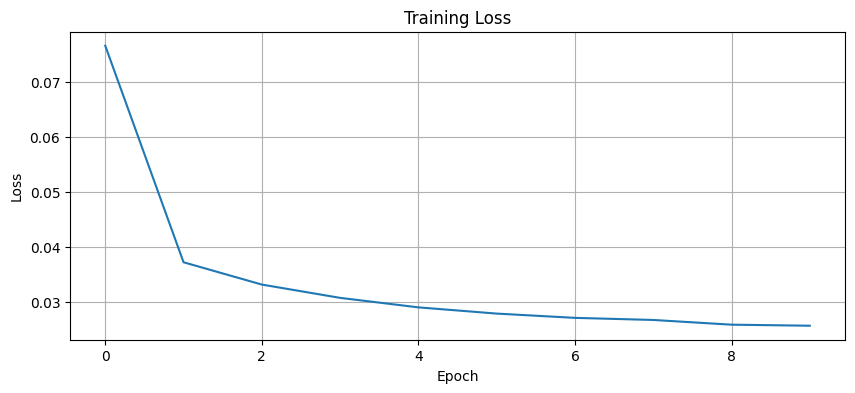

In [14]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

## Part 5: Sampling (Image Generation)

To generate images, we start from pure noise and iteratively denoise using our trained model.

The sampling process (simplified DDPM):
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right) + \sigma_t z$$

Where $z \sim \mathcal{N}(0, I)$ and $\sigma_t = \sqrt{\beta_t}$

### IMPLEMENTATION REQUIRED - Implement the `sample_step` function

Complete the sampling step to denoise from $x_t$ to $x_{t-1}$.

In [15]:
@torch.no_grad()
def sample_step(model, x_t, t, scheduler):
    """
    Perform one denoising step: x_t -> x_{t-1}
    """
    beta_t = scheduler.betas[t]
    alpha_t = scheduler.alphas[t]
    alpha_cumprod_t = scheduler.alpha_cumprods[t]
    sqrt_one_minus_alpha_cumprod_t = scheduler.sqrt_one_minus_alpha_cumprods[t]

    batch_size = x_t.shape[0]
    t_tensor = torch.full((batch_size,), t, device=x_t.device, dtype=torch.long)
    pred_noise = model(x_t, t_tensor)

    noise_coeff = beta_t / torch.sqrt(1 - alpha_cumprod_t)
    mean = (x_t - noise_coeff * pred_noise) / torch.sqrt(alpha_t)

    if t > 0:
        noise = torch.randn_like(x_t)
        sigma = torch.sqrt(beta_t)
        x_t_minus_1 = mean + sigma * noise
    else:
        x_t_minus_1 = mean

    return x_t_minus_1


In [16]:
@torch.no_grad()
def sample(model, scheduler, config, num_samples=16):
    """
    Generate samples by iteratively denoising from pure noise.
    """
    model.eval()
    
    # Start from pure noise
    x = torch.randn(num_samples, config.in_channels, config.image_size, config.image_size).to(config.device)
    
    # Iteratively denoise
    for t in tqdm(range(config.num_timesteps - 1, -1, -1), desc="Sampling"):
        x = sample_step(model, x, t, scheduler)
    
    # Clamp to [-1, 1] and convert to [0, 1] for visualization
    x = torch.clamp(x, -1, 1)
    x = (x + 1) / 2
    
    return x

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling:   0%|          | 2/1000 [00:00<01:28, 11.30it/s]

Sampling:   0%|          | 4/1000 [00:00<01:33, 10.65it/s]

Sampling:   1%|          | 6/1000 [00:00<01:35, 10.44it/s]

Sampling:   1%|          | 8/1000 [00:00<01:41,  9.82it/s]

Sampling:   1%|          | 9/1000 [00:00<01:41,  9.74it/s]

Sampling:   1%|          | 11/1000 [00:01<01:37, 10.10it/s]

Sampling:   1%|▏         | 13/1000 [00:01<01:36, 10.21it/s]

Sampling:   2%|▏         | 15/1000 [00:01<01:42,  9.66it/s]

Sampling:   2%|▏         | 16/1000 [00:01<01:43,  9.55it/s]

Sampling:   2%|▏         | 17/1000 [00:01<01:43,  9.54it/s]

Sampling:   2%|▏         | 19/1000 [00:01<01:40,  9.75it/s]

Sampling:   2%|▏         | 20/1000 [00:02<01:40,  9.78it/s]

Sampling:   2%|▏         | 21/1000 [00:02<01:47,  9.09it/s]

Sampling:   2%|▏         | 22/1000 [00:02<01:50,  8.87it/s]

Sampling:   2%|▏         | 23/1000 [00:02<01:48,  8.98it/s]

Sampling:   2%|▎         | 25/1000 [00:02<01:41,  9.63it/s]

Sampling:   3%|▎         | 27/1000 [00:02<01:39,  9.81it/s]

Sampling:   3%|▎         | 28/1000 [00:02<01:41,  9.54it/s]

Sampling:   3%|▎         | 29/1000 [00:03<01:50,  8.80it/s]

Sampling:   3%|▎         | 30/1000 [00:03<01:47,  9.02it/s]

Sampling:   3%|▎         | 32/1000 [00:03<01:41,  9.52it/s]

Sampling:   3%|▎         | 33/1000 [00:03<01:44,  9.29it/s]

Sampling:   3%|▎         | 34/1000 [00:03<01:57,  8.23it/s]

Sampling:   4%|▎         | 35/1000 [00:03<02:11,  7.35it/s]

Sampling:   4%|▎         | 36/1000 [00:03<02:02,  7.90it/s]

Sampling:   4%|▎         | 37/1000 [00:03<01:59,  8.09it/s]

Sampling:   4%|▍         | 39/1000 [00:04<01:48,  8.85it/s]

Sampling:   4%|▍         | 40/1000 [00:04<02:33,  6.25it/s]

Sampling:   4%|▍         | 41/1000 [00:04<02:43,  5.88it/s]

Sampling:   4%|▍         | 42/1000 [00:04<02:39,  6.00it/s]

Sampling:   4%|▍         | 43/1000 [00:04<02:27,  6.47it/s]

Sampling:   4%|▍         | 44/1000 [00:05<02:26,  6.52it/s]

Sampling:   4%|▍         | 45/1000 [00:05<02:19,  6.84it/s]

Sampling:   5%|▍         | 47/1000 [00:05<02:00,  7.94it/s]

Sampling:   5%|▍         | 48/1000 [00:05<01:56,  8.17it/s]

Sampling:   5%|▍         | 49/1000 [00:05<01:52,  8.45it/s]

Sampling:   5%|▌         | 50/1000 [00:05<01:48,  8.72it/s]

Sampling:   5%|▌         | 51/1000 [00:05<01:53,  8.33it/s]

Sampling:   5%|▌         | 52/1000 [00:06<01:58,  7.98it/s]

Sampling:   5%|▌         | 53/1000 [00:06<02:04,  7.62it/s]

Sampling:   5%|▌         | 54/1000 [00:06<02:08,  7.36it/s]

Sampling:   6%|▌         | 55/1000 [00:06<01:59,  7.93it/s]

Sampling:   6%|▌         | 57/1000 [00:06<01:50,  8.54it/s]

Sampling:   6%|▌         | 58/1000 [00:06<01:49,  8.58it/s]

Sampling:   6%|▌         | 59/1000 [00:06<01:45,  8.90it/s]

Sampling:   6%|▌         | 61/1000 [00:07<01:48,  8.64it/s]

Sampling:   6%|▌         | 62/1000 [00:07<01:52,  8.36it/s]

Sampling:   6%|▋         | 63/1000 [00:07<01:53,  8.29it/s]

Sampling:   6%|▋         | 64/1000 [00:07<01:54,  8.18it/s]

Sampling:   6%|▋         | 65/1000 [00:07<01:52,  8.28it/s]

Sampling:   7%|▋         | 67/1000 [00:07<01:41,  9.23it/s]

Sampling:   7%|▋         | 69/1000 [00:07<01:35,  9.77it/s]

Sampling:   7%|▋         | 71/1000 [00:08<01:32, 10.03it/s]

Sampling:   7%|▋         | 72/1000 [00:08<01:37,  9.51it/s]

Sampling:   7%|▋         | 73/1000 [00:08<01:37,  9.50it/s]

Sampling:   7%|▋         | 74/1000 [00:08<01:50,  8.38it/s]

Sampling:   8%|▊         | 75/1000 [00:08<01:49,  8.46it/s]

Sampling:   8%|▊         | 77/1000 [00:08<01:38,  9.39it/s]

Sampling:   8%|▊         | 79/1000 [00:09<01:33,  9.88it/s]

Sampling:   8%|▊         | 81/1000 [00:09<01:30, 10.13it/s]

Sampling:   8%|▊         | 82/1000 [00:09<01:30, 10.09it/s]

Sampling:   8%|▊         | 83/1000 [00:09<01:36,  9.51it/s]

Sampling:   8%|▊         | 84/1000 [00:09<01:40,  9.11it/s]

Sampling:   8%|▊         | 85/1000 [00:09<01:53,  8.04it/s]

Sampling:   9%|▊         | 86/1000 [00:09<01:50,  8.28it/s]

Sampling:   9%|▉         | 88/1000 [00:10<01:39,  9.21it/s]

Sampling:   9%|▉         | 90/1000 [00:10<01:32,  9.83it/s]

Sampling:   9%|▉         | 92/1000 [00:10<01:29, 10.11it/s]

Sampling:   9%|▉         | 93/1000 [00:10<01:39,  9.13it/s]

Sampling:   9%|▉         | 94/1000 [00:10<01:39,  9.11it/s]

Sampling:  10%|▉         | 95/1000 [00:10<01:51,  8.13it/s]

Sampling:  10%|▉         | 96/1000 [00:10<01:46,  8.52it/s]

Sampling:  10%|▉         | 98/1000 [00:11<01:36,  9.36it/s]

Sampling:  10%|█         | 100/1000 [00:11<01:32,  9.74it/s]

Sampling:  10%|█         | 101/1000 [00:11<01:31,  9.78it/s]

Sampling:  10%|█         | 103/1000 [00:11<01:26, 10.33it/s]

Sampling:  10%|█         | 105/1000 [00:11<01:22, 10.81it/s]

Sampling:  11%|█         | 107/1000 [00:11<01:26, 10.38it/s]

Sampling:  11%|█         | 109/1000 [00:12<01:27, 10.21it/s]

Sampling:  11%|█         | 111/1000 [00:12<01:32,  9.58it/s]

Sampling:  11%|█         | 112/1000 [00:12<01:32,  9.61it/s]

Sampling:  11%|█▏        | 114/1000 [00:12<01:29,  9.87it/s]

Sampling:  12%|█▏        | 116/1000 [00:12<01:30,  9.73it/s]

Sampling:  12%|█▏        | 117/1000 [00:13<01:33,  9.43it/s]

Sampling:  12%|█▏        | 118/1000 [00:13<01:35,  9.27it/s]

Sampling:  12%|█▏        | 120/1000 [00:13<01:31,  9.64it/s]

Sampling:  12%|█▏        | 122/1000 [00:13<01:28,  9.97it/s]

Sampling:  12%|█▏        | 123/1000 [00:13<01:31,  9.61it/s]

Sampling:  12%|█▏        | 124/1000 [00:13<01:32,  9.50it/s]

Sampling:  12%|█▎        | 125/1000 [00:13<01:33,  9.32it/s]

Sampling:  13%|█▎        | 127/1000 [00:14<01:27,  9.92it/s]

Sampling:  13%|█▎        | 129/1000 [00:14<01:25, 10.13it/s]

Sampling:  13%|█▎        | 130/1000 [00:14<01:28,  9.84it/s]

Sampling:  13%|█▎        | 131/1000 [00:14<01:29,  9.71it/s]

Sampling:  13%|█▎        | 132/1000 [00:14<01:35,  9.13it/s]

Sampling:  13%|█▎        | 134/1000 [00:14<02:02,  7.10it/s]

Sampling:  14%|█▎        | 135/1000 [00:15<01:54,  7.53it/s]

Sampling:  14%|█▎        | 136/1000 [00:15<01:50,  7.85it/s]

Sampling:  14%|█▎        | 137/1000 [00:15<01:50,  7.80it/s]

Sampling:  14%|█▍        | 138/1000 [00:15<01:49,  7.88it/s]

Sampling:  14%|█▍        | 139/1000 [00:15<01:43,  8.29it/s]

Sampling:  14%|█▍        | 141/1000 [00:15<01:33,  9.14it/s]

Sampling:  14%|█▍        | 142/1000 [00:15<01:32,  9.28it/s]

Sampling:  14%|█▍        | 143/1000 [00:15<01:37,  8.79it/s]

Sampling:  14%|█▍        | 144/1000 [00:16<01:41,  8.42it/s]

Sampling:  14%|█▍        | 145/1000 [00:16<01:37,  8.77it/s]

Sampling:  15%|█▍        | 146/1000 [00:16<01:48,  7.84it/s]

Sampling:  15%|█▍        | 147/1000 [00:16<01:43,  8.27it/s]

Sampling:  15%|█▍        | 148/1000 [00:16<01:52,  7.60it/s]

Sampling:  15%|█▍        | 149/1000 [00:16<01:47,  7.90it/s]

Sampling:  15%|█▌        | 151/1000 [00:16<01:34,  8.96it/s]

Sampling:  15%|█▌        | 153/1000 [00:17<01:29,  9.46it/s]

Sampling:  15%|█▌        | 154/1000 [00:17<01:28,  9.53it/s]

Sampling:  16%|█▌        | 155/1000 [00:17<01:30,  9.32it/s]

Sampling:  16%|█▌        | 156/1000 [00:17<01:39,  8.50it/s]

Sampling:  16%|█▌        | 157/1000 [00:17<01:36,  8.72it/s]

Sampling:  16%|█▌        | 158/1000 [00:17<01:40,  8.37it/s]

Sampling:  16%|█▌        | 159/1000 [00:17<01:37,  8.64it/s]

Sampling:  16%|█▌        | 161/1000 [00:18<01:25,  9.83it/s]

Sampling:  16%|█▋        | 163/1000 [00:18<01:21, 10.26it/s]

Sampling:  16%|█▋        | 165/1000 [00:18<01:19, 10.45it/s]

Sampling:  17%|█▋        | 167/1000 [00:18<01:29,  9.31it/s]

Sampling:  17%|█▋        | 168/1000 [00:18<01:29,  9.26it/s]

Sampling:  17%|█▋        | 169/1000 [00:18<01:33,  8.92it/s]

Sampling:  17%|█▋        | 170/1000 [00:18<01:31,  9.08it/s]

Sampling:  17%|█▋        | 172/1000 [00:19<01:24,  9.84it/s]

Sampling:  17%|█▋        | 174/1000 [00:19<01:19, 10.37it/s]

Sampling:  18%|█▊        | 176/1000 [00:19<01:17, 10.58it/s]

Sampling:  18%|█▊        | 178/1000 [00:19<01:25,  9.60it/s]

Sampling:  18%|█▊        | 179/1000 [00:19<01:26,  9.47it/s]

Sampling:  18%|█▊        | 180/1000 [00:20<01:30,  9.05it/s]

Sampling:  18%|█▊        | 181/1000 [00:20<01:29,  9.19it/s]

Sampling:  18%|█▊        | 182/1000 [00:20<01:59,  6.84it/s]

Sampling:  18%|█▊        | 183/1000 [00:20<02:05,  6.52it/s]

Sampling:  18%|█▊        | 184/1000 [00:20<02:01,  6.70it/s]

Sampling:  18%|█▊        | 185/1000 [00:20<01:54,  7.13it/s]

Sampling:  19%|█▊        | 186/1000 [00:20<01:47,  7.54it/s]

Sampling:  19%|█▊        | 187/1000 [00:21<01:49,  7.45it/s]

Sampling:  19%|█▉        | 188/1000 [00:21<01:54,  7.11it/s]

Sampling:  19%|█▉        | 189/1000 [00:21<01:52,  7.21it/s]

Sampling:  19%|█▉        | 190/1000 [00:21<02:07,  6.37it/s]

Sampling:  19%|█▉        | 191/1000 [00:21<02:01,  6.64it/s]

Sampling:  19%|█▉        | 192/1000 [00:21<01:58,  6.84it/s]

Sampling:  19%|█▉        | 193/1000 [00:21<01:51,  7.26it/s]

Sampling:  19%|█▉        | 194/1000 [00:22<01:47,  7.52it/s]

Sampling:  20%|█▉        | 195/1000 [00:22<01:44,  7.71it/s]

Sampling:  20%|█▉        | 196/1000 [00:22<01:41,  7.90it/s]

Sampling:  20%|█▉        | 197/1000 [00:22<01:43,  7.75it/s]

Sampling:  20%|█▉        | 198/1000 [00:22<01:59,  6.68it/s]

Sampling:  20%|█▉        | 199/1000 [00:22<01:57,  6.83it/s]

Sampling:  20%|██        | 200/1000 [00:22<02:06,  6.30it/s]

Sampling:  20%|██        | 201/1000 [00:23<02:02,  6.54it/s]

Sampling:  20%|██        | 202/1000 [00:23<01:54,  6.98it/s]

Sampling:  20%|██        | 203/1000 [00:23<01:48,  7.35it/s]

Sampling:  20%|██        | 204/1000 [00:23<01:45,  7.55it/s]

Sampling:  20%|██        | 205/1000 [00:23<01:41,  7.80it/s]

Sampling:  21%|██        | 206/1000 [00:23<01:39,  7.97it/s]

Sampling:  21%|██        | 207/1000 [00:23<01:34,  8.41it/s]

Sampling:  21%|██        | 209/1000 [00:23<01:26,  9.09it/s]

Sampling:  21%|██        | 210/1000 [00:24<01:31,  8.68it/s]

Sampling:  21%|██        | 211/1000 [00:24<01:32,  8.54it/s]

Sampling:  21%|██        | 212/1000 [00:24<01:34,  8.36it/s]

Sampling:  21%|██▏       | 213/1000 [00:24<01:36,  8.17it/s]

Sampling:  21%|██▏       | 214/1000 [00:24<01:44,  7.55it/s]

Sampling:  22%|██▏       | 215/1000 [00:24<01:51,  7.07it/s]

Sampling:  22%|██▏       | 216/1000 [00:24<01:51,  7.02it/s]

Sampling:  22%|██▏       | 217/1000 [00:25<01:46,  7.32it/s]

Sampling:  22%|██▏       | 218/1000 [00:25<01:45,  7.43it/s]

Sampling:  22%|██▏       | 219/1000 [00:25<01:42,  7.61it/s]

Sampling:  22%|██▏       | 220/1000 [00:25<01:40,  7.73it/s]

Sampling:  22%|██▏       | 221/1000 [00:25<01:47,  7.25it/s]

Sampling:  22%|██▏       | 222/1000 [00:25<01:51,  6.96it/s]

Sampling:  22%|██▏       | 223/1000 [00:25<01:45,  7.38it/s]

Sampling:  22%|██▏       | 224/1000 [00:26<01:47,  7.25it/s]

Sampling:  22%|██▎       | 225/1000 [00:26<01:46,  7.26it/s]

Sampling:  23%|██▎       | 226/1000 [00:26<01:44,  7.38it/s]

Sampling:  23%|██▎       | 227/1000 [00:26<01:45,  7.34it/s]

Sampling:  23%|██▎       | 228/1000 [00:26<01:49,  7.08it/s]

Sampling:  23%|██▎       | 229/1000 [00:26<01:58,  6.53it/s]

Sampling:  23%|██▎       | 230/1000 [00:26<01:54,  6.72it/s]

Sampling:  23%|██▎       | 231/1000 [00:27<02:42,  4.72it/s]

Sampling:  23%|██▎       | 232/1000 [00:27<02:23,  5.36it/s]

Sampling:  23%|██▎       | 233/1000 [00:27<02:23,  5.36it/s]

Sampling:  23%|██▎       | 234/1000 [00:27<02:12,  5.77it/s]

Sampling:  24%|██▎       | 235/1000 [00:27<02:05,  6.10it/s]

Sampling:  24%|██▎       | 236/1000 [00:28<01:54,  6.65it/s]

Sampling:  24%|██▎       | 237/1000 [00:28<01:47,  7.07it/s]

Sampling:  24%|██▍       | 238/1000 [00:28<01:42,  7.45it/s]

Sampling:  24%|██▍       | 239/1000 [00:28<01:38,  7.72it/s]

Sampling:  24%|██▍       | 240/1000 [00:28<01:48,  7.03it/s]

Sampling:  24%|██▍       | 241/1000 [00:28<01:49,  6.92it/s]

Sampling:  24%|██▍       | 242/1000 [00:28<01:44,  7.25it/s]

Sampling:  24%|██▍       | 243/1000 [00:28<01:40,  7.56it/s]

Sampling:  24%|██▍       | 244/1000 [00:29<01:38,  7.65it/s]

Sampling:  24%|██▍       | 245/1000 [00:29<01:37,  7.72it/s]

Sampling:  25%|██▍       | 246/1000 [00:29<01:36,  7.80it/s]

Sampling:  25%|██▍       | 247/1000 [00:29<01:42,  7.33it/s]

Sampling:  25%|██▍       | 248/1000 [00:29<01:49,  6.88it/s]

Sampling:  25%|██▍       | 249/1000 [00:29<01:46,  7.02it/s]

Sampling:  25%|██▌       | 250/1000 [00:29<01:54,  6.57it/s]

Sampling:  25%|██▌       | 251/1000 [00:30<02:05,  5.98it/s]

Sampling:  25%|██▌       | 252/1000 [00:30<02:06,  5.92it/s]

Sampling:  25%|██▌       | 253/1000 [00:30<01:55,  6.46it/s]

Sampling:  25%|██▌       | 254/1000 [00:30<01:46,  7.03it/s]

Sampling:  26%|██▌       | 255/1000 [00:30<01:40,  7.42it/s]

Sampling:  26%|██▌       | 256/1000 [00:30<01:36,  7.71it/s]

Sampling:  26%|██▌       | 257/1000 [00:30<01:33,  7.95it/s]

Sampling:  26%|██▌       | 258/1000 [00:31<01:29,  8.31it/s]

Sampling:  26%|██▌       | 259/1000 [00:31<01:31,  8.07it/s]

Sampling:  26%|██▌       | 260/1000 [00:31<01:41,  7.28it/s]

Sampling:  26%|██▌       | 261/1000 [00:31<01:36,  7.66it/s]

Sampling:  26%|██▌       | 262/1000 [00:31<01:53,  6.48it/s]

Sampling:  26%|██▋       | 263/1000 [00:31<01:50,  6.69it/s]

Sampling:  26%|██▋       | 264/1000 [00:31<01:45,  7.00it/s]

Sampling:  26%|██▋       | 265/1000 [00:32<01:40,  7.30it/s]

Sampling:  27%|██▋       | 266/1000 [00:32<01:37,  7.51it/s]

Sampling:  27%|██▋       | 267/1000 [00:32<01:36,  7.62it/s]

Sampling:  27%|██▋       | 268/1000 [00:32<02:09,  5.63it/s]

Sampling:  27%|██▋       | 269/1000 [00:32<03:08,  3.88it/s]

Sampling:  27%|██▋       | 270/1000 [00:33<02:55,  4.16it/s]

Sampling:  27%|██▋       | 271/1000 [00:33<02:44,  4.44it/s]

Sampling:  27%|██▋       | 272/1000 [00:33<02:23,  5.07it/s]

Sampling:  27%|██▋       | 273/1000 [00:33<02:04,  5.82it/s]

Sampling:  27%|██▋       | 274/1000 [00:33<01:54,  6.32it/s]

Sampling:  28%|██▊       | 275/1000 [00:33<01:48,  6.69it/s]

Sampling:  28%|██▊       | 276/1000 [00:34<01:41,  7.13it/s]

Sampling:  28%|██▊       | 277/1000 [00:34<01:36,  7.47it/s]

Sampling:  28%|██▊       | 278/1000 [00:34<01:34,  7.62it/s]

Sampling:  28%|██▊       | 279/1000 [00:34<01:41,  7.10it/s]

Sampling:  28%|██▊       | 280/1000 [00:34<01:40,  7.14it/s]

Sampling:  28%|██▊       | 281/1000 [00:34<01:49,  6.54it/s]

Sampling:  28%|██▊       | 282/1000 [00:34<01:45,  6.84it/s]

Sampling:  28%|██▊       | 283/1000 [00:34<01:38,  7.25it/s]

Sampling:  28%|██▊       | 284/1000 [00:35<01:35,  7.50it/s]

Sampling:  28%|██▊       | 285/1000 [00:35<01:42,  6.97it/s]

Sampling:  29%|██▊       | 286/1000 [00:35<01:38,  7.28it/s]

Sampling:  29%|██▊       | 287/1000 [00:35<01:35,  7.47it/s]

Sampling:  29%|██▉       | 288/1000 [00:35<01:38,  7.23it/s]

Sampling:  29%|██▉       | 289/1000 [00:35<01:48,  6.57it/s]

Sampling:  29%|██▉       | 290/1000 [00:35<01:41,  6.97it/s]

Sampling:  29%|██▉       | 291/1000 [00:36<01:44,  6.77it/s]

Sampling:  29%|██▉       | 292/1000 [00:36<01:41,  6.96it/s]

Sampling:  29%|██▉       | 293/1000 [00:36<01:36,  7.31it/s]

Sampling:  29%|██▉       | 294/1000 [00:36<01:31,  7.73it/s]

Sampling:  30%|██▉       | 295/1000 [00:36<01:28,  7.93it/s]

Sampling:  30%|██▉       | 296/1000 [00:36<01:26,  8.10it/s]

Sampling:  30%|██▉       | 297/1000 [00:36<01:26,  8.15it/s]

Sampling:  30%|██▉       | 298/1000 [00:36<01:27,  8.04it/s]

Sampling:  30%|██▉       | 299/1000 [00:37<01:33,  7.48it/s]

Sampling:  30%|███       | 300/1000 [00:37<01:41,  6.90it/s]

Sampling:  30%|███       | 301/1000 [00:37<01:41,  6.90it/s]

Sampling:  30%|███       | 302/1000 [00:37<01:51,  6.24it/s]

Sampling:  30%|███       | 303/1000 [00:37<01:43,  6.74it/s]

Sampling:  30%|███       | 304/1000 [00:37<01:35,  7.31it/s]

Sampling:  30%|███       | 305/1000 [00:38<01:33,  7.43it/s]

Sampling:  31%|███       | 306/1000 [00:38<01:29,  7.73it/s]

Sampling:  31%|███       | 307/1000 [00:38<01:26,  8.05it/s]

Sampling:  31%|███       | 308/1000 [00:38<01:23,  8.27it/s]

Sampling:  31%|███       | 309/1000 [00:38<01:19,  8.69it/s]

Sampling:  31%|███       | 311/1000 [00:38<01:13,  9.40it/s]

Sampling:  31%|███       | 312/1000 [00:38<01:15,  9.08it/s]

Sampling:  31%|███▏      | 313/1000 [00:38<01:18,  8.73it/s]

Sampling:  31%|███▏      | 314/1000 [00:39<01:21,  8.44it/s]

Sampling:  32%|███▏      | 315/1000 [00:39<01:37,  7.03it/s]

Sampling:  32%|███▏      | 316/1000 [00:39<01:37,  7.00it/s]

Sampling:  32%|███▏      | 317/1000 [00:39<01:43,  6.60it/s]

Sampling:  32%|███▏      | 318/1000 [00:39<01:39,  6.82it/s]

Sampling:  32%|███▏      | 319/1000 [00:39<01:38,  6.95it/s]

Sampling:  32%|███▏      | 320/1000 [00:39<01:31,  7.41it/s]

Sampling:  32%|███▏      | 321/1000 [00:40<01:31,  7.43it/s]

Sampling:  32%|███▏      | 322/1000 [00:40<01:40,  6.77it/s]

Sampling:  32%|███▏      | 323/1000 [00:40<02:16,  4.97it/s]

Sampling:  32%|███▏      | 324/1000 [00:40<01:57,  5.76it/s]

Sampling:  33%|███▎      | 326/1000 [00:40<01:34,  7.16it/s]

Sampling:  33%|███▎      | 327/1000 [00:41<01:31,  7.35it/s]

Sampling:  33%|███▎      | 328/1000 [00:41<01:28,  7.56it/s]

Sampling:  33%|███▎      | 329/1000 [00:41<01:23,  8.07it/s]

Sampling:  33%|███▎      | 331/1000 [00:41<01:13,  9.11it/s]

Sampling:  33%|███▎      | 333/1000 [00:41<01:12,  9.23it/s]

Sampling:  33%|███▎      | 334/1000 [00:41<01:13,  9.12it/s]

Sampling:  34%|███▎      | 335/1000 [00:41<01:14,  8.90it/s]

Sampling:  34%|███▎      | 337/1000 [00:42<01:08,  9.62it/s]

Sampling:  34%|███▍      | 339/1000 [00:42<01:05, 10.03it/s]

Sampling:  34%|███▍      | 340/1000 [00:42<01:09,  9.47it/s]

Sampling:  34%|███▍      | 341/1000 [00:42<01:13,  9.00it/s]

Sampling:  34%|███▍      | 343/1000 [00:42<01:07,  9.74it/s]

Sampling:  34%|███▍      | 345/1000 [00:42<01:05, 10.07it/s]

Sampling:  35%|███▍      | 346/1000 [00:42<01:09,  9.38it/s]

Sampling:  35%|███▍      | 347/1000 [00:43<01:08,  9.48it/s]

Sampling:  35%|███▍      | 348/1000 [00:43<01:10,  9.21it/s]

Sampling:  35%|███▍      | 349/1000 [00:43<01:13,  8.91it/s]

Sampling:  35%|███▌      | 350/1000 [00:43<01:12,  8.95it/s]

Sampling:  35%|███▌      | 351/1000 [00:43<01:16,  8.48it/s]

Sampling:  35%|███▌      | 352/1000 [00:43<01:16,  8.45it/s]

Sampling:  35%|███▌      | 354/1000 [00:43<01:06,  9.77it/s]

Sampling:  36%|███▌      | 355/1000 [00:43<01:08,  9.38it/s]

Sampling:  36%|███▌      | 357/1000 [00:44<01:03, 10.13it/s]

Sampling:  36%|███▌      | 359/1000 [00:44<01:04,  9.99it/s]

Sampling:  36%|███▌      | 360/1000 [00:44<01:07,  9.42it/s]

Sampling:  36%|███▌      | 361/1000 [00:44<01:08,  9.30it/s]

Sampling:  36%|███▌      | 362/1000 [00:44<01:10,  9.03it/s]

Sampling:  36%|███▋      | 363/1000 [00:44<01:09,  9.16it/s]

Sampling:  36%|███▋      | 365/1000 [00:44<01:02, 10.20it/s]

Sampling:  37%|███▋      | 367/1000 [00:45<00:59, 10.63it/s]

Sampling:  37%|███▋      | 369/1000 [00:45<00:56, 11.18it/s]

Sampling:  37%|███▋      | 371/1000 [00:45<01:00, 10.40it/s]

Sampling:  37%|███▋      | 373/1000 [00:45<01:03,  9.84it/s]

Sampling:  37%|███▋      | 374/1000 [00:45<01:03,  9.86it/s]

Sampling:  38%|███▊      | 376/1000 [00:46<01:00, 10.33it/s]

Sampling:  38%|███▊      | 378/1000 [00:46<00:58, 10.69it/s]

Sampling:  38%|███▊      | 380/1000 [00:46<00:55, 11.21it/s]

Sampling:  38%|███▊      | 382/1000 [00:46<01:00, 10.21it/s]

Sampling:  38%|███▊      | 384/1000 [00:46<01:02,  9.81it/s]

Sampling:  39%|███▊      | 386/1000 [00:47<01:00, 10.17it/s]

Sampling:  39%|███▉      | 388/1000 [00:47<00:56, 10.76it/s]

Sampling:  39%|███▉      | 390/1000 [00:47<00:56, 10.85it/s]

Sampling:  39%|███▉      | 392/1000 [00:47<00:58, 10.45it/s]

Sampling:  39%|███▉      | 394/1000 [00:47<01:02,  9.77it/s]

Sampling:  40%|███▉      | 395/1000 [00:47<01:05,  9.29it/s]

Sampling:  40%|███▉      | 397/1000 [00:48<01:01,  9.73it/s]

Sampling:  40%|███▉      | 399/1000 [00:48<00:59, 10.12it/s]

Sampling:  40%|████      | 401/1000 [00:48<00:58, 10.18it/s]

Sampling:  40%|████      | 403/1000 [00:48<00:59, 10.04it/s]

Sampling:  40%|████      | 405/1000 [00:48<01:03,  9.44it/s]

Sampling:  41%|████      | 406/1000 [00:49<01:04,  9.17it/s]

Sampling:  41%|████      | 407/1000 [00:49<01:03,  9.27it/s]

Sampling:  41%|████      | 408/1000 [00:49<01:22,  7.16it/s]

Sampling:  41%|████      | 410/1000 [00:49<01:11,  8.23it/s]

Sampling:  41%|████      | 412/1000 [00:49<01:04,  9.12it/s]

Sampling:  41%|████▏     | 414/1000 [00:49<00:58, 10.03it/s]

Sampling:  42%|████▏     | 416/1000 [00:50<00:56, 10.39it/s]

Sampling:  42%|████▏     | 418/1000 [00:50<00:54, 10.63it/s]

Sampling:  42%|████▏     | 420/1000 [00:50<00:55, 10.47it/s]

Sampling:  42%|████▏     | 422/1000 [00:50<00:59,  9.75it/s]

Sampling:  42%|████▏     | 424/1000 [00:50<00:58,  9.89it/s]

Sampling:  43%|████▎     | 426/1000 [00:51<00:56, 10.20it/s]

Sampling:  43%|████▎     | 428/1000 [00:51<00:58,  9.80it/s]

Sampling:  43%|████▎     | 429/1000 [00:51<01:01,  9.32it/s]

Sampling:  43%|████▎     | 431/1000 [00:51<00:58,  9.73it/s]

Sampling:  43%|████▎     | 432/1000 [00:51<00:58,  9.69it/s]

Sampling:  43%|████▎     | 433/1000 [00:51<01:02,  9.11it/s]

Sampling:  43%|████▎     | 434/1000 [00:52<01:04,  8.82it/s]

Sampling:  44%|████▎     | 435/1000 [00:52<01:05,  8.60it/s]

Sampling:  44%|████▎     | 437/1000 [00:52<01:00,  9.34it/s]

Sampling:  44%|████▍     | 439/1000 [00:52<00:58,  9.52it/s]

Sampling:  44%|████▍     | 440/1000 [00:52<01:13,  7.59it/s]

Sampling:  44%|████▍     | 441/1000 [00:52<01:15,  7.44it/s]

Sampling:  44%|████▍     | 442/1000 [00:53<01:11,  7.79it/s]

Sampling:  44%|████▍     | 443/1000 [00:53<01:08,  8.11it/s]

Sampling:  44%|████▍     | 444/1000 [00:53<01:05,  8.53it/s]

Sampling:  44%|████▍     | 445/1000 [00:53<01:03,  8.73it/s]

Sampling:  45%|████▍     | 446/1000 [00:53<01:07,  8.21it/s]

Sampling:  45%|████▍     | 447/1000 [00:53<01:06,  8.31it/s]

Sampling:  45%|████▍     | 448/1000 [00:53<01:06,  8.27it/s]

Sampling:  45%|████▍     | 449/1000 [00:53<01:04,  8.55it/s]

Sampling:  45%|████▌     | 450/1000 [00:53<01:02,  8.75it/s]

Sampling:  45%|████▌     | 451/1000 [00:54<01:01,  8.94it/s]

Sampling:  45%|████▌     | 452/1000 [00:54<01:06,  8.24it/s]

Sampling:  45%|████▌     | 453/1000 [00:54<01:10,  7.81it/s]

Sampling:  45%|████▌     | 454/1000 [00:54<01:08,  7.93it/s]

Sampling:  46%|████▌     | 455/1000 [00:54<01:14,  7.30it/s]

Sampling:  46%|████▌     | 456/1000 [00:54<01:13,  7.35it/s]

Sampling:  46%|████▌     | 457/1000 [00:54<01:12,  7.45it/s]

Sampling:  46%|████▌     | 458/1000 [00:54<01:08,  7.93it/s]

Sampling:  46%|████▌     | 459/1000 [00:55<01:15,  7.18it/s]

Sampling:  46%|████▌     | 460/1000 [00:55<01:16,  7.06it/s]

Sampling:  46%|████▌     | 461/1000 [00:55<01:19,  6.82it/s]

Sampling:  46%|████▌     | 462/1000 [00:55<01:32,  5.84it/s]

Sampling:  46%|████▋     | 463/1000 [00:56<02:00,  4.45it/s]

Sampling:  46%|████▋     | 464/1000 [00:56<01:51,  4.82it/s]

Sampling:  46%|████▋     | 465/1000 [00:56<01:39,  5.38it/s]

Sampling:  47%|████▋     | 466/1000 [00:56<01:33,  5.71it/s]

Sampling:  47%|████▋     | 467/1000 [00:56<01:32,  5.75it/s]

Sampling:  47%|████▋     | 468/1000 [00:56<01:27,  6.08it/s]

Sampling:  47%|████▋     | 469/1000 [00:57<02:02,  4.34it/s]

Sampling:  47%|████▋     | 470/1000 [00:57<01:53,  4.69it/s]

Sampling:  47%|████▋     | 471/1000 [00:57<01:35,  5.51it/s]

Sampling:  47%|████▋     | 473/1000 [00:57<01:15,  6.96it/s]

Sampling:  47%|████▋     | 474/1000 [00:57<01:10,  7.41it/s]

Sampling:  48%|████▊     | 475/1000 [00:57<01:07,  7.72it/s]

Sampling:  48%|████▊     | 477/1000 [00:58<01:04,  8.09it/s]

Sampling:  48%|████▊     | 478/1000 [00:58<01:01,  8.45it/s]

Sampling:  48%|████▊     | 479/1000 [00:58<01:05,  8.01it/s]

Sampling:  48%|████▊     | 480/1000 [00:58<01:24,  6.16it/s]

Sampling:  48%|████▊     | 482/1000 [00:58<01:07,  7.70it/s]

Sampling:  48%|████▊     | 484/1000 [00:58<00:59,  8.72it/s]

Sampling:  49%|████▊     | 486/1000 [00:59<00:54,  9.47it/s]

Sampling:  49%|████▊     | 487/1000 [00:59<00:57,  8.88it/s]

Sampling:  49%|████▉     | 488/1000 [00:59<00:59,  8.67it/s]

Sampling:  49%|████▉     | 489/1000 [00:59<01:01,  8.28it/s]

Sampling:  49%|████▉     | 491/1000 [00:59<00:56,  9.08it/s]

Sampling:  49%|████▉     | 493/1000 [00:59<00:51,  9.90it/s]

Sampling:  50%|████▉     | 495/1000 [01:00<00:48, 10.47it/s]

Sampling:  50%|████▉     | 497/1000 [01:00<00:48, 10.39it/s]

Sampling:  50%|████▉     | 499/1000 [01:00<00:51,  9.72it/s]

Sampling:  50%|█████     | 500/1000 [01:00<00:54,  9.15it/s]

Sampling:  50%|█████     | 502/1000 [01:00<00:51,  9.64it/s]

Sampling:  50%|█████     | 504/1000 [01:01<00:49, 10.07it/s]

Sampling:  51%|█████     | 506/1000 [01:01<00:47, 10.38it/s]

Sampling:  51%|█████     | 508/1000 [01:01<00:45, 10.79it/s]

Sampling:  51%|█████     | 510/1000 [01:01<00:44, 10.98it/s]

Sampling:  51%|█████     | 512/1000 [01:01<00:44, 10.87it/s]

Sampling:  51%|█████▏    | 514/1000 [01:01<00:49,  9.88it/s]

Sampling:  52%|█████▏    | 516/1000 [01:02<00:53,  9.04it/s]

Sampling:  52%|█████▏    | 517/1000 [01:02<00:53,  8.99it/s]

Sampling:  52%|█████▏    | 518/1000 [01:02<00:53,  8.98it/s]

Sampling:  52%|█████▏    | 519/1000 [01:02<00:52,  9.12it/s]

Sampling:  52%|█████▏    | 520/1000 [01:02<00:55,  8.71it/s]

Sampling:  52%|█████▏    | 521/1000 [01:02<00:59,  8.01it/s]

Sampling:  52%|█████▏    | 522/1000 [01:02<00:57,  8.28it/s]

Sampling:  52%|█████▏    | 523/1000 [01:03<00:56,  8.48it/s]

Sampling:  52%|█████▏    | 524/1000 [01:03<00:55,  8.60it/s]

Sampling:  52%|█████▎    | 525/1000 [01:03<00:53,  8.89it/s]

Sampling:  53%|█████▎    | 526/1000 [01:03<01:00,  7.79it/s]

Sampling:  53%|█████▎    | 527/1000 [01:03<00:58,  8.02it/s]

Sampling:  53%|█████▎    | 528/1000 [01:03<00:57,  8.23it/s]

Sampling:  53%|█████▎    | 529/1000 [01:03<00:55,  8.56it/s]

Sampling:  53%|█████▎    | 530/1000 [01:03<00:53,  8.83it/s]

Sampling:  53%|█████▎    | 531/1000 [01:04<00:52,  8.97it/s]

Sampling:  53%|█████▎    | 532/1000 [01:04<00:52,  8.87it/s]

Sampling:  53%|█████▎    | 533/1000 [01:04<00:56,  8.26it/s]

Sampling:  53%|█████▎    | 534/1000 [01:04<00:56,  8.24it/s]

Sampling:  54%|█████▎    | 535/1000 [01:04<00:55,  8.44it/s]

Sampling:  54%|█████▎    | 536/1000 [01:04<00:52,  8.85it/s]

Sampling:  54%|█████▎    | 537/1000 [01:04<00:51,  9.05it/s]

Sampling:  54%|█████▍    | 538/1000 [01:04<00:53,  8.66it/s]

Sampling:  54%|█████▍    | 539/1000 [01:04<00:58,  7.86it/s]

Sampling:  54%|█████▍    | 540/1000 [01:05<00:56,  8.20it/s]

Sampling:  54%|█████▍    | 541/1000 [01:05<00:53,  8.52it/s]

Sampling:  54%|█████▍    | 543/1000 [01:05<00:49,  9.32it/s]

Sampling:  54%|█████▍    | 544/1000 [01:05<00:50,  9.01it/s]

Sampling:  55%|█████▍    | 545/1000 [01:05<00:54,  8.37it/s]

Sampling:  55%|█████▍    | 546/1000 [01:05<00:54,  8.29it/s]

Sampling:  55%|█████▍    | 547/1000 [01:06<01:08,  6.66it/s]

Sampling:  55%|█████▍    | 548/1000 [01:06<01:20,  5.60it/s]

Sampling:  55%|█████▍    | 549/1000 [01:06<01:22,  5.45it/s]

Sampling:  55%|█████▌    | 550/1000 [01:06<01:13,  6.10it/s]

Sampling:  55%|█████▌    | 552/1000 [01:06<00:56,  7.95it/s]

Sampling:  55%|█████▌    | 554/1000 [01:06<00:49,  8.98it/s]

Sampling:  56%|█████▌    | 556/1000 [01:07<00:50,  8.86it/s]

Sampling:  56%|█████▌    | 558/1000 [01:07<01:04,  6.89it/s]

Sampling:  56%|█████▌    | 560/1000 [01:07<00:55,  7.95it/s]

Sampling:  56%|█████▌    | 562/1000 [01:07<00:49,  8.88it/s]

Sampling:  56%|█████▋    | 564/1000 [01:08<00:45,  9.57it/s]

Sampling:  57%|█████▋    | 566/1000 [01:08<00:45,  9.58it/s]

Sampling:  57%|█████▋    | 568/1000 [01:08<00:50,  8.54it/s]

Sampling:  57%|█████▋    | 569/1000 [01:08<00:49,  8.76it/s]

Sampling:  57%|█████▋    | 571/1000 [01:08<00:45,  9.49it/s]

Sampling:  57%|█████▋    | 573/1000 [01:09<00:42, 10.02it/s]

Sampling:  57%|█████▊    | 575/1000 [01:09<00:40, 10.45it/s]

Sampling:  58%|█████▊    | 577/1000 [01:09<00:43,  9.70it/s]

Sampling:  58%|█████▊    | 579/1000 [01:09<00:47,  8.81it/s]

Sampling:  58%|█████▊    | 581/1000 [01:09<00:47,  8.81it/s]

Sampling:  58%|█████▊    | 582/1000 [01:10<00:49,  8.51it/s]

Sampling:  58%|█████▊    | 583/1000 [01:10<00:47,  8.70it/s]

Sampling:  58%|█████▊    | 585/1000 [01:10<00:43,  9.58it/s]

Sampling:  59%|█████▊    | 586/1000 [01:10<00:45,  9.10it/s]

Sampling:  59%|█████▊    | 587/1000 [01:10<00:45,  9.01it/s]

Sampling:  59%|█████▉    | 588/1000 [01:10<00:48,  8.50it/s]

Sampling:  59%|█████▉    | 589/1000 [01:10<00:47,  8.70it/s]

Sampling:  59%|█████▉    | 591/1000 [01:11<00:42,  9.56it/s]

Sampling:  59%|█████▉    | 593/1000 [01:11<00:40, 10.10it/s]

Sampling:  60%|█████▉    | 595/1000 [01:11<00:39, 10.29it/s]

Sampling:  60%|█████▉    | 597/1000 [01:11<00:41,  9.64it/s]

Sampling:  60%|█████▉    | 598/1000 [01:11<00:42,  9.42it/s]

Sampling:  60%|█████▉    | 599/1000 [01:11<00:44,  8.97it/s]

Sampling:  60%|██████    | 600/1000 [01:11<00:44,  9.08it/s]

Sampling:  60%|██████    | 602/1000 [01:12<00:40,  9.92it/s]

Sampling:  60%|██████    | 604/1000 [01:12<00:38, 10.28it/s]

Sampling:  61%|██████    | 606/1000 [01:12<00:37, 10.42it/s]

Sampling:  61%|██████    | 608/1000 [01:12<00:34, 11.23it/s]

Sampling:  61%|██████    | 610/1000 [01:12<00:34, 11.31it/s]

Sampling:  61%|██████    | 612/1000 [01:13<00:35, 10.90it/s]

Sampling:  61%|██████▏   | 614/1000 [01:13<00:37, 10.20it/s]

Sampling:  62%|██████▏   | 616/1000 [01:13<00:38,  9.88it/s]

Sampling:  62%|██████▏   | 618/1000 [01:13<00:37, 10.13it/s]

Sampling:  62%|██████▏   | 620/1000 [01:13<00:37, 10.24it/s]

Sampling:  62%|██████▏   | 622/1000 [01:14<00:38,  9.77it/s]

Sampling:  62%|██████▏   | 624/1000 [01:14<00:37, 10.00it/s]

Sampling:  63%|██████▎   | 626/1000 [01:14<00:36, 10.20it/s]

Sampling:  63%|██████▎   | 628/1000 [01:14<00:37, 10.01it/s]

Sampling:  63%|██████▎   | 630/1000 [01:14<00:37,  9.96it/s]

Sampling:  63%|██████▎   | 632/1000 [01:15<00:36, 10.17it/s]

Sampling:  63%|██████▎   | 634/1000 [01:15<00:36, 10.15it/s]

Sampling:  64%|██████▎   | 636/1000 [01:15<00:37,  9.77it/s]

Sampling:  64%|██████▎   | 637/1000 [01:15<00:37,  9.75it/s]

Sampling:  64%|██████▍   | 639/1000 [01:15<00:36, 10.00it/s]

Sampling:  64%|██████▍   | 641/1000 [01:15<00:35, 10.15it/s]

Sampling:  64%|██████▍   | 643/1000 [01:16<00:37,  9.55it/s]

Sampling:  64%|██████▍   | 645/1000 [01:16<00:35,  9.98it/s]

Sampling:  65%|██████▍   | 647/1000 [01:16<00:34, 10.25it/s]

Sampling:  65%|██████▍   | 649/1000 [01:16<00:35,  9.78it/s]

Sampling:  65%|██████▌   | 650/1000 [01:17<00:48,  7.15it/s]

Sampling:  65%|██████▌   | 651/1000 [01:17<00:49,  7.10it/s]

Sampling:  65%|██████▌   | 652/1000 [01:17<00:45,  7.59it/s]

Sampling:  65%|██████▌   | 653/1000 [01:17<00:47,  7.33it/s]

Sampling:  65%|██████▌   | 654/1000 [01:17<00:44,  7.85it/s]

Sampling:  66%|██████▌   | 656/1000 [01:17<00:38,  9.00it/s]

Sampling:  66%|██████▌   | 658/1000 [01:17<00:35,  9.65it/s]

Sampling:  66%|██████▌   | 660/1000 [01:18<00:33, 10.16it/s]

Sampling:  66%|██████▌   | 662/1000 [01:18<00:35,  9.62it/s]

Sampling:  66%|██████▋   | 663/1000 [01:18<00:36,  9.18it/s]

Sampling:  66%|██████▋   | 664/1000 [01:18<00:36,  9.25it/s]

Sampling:  66%|██████▋   | 665/1000 [01:18<00:35,  9.39it/s]

Sampling:  67%|██████▋   | 667/1000 [01:18<00:33, 10.07it/s]

Sampling:  67%|██████▋   | 669/1000 [01:19<00:31, 10.49it/s]

Sampling:  67%|██████▋   | 671/1000 [01:19<00:30, 10.71it/s]

Sampling:  67%|██████▋   | 673/1000 [01:19<00:33,  9.67it/s]

Sampling:  67%|██████▋   | 674/1000 [01:19<00:36,  8.98it/s]

Sampling:  68%|██████▊   | 676/1000 [01:19<00:34,  9.33it/s]

Sampling:  68%|██████▊   | 678/1000 [01:20<00:32,  9.83it/s]

Sampling:  68%|██████▊   | 680/1000 [01:20<00:31, 10.24it/s]

Sampling:  68%|██████▊   | 682/1000 [01:20<00:30, 10.53it/s]

Sampling:  68%|██████▊   | 684/1000 [01:20<00:32,  9.74it/s]

Sampling:  68%|██████▊   | 685/1000 [01:20<00:33,  9.32it/s]

Sampling:  69%|██████▊   | 686/1000 [01:20<00:35,  8.93it/s]

Sampling:  69%|██████▉   | 688/1000 [01:21<00:31,  9.82it/s]

Sampling:  69%|██████▉   | 690/1000 [01:21<00:30, 10.27it/s]

Sampling:  69%|██████▉   | 692/1000 [01:21<00:29, 10.33it/s]

Sampling:  69%|██████▉   | 694/1000 [01:21<00:32,  9.55it/s]

Sampling:  70%|██████▉   | 696/1000 [01:21<00:32,  9.22it/s]

Sampling:  70%|██████▉   | 697/1000 [01:21<00:32,  9.31it/s]

Sampling:  70%|██████▉   | 699/1000 [01:22<00:29, 10.09it/s]

Sampling:  70%|███████   | 701/1000 [01:22<00:28, 10.37it/s]

Sampling:  70%|███████   | 703/1000 [01:22<00:28, 10.44it/s]

Sampling:  70%|███████   | 705/1000 [01:22<00:30,  9.59it/s]

Sampling:  71%|███████   | 707/1000 [01:23<00:32,  8.94it/s]

Sampling:  71%|███████   | 708/1000 [01:23<00:32,  9.08it/s]

Sampling:  71%|███████   | 710/1000 [01:23<00:29,  9.79it/s]

Sampling:  71%|███████   | 712/1000 [01:23<00:29,  9.90it/s]

Sampling:  71%|███████▏  | 714/1000 [01:23<00:27, 10.32it/s]

Sampling:  72%|███████▏  | 716/1000 [01:23<00:25, 11.03it/s]

Sampling:  72%|███████▏  | 718/1000 [01:24<00:25, 10.99it/s]

Sampling:  72%|███████▏  | 720/1000 [01:24<00:27, 10.36it/s]

Sampling:  72%|███████▏  | 722/1000 [01:24<00:29,  9.47it/s]

Sampling:  72%|███████▏  | 723/1000 [01:24<00:31,  8.82it/s]

Sampling:  72%|███████▏  | 724/1000 [01:24<00:31,  8.82it/s]

Sampling:  72%|███████▎  | 725/1000 [01:24<00:31,  8.79it/s]

Sampling:  73%|███████▎  | 726/1000 [01:24<00:30,  8.90it/s]

Sampling:  73%|███████▎  | 727/1000 [01:25<00:30,  9.00it/s]

Sampling:  73%|███████▎  | 728/1000 [01:25<00:31,  8.65it/s]

Sampling:  73%|███████▎  | 729/1000 [01:25<00:30,  8.86it/s]

Sampling:  73%|███████▎  | 730/1000 [01:25<00:29,  9.14it/s]

Sampling:  73%|███████▎  | 732/1000 [01:25<00:27,  9.84it/s]

Sampling:  73%|███████▎  | 734/1000 [01:25<00:28,  9.21it/s]

Sampling:  74%|███████▎  | 735/1000 [01:26<00:36,  7.18it/s]

Sampling:  74%|███████▎  | 736/1000 [01:26<00:35,  7.53it/s]

Sampling:  74%|███████▍  | 738/1000 [01:26<00:30,  8.64it/s]

Sampling:  74%|███████▍  | 740/1000 [01:26<00:27,  9.30it/s]

Sampling:  74%|███████▍  | 741/1000 [01:26<00:28,  9.04it/s]

Sampling:  74%|███████▍  | 742/1000 [01:26<00:28,  8.96it/s]

Sampling:  74%|███████▍  | 744/1000 [01:27<00:27,  9.45it/s]

Sampling:  75%|███████▍  | 746/1000 [01:27<00:25,  9.88it/s]

Sampling:  75%|███████▍  | 748/1000 [01:27<00:26,  9.59it/s]

Sampling:  75%|███████▍  | 749/1000 [01:27<00:26,  9.48it/s]

Sampling:  75%|███████▌  | 751/1000 [01:27<00:25,  9.91it/s]

Sampling:  75%|███████▌  | 753/1000 [01:27<00:24, 10.25it/s]

Sampling:  76%|███████▌  | 755/1000 [01:28<00:24,  9.81it/s]

Sampling:  76%|███████▌  | 756/1000 [01:28<00:25,  9.57it/s]

Sampling:  76%|███████▌  | 758/1000 [01:28<00:26,  9.23it/s]

Sampling:  76%|███████▌  | 760/1000 [01:28<00:26,  8.91it/s]

Sampling:  76%|███████▌  | 761/1000 [01:28<00:26,  8.88it/s]

Sampling:  76%|███████▌  | 762/1000 [01:28<00:26,  8.95it/s]

Sampling:  76%|███████▋  | 763/1000 [01:29<00:26,  9.10it/s]

Sampling:  76%|███████▋  | 765/1000 [01:29<00:24,  9.45it/s]

Sampling:  77%|███████▋  | 766/1000 [01:29<00:24,  9.39it/s]

Sampling:  77%|███████▋  | 767/1000 [01:29<00:26,  8.79it/s]

Sampling:  77%|███████▋  | 768/1000 [01:29<00:28,  8.06it/s]

Sampling:  77%|███████▋  | 769/1000 [01:29<00:30,  7.66it/s]

Sampling:  77%|███████▋  | 771/1000 [01:29<00:26,  8.60it/s]

Sampling:  77%|███████▋  | 773/1000 [01:30<00:23,  9.57it/s]

Sampling:  78%|███████▊  | 775/1000 [01:30<00:23,  9.50it/s]

Sampling:  78%|███████▊  | 777/1000 [01:30<00:22,  9.87it/s]

Sampling:  78%|███████▊  | 778/1000 [01:30<00:23,  9.33it/s]

Sampling:  78%|███████▊  | 780/1000 [01:30<00:25,  8.62it/s]

Sampling:  78%|███████▊  | 782/1000 [01:31<00:23,  9.24it/s]

Sampling:  78%|███████▊  | 784/1000 [01:31<00:21,  9.90it/s]

Sampling:  79%|███████▊  | 786/1000 [01:31<00:21, 10.17it/s]

Sampling:  79%|███████▉  | 788/1000 [01:31<00:21, 10.08it/s]

Sampling:  79%|███████▉  | 790/1000 [01:31<00:22,  9.18it/s]

Sampling:  79%|███████▉  | 791/1000 [01:32<00:23,  9.03it/s]

Sampling:  79%|███████▉  | 793/1000 [01:32<00:21,  9.49it/s]

Sampling:  80%|███████▉  | 795/1000 [01:32<00:20,  9.86it/s]

Sampling:  80%|███████▉  | 796/1000 [01:32<00:25,  7.96it/s]

Sampling:  80%|███████▉  | 798/1000 [01:32<00:23,  8.65it/s]

Sampling:  80%|███████▉  | 799/1000 [01:33<00:24,  8.27it/s]

Sampling:  80%|████████  | 801/1000 [01:33<00:23,  8.37it/s]

Sampling:  80%|████████  | 802/1000 [01:33<00:23,  8.54it/s]

Sampling:  80%|████████  | 804/1000 [01:33<00:20,  9.44it/s]

Sampling:  81%|████████  | 806/1000 [01:33<00:19,  9.87it/s]

Sampling:  81%|████████  | 808/1000 [01:33<00:18, 10.16it/s]

Sampling:  81%|████████  | 810/1000 [01:34<00:20,  9.18it/s]

Sampling:  81%|████████  | 812/1000 [01:34<00:21,  8.87it/s]

Sampling:  81%|████████▏ | 813/1000 [01:34<00:20,  9.00it/s]

Sampling:  82%|████████▏ | 815/1000 [01:34<00:19,  9.57it/s]

Sampling:  82%|████████▏ | 817/1000 [01:34<00:18, 10.01it/s]

Sampling:  82%|████████▏ | 819/1000 [01:35<00:17, 10.32it/s]

Sampling:  82%|████████▏ | 821/1000 [01:35<00:16, 11.07it/s]

Sampling:  82%|████████▏ | 823/1000 [01:35<00:16, 11.00it/s]

Sampling:  82%|████████▎ | 825/1000 [01:35<00:16, 10.91it/s]

Sampling:  83%|████████▎ | 827/1000 [01:35<00:21,  8.23it/s]

Sampling:  83%|████████▎ | 828/1000 [01:36<00:20,  8.22it/s]

Sampling:  83%|████████▎ | 830/1000 [01:36<00:18,  9.04it/s]

Sampling:  83%|████████▎ | 832/1000 [01:36<00:17,  9.52it/s]

Sampling:  83%|████████▎ | 833/1000 [01:36<00:17,  9.59it/s]

Sampling:  83%|████████▎ | 834/1000 [01:36<00:18,  9.04it/s]

Sampling:  84%|████████▎ | 835/1000 [01:36<00:18,  8.94it/s]

Sampling:  84%|████████▎ | 837/1000 [01:36<00:17,  9.57it/s]

Sampling:  84%|████████▍ | 839/1000 [01:37<00:15, 10.09it/s]

Sampling:  84%|████████▍ | 841/1000 [01:37<00:17,  9.22it/s]

Sampling:  84%|████████▍ | 842/1000 [01:37<00:16,  9.36it/s]

Sampling:  84%|████████▍ | 844/1000 [01:37<00:15,  9.79it/s]

Sampling:  85%|████████▍ | 846/1000 [01:37<00:15, 10.03it/s]

Sampling:  85%|████████▍ | 848/1000 [01:38<00:16,  9.40it/s]

Sampling:  85%|████████▌ | 850/1000 [01:38<00:15,  9.93it/s]

Sampling:  85%|████████▌ | 852/1000 [01:38<00:14, 10.25it/s]

Sampling:  85%|████████▌ | 854/1000 [01:38<00:14,  9.82it/s]

Sampling:  86%|████████▌ | 855/1000 [01:38<00:15,  9.30it/s]

Sampling:  86%|████████▌ | 857/1000 [01:39<00:14,  9.84it/s]

Sampling:  86%|████████▌ | 859/1000 [01:39<00:13, 10.24it/s]

Sampling:  86%|████████▌ | 861/1000 [01:39<00:14,  9.85it/s]

Sampling:  86%|████████▌ | 862/1000 [01:39<00:14,  9.54it/s]

Sampling:  86%|████████▋ | 863/1000 [01:39<00:14,  9.16it/s]

Sampling:  86%|████████▋ | 864/1000 [01:39<00:15,  8.94it/s]

Sampling:  86%|████████▋ | 865/1000 [01:39<00:17,  7.54it/s]

Sampling:  87%|████████▋ | 867/1000 [01:40<00:15,  8.67it/s]

Sampling:  87%|████████▋ | 869/1000 [01:40<00:13,  9.46it/s]

Sampling:  87%|████████▋ | 871/1000 [01:40<00:13,  9.85it/s]

Sampling:  87%|████████▋ | 873/1000 [01:40<00:12, 10.17it/s]

Sampling:  88%|████████▊ | 875/1000 [01:40<00:12,  9.71it/s]

Sampling:  88%|████████▊ | 876/1000 [01:41<00:13,  9.22it/s]

Sampling:  88%|████████▊ | 877/1000 [01:41<00:13,  9.18it/s]

Sampling:  88%|████████▊ | 878/1000 [01:41<00:13,  9.34it/s]

Sampling:  88%|████████▊ | 880/1000 [01:41<00:12,  9.91it/s]

Sampling:  88%|████████▊ | 882/1000 [01:41<00:11, 10.20it/s]

Sampling:  88%|████████▊ | 884/1000 [01:41<00:11, 10.29it/s]

Sampling:  89%|████████▊ | 886/1000 [01:42<00:13,  8.26it/s]

Sampling:  89%|████████▊ | 887/1000 [01:42<00:14,  7.79it/s]

Sampling:  89%|████████▉ | 888/1000 [01:42<00:14,  7.97it/s]

Sampling:  89%|████████▉ | 889/1000 [01:42<00:13,  8.07it/s]

Sampling:  89%|████████▉ | 890/1000 [01:42<00:13,  8.17it/s]

Sampling:  89%|████████▉ | 891/1000 [01:42<00:12,  8.46it/s]

Sampling:  89%|████████▉ | 892/1000 [01:42<00:12,  8.53it/s]

Sampling:  89%|████████▉ | 893/1000 [01:43<00:12,  8.83it/s]

Sampling:  89%|████████▉ | 894/1000 [01:43<00:14,  7.52it/s]

Sampling:  90%|████████▉ | 895/1000 [01:43<00:13,  7.97it/s]

Sampling:  90%|████████▉ | 896/1000 [01:43<00:14,  7.03it/s]

Sampling:  90%|████████▉ | 897/1000 [01:43<00:13,  7.37it/s]

Sampling:  90%|████████▉ | 898/1000 [01:43<00:13,  7.76it/s]

Sampling:  90%|████████▉ | 899/1000 [01:43<00:12,  8.17it/s]

Sampling:  90%|█████████ | 900/1000 [01:43<00:11,  8.53it/s]

Sampling:  90%|█████████ | 902/1000 [01:44<00:11,  8.77it/s]

Sampling:  90%|█████████ | 903/1000 [01:44<00:15,  6.15it/s]

Sampling:  90%|█████████ | 904/1000 [01:44<00:19,  5.02it/s]

Sampling:  90%|█████████ | 905/1000 [01:44<00:17,  5.41it/s]

Sampling:  91%|█████████ | 906/1000 [01:45<00:18,  5.03it/s]

Sampling:  91%|█████████ | 907/1000 [01:45<00:18,  5.05it/s]

Sampling:  91%|█████████ | 908/1000 [01:45<00:17,  5.32it/s]

Sampling:  91%|█████████ | 909/1000 [01:45<00:19,  4.78it/s]

Sampling:  91%|█████████ | 910/1000 [01:46<00:20,  4.30it/s]

Sampling:  91%|█████████ | 911/1000 [01:46<00:19,  4.54it/s]

Sampling:  91%|█████████ | 912/1000 [01:46<00:16,  5.20it/s]

Sampling:  91%|█████████▏| 913/1000 [01:46<00:16,  5.34it/s]

Sampling:  91%|█████████▏| 914/1000 [01:46<00:14,  6.11it/s]

Sampling:  92%|█████████▏| 916/1000 [01:46<00:10,  7.74it/s]

Sampling:  92%|█████████▏| 918/1000 [01:47<00:09,  8.51it/s]

Sampling:  92%|█████████▏| 919/1000 [01:47<00:09,  8.62it/s]

Sampling:  92%|█████████▏| 921/1000 [01:47<00:08,  9.39it/s]

Sampling:  92%|█████████▏| 923/1000 [01:47<00:08,  9.26it/s]

Sampling:  92%|█████████▏| 924/1000 [01:47<00:08,  9.09it/s]

Sampling:  93%|█████████▎| 926/1000 [01:47<00:07,  9.73it/s]

Sampling:  93%|█████████▎| 928/1000 [01:48<00:07, 10.10it/s]

Sampling:  93%|█████████▎| 930/1000 [01:48<00:07,  9.73it/s]

Sampling:  93%|█████████▎| 931/1000 [01:48<00:07,  9.36it/s]

Sampling:  93%|█████████▎| 933/1000 [01:48<00:06,  9.91it/s]

Sampling:  93%|█████████▎| 934/1000 [01:48<00:06,  9.74it/s]

Sampling:  94%|█████████▎| 935/1000 [01:48<00:06,  9.55it/s]

Sampling:  94%|█████████▎| 936/1000 [01:48<00:07,  8.90it/s]

Sampling:  94%|█████████▎| 937/1000 [01:49<00:07,  8.58it/s]

Sampling:  94%|█████████▍| 939/1000 [01:49<00:06,  9.26it/s]

Sampling:  94%|█████████▍| 940/1000 [01:49<00:06,  9.26it/s]

Sampling:  94%|█████████▍| 942/1000 [01:49<00:06,  9.57it/s]

Sampling:  94%|█████████▍| 943/1000 [01:49<00:06,  8.87it/s]

Sampling:  94%|█████████▍| 944/1000 [01:49<00:06,  8.40it/s]

Sampling:  94%|█████████▍| 945/1000 [01:49<00:06,  8.72it/s]

Sampling:  95%|█████████▍| 946/1000 [01:50<00:06,  8.85it/s]

Sampling:  95%|█████████▍| 947/1000 [01:50<00:05,  9.13it/s]

Sampling:  95%|█████████▍| 948/1000 [01:50<00:05,  9.21it/s]

Sampling:  95%|█████████▍| 949/1000 [01:50<00:06,  8.36it/s]

Sampling:  95%|█████████▌| 950/1000 [01:50<00:06,  7.96it/s]

Sampling:  95%|█████████▌| 951/1000 [01:50<00:05,  8.26it/s]

Sampling:  95%|█████████▌| 953/1000 [01:50<00:05,  9.03it/s]

Sampling:  95%|█████████▌| 954/1000 [01:50<00:05,  9.05it/s]

Sampling:  96%|█████████▌| 955/1000 [01:51<00:04,  9.14it/s]

Sampling:  96%|█████████▌| 956/1000 [01:51<00:05,  8.73it/s]

Sampling:  96%|█████████▌| 957/1000 [01:51<00:05,  8.08it/s]

Sampling:  96%|█████████▌| 958/1000 [01:51<00:05,  7.32it/s]

Sampling:  96%|█████████▌| 959/1000 [01:51<00:05,  7.36it/s]

Sampling:  96%|█████████▌| 960/1000 [01:51<00:05,  7.01it/s]

Sampling:  96%|█████████▌| 961/1000 [01:51<00:05,  7.29it/s]

Sampling:  96%|█████████▋| 963/1000 [01:52<00:04,  8.29it/s]

Sampling:  96%|█████████▋| 964/1000 [01:52<00:04,  8.39it/s]

Sampling:  97%|█████████▋| 966/1000 [01:52<00:03,  8.99it/s]

Sampling:  97%|█████████▋| 967/1000 [01:52<00:03,  8.91it/s]

Sampling:  97%|█████████▋| 968/1000 [01:52<00:04,  7.38it/s]

Sampling:  97%|█████████▋| 969/1000 [01:52<00:05,  6.03it/s]

Sampling:  97%|█████████▋| 970/1000 [01:53<00:05,  5.73it/s]

Sampling:  97%|█████████▋| 971/1000 [01:53<00:04,  6.19it/s]

Sampling:  97%|█████████▋| 973/1000 [01:53<00:03,  7.62it/s]

Sampling:  98%|█████████▊| 975/1000 [01:53<00:02,  8.55it/s]

Sampling:  98%|█████████▊| 976/1000 [01:53<00:02,  8.50it/s]

Sampling:  98%|█████████▊| 977/1000 [01:53<00:02,  8.51it/s]

Sampling:  98%|█████████▊| 978/1000 [01:54<00:02,  8.63it/s]

Sampling:  98%|█████████▊| 979/1000 [01:54<00:02,  8.43it/s]

Sampling:  98%|█████████▊| 980/1000 [01:54<00:02,  8.72it/s]

Sampling:  98%|█████████▊| 981/1000 [01:54<00:02,  6.60it/s]

Sampling:  98%|█████████▊| 983/1000 [01:54<00:02,  8.01it/s]

Sampling:  98%|█████████▊| 985/1000 [01:54<00:01,  9.20it/s]

Sampling:  99%|█████████▊| 986/1000 [01:54<00:01,  9.15it/s]

Sampling:  99%|█████████▊| 987/1000 [01:55<00:01,  8.65it/s]

Sampling:  99%|█████████▉| 989/1000 [01:55<00:01,  8.93it/s]

Sampling:  99%|█████████▉| 990/1000 [01:55<00:01,  9.08it/s]

Sampling:  99%|█████████▉| 992/1000 [01:55<00:00,  9.81it/s]

Sampling:  99%|█████████▉| 994/1000 [01:55<00:00, 10.08it/s]

Sampling: 100%|█████████▉| 996/1000 [01:55<00:00, 10.38it/s]

Sampling: 100%|█████████▉| 998/1000 [01:56<00:00, 10.07it/s]

Sampling: 100%|██████████| 1000/1000 [01:56<00:00,  9.25it/s]

Sampling: 100%|██████████| 1000/1000 [01:56<00:00,  8.59it/s]

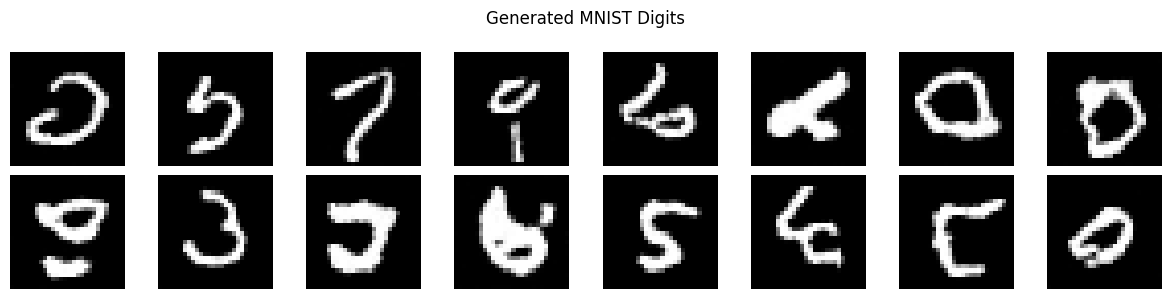

In [17]:
# Generate samples
generated_samples = sample(model, scheduler, config, num_samples=16)

# Visualize generated samples
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_samples[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.suptitle('Generated MNIST Digits')
plt.tight_layout()
plt.show()

## Part 6: Visualize the Reverse Diffusion Process

Let's visualize how the model gradually denoises to generate an image:

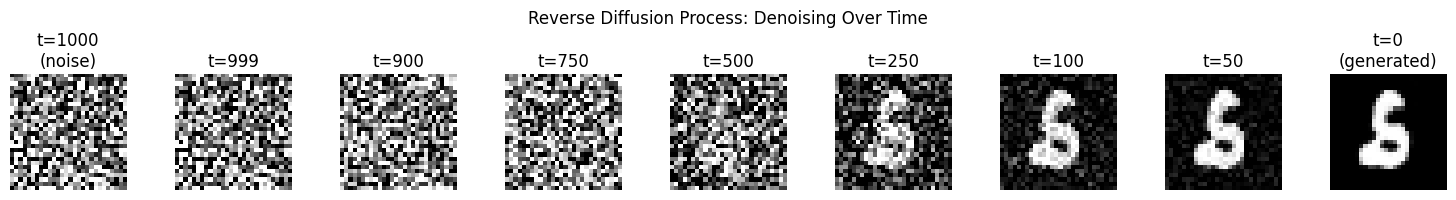

In [18]:
@torch.no_grad()
def sample_with_trajectory(model, scheduler, config):
    """Sample and save intermediate steps for visualization."""
    model.eval()
    
    x = torch.randn(1, config.in_channels, config.image_size, config.image_size).to(config.device)
    trajectory = [x.clone()]
    
    save_steps = [999, 900, 750, 500, 250, 100, 50, 0]
    
    for t in range(config.num_timesteps - 1, -1, -1):
        x = sample_step(model, x, t, scheduler)
        if t in save_steps:
            trajectory.append(x.clone())
    
    return trajectory, save_steps

trajectory, steps = sample_with_trajectory(model, scheduler, config)

fig, axes = plt.subplots(1, len(trajectory), figsize=(15, 2))
titles = ['t=1000\n(noise)'] + [f't={s}' for s in steps[:-1]] + ['t=0\n(generated)']
for i, (img, title) in enumerate(zip(trajectory, titles)):
    img = torch.clamp(img, -1, 1)
    img = (img + 1) / 2
    axes[i].imshow(img[0].squeeze().cpu(), cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')
plt.suptitle('Reverse Diffusion Process: Denoising Over Time')
plt.tight_layout()
plt.show()

## Save the Model

In [19]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config
}, 'diffusion_model.pt')
print("Model saved!")

Model saved!


## Summary

In this assignment, you implemented:

1. **Noise Scheduler**: Defines how noise is added during the forward process
2. **Sinusoidal Position Embedding**: Encodes the timestep for the model
3. **U-Net Architecture**: Predicts the noise added to images
4. **Training Loop**: Optimizes the model to predict noise
5. **Sampling**: Generates new images by iteratively denoising

Congratulations! You've built a working diffusion model from scratch. This is the same fundamental approach used in state-of-the-art image generation models like Stable Diffusion, DALL-E, and Imagen.